In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import prophet
from prophet import Prophet

In [3]:
import distutils
print(distutils.__file__)

c:\Users\yuuki\anaconda3\envs\py_306_prophet\lib\distutils\__init__.py


In [4]:
# データの読み込み
train_df = pd.read_csv("./data/train.csv", parse_dates=["date"])
test_df = pd.read_csv("./data/test.csv", parse_dates=["date"])
submission_df = pd.read_csv("./data/sample_submission.csv")

## データの確認

In [5]:
# 訓練データ型や欠損値の確認
train_df.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [6]:
train_df.tail()

,date,store,item,sales
912995,2017-12-27,10,50,63
912996,2017-12-28,10,50,59
912997,2017-12-29,10,50,74
912998,2017-12-30,10,50,62
912999,2017-12-31,10,50,82


In [7]:
train_df.dtypes

date     datetime64[ns]
store             int64
item              int64
sales             int64
dtype: object

In [8]:
train_df.isnull().sum()

date     0
store    0
item     0
sales    0
dtype: int64

In [9]:
train_df["store"].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=int64)

In [10]:
train_df["item"].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50],
      dtype=int64)

In [11]:
# テストデータのデータ型や欠損値の確認
test_df.head()

,id,date,store,item
0,0,2018-01-01,1,1
1,1,2018-01-02,1,1
2,2,2018-01-03,1,1
3,3,2018-01-04,1,1
4,4,2018-01-05,1,1


In [12]:
test_df.tail()

,id,date,store,item
44995,44995,2018-03-27,10,50
44996,44996,2018-03-28,10,50
44997,44997,2018-03-29,10,50
44998,44998,2018-03-30,10,50
44999,44999,2018-03-31,10,50


In [13]:
test_df.dtypes

id                int64
date     datetime64[ns]
store             int64
item              int64
dtype: object

In [14]:
test_df.isnull().sum()

id       0
date     0
store    0
item     0
dtype: int64

In [15]:
test_df["store"].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=int64)

In [16]:
test_df["item"].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50],
      dtype=int64)

## わかったこと
* データはdatetime型とint型のみ  
* 欠損値はない  
* storeは1～10まであり、itemは1～50まである  
* 訓練データの期間は2013/1/1～2017/12/31  
* テストデータの期間は2018/1/1～2018/3/31

## EDA

In [17]:
# storeごとの平均の売り上げ
store_df = pd.pivot_table(train_df, index=["date"], columns=["store"], values=["sales"], aggfunc="mean")
store_df

sales                                                          \
store          1      2      3      4      5      6      7      8      9    
date                                                                        
2013-01-01  26.32  34.84  31.76  28.46  20.64  21.98  19.28  32.56  27.66   
2013-01-02  25.28  36.16  30.76  28.64  19.94  20.46  18.88  33.74  29.10   
2013-01-03  26.10  37.74  32.70  30.68  22.60  22.98  19.32  34.72  29.84   
2013-01-04  29.04  39.66  34.82  33.70  25.16  24.02  20.80  39.32  32.24   
2013-01-05  29.98  41.74  37.74  32.98  23.08  25.72  22.62  40.10  33.96   
...           ...    ...    ...    ...    ...    ...    ...    ...    ...   
2017-12-27  36.74  52.48  47.30  43.52  31.04  31.20  29.42  49.36  42.08   
2017-12-28  39.02  56.78  49.58  46.12  33.92  34.14  30.18  53.20  46.18   
2017-12-29  42.32  60.50  52.92  49.20  35.48  34.74  33.78  58.46  49.56   
2017-12-30  46.08  63.02  57.70  52.74  38.44  37.54  34.42  62.18  52.80   
2017-12-31  47.76  67.40  61.72  56.88  39.48  40.18  36.62  64.10  55.48   

                   
store          10  
date               
2013-01-01  30.42  
2013-01-02  30.60  
2013-01-03  33.08  
2013-01-04  34.78  
2013-01-05  36.82  
...           ...  
2017-12-27  44.42  
2017-12-28  48.58  
2017-12-29  53.74  
2017-12-30  54.84  
2017-12-31  58.78  

[1826 rows x 10 columns]

In [18]:
# マルチインデックスを解除
store_df = pd.melt(store_df.reset_index(), id_vars=["date"])
store_df

,date,NaN,store,value
0,2013-01-01,sales,1,26.32
1,2013-01-02,sales,1,25.28
2,2013-01-03,sales,1,26.10
3,2013-01-04,sales,1,29.04
4,2013-01-05,sales,1,29.98
...,...,...,...,...
18255,2017-12-27,sales,10,44.42
18256,2017-12-28,sales,10,48.58
18257,2017-12-29,sales,10,53.74
18258,2017-12-30,sales,10,54.84


In [19]:
store_df["store"].unique()

array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10], dtype=object)

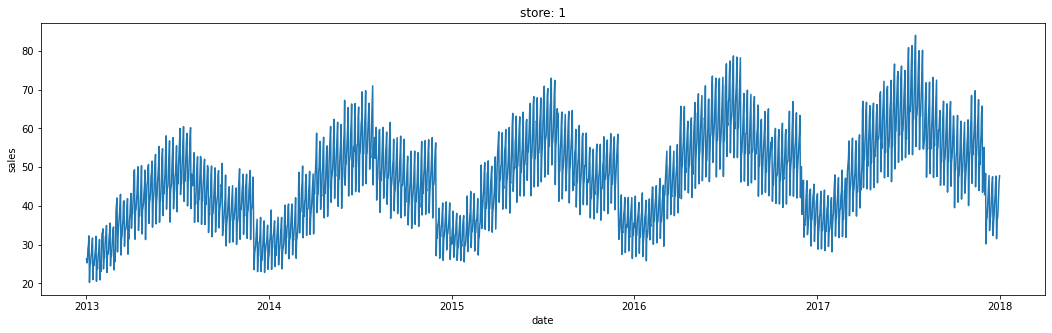

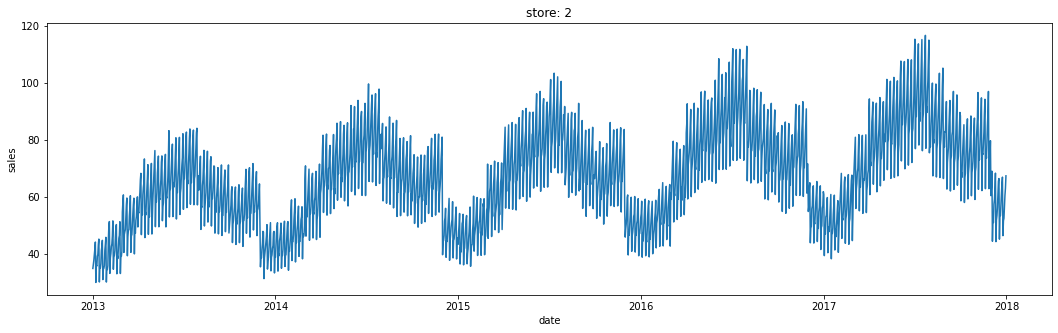

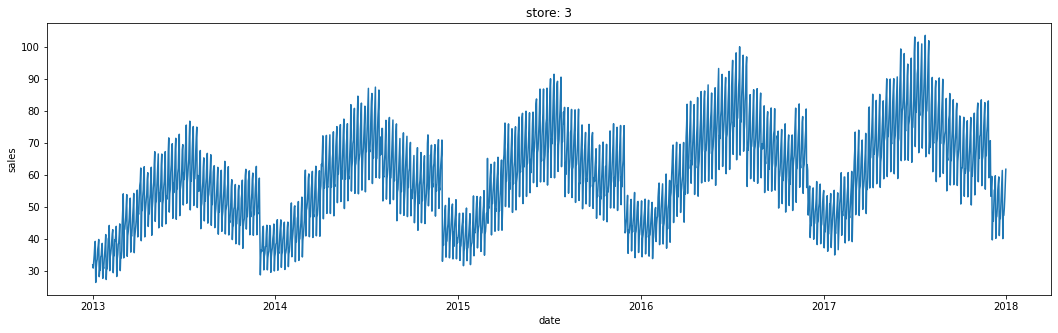

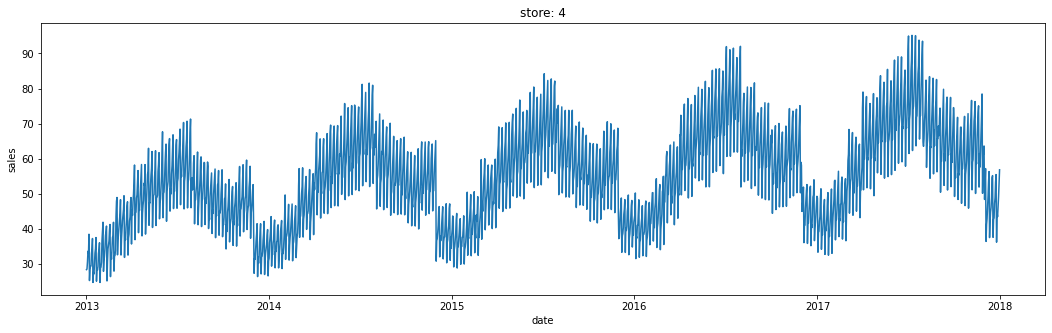

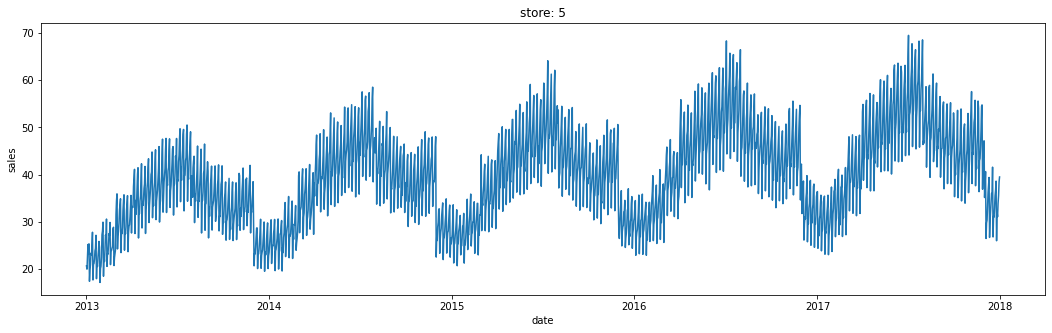

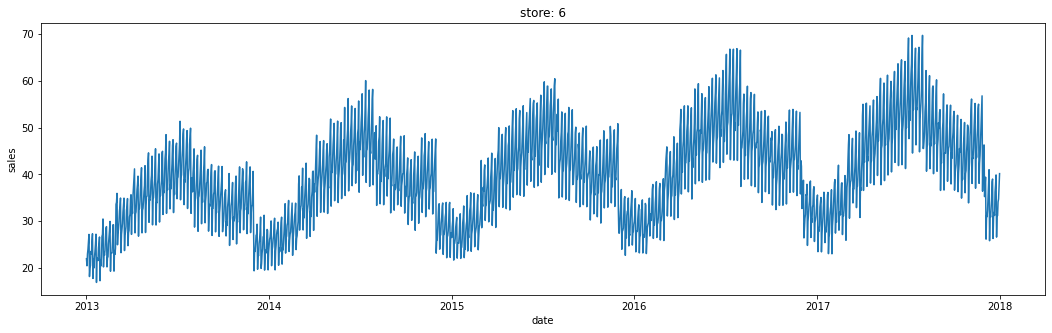

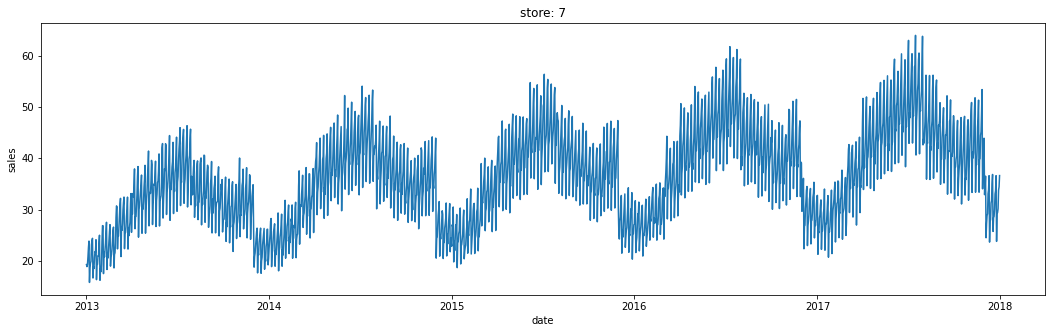

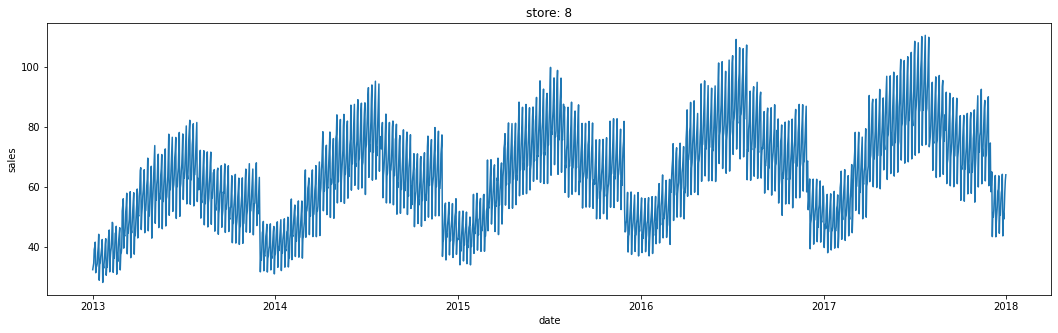

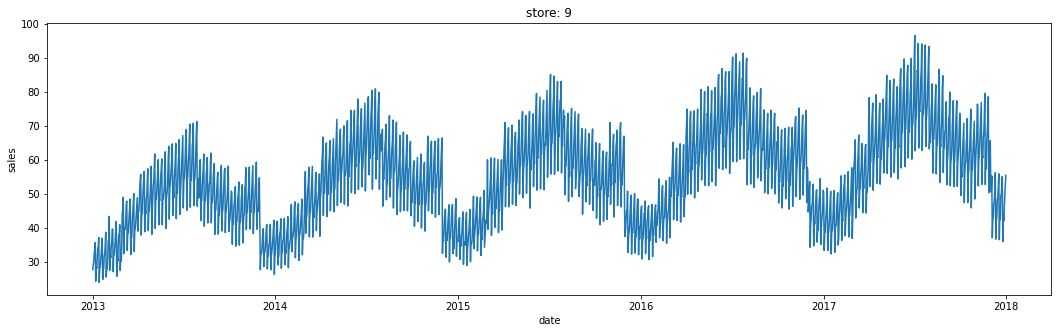

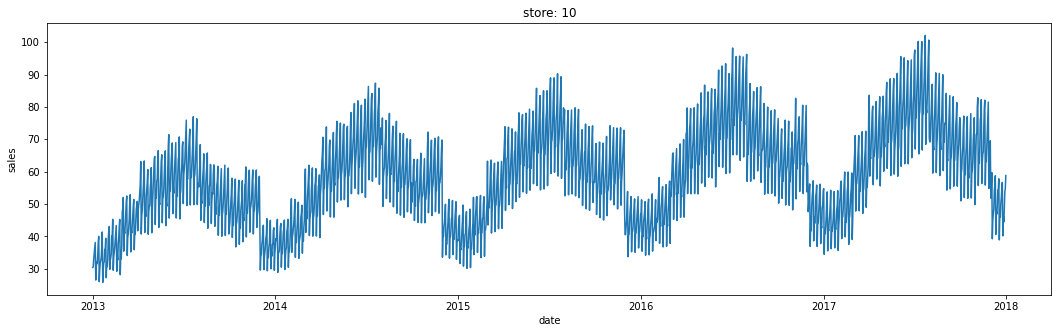

In [20]:
# 店舗ごとの平均の売り上げの推移
for i in store_df["store"].unique():
    plt.figure(figsize=(18, 5))
    sns.lineplot(data=store_df[store_df["store"]==i], x="date", y="value")
    plt.ylabel("sales")
    plt.title(f"store: {i}")
    # plt.show()
    plt.savefig(f"./figure/store_{i}_date.jpg")

In [21]:
# storeによる平均売り上げの差
store = train_df[["store", "sales"]].groupby("store").mean()
store

,sales
store,
1,47.268379
2,67.033165
3,59.530602
4,54.902946
5,39.770164
6,39.733516
7,36.363735
8,64.142048
9,55.049025


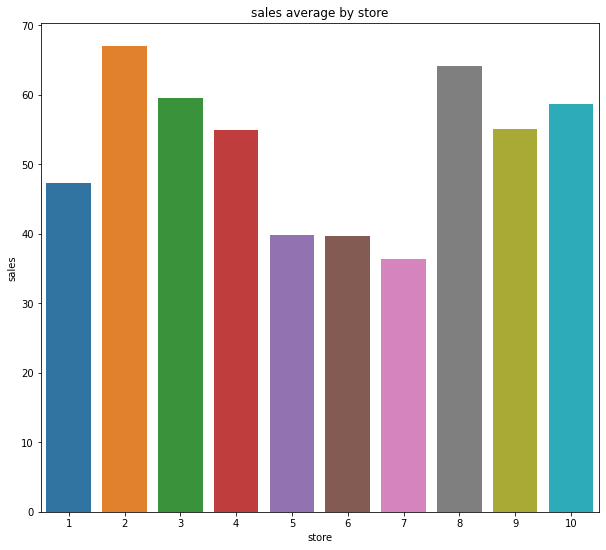

In [22]:
plt.figure(figsize=(10, 9))
sns.barplot(data=store, x=store.index, y="sales")
plt.title("sales average by store")
# plt.show()
plt.savefig("./figure/sales_vs_store.jpg")

## わかったこと
* 店舗ごとに売り上げの平均の絶対値は異なる  
* 店舗ごとで年次の季節性や全体のトレンドに大きな差はない

In [23]:
# itemごとの売り上げの平均
item = train_df[["item", "sales"]].groupby("item").mean()
item

,sales
item,
1,21.981599
2,58.574151
3,36.642223
4,22.010241
5,18.358708
6,58.503888
7,58.531051
8,76.950055
9,51.389869


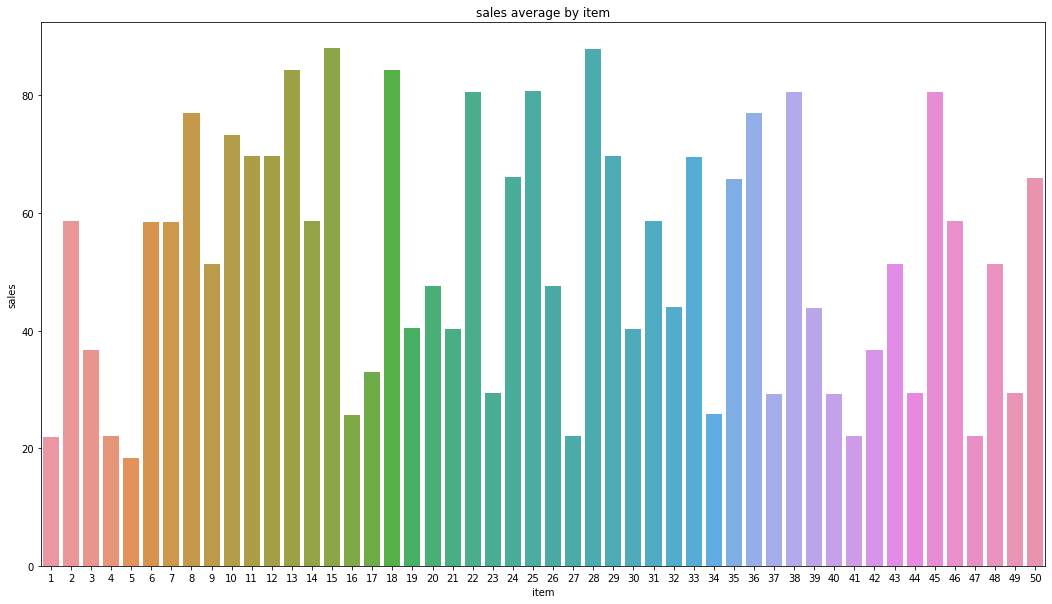

In [24]:
# 可視化
plt.figure(figsize=(18, 10))
sns.barplot(data=item, x=item.index, y="sales")
plt.title("sales average by item")
# plt.show()
plt.savefig("./figure/sales_vs_item.jpg")

In [25]:
# itemごとの平均の売り上げ
item_df = pd.pivot_table(train_df, index=["date"], columns=["item"], values=["sales"], aggfunc="mean")
item_df

sales                                                        ...  \
item          1     2     3     4     5     6     7     8     9     10  ...   
date                                                                    ...   
2013-01-01  13.3  32.7  17.2  10.2   8.3  28.8  27.8  41.6  24.5  37.8  ...   
2013-01-02   9.9  27.9  21.3  11.0   8.1  31.0  29.1  38.6  22.5  39.7  ...   
2013-01-03  12.7  30.4  19.3  11.2   9.6  30.9  32.4  39.8  26.5  38.8  ...   
2013-01-04  14.5  35.9  21.8  13.8  10.8  34.3  33.5  43.0  31.3  46.2  ...   
2013-01-05  14.9  37.7  21.7  14.4  10.0  34.3  37.7  48.1  31.9  44.9  ...   
...          ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   
2017-12-27  15.4  50.0  28.2  17.2  14.8  40.6  45.7  57.9  38.7  54.6  ...   
2017-12-28  17.8  49.5  29.8  19.0  15.7  50.6  49.9  64.4  42.0  60.9  ...   
2017-12-29  20.7  51.5  33.2  19.2  17.7  53.0  53.2  64.8  49.4  61.7  ...   
2017-12-30  23.6  53.8  34.2  21.1  17.3  53.2  60.9  78.4  49.2  69.8  ...   
2017-12-31  22.7  63.4  40.2  22.8  18.8  56.5  61.0  82.3  54.4  72.1  ...   

                                                                        
item          41    42    43    44    45    46    47    48    49    50  
date                                                                    
2013-01-01  10.3  19.5  25.3  15.4  39.6  31.9  11.6  27.7  15.9  33.0  
2013-01-02  13.2  21.5  25.5  16.5  39.3  31.6  11.8  28.1  15.9  38.4  
2013-01-03  13.1  21.5  30.6  17.0  45.9  32.5  10.4  28.0  18.7  35.6  
2013-01-04  12.2  22.4  32.3  18.9  45.0  35.1  12.8  29.6  18.4  39.4  
2013-01-05  14.2  24.3  30.9  20.2  53.3  36.0  13.3  34.4  17.9  40.7  
...          ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  
2017-12-27  17.6  26.4  38.1  23.3  68.1  48.7  17.1  37.4  23.1  51.1  
2017-12-28  17.2  34.6  41.5  24.8  70.7  47.3  18.8  39.5  27.6  58.7  
2017-12-29  18.5  30.4  45.7  27.7  72.4  54.8  21.3  49.6  23.7  59.6  
2017-12-30  17.7  33.8  50.7  26.6  76.2  56.6  19.0  50.2  30.3  61.2  
2017-12-31  24.6  36.4  48.7  29.9  80.5  60.5  21.1  49.4  28.5  62.6  

[1826 rows x 50 columns]

In [26]:
item_df.columns

MultiIndex([('sales',  1),
            ('sales',  2),
            ('sales',  3),
            ('sales',  4),
            ('sales',  5),
            ('sales',  6),
            ('sales',  7),
            ('sales',  8),
            ('sales',  9),
            ('sales', 10),
            ('sales', 11),
            ('sales', 12),
            ('sales', 13),
            ('sales', 14),
            ('sales', 15),
            ('sales', 16),
            ('sales', 17),
            ('sales', 18),
            ('sales', 19),
            ('sales', 20),
            ('sales', 21),
            ('sales', 22),
            ('sales', 23),
            ('sales', 24),
            ('sales', 25),
            ('sales', 26),
            ('sales', 27),
            ('sales', 28),
            ('sales', 29),
            ('sales', 30),
            ('sales', 31),
            ('sales', 32),
            ('sales', 33),
            ('sales', 34),
            ('sales', 35),
            ('sales', 36),
            ('sales', 37),
 

In [27]:
# マルチインデックス(マルチカラム)からlocを使ってデータを取り出す方法
pd.DataFrame(item_df.loc[:, ("sales", 1)])

,sales
,1
date,
2013-01-01,13.3
2013-01-02,9.9
2013-01-03,12.7
2013-01-04,14.5
2013-01-05,14.9
...,...
2017-12-27,15.4
2017-12-28,17.8


c:\Users\yuuki\anaconda3\envs\py_306_prophet\lib\site-packages\pandas\plotting\_matplotlib\core.py:328: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



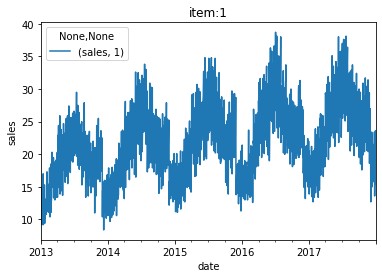

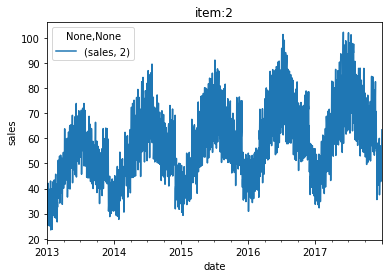

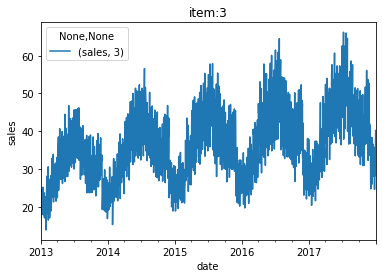

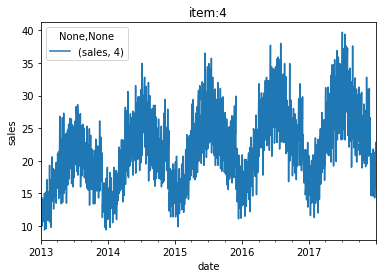

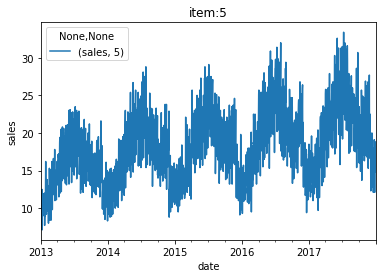

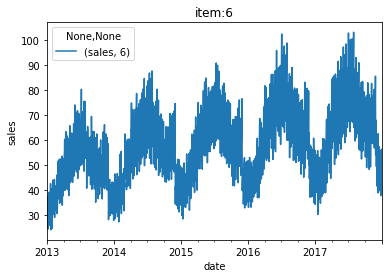

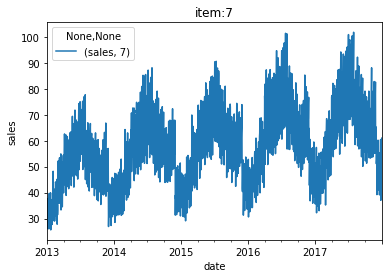

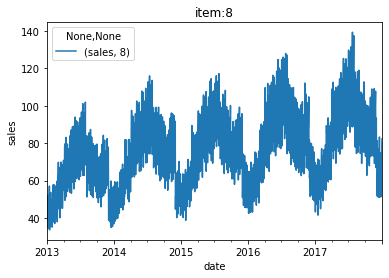

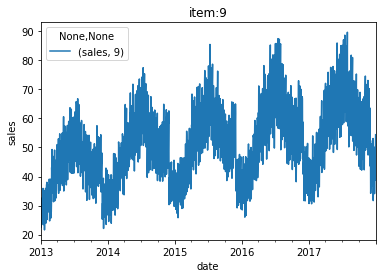

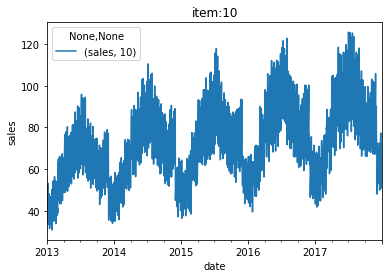

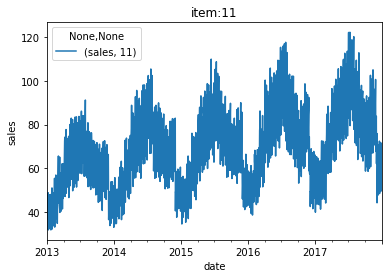

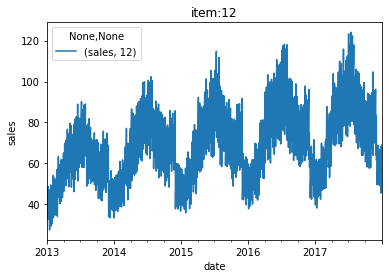

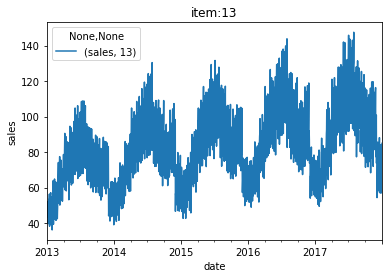

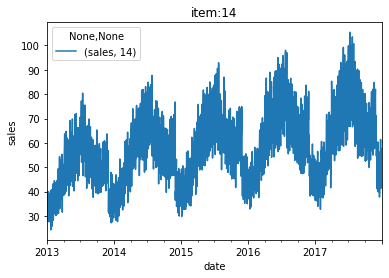

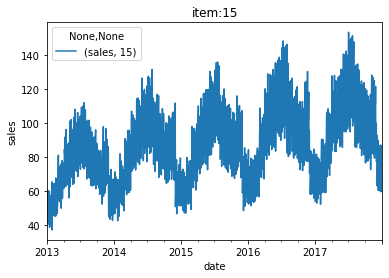

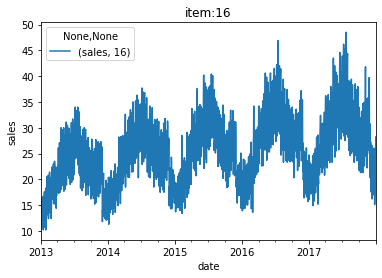

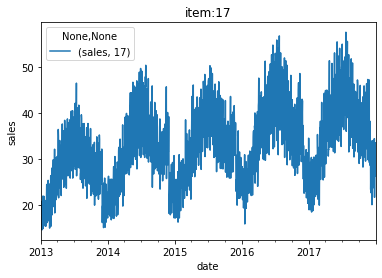

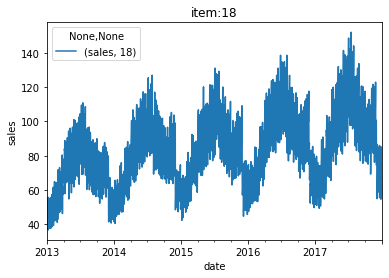

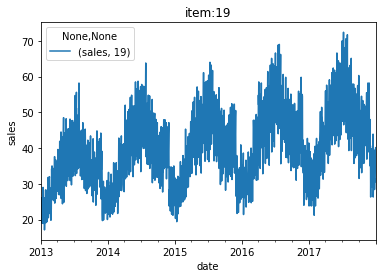

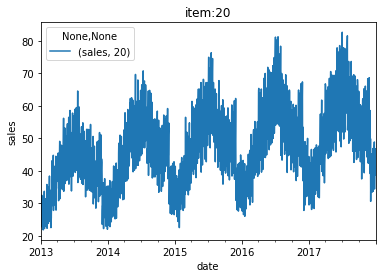

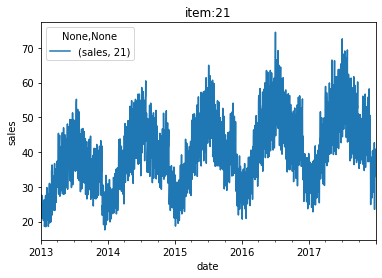

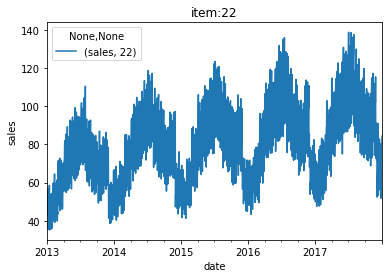

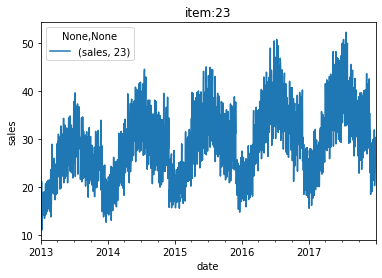

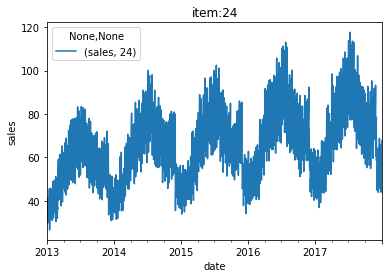

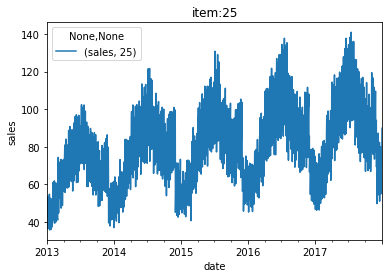

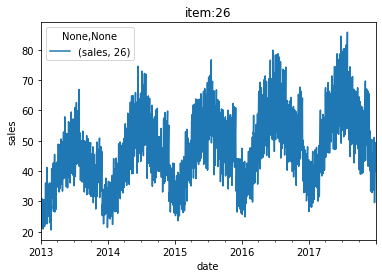

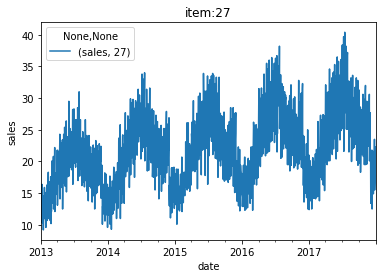

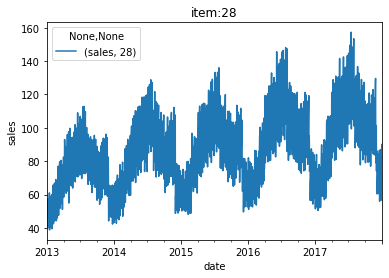

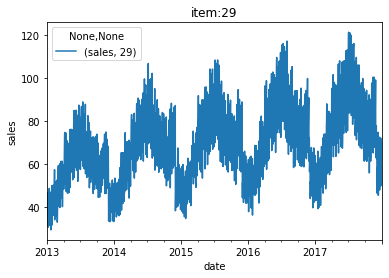

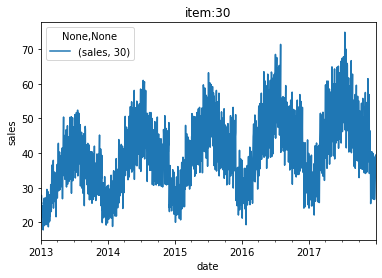

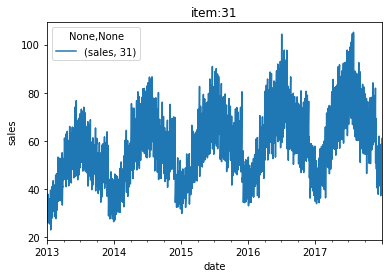

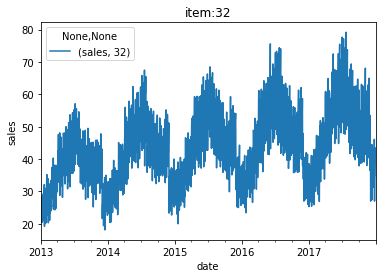

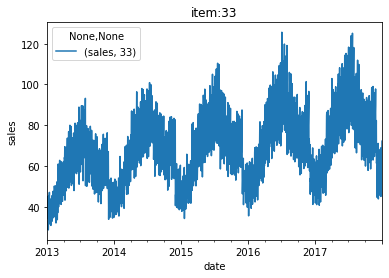

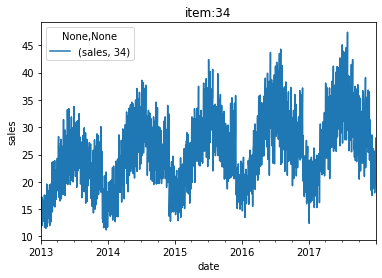

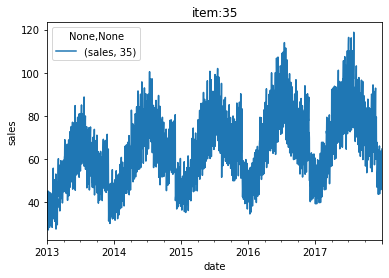

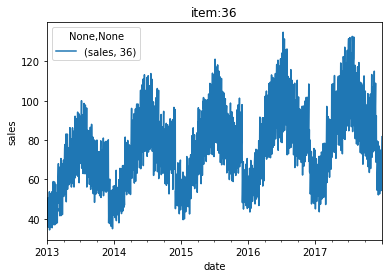

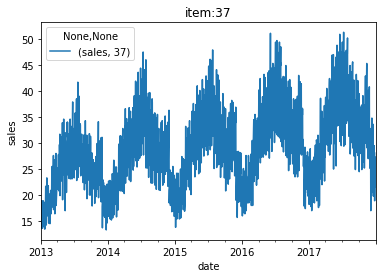

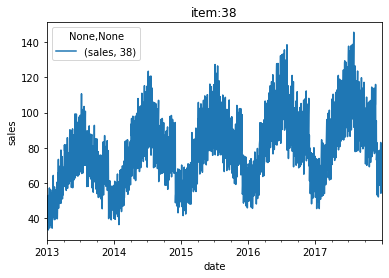

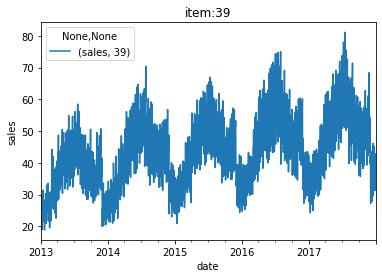

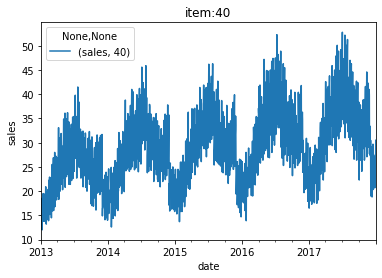

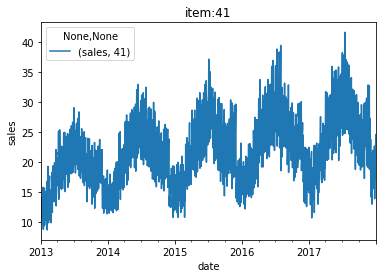

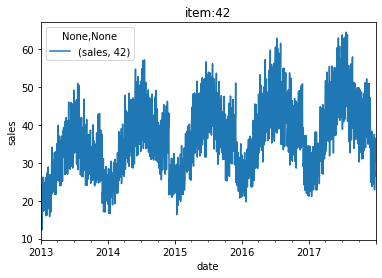

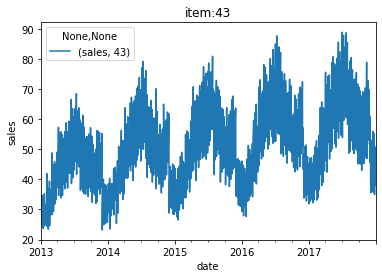

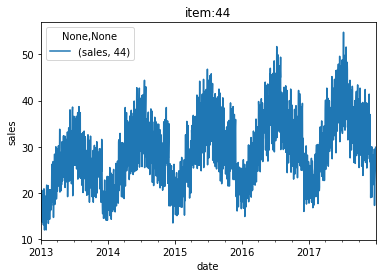

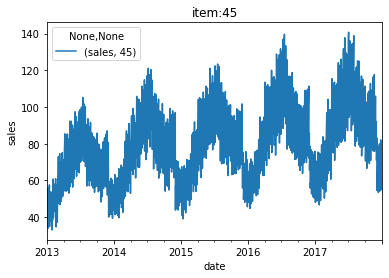

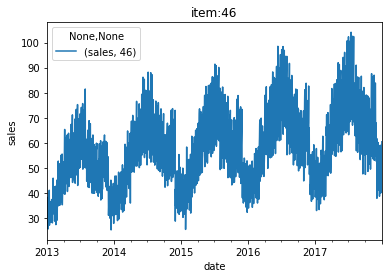

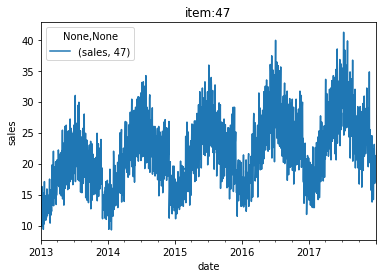

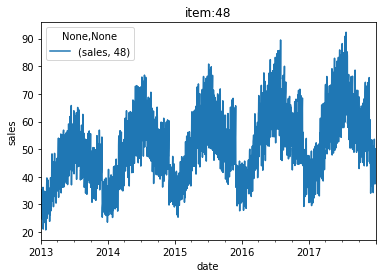

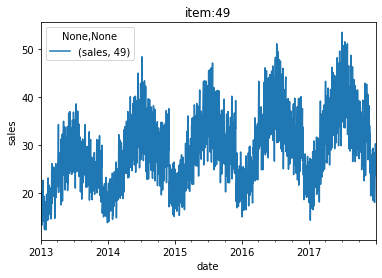

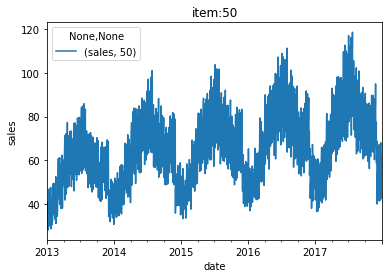

In [28]:
# itemごとの時間的な推移
for i in range(1, 51):
    pd.DataFrame(item_df.loc[:, ("sales", i)]).plot()
    plt.title(f"item:{i}")
    plt.ylabel("sales")
    # plt.show()
    plt.savefig(f"./figure/item_{i}_date.jpg")

## わかったこと
* itemごとに売り上げの平均の絶対値は異なる  
* itemごとで年次の季節性や全体のトレンドに大きな差はない

## 特徴量エンジニアリング
* 年次と月次でsalesの傾向が異なるのでyearとmonthを特徴量に入れる

In [29]:
train_df["year"] = train_df["date"].dt.year
train_df["month"] = train_df["date"].dt.month

In [30]:
train_df

,date,store,item,sales,year,month
0,2013-01-01,1,1,13,2013,1
1,2013-01-02,1,1,11,2013,1
2,2013-01-03,1,1,14,2013,1
3,2013-01-04,1,1,13,2013,1
4,2013-01-05,1,1,10,2013,1
...,...,...,...,...,...,...
912995,2017-12-27,10,50,63,2017,12
912996,2017-12-28,10,50,59,2017,12
912997,2017-12-29,10,50,74,2017,12
912998,2017-12-30,10,50,62,2017,12


## モデルの作成

In [31]:
# train_dfをprophetに入力できる形にする
train_df = train_df.rename(columns={"date":"ds", "sales":"y"})
train_df

,ds,store,item,y,year,month
0,2013-01-01,1,1,13,2013,1
1,2013-01-02,1,1,11,2013,1
2,2013-01-03,1,1,14,2013,1
3,2013-01-04,1,1,13,2013,1
4,2013-01-05,1,1,10,2013,1
...,...,...,...,...,...,...
912995,2017-12-27,10,50,63,2017,12
912996,2017-12-28,10,50,59,2017,12
912997,2017-12-29,10,50,74,2017,12
912998,2017-12-30,10,50,62,2017,12


In [32]:
# 学習データと検証データに分ける
# 学習データは2013-01-01から2017-09-30まで
# 検証データは2017-10-01から2017-12-31まで

# 学習データ
train_df2 = train_df[train_df["ds"] <= "2017-09-30"]
train_df2


,ds,store,item,y,year,month
0,2013-01-01,1,1,13,2013,1
1,2013-01-02,1,1,11,2013,1
2,2013-01-03,1,1,14,2013,1
3,2013-01-04,1,1,13,2013,1
4,2013-01-05,1,1,10,2013,1
...,...,...,...,...,...,...
912903,2017-09-26,10,50,79,2017,9
912904,2017-09-27,10,50,80,2017,9
912905,2017-09-28,10,50,82,2017,9
912906,2017-09-29,10,50,90,2017,9


In [33]:
# 検証データ
valid_df = train_df[train_df["ds"] > "2017-09-30"]
valid_df

,ds,store,item,y,year,month
1734,2017-10-01,1,1,21,2017,10
1735,2017-10-02,1,1,12,2017,10
1736,2017-10-03,1,1,18,2017,10
1737,2017-10-04,1,1,15,2017,10
1738,2017-10-05,1,1,20,2017,10
...,...,...,...,...,...,...
912995,2017-12-27,10,50,63,2017,12
912996,2017-12-28,10,50,59,2017,12
912997,2017-12-29,10,50,74,2017,12
912998,2017-12-30,10,50,62,2017,12


In [34]:
# インスタンスを生成
prophet = Prophet(yearly_seasonality=True, weekly_seasonality=True)

In [35]:
# 学習
prophet.fit(train_df2)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [36]:
# 検証データの期間のデータフレームを作成
pred_valid_period = prophet.make_future_dataframe(periods=92)
pred_valid_period

,ds
0,2013-01-01
1,2013-01-02
2,2013-01-03
3,2013-01-04
4,2013-01-05
...,...
1821,2017-12-27
1822,2017-12-28
1823,2017-12-29
1824,2017-12-30


In [37]:
# 検証データの期間の予測
predict_valid = prophet.predict(pred_valid_period)
predict_valid

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2013-01-01,45.557852,-9.066739,58.775208,45.557852,45.557852,-19.397944,-19.397944,-19.397944,-3.986305,-3.986305,-3.986305,-15.411639,-15.411639,-15.411639,0.0,0.0,0.0,26.159908
1,2013-01-02,45.548216,-6.871901,58.551204,45.548216,45.548216,-19.377427,-19.377427,-19.377427,-3.869173,-3.869173,-3.869173,-15.508254,-15.508254,-15.508254,0.0,0.0,0.0,26.170789
2,2013-01-03,45.538579,-0.871261,65.812754,45.538579,45.538579,-16.167333,-16.167333,-16.167333,-0.553980,-0.553980,-0.553980,-15.613353,-15.613353,-15.613353,0.0,0.0,0.0,29.371245
3,2013-01-04,45.528942,3.108632,67.313875,45.528942,45.528942,-12.793214,-12.793214,-12.793214,2.931078,2.931078,2.931078,-15.724292,-15.724292,-15.724292,0.0,0.0,0.0,32.735728
4,2013-01-05,45.519305,2.495944,69.866749,45.519305,45.519305,-9.422190,-9.422190,-9.422190,6.415971,6.415971,6.415971,-15.838161,-15.838161,-15.838161,0.0,0.0,0.0,36.097114
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1821,2017-12-27,61.006849,6.550010,76.575889,59.875072,62.102632,-18.981281,-18.981281,-18.981281,-3.869173,-3.869173,-3.869173,-15.112108,-15.112108,-15.112108,0.0,0.0,0.0,42.025568
1822,2017-12-28,61.016927,13.561497,78.640695,59.856772,62.126155,-15.693115,-15.693115,-15.693115,-0.553980,-0.553980,-0.553980,-15.139135,-15.139135,-15.139135,0.0,0.0,0.0,45.323812
1823,2017-12-29,61.027006,16.545469,82.045313,59.853035,62.153750,-12.249382,-12.249382,-12.249382,2.931078,2.931078,2.931078,-15.180460,-15.180460,-15.180460,0.0,0.0,0.0,48.777624
1824,2017-12-30,61.037085,17.381026,84.796058,59.832041,62.179395,-8.820343,-8.820343,-8.820343,6.415971,6.415971,6.415971,-15.236314,-15.236314,-15.236314,0.0,0.0,0.0,52.216741


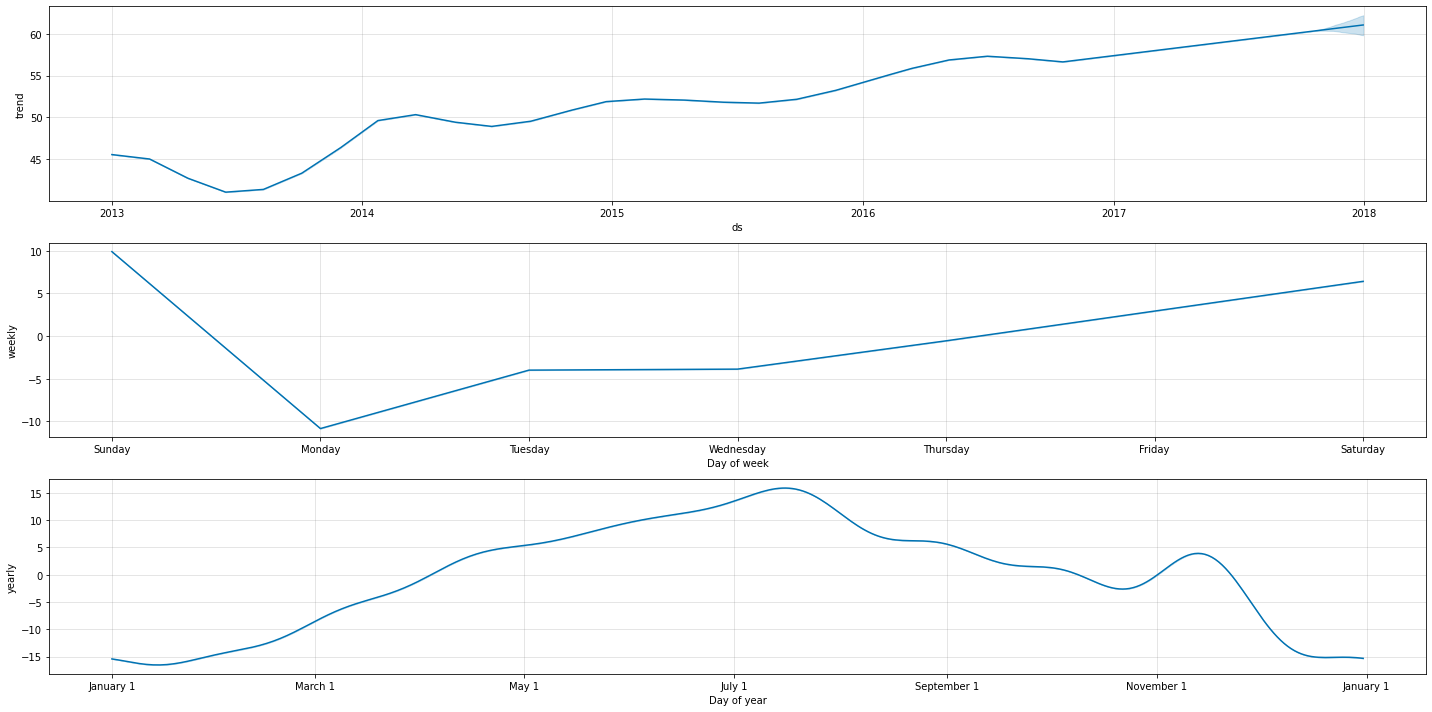

In [38]:

# trendやseasonalityの可視化
figure = prophet.plot_components(predict_valid, figsize=(20, 10))
import os
os.makedirs("./figure", exist_ok=True)
# グラフを JPG 形式で保存
plt.savefig('./figure/components.jpg', bbox_inches='tight')

## storeごとitemごとに予測する関数を定義

In [39]:
# storeおよびitemごとの予測
def prediction_valid(item, store):
    """
    Prophet モデルを使って、特定のアイテムと店舗の2017年10月1日から2017年12月31日までの売上を予測します。

    引数:
        item (int): 予測対象のアイテムID
        store (int): 予測対象の店舗ID

    返値:
    pandas.DataFrame: 予測結果 (日付と予測値の列を含む)
    """
    # モデルの初期化
    pg = Prophet(yearly_seasonality=True, weekly_seasonality=True)
    # 検証データの準備
    # trainデータの中からstore_idでデータを絞り込む
    valid = train_df2[train_df2.store==store]
    # store_idで絞ったデータをitemでさらに絞り込む
    valid = valid[valid.item==item]
    # モデルの学習
    pg.fit(valid)
    # 予測のデータフレームを作成
    future = pg.make_future_dataframe(periods=92)
    # 予測
    forecast = pg.predict(future)
    # データを2017年のものに絞り込む
    forecast_final = forecast[forecast["ds"].dt.year==2017]
    # データを2017-10-01～2017-12-31に絞る
    forecast_final = forecast_final[(forecast_final["ds"] >= "2017-10-01") & (forecast_final["ds"] <= "2017-12-31")]
    # 日付とyhatのみを返す
    return forecast_final[["ds", "yhat"]]

In [40]:
# 全ての店舗とアイテムに対して予測を実行
# 予測結果を格納するリスト
results_valid = []
# 店舗idを1から11までループ
for i in range(1, 11):
    # アイテムidを1から50までループ
    for j in range(1, 51):
        # 予測結果を取得
        result_valid = prediction_valid(j, i)
        print(result_valid)
        # 予測結果をリストに格納
        results_valid.append(result_valid["yhat"].values)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  26.635576
1735 2017-10-02  18.480013
1736 2017-10-03  21.132345
1737 2017-10-04  21.847645
1738 2017-10-05  22.434436
...         ...        ...
1821 2017-12-27  16.459662
1822 2017-12-28  17.114079
1823 2017-12-29  18.928547
1824 2017-12-30  20.740126
1825 2017-12-31  21.622893

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  71.726678
1735 2017-10-02  50.433467
1736 2017-10-03  57.610678
1737 2017-10-04  58.273001
1738 2017-10-05  61.309612
...         ...        ...
1821 2017-12-27  44.394233
1822 2017-12-28  47.494130
1823 2017-12-29  50.945988
1824 2017-12-30  54.725771
1825 2017-12-31  58.167979

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  45.436565
1735 2017-10-02  32.165734
1736 2017-10-03  35.552929
1737 2017-10-04  35.697526
1738 2017-10-05  37.502389
...         ...        ...
1821 2017-12-27  26.489025
1822 2017-12-28  28.527474
1823 2017-12-29  31.389541
1824 2017-12-30  33.142065
1825 2017-12-31  36.023212

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  25.880898
1735 2017-10-02  17.618092
1736 2017-10-03  20.431287
1737 2017-10-04  20.388654
1738 2017-10-05  22.344790
...         ...        ...
1821 2017-12-27  16.154952
1822 2017-12-28  18.203362
1823 2017-12-29  18.550450
1824 2017-12-30  20.569228
1825 2017-12-31  21.600353

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  22.286008
1735 2017-10-02  15.750404
1736 2017-10-03  17.967497
1737 2017-10-04  18.226092
1738 2017-10-05  19.678666
...         ...        ...
1821 2017-12-27  13.471715
1822 2017-12-28  14.987511
1823 2017-12-29  15.283747
1824 2017-12-30  16.360138
1825 2017-12-31  17.551180

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  70.103942
1735 2017-10-02  48.746658
1736 2017-10-03  56.080329
1737 2017-10-04  56.598026
1738 2017-10-05  58.681958
...         ...        ...
1821 2017-12-27  43.398162
1822 2017-12-28  45.572440
1823 2017-12-29  49.951506
1824 2017-12-30  53.703321
1825 2017-12-31  57.001053

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  72.312581
1735 2017-10-02  51.114810
1736 2017-10-03  58.076397
1737 2017-10-04  58.268507
1738 2017-10-05  62.345773
...         ...        ...
1821 2017-12-27  41.216208
1822 2017-12-28  45.300882
1823 2017-12-29  47.867709
1824 2017-12-30  52.854567
1825 2017-12-31  54.998523

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  94.614317
1735 2017-10-02  66.463728
1736 2017-10-03  76.454555
1737 2017-10-04  75.955862
1738 2017-10-05  79.773691
...         ...        ...
1821 2017-12-27  57.708078
1822 2017-12-28  61.825481
1823 2017-12-29  67.025590
1824 2017-12-30  71.555523
1825 2017-12-31  76.242125

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  62.938363
1735 2017-10-02  45.045861
1736 2017-10-03  50.563875
1737 2017-10-04  51.113651
1738 2017-10-05  54.235027
...         ...        ...
1821 2017-12-27  36.136621
1822 2017-12-28  39.315661
1823 2017-12-29  41.261940
1824 2017-12-30  45.374805
1825 2017-12-31  47.714839

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  90.286179
1735 2017-10-02  63.006250
1736 2017-10-03  71.434699
1737 2017-10-04  71.689208
1738 2017-10-05  75.980859
...         ...        ...
1821 2017-12-27  53.757143
1822 2017-12-28  58.491341
1823 2017-12-29  63.165232
1824 2017-12-30  67.199460
1825 2017-12-31  73.230056

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  84.626820
1735 2017-10-02  60.182175
1736 2017-10-03  67.854124
1737 2017-10-04  68.434332
1738 2017-10-05  71.453252
...         ...        ...
1821 2017-12-27  53.099339
1822 2017-12-28  56.256978
1823 2017-12-29  61.015359
1824 2017-12-30  65.830266
1825 2017-12-31  68.939091

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  85.013237
1735 2017-10-02  59.891133
1736 2017-10-03  67.594759
1737 2017-10-04  68.150809
1738 2017-10-05  71.580172
...         ...        ...
1821 2017-12-27  52.424046
1822 2017-12-28  56.080739
1823 2017-12-29  60.597768
1824 2017-12-30  63.948675
1825 2017-12-31  68.365379

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1734 2017-10-01  103.135534
1735 2017-10-02   74.192038
1736 2017-10-03   84.239766
1737 2017-10-04   84.083491
1738 2017-10-05   87.070248
...         ...         ...
1821 2017-12-27   62.351498
1822 2017-12-28   65.445914
1823 2017-12-29   71.901643
1824 2017-12-30   76.555964
1825 2017-12-31   81.433392

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  70.661069
1735 2017-10-02  51.068593
1736 2017-10-03  56.956523
1737 2017-10-04  57.262107
1738 2017-10-05  59.440202
...         ...        ...
1821 2017-12-27  44.094088
1822 2017-12-28  46.484813
1823 2017-12-29  49.528669
1824 2017-12-30  54.229347
1825 2017-12-31  56.400259

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1734 2017-10-01  106.743250
1735 2017-10-02   74.302711
1736 2017-10-03   84.578732
1737 2017-10-04   84.361109
1738 2017-10-05   89.332474
...         ...         ...
1821 2017-12-27   65.662814
1822 2017-12-28   71.072041
1823 2017-12-29   77.397791
1824 2017-12-30   81.443327
1825 2017-12-31   88.185803

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  31.054344
1735 2017-10-02  21.877210
1736 2017-10-03  24.980380
1737 2017-10-04  25.229835
1738 2017-10-05  26.638818
...         ...        ...
1821 2017-12-27  18.843898
1822 2017-12-28  20.328088
1823 2017-12-29  21.688790
1824 2017-12-30  23.999133
1825 2017-12-31  24.300764

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  39.863396
1735 2017-10-02  28.157207
1736 2017-10-03  31.145315
1737 2017-10-04  32.102658
1738 2017-10-05  33.124793
...         ...        ...
1821 2017-12-27  24.305291
1822 2017-12-28  25.482022
1823 2017-12-29  28.103441
1824 2017-12-30  29.782453
1825 2017-12-31  31.627818

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1734 2017-10-01  102.023501
1735 2017-10-02   70.512177
1736 2017-10-03   80.988756
1737 2017-10-04   80.454640
1738 2017-10-05   85.287666
...         ...         ...
1821 2017-12-27   61.196748
1822 2017-12-28   66.281711
1823 2017-12-29   72.755807
1824 2017-12-30   77.825188
1825 2017-12-31   82.935141

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  49.706899
1735 2017-10-02  34.880909
1736 2017-10-03  39.642390
1737 2017-10-04  40.158487
1738 2017-10-05  41.228770
...         ...        ...
1821 2017-12-27  31.220382
1822 2017-12-28  32.400652
1823 2017-12-29  34.898270
1824 2017-12-30  37.959067
1825 2017-12-31  40.428945

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  57.542744
1735 2017-10-02  40.278125
1736 2017-10-03  45.548090
1737 2017-10-04  45.917095
1738 2017-10-05  48.266502
...         ...        ...
1821 2017-12-27  35.283593
1822 2017-12-28  37.669131
1823 2017-12-29  39.571030
1824 2017-12-30  43.509253
1825 2017-12-31  46.485932

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  48.355279
1735 2017-10-02  33.873504
1736 2017-10-03  38.930673
1737 2017-10-04  37.898430
1738 2017-10-05  41.256239
...         ...        ...
1821 2017-12-27  28.314428
1822 2017-12-28  31.879870
1823 2017-12-29  33.640788
1824 2017-12-30  36.204565
1825 2017-12-31  38.518977

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1734 2017-10-01  101.344589
1735 2017-10-02   71.031091
1736 2017-10-03   80.255438
1737 2017-10-04   81.074558
1738 2017-10-05   84.881413
...         ...         ...
1821 2017-12-27   61.166617
1822 2017-12-28   65.388030
1823 2017-12-29   69.448960
1824 2017-12-30   75.193985
1825 2017-12-31   80.946065

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  35.567664
1735 2017-10-02  24.825412
1736 2017-10-03  28.377127
1737 2017-10-04  28.631422
1738 2017-10-05  29.777416
...         ...        ...
1821 2017-12-27  21.675679
1822 2017-12-28  22.988273
1823 2017-12-29  25.155234
1824 2017-12-30  27.685871
1825 2017-12-31  28.963018

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  82.656606
1735 2017-10-02  58.804755
1736 2017-10-03  67.049166
1737 2017-10-04  66.586703
1738 2017-10-05  69.900256
...         ...        ...
1821 2017-12-27  47.240860
1822 2017-12-28  50.756263
1823 2017-12-29  55.210021
1824 2017-12-30  59.025267
1825 2017-12-31  63.067266

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  98.343012
1735 2017-10-02  68.508569
1736 2017-10-03  78.795676
1737 2017-10-04  77.610653
1738 2017-10-05  82.184512
...         ...        ...
1821 2017-12-27  58.589084
1822 2017-12-28  63.437791
1823 2017-12-29  67.964091
1824 2017-12-30  73.009383
1825 2017-12-31  78.760357

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  58.030175
1735 2017-10-02  40.547451
1736 2017-10-03  46.750045
1737 2017-10-04  46.250799
1738 2017-10-05  49.278255
...         ...        ...
1821 2017-12-27  33.300919
1822 2017-12-28  36.486258
1823 2017-12-29  38.439177
1824 2017-12-30  42.602445
1825 2017-12-31  45.084876

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  26.803065
1735 2017-10-02  18.520991
1736 2017-10-03  21.727342
1737 2017-10-04  21.414840
1738 2017-10-05  22.791777
...         ...        ...
1821 2017-12-27  16.338358
1822 2017-12-28  17.810650
1823 2017-12-29  19.819422
1824 2017-12-30  20.017805
1825 2017-12-31  21.501963

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1734 2017-10-01  107.148258
1735 2017-10-02   74.619158
1736 2017-10-03   84.785244
1737 2017-10-04   84.974072
1738 2017-10-05   89.976088
...         ...         ...
1821 2017-12-27   66.369120
1822 2017-12-28   71.446656
1823 2017-12-29   76.217992
1824 2017-12-30   82.309418
1825 2017-12-31   87.748026

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  85.872805
1735 2017-10-02  60.976087
1736 2017-10-03  68.524332
1737 2017-10-04  69.161151
1738 2017-10-05  73.021008
...         ...        ...
1821 2017-12-27  52.039996
1822 2017-12-28  56.100268
1823 2017-12-29  59.768127
1824 2017-12-30  64.997866
1825 2017-12-31  69.026545

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  49.330810
1735 2017-10-02  34.327583
1736 2017-10-03  38.766026
1737 2017-10-04  38.587960
1738 2017-10-05  40.801759
...         ...        ...
1821 2017-12-27  29.785768
1822 2017-12-28  32.299258
1823 2017-12-29  34.784914
1824 2017-12-30  37.651387
1825 2017-12-31  40.280882

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  73.403036
1735 2017-10-02  51.087948
1736 2017-10-03  58.419569
1737 2017-10-04  58.769017
1738 2017-10-05  61.432487
...         ...        ...
1821 2017-12-27  43.498239
1822 2017-12-28  46.205424
1823 2017-12-29  49.932838
1824 2017-12-30  52.745887
1825 2017-12-31  57.663773

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  53.499644
1735 2017-10-02  38.849546
1736 2017-10-03  43.338423
1737 2017-10-04  43.356314
1738 2017-10-05  45.235058
...         ...        ...
1821 2017-12-27  32.444512
1822 2017-12-28  34.385973
1823 2017-12-29  37.728118
1824 2017-12-30  40.312248
1825 2017-12-31  42.433843

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  83.400796
1735 2017-10-02  59.192480
1736 2017-10-03  67.508992
1737 2017-10-04  67.165219
1738 2017-10-05  71.000495
...         ...        ...
1821 2017-12-27  52.379000
1822 2017-12-28  56.455681
1823 2017-12-29  61.571301
1824 2017-12-30  65.937063
1825 2017-12-31  69.077262

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  31.199700
1735 2017-10-02  21.411966
1736 2017-10-03  24.374933
1737 2017-10-04  24.174148
1738 2017-10-05  25.913615
...         ...        ...
1821 2017-12-27  18.779721
1822 2017-12-28  20.646920
1823 2017-12-29  22.058749
1824 2017-12-30  23.695547
1825 2017-12-31  25.613560

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  80.851702
1735 2017-10-02  57.272251
1736 2017-10-03  64.786528
1737 2017-10-04  64.511337
1738 2017-10-05  68.183773
...         ...        ...
1821 2017-12-27  48.022633
1822 2017-12-28  51.850140
1823 2017-12-29  55.742715
1824 2017-12-30  59.942386
1825 2017-12-31  63.944761

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  93.605132
1735 2017-10-02  66.925843
1736 2017-10-03  75.638017
1737 2017-10-04  75.474609
1738 2017-10-05  79.806067
...         ...        ...
1821 2017-12-27  55.568617
1822 2017-12-28  60.204652
1823 2017-12-29  65.951289
1824 2017-12-30  70.039465
1825 2017-12-31  74.002278

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  35.379558
1735 2017-10-02  24.918224
1736 2017-10-03  28.584594
1737 2017-10-04  28.348520
1738 2017-10-05  30.343197
...         ...        ...
1821 2017-12-27  21.101892
1822 2017-12-28  23.185578
1823 2017-12-29  24.737451
1824 2017-12-30  26.198356
1825 2017-12-31  27.768832

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  99.510747
1735 2017-10-02  70.942534
1736 2017-10-03  79.772514
1737 2017-10-04  80.764628
1738 2017-10-05  85.133565
...         ...        ...
1821 2017-12-27  60.801301
1822 2017-12-28  65.238179
1823 2017-12-29  70.589174
1824 2017-12-30  74.387123
1825 2017-12-31  79.441834

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  54.812639
1735 2017-10-02  38.698367
1736 2017-10-03  44.170840
1737 2017-10-04  44.855917
1738 2017-10-05  46.652485
...         ...        ...
1821 2017-12-27  33.684027
1822 2017-12-28  35.494018
1823 2017-12-29  37.860446
1824 2017-12-30  40.838284
1825 2017-12-31  43.184028

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  36.270022
1735 2017-10-02  25.901136
1736 2017-10-03  29.214094
1737 2017-10-04  29.701736
1738 2017-10-05  31.770932
...         ...        ...
1821 2017-12-27  22.037776
1822 2017-12-28  24.075293
1823 2017-12-29  24.916289
1824 2017-12-30  27.463572
1825 2017-12-31  28.867189

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  26.609428
1735 2017-10-02  18.846736
1736 2017-10-03  21.604808
1737 2017-10-04  21.994217
1738 2017-10-05  22.959743
...         ...        ...
1821 2017-12-27  18.140465
1822 2017-12-28  19.051977
1823 2017-12-29  20.872179
1824 2017-12-30  22.492983
1825 2017-12-31  22.878127

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  45.875128
1735 2017-10-02  33.004210
1736 2017-10-03  36.674117
1737 2017-10-04  37.104335
1738 2017-10-05  38.578954
...         ...        ...
1821 2017-12-27  26.683531
1822 2017-12-28  28.291001
1823 2017-12-29  30.335077
1824 2017-12-30  32.271828
1825 2017-12-31  34.730108

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  62.634749
1735 2017-10-02  44.962563
1736 2017-10-03  49.561435
1737 2017-10-04  50.591383
1738 2017-10-05  53.028584
...         ...        ...
1821 2017-12-27  39.270750
1822 2017-12-28  41.860892
1823 2017-12-29  44.871107
1824 2017-12-30  48.125560
1825 2017-12-31  51.181673

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  35.764414
1735 2017-10-02  25.681203
1736 2017-10-03  29.369728
1737 2017-10-04  28.840373
1738 2017-10-05  30.991766
...         ...        ...
1821 2017-12-27  21.977824
1822 2017-12-28  24.269061
1823 2017-12-29  25.727455
1824 2017-12-30  27.586447
1825 2017-12-31  28.901434

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1734 2017-10-01  100.032209
1735 2017-10-02   70.163322
1736 2017-10-03   79.585371
1737 2017-10-04   79.501089
1738 2017-10-05   83.184012
...         ...         ...
1821 2017-12-27   57.852529
1822 2017-12-28   61.858808
1823 2017-12-29   67.325093
1824 2017-12-30   71.769481
1825 2017-12-31   78.404473

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  72.931506
1735 2017-10-02  51.337963
1736 2017-10-03  57.685331
1737 2017-10-04  58.116086
1738 2017-10-05  61.603897
...         ...        ...
1821 2017-12-27  43.476832
1822 2017-12-28  47.257395
1823 2017-12-29  50.776929
1824 2017-12-30  53.443269
1825 2017-12-31  57.926533

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  26.439342
1735 2017-10-02  18.960042
1736 2017-10-03  21.644463
1737 2017-10-04  21.853364
1738 2017-10-05  23.088043
...         ...        ...
1821 2017-12-27  17.175961
1822 2017-12-28  18.387968
1823 2017-12-29  19.286829
1824 2017-12-30  20.595065
1825 2017-12-31  21.690491

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  63.412283
1735 2017-10-02  44.385118
1736 2017-10-03  50.670004
1737 2017-10-04  50.079847
1738 2017-10-05  53.134951
...         ...        ...
1821 2017-12-27  37.442984
1822 2017-12-28  40.708317
1823 2017-12-29  44.242384
1824 2017-12-30  46.644883
1825 2017-12-31  50.771690

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  35.797168
1735 2017-10-02  25.014698
1736 2017-10-03  28.143006
1737 2017-10-04  27.992408
1738 2017-10-05  30.647829
...         ...        ...
1821 2017-12-27  21.262514
1822 2017-12-28  23.942810
1823 2017-12-29  24.733526
1824 2017-12-30  26.686491
1825 2017-12-31  29.115141

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  79.732052
1735 2017-10-02  56.924751
1736 2017-10-03  64.369547
1737 2017-10-04  65.072281
1738 2017-10-05  67.931227
...         ...        ...
1821 2017-12-27  49.011985
1822 2017-12-28  52.151880
1823 2017-12-29  55.671619
1824 2017-12-30  60.529652
1825 2017-12-31  63.034811

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  37.419823
1735 2017-10-02  27.765715
1736 2017-10-03  30.743415
1737 2017-10-04  30.486911
1738 2017-10-05  32.999231
...         ...        ...
1821 2017-12-27  22.977427
1822 2017-12-28  25.540333
1823 2017-12-29  28.053469
1824 2017-12-30  29.568114
1825 2017-12-31  30.226380

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1734 2017-10-01  101.367386
1735 2017-10-02   71.010863
1736 2017-10-03   81.426453
1737 2017-10-04   81.431990
1738 2017-10-05   86.051271
...         ...         ...
1821 2017-12-27   60.661723
1822 2017-12-28   65.349675
1823 2017-12-29   70.647876
1824 2017-12-30   74.117860
1825 2017-12-31   79.783262

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  62.500054
1735 2017-10-02  43.763549
1736 2017-10-03  49.420131
1737 2017-10-04  50.048450
1738 2017-10-05  52.638963
...         ...        ...
1821 2017-12-27  38.385244
1822 2017-12-28  41.167920
1823 2017-12-29  45.481589
1824 2017-12-30  48.340730
1825 2017-12-31  50.798742

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  39.178683
1735 2017-10-02  28.290323
1736 2017-10-03  31.621984
1737 2017-10-04  31.489841
1738 2017-10-05  32.778890
...         ...        ...
1821 2017-12-27  22.542618
1822 2017-12-28  23.896583
1823 2017-12-29  26.150136
1824 2017-12-30  27.324441
1825 2017-12-31  29.961795

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  32.490664
1735 2017-10-02  21.302406
1736 2017-10-03  24.705950
1737 2017-10-04  24.624409
1738 2017-10-05  26.006108
...         ...        ...
1821 2017-12-27  18.777752
1822 2017-12-28  20.397016
1823 2017-12-29  22.176006
1824 2017-12-30  23.595094
1825 2017-12-31  25.874284

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1734 2017-10-01  100.951455
1735 2017-10-02   70.912816
1736 2017-10-03   80.549177
1737 2017-10-04   80.778140
1738 2017-10-05   85.309230
...         ...         ...
1821 2017-12-27   61.540369
1822 2017-12-28   66.112795
1823 2017-12-29   71.286910
1824 2017-12-30   76.458535
1825 2017-12-31   81.459872

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1734 2017-10-01  100.455131
1735 2017-10-02   71.315752
1736 2017-10-03   81.657560
1737 2017-10-04   82.376068
1738 2017-10-05   86.131239
...         ...         ...
1821 2017-12-27   62.579871
1822 2017-12-28   66.465584
1823 2017-12-29   71.408952
1824 2017-12-30   77.986971
1825 2017-12-31   80.795818

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1734 2017-10-01  133.181090
1735 2017-10-02   93.504423
1736 2017-10-03  105.980158
1737 2017-10-04  105.034015
1738 2017-10-05  111.315092
...         ...         ...
1821 2017-12-27   78.068991
1822 2017-12-28   84.817800
1823 2017-12-29   92.270268
1824 2017-12-30   98.021336
1825 2017-12-31  105.260165

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  88.736307
1735 2017-10-02  62.813997
1736 2017-10-03  71.445514
1737 2017-10-04  70.868611
1738 2017-10-05  75.143953
...         ...        ...
1821 2017-12-27  51.551055
1822 2017-12-28  55.984940
1823 2017-12-29  60.720284
1824 2017-12-30  64.031314
1825 2017-12-31  68.780766

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1734 2017-10-01  127.469339
1735 2017-10-02   90.279133
1736 2017-10-03  102.018773
1737 2017-10-04  104.020600
1738 2017-10-05  108.316064
...         ...         ...
1821 2017-12-27   78.085521
1822 2017-12-28   83.033881
1823 2017-12-29   89.655448
1824 2017-12-30   95.863123
1825 2017-12-31  101.729885

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1734 2017-10-01  123.045208
1735 2017-10-02   86.496643
1736 2017-10-03   97.763607
1737 2017-10-04   97.655060
1738 2017-10-05  103.113404
...         ...         ...
1821 2017-12-27   73.631989
1822 2017-12-28   79.304837
1823 2017-12-29   85.870865
1824 2017-12-30   90.471506
1825 2017-12-31   98.233548

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1734 2017-10-01  119.915883
1735 2017-10-02   85.719404
1736 2017-10-03   95.887320
1737 2017-10-04   96.749929
1738 2017-10-05  102.961121
...         ...         ...
1821 2017-12-27   73.747111
1822 2017-12-28   80.028280
1823 2017-12-29   84.511958
1824 2017-12-30   90.891467
1825 2017-12-31   95.671589

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1734 2017-10-01  146.141812
1735 2017-10-02  102.445922
1736 2017-10-03  116.439011
1737 2017-10-04  117.548937
1738 2017-10-05  123.882714
...         ...         ...
1821 2017-12-27   87.070117
1822 2017-12-28   93.684137
1823 2017-12-29  100.591634
1824 2017-12-30  107.903447
1825 2017-12-31  115.127230

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1734 2017-10-01  102.387938
1735 2017-10-02   72.750512
1736 2017-10-03   82.509123
1737 2017-10-04   81.837482
1738 2017-10-05   87.061345
...         ...         ...
1821 2017-12-27   62.403053
1822 2017-12-28   67.615999
1823 2017-12-29   71.625653
1824 2017-12-30   76.954784
1825 2017-12-31   82.346473

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1734 2017-10-01  153.502488
1735 2017-10-02  107.396484
1736 2017-10-03  121.821978
1737 2017-10-04  121.818935
1738 2017-10-05  129.549829
...         ...         ...
1821 2017-12-27   90.811383
1822 2017-12-28   99.137541
1823 2017-12-29  105.775437
1824 2017-12-30  114.262226
1825 2017-12-31  122.259675

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  44.464724
1735 2017-10-02  30.991034
1736 2017-10-03  35.999433
1737 2017-10-04  35.259535
1738 2017-10-05  36.888927
...         ...        ...
1821 2017-12-27  27.248303
1822 2017-12-28  29.005484
1823 2017-12-29  31.531303
1824 2017-12-30  33.792974
1825 2017-12-31  36.183642

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  57.169989
1735 2017-10-02  40.177032
1736 2017-10-03  45.532783
1737 2017-10-04  45.593585
1738 2017-10-05  48.497447
...         ...        ...
1821 2017-12-27  34.300098
1822 2017-12-28  37.336619
1823 2017-12-29  40.128625
1824 2017-12-30  42.850781
1825 2017-12-31  45.400859

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1734 2017-10-01  147.579312
1735 2017-10-02  103.889893
1736 2017-10-03  117.975147
1737 2017-10-04  118.707509
1738 2017-10-05  125.922040
...         ...         ...
1821 2017-12-27   89.301809
1822 2017-12-28   96.639012
1823 2017-12-29  102.759259
1824 2017-12-30  109.527396
1825 2017-12-31  117.344304

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  70.297781
1735 2017-10-02  48.749103
1736 2017-10-03  55.454326
1737 2017-10-04  55.370800
1738 2017-10-05  59.858088
...         ...        ...
1821 2017-12-27  42.700116
1822 2017-12-28  47.458414
1823 2017-12-29  50.048519
1824 2017-12-30  53.243294
1825 2017-12-31  57.781366

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  82.882588
1735 2017-10-02  58.301395
1736 2017-10-03  65.459361
1737 2017-10-04  65.383017
1738 2017-10-05  69.450895
...         ...        ...
1821 2017-12-27  48.909714
1822 2017-12-28  53.306230
1823 2017-12-29  57.791145
1824 2017-12-30  61.889427
1825 2017-12-31  66.328202

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  69.145753
1735 2017-10-02  49.169928
1736 2017-10-03  55.606302
1737 2017-10-04  55.938696
1738 2017-10-05  58.649344
...         ...        ...
1821 2017-12-27  40.531407
1822 2017-12-28  43.492431
1823 2017-12-29  46.411453
1824 2017-12-30  51.156945
1825 2017-12-31  53.739449

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1734 2017-10-01  139.032791
1735 2017-10-02   97.976432
1736 2017-10-03  111.500198
1737 2017-10-04  110.258292
1738 2017-10-05  117.409896
...         ...         ...
1821 2017-12-27   79.641357
1822 2017-12-28   87.042972
1823 2017-12-29   93.802571
1824 2017-12-30  100.514838
1825 2017-12-31  108.396519

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  51.039627
1735 2017-10-02  35.927889
1736 2017-10-03  41.241420
1737 2017-10-04  42.035246
1738 2017-10-05  43.622115
...         ...        ...
1821 2017-12-27  31.159145
1822 2017-12-28  32.951060
1823 2017-12-29  35.134397
1824 2017-12-30  37.184385
1825 2017-12-31  39.757823

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1734 2017-10-01  115.561544
1735 2017-10-02   81.567052
1736 2017-10-03   92.220092
1737 2017-10-04   92.300538
1738 2017-10-05   97.464841
...         ...         ...
1821 2017-12-27   67.801355
1822 2017-12-28   73.259161
1823 2017-12-29   79.066663
1824 2017-12-30   83.874524
1825 2017-12-31   90.953313

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1734 2017-10-01  137.607032
1735 2017-10-02   94.363589
1736 2017-10-03  108.962059
1737 2017-10-04  108.916751
1738 2017-10-05  115.973043
...         ...         ...
1821 2017-12-27   80.623529
1822 2017-12-28   88.065545
1823 2017-12-29   94.899928
1824 2017-12-30  101.276521
1825 2017-12-31  108.937272

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  84.861204
1735 2017-10-02  59.561736
1736 2017-10-03  68.066049
1737 2017-10-04  67.458761
1738 2017-10-05  71.502996
...         ...        ...
1821 2017-12-27  50.590381
1822 2017-12-28  54.893193
1823 2017-12-29  59.117774
1824 2017-12-30  64.388942
1825 2017-12-31  67.844355

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  38.857635
1735 2017-10-02  27.639670
1736 2017-10-03  31.748525
1737 2017-10-04  31.246145
1738 2017-10-05  33.161175
...         ...        ...
1821 2017-12-27  23.443536
1822 2017-12-28  25.497438
1823 2017-12-29  27.154293
1824 2017-12-30  29.204004
1825 2017-12-31  30.996803

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1734 2017-10-01  151.053850
1735 2017-10-02  106.644215
1736 2017-10-03  120.285602
1737 2017-10-04  120.995225
1738 2017-10-05  127.752229
...         ...         ...
1821 2017-12-27   90.374135
1822 2017-12-28   97.662769
1823 2017-12-29  105.514984
1824 2017-12-30  112.717495
1825 2017-12-31  119.868989

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1734 2017-10-01  120.100750
1735 2017-10-02   85.747752
1736 2017-10-03   96.019708
1737 2017-10-04   96.800101
1738 2017-10-05  101.876468
...         ...         ...
1821 2017-12-27   74.047187
1822 2017-12-28   79.373760
1823 2017-12-29   84.995039
1824 2017-12-30   90.726289
1825 2017-12-31   96.558105

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  70.488577
1735 2017-10-02  49.767933
1736 2017-10-03  56.017815
1737 2017-10-04  55.740943
1738 2017-10-05  59.667070
...         ...        ...
1821 2017-12-27  42.407997
1822 2017-12-28  46.448930
1823 2017-12-29  50.362316
1824 2017-12-30  53.073923
1825 2017-12-31  57.488078

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1734 2017-10-01  100.506028
1735 2017-10-02   71.260633
1736 2017-10-03   80.418621
1737 2017-10-04   80.072912
1738 2017-10-05   84.426353
...         ...         ...
1821 2017-12-27   60.643699
1822 2017-12-28   65.072438
1823 2017-12-29   69.937408
1824 2017-12-30   75.417189
1825 2017-12-31   80.403021

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  79.112302
1735 2017-10-02  56.545748
1736 2017-10-03  63.738295
1737 2017-10-04  64.553348
1738 2017-10-05  67.313307
...         ...        ...
1821 2017-12-27  47.687169
1822 2017-12-28  50.604597
1823 2017-12-29  54.148893
1824 2017-12-30  57.635756
1825 2017-12-31  61.466066

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1734 2017-10-01  118.642408
1735 2017-10-02   83.158567
1736 2017-10-03   94.855360
1737 2017-10-04   94.088281
1738 2017-10-05   98.692101
...         ...         ...
1821 2017-12-27   69.420166
1822 2017-12-28   74.396149
1823 2017-12-29   81.581850
1824 2017-12-30   87.096526
1825 2017-12-31   93.256374

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  44.583284
1735 2017-10-02  30.786824
1736 2017-10-03  35.805343
1737 2017-10-04  35.656087
1738 2017-10-05  37.454114
...         ...        ...
1821 2017-12-27  28.294193
1822 2017-12-28  30.285180
1823 2017-12-29  32.218133
1824 2017-12-30  34.257694
1825 2017-12-31  36.777233

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1734 2017-10-01  115.151095
1735 2017-10-02   81.387210
1736 2017-10-03   93.365218
1737 2017-10-04   93.588154
1738 2017-10-05   97.583072
...         ...         ...
1821 2017-12-27   70.560877
1822 2017-12-28   74.856760
1823 2017-12-29   81.345457
1824 2017-12-30   88.418480
1825 2017-12-31   92.308068

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1734 2017-10-01  131.790930
1735 2017-10-02   93.371099
1736 2017-10-03  107.097739
1737 2017-10-04  106.348264
1738 2017-10-05  112.972588
...         ...         ...
1821 2017-12-27   79.674623
1822 2017-12-28   86.393707
1823 2017-12-29   92.142517
1824 2017-12-30   98.948025
1825 2017-12-31  104.224416

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  51.720518
1735 2017-10-02  37.503075
1736 2017-10-03  41.320575
1737 2017-10-04  40.746483
1738 2017-10-05  43.517368
...         ...        ...
1821 2017-12-27  31.964204
1822 2017-12-28  34.959449
1823 2017-12-29  36.268699
1824 2017-12-30  39.886208
1825 2017-12-31  42.745892

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1734 2017-10-01  139.796233
1735 2017-10-02   98.417379
1736 2017-10-03  112.279288
1737 2017-10-04  112.066842
1738 2017-10-05  118.691816
...         ...         ...
1821 2017-12-27   82.737519
1822 2017-12-28   89.780145
1823 2017-12-29   96.577709
1824 2017-12-30  103.724201
1825 2017-12-31  110.410430

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  75.332097
1735 2017-10-02  52.062703
1736 2017-10-03  59.968952
1737 2017-10-04  59.354289
1738 2017-10-05  62.364290
...         ...        ...
1821 2017-12-27  44.081575
1822 2017-12-28  47.431186
1823 2017-12-29  51.664857
1824 2017-12-30  56.212784
1825 2017-12-31  59.507119

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  51.378582
1735 2017-10-02  36.623274
1736 2017-10-03  40.179512
1737 2017-10-04  41.108165
1738 2017-10-05  42.454229
...         ...        ...
1821 2017-12-27  31.312464
1822 2017-12-28  32.999886
1823 2017-12-29  36.495028
1824 2017-12-30  37.674933
1825 2017-12-31  41.220910

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  38.882076
1735 2017-10-02  27.366299
1736 2017-10-03  31.092943
1737 2017-10-04  30.972858
1738 2017-10-05  32.685287
...         ...        ...
1821 2017-12-27  23.608669
1822 2017-12-28  25.495509
1823 2017-12-29  27.295271
1824 2017-12-30  28.334129
1825 2017-12-31  31.317648

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  64.113369
1735 2017-10-02  44.973265
1736 2017-10-03  51.056271
1737 2017-10-04  50.704090
1738 2017-10-05  54.217279
...         ...        ...
1821 2017-12-27  38.038576
1822 2017-12-28  41.667339
1823 2017-12-29  44.862674
1824 2017-12-30  48.014614
1825 2017-12-31  51.542897

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  89.759791
1735 2017-10-02  62.639323
1736 2017-10-03  70.026967
1737 2017-10-04  70.770071
1738 2017-10-05  74.648931
...         ...        ...
1821 2017-12-27  54.221535
1822 2017-12-28  58.424458
1823 2017-12-29  63.098130
1824 2017-12-30  66.932107
1825 2017-12-31  72.208685

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  51.423909
1735 2017-10-02  36.232348
1736 2017-10-03  40.720620
1737 2017-10-04  40.876279
1738 2017-10-05  42.552829
...         ...        ...
1821 2017-12-27  31.306739
1822 2017-12-28  33.212931
1823 2017-12-29  35.272197
1824 2017-12-30  38.815454
1825 2017-12-31  41.006587

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1734 2017-10-01  140.901319
1735 2017-10-02   99.615327
1736 2017-10-03  113.876563
1737 2017-10-04  114.353552
1738 2017-10-05  119.908808
...         ...         ...
1821 2017-12-27   84.428573
1822 2017-12-28   90.146204
1823 2017-12-29   98.045996
1824 2017-12-30  104.975614
1825 2017-12-31  110.610062

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  98.737746
1735 2017-10-02  70.251121
1736 2017-10-03  80.176301
1737 2017-10-04  79.390694
1738 2017-10-05  84.477540
...         ...        ...
1821 2017-12-27  61.027740
1822 2017-12-28  66.113814
1823 2017-12-29  72.427553
1824 2017-12-30  76.014150
1825 2017-12-31  79.959504

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  37.771193
1735 2017-10-02  26.757918
1736 2017-10-03  30.559745
1737 2017-10-04  30.690258
1738 2017-10-05  32.052600
...         ...        ...
1821 2017-12-27  23.209697
1822 2017-12-28  24.508679
1823 2017-12-29  26.849969
1824 2017-12-30  29.000215
1825 2017-12-31  30.495788

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  87.351569
1735 2017-10-02  61.966431
1736 2017-10-03  69.990147
1737 2017-10-04  70.266539
1738 2017-10-05  74.756402
...         ...        ...
1821 2017-12-27  52.756531
1822 2017-12-28  57.440148
1823 2017-12-29  62.516065
1824 2017-12-30  65.550389
1825 2017-12-31  69.857752

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  49.912273
1735 2017-10-02  35.091893
1736 2017-10-03  39.349054
1737 2017-10-04  39.532000
1738 2017-10-05  41.856354
...         ...        ...
1821 2017-12-27  29.827908
1822 2017-12-28  32.300048
1823 2017-12-29  35.296880
1824 2017-12-30  38.273614
1825 2017-12-31  40.185536

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1734 2017-10-01  113.028777
1735 2017-10-02   80.464049
1736 2017-10-03   91.207308
1737 2017-10-04   90.917085
1738 2017-10-05   97.053169
...         ...         ...
1821 2017-12-27   68.953859
1822 2017-12-28   75.297764
1823 2017-12-29   79.689268
1824 2017-12-30   85.196591
1825 2017-12-31   90.614601

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  33.801560
1735 2017-10-02  24.364355
1736 2017-10-03  28.004569
1737 2017-10-04  27.764599
1738 2017-10-05  29.249371
...         ...        ...
1821 2017-12-27  20.720051
1822 2017-12-28  22.198674
1823 2017-12-29  23.653699
1824 2017-12-30  26.025521
1825 2017-12-31  26.600832

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  88.585988
1735 2017-10-02  61.686380
1736 2017-10-03  71.858126
1737 2017-10-04  70.419565
1738 2017-10-05  75.388715
...         ...        ...
1821 2017-12-27  54.460211
1822 2017-12-28  59.730254
1823 2017-12-29  63.965882
1824 2017-12-30  68.330185
1825 2017-12-31  72.094888

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  56.268577
1735 2017-10-02  40.013827
1736 2017-10-03  45.762655
1737 2017-10-04  45.306845
1738 2017-10-05  46.690468
...         ...        ...
1821 2017-12-27  34.588528
1822 2017-12-28  36.179680
1823 2017-12-29  39.322180
1824 2017-12-30  42.495952
1825 2017-12-31  45.005075

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  34.418552
1735 2017-10-02  24.233971
1736 2017-10-03  26.951023
1737 2017-10-04  27.214337
1738 2017-10-05  28.456283
...         ...        ...
1821 2017-12-27  20.103377
1822 2017-12-28  21.511326
1823 2017-12-29  24.060123
1824 2017-12-30  25.160331
1825 2017-12-31  27.143983

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  27.897527
1735 2017-10-02  19.919885
1736 2017-10-03  22.740006
1737 2017-10-04  22.745172
1738 2017-10-05  23.882492
...         ...        ...
1821 2017-12-27  16.910435
1822 2017-12-28  18.188062
1823 2017-12-29  19.487619
1824 2017-12-30  21.219525
1825 2017-12-31  22.064257

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  89.913327
1735 2017-10-02  62.044512
1736 2017-10-03  70.986463
1737 2017-10-04  71.506039
1738 2017-10-05  75.147590
...         ...        ...
1821 2017-12-27  52.480030
1822 2017-12-28  56.257387
1823 2017-12-29  60.616398
1824 2017-12-30  65.669876
1825 2017-12-31  70.442249

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  90.131646
1735 2017-10-02  62.649207
1736 2017-10-03  72.177928
1737 2017-10-04  71.230415
1738 2017-10-05  76.579180
...         ...        ...
1821 2017-12-27  52.896087
1822 2017-12-28  58.445933
1823 2017-12-29  63.285859
1824 2017-12-30  66.580137
1825 2017-12-31  71.590787

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1734 2017-10-01  117.372060
1735 2017-10-02   83.313441
1736 2017-10-03   94.294665
1737 2017-10-04   93.687576
1738 2017-10-05   99.285244
...         ...         ...
1821 2017-12-27   70.487888
1822 2017-12-28   76.396678
1823 2017-12-29   81.624260
1824 2017-12-30   89.065922
1825 2017-12-31   93.312723

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  77.759677
1735 2017-10-02  55.885761
1736 2017-10-03  62.229807
1737 2017-10-04  62.605028
1738 2017-10-05  65.534993
...         ...        ...
1821 2017-12-27  48.146795
1822 2017-12-28  51.170387
1823 2017-12-29  55.479804
1824 2017-12-30  59.043436
1825 2017-12-31  62.684741

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1734 2017-10-01  113.562058
1735 2017-10-02   81.159042
1736 2017-10-03   91.439308
1737 2017-10-04   91.810309
1738 2017-10-05   96.379185
...         ...         ...
1821 2017-12-27   66.768161
1822 2017-12-28   71.515595
1823 2017-12-29   78.001778
1824 2017-12-30   83.158516
1825 2017-12-31   88.279743

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1734 2017-10-01  106.753965
1735 2017-10-02   74.510652
1736 2017-10-03   84.732768
1737 2017-10-04   85.296492
1738 2017-10-05   89.677152
...         ...         ...
1821 2017-12-27   64.543066
1822 2017-12-28   69.382826
1823 2017-12-29   73.836125
1824 2017-12-30   80.224290
1825 2017-12-31   86.098611

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1734 2017-10-01  107.486699
1735 2017-10-02   76.141440
1736 2017-10-03   85.793183
1737 2017-10-04   86.027575
1738 2017-10-05   90.894787
...         ...         ...
1821 2017-12-27   63.530991
1822 2017-12-28   68.414755
1823 2017-12-29   72.790981
1824 2017-12-30   79.646473
1825 2017-12-31   84.128920

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1734 2017-10-01  127.368099
1735 2017-10-02   90.281916
1736 2017-10-03  103.378580
1737 2017-10-04  102.920936
1738 2017-10-05  108.390589
...         ...         ...
1821 2017-12-27   79.589145
1822 2017-12-28   85.329568
1823 2017-12-29   92.576997
1824 2017-12-30   97.920560
1825 2017-12-31  103.637837

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  90.051339
1735 2017-10-02  63.020974
1736 2017-10-03  71.235664
1737 2017-10-04  71.699001
1738 2017-10-05  76.335525
...         ...        ...
1821 2017-12-27  54.454637
1822 2017-12-28  59.519566
1823 2017-12-29  62.921599
1824 2017-12-30  68.427081
1825 2017-12-31  72.762840

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1734 2017-10-01  135.672301
1735 2017-10-02   96.678658
1736 2017-10-03  108.060160
1737 2017-10-04  109.401728
1738 2017-10-05  114.281221
...         ...         ...
1821 2017-12-27   79.959136
1822 2017-12-28   85.206388
1823 2017-12-29   92.484926
1824 2017-12-30   99.038143
1825 2017-12-31  105.968096

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  39.951734
1735 2017-10-02  27.999927
1736 2017-10-03  31.327043
1737 2017-10-04  31.918297
1738 2017-10-05  33.523218
...         ...        ...
1821 2017-12-27  24.366497
1822 2017-12-28  26.162015
1823 2017-12-29  27.917669
1824 2017-12-30  30.071716
1825 2017-12-31  32.094698

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  52.000247
1735 2017-10-02  37.165292
1736 2017-10-03  41.885918
1737 2017-10-04  42.033640
1738 2017-10-05  44.517107
...         ...        ...
1821 2017-12-27  30.720526
1822 2017-12-28  33.437989
1823 2017-12-29  35.189182
1824 2017-12-30  37.195932
1825 2017-12-31  40.216874

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1734 2017-10-01  127.785636
1735 2017-10-02   89.862137
1736 2017-10-03  101.873058
1737 2017-10-04  102.516120
1738 2017-10-05  108.241993
...         ...         ...
1821 2017-12-27   76.380478
1822 2017-12-28   82.249611
1823 2017-12-29   88.213079
1824 2017-12-30   93.421781
1825 2017-12-31  100.764875

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  62.423961
1735 2017-10-02  44.214755
1736 2017-10-03  49.619144
1737 2017-10-04  50.021918
1738 2017-10-05  52.611632
...         ...        ...
1821 2017-12-27  37.806869
1822 2017-12-28  40.586810
1823 2017-12-29  43.501527
1824 2017-12-30  47.429883
1825 2017-12-31  50.035291

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  72.989026
1735 2017-10-02  51.378931
1736 2017-10-03  58.916176
1737 2017-10-04  58.816314
1738 2017-10-05  63.113322
...         ...        ...
1821 2017-12-27  45.750466
1822 2017-12-28  50.138032
1823 2017-12-29  53.279853
1824 2017-12-30  56.764596
1825 2017-12-31  59.944010

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  63.398289
1735 2017-10-02  44.548282
1736 2017-10-03  50.971482
1737 2017-10-04  50.239055
1738 2017-10-05  53.560523
...         ...        ...
1821 2017-12-27  38.671375
1822 2017-12-28  42.125982
1823 2017-12-29  44.527160
1824 2017-12-30  48.448234
1825 2017-12-31  51.444439

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1734 2017-10-01  124.838617
1735 2017-10-02   87.538828
1736 2017-10-03   99.916541
1737 2017-10-04   99.695526
1738 2017-10-05  103.764814
...         ...         ...
1821 2017-12-27   73.713272
1822 2017-12-28   78.113800
1823 2017-12-29   86.895174
1824 2017-12-30   92.067505
1825 2017-12-31   98.182097

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  45.054946
1735 2017-10-02  31.351253
1736 2017-10-03  35.855965
1737 2017-10-04  36.157468
1738 2017-10-05  37.596469
...         ...        ...
1821 2017-12-27  26.963710
1822 2017-12-28  28.532854
1823 2017-12-29  30.972723
1824 2017-12-30  33.301992
1825 2017-12-31  35.906487

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1734 2017-10-01  101.274235
1735 2017-10-02   70.178552
1736 2017-10-03   80.888695
1737 2017-10-04   79.955123
1738 2017-10-05   84.945980
...         ...         ...
1821 2017-12-27   59.770193
1822 2017-12-28   65.037107
1823 2017-12-29   70.239989
1824 2017-12-30   75.355457
1825 2017-12-31   80.220613

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1734 2017-10-01  124.118341
1735 2017-10-02   87.570258
1736 2017-10-03   99.335205
1737 2017-10-04  100.588715
1738 2017-10-05  106.239717
...         ...         ...
1821 2017-12-27   77.856253
1822 2017-12-28   83.860457
1823 2017-12-29   89.055891
1824 2017-12-30   96.391564
1825 2017-12-31  101.177112

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  74.042645
1735 2017-10-02  52.740634
1736 2017-10-03  59.323543
1737 2017-10-04  59.260339
1738 2017-10-05  63.216501
...         ...        ...
1821 2017-12-27  42.539685
1822 2017-12-28  46.697739
1823 2017-12-29  49.758966
1824 2017-12-30  53.471958
1825 2017-12-31  57.113876

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  34.643212
1735 2017-10-02  24.056390
1736 2017-10-03  27.426250
1737 2017-10-04  27.228198
1738 2017-10-05  29.006638
...         ...        ...
1821 2017-12-27  20.148757
1822 2017-12-28  21.946336
1823 2017-12-29  23.544977
1824 2017-12-30  24.970733
1825 2017-12-31  27.047026

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1734 2017-10-01  132.375020
1735 2017-10-02   92.637652
1736 2017-10-03  106.080267
1737 2017-10-04  106.447937
1738 2017-10-05  112.334763
...         ...         ...
1821 2017-12-27   82.507807
1822 2017-12-28   88.783687
1823 2017-12-29   94.441048
1824 2017-12-30  101.770368
1825 2017-12-31  107.052460

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1734 2017-10-01  107.262811
1735 2017-10-02   75.972056
1736 2017-10-03   87.171002
1737 2017-10-04   86.916539
1738 2017-10-05   91.173779
...         ...         ...
1821 2017-12-27   65.249107
1822 2017-12-28   69.816273
1823 2017-12-29   75.040622
1824 2017-12-30   79.430357
1825 2017-12-31   84.604791

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  63.700358
1735 2017-10-02  45.609846
1736 2017-10-03  51.198342
1737 2017-10-04  51.400151
1738 2017-10-05  53.045977
...         ...        ...
1821 2017-12-27  38.633081
1822 2017-12-28  40.440610
1823 2017-12-29  43.484973
1824 2017-12-30  46.586170
1825 2017-12-31  50.607914

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  92.042485
1735 2017-10-02  63.386706
1736 2017-10-03  73.161041
1737 2017-10-04  73.517275
1738 2017-10-05  77.395195
...         ...        ...
1821 2017-12-27  56.176328
1822 2017-12-28  60.247127
1823 2017-12-29  64.066932
1824 2017-12-30  67.745864
1825 2017-12-31  73.951644

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  69.506737
1735 2017-10-02  48.745131
1736 2017-10-03  55.235347
1737 2017-10-04  55.551090
1738 2017-10-05  58.729840
...         ...        ...
1821 2017-12-27  41.200271
1822 2017-12-28  44.550080
1823 2017-12-29  47.472807
1824 2017-12-30  51.287998
1825 2017-12-31  54.999510

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1734 2017-10-01  107.387876
1735 2017-10-02   76.423432
1736 2017-10-03   86.026095
1737 2017-10-04   85.794949
1738 2017-10-05   90.602015
...         ...         ...
1821 2017-12-27   63.612915
1822 2017-12-28   68.574701
1823 2017-12-29   73.621757
1824 2017-12-30   79.131041
1825 2017-12-31   84.626654

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  38.781935
1735 2017-10-02  27.733987
1736 2017-10-03  31.059614
1737 2017-10-04  31.519828
1738 2017-10-05  32.960359
...         ...        ...
1821 2017-12-27  25.188994
1822 2017-12-28  26.741551
1823 2017-12-29  28.892957
1824 2017-12-30  30.937536
1825 2017-12-31  32.306466

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  98.364058
1735 2017-10-02  68.844870
1736 2017-10-03  78.825145
1737 2017-10-04  78.320018
1738 2017-10-05  82.827027
...         ...        ...
1821 2017-12-27  59.517490
1822 2017-12-28  64.477094
1823 2017-12-29  69.945715
1824 2017-12-30  75.677425
1825 2017-12-31  79.283414

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1734 2017-10-01  117.388353
1735 2017-10-02   83.869134
1736 2017-10-03   94.662010
1737 2017-10-04   94.341609
1738 2017-10-05   99.541581
...         ...         ...
1821 2017-12-27   72.245992
1822 2017-12-28   77.793772
1823 2017-12-29   84.168228
1824 2017-12-30   91.187860
1825 2017-12-31   95.670301

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  45.193042
1735 2017-10-02  32.370486
1736 2017-10-03  36.988393
1737 2017-10-04  36.573644
1738 2017-10-05  38.768252
...         ...        ...
1821 2017-12-27  26.798626
1822 2017-12-28  29.122893
1823 2017-12-29  31.277446
1824 2017-12-30  33.720214
1825 2017-12-31  35.583678

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1734 2017-10-01  123.329050
1735 2017-10-02   86.373011
1736 2017-10-03   97.614325
1737 2017-10-04   98.237644
1738 2017-10-05  104.894003
...         ...         ...
1821 2017-12-27   73.948106
1822 2017-12-28   80.923520
1823 2017-12-29   86.559788
1824 2017-12-30   91.662820
1825 2017-12-31   98.266797

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  68.973658
1735 2017-10-02  47.897270
1736 2017-10-03  54.185343
1737 2017-10-04  55.341749
1738 2017-10-05  57.087605
...         ...        ...
1821 2017-12-27  41.737836
1822 2017-12-28  43.886084
1823 2017-12-29  47.259381
1824 2017-12-30  49.846237
1825 2017-12-31  55.300640

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  47.079214
1735 2017-10-02  33.625265
1736 2017-10-03  37.653812
1737 2017-10-04  37.854601
1738 2017-10-05  40.177579
...         ...        ...
1821 2017-12-27  29.974342
1822 2017-12-28  32.257313
1823 2017-12-29  34.021769
1824 2017-12-30  36.909084
1825 2017-12-31  39.343426

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  34.531799
1735 2017-10-02  24.386429
1736 2017-10-03  27.864420
1737 2017-10-04  27.949317
1738 2017-10-05  29.641729
...         ...        ...
1821 2017-12-27  21.528840
1822 2017-12-28  23.170211
1823 2017-12-29  24.661902
1824 2017-12-30  26.105979
1825 2017-12-31  27.941720

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  56.586155
1735 2017-10-02  39.906911
1736 2017-10-03  45.029067
1737 2017-10-04  44.886473
1738 2017-10-05  47.687361
...         ...        ...
1821 2017-12-27  32.985415
1822 2017-12-28  35.938132
1823 2017-12-29  39.195187
1824 2017-12-30  41.875821
1825 2017-12-31  44.638426

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  78.870872
1735 2017-10-02  56.105234
1736 2017-10-03  62.957741
1737 2017-10-04  63.786225
1738 2017-10-05  67.203821
...         ...        ...
1821 2017-12-27  47.849810
1822 2017-12-28  51.281410
1823 2017-12-29  55.551687
1824 2017-12-30  58.492411
1825 2017-12-31  62.327223

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  45.564362
1735 2017-10-02  31.049625
1736 2017-10-03  36.750022
1737 2017-10-04  35.650517
1738 2017-10-05  37.816512
...         ...        ...
1821 2017-12-27  26.165236
1822 2017-12-28  28.535946
1823 2017-12-29  31.705036
1824 2017-12-30  33.333349
1825 2017-12-31  35.765591

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1734 2017-10-01  123.421432
1735 2017-10-02   87.435149
1736 2017-10-03  100.057599
1737 2017-10-04   99.751515
1738 2017-10-05  105.704527
...         ...         ...
1821 2017-12-27   76.285891
1822 2017-12-28   82.520312
1823 2017-12-29   87.580794
1824 2017-12-30   94.568438
1825 2017-12-31   99.393085

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  89.707212
1735 2017-10-02  63.217609
1736 2017-10-03  72.198714
1737 2017-10-04  71.846437
1738 2017-10-05  75.561765
...         ...        ...
1821 2017-12-27  56.070449
1822 2017-12-28  60.070582
1823 2017-12-29  65.019000
1824 2017-12-30  69.904270
1825 2017-12-31  74.199151

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  33.957207
1735 2017-10-02  23.998045
1736 2017-10-03  27.214924
1737 2017-10-04  27.484330
1738 2017-10-05  28.284267
...         ...        ...
1821 2017-12-27  20.462908
1822 2017-12-28  21.299259
1823 2017-12-29  22.443695
1824 2017-12-30  25.469758
1825 2017-12-31  26.551598

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  78.100229
1735 2017-10-02  54.172977
1736 2017-10-03  61.535918
1737 2017-10-04  61.941218
1738 2017-10-05  65.031625
...         ...        ...
1821 2017-12-27  47.959496
1822 2017-12-28  51.137840
1823 2017-12-29  56.094658
1824 2017-12-30  59.447694
1825 2017-12-31  63.267715

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  44.887448
1735 2017-10-02  31.239835
1736 2017-10-03  34.994763
1737 2017-10-04  35.620975
1738 2017-10-05  37.448394
...         ...        ...
1821 2017-12-27  28.132950
1822 2017-12-28  30.259344
1823 2017-12-29  32.765680
1824 2017-12-30  34.629198
1825 2017-12-31  37.342407

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  99.750675
1735 2017-10-02  71.126913
1736 2017-10-03  80.675713
1737 2017-10-04  80.253895
1738 2017-10-05  85.586020
...         ...        ...
1821 2017-12-27  62.932878
1822 2017-12-28  68.573632
1823 2017-12-29  72.164107
1824 2017-12-30  77.648364
1825 2017-12-31  82.737198

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  30.540826
1735 2017-10-02  21.895610
1736 2017-10-03  24.647106
1737 2017-10-04  25.082727
1738 2017-10-05  26.504886
...         ...        ...
1821 2017-12-27  19.353632
1822 2017-12-28  20.851753
1823 2017-12-29  22.363028
1824 2017-12-30  22.935730
1825 2017-12-31  24.681438

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  84.340987
1735 2017-10-02  59.792615
1736 2017-10-03  67.563057
1737 2017-10-04  66.745747
1738 2017-10-05  71.611138
...         ...        ...
1821 2017-12-27  47.876620
1822 2017-12-28  53.179245
1823 2017-12-29  56.570663
1824 2017-12-30  61.406794
1825 2017-12-31  64.831897

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  51.294089
1735 2017-10-02  35.485657
1736 2017-10-03  40.575229
1737 2017-10-04  41.060625
1738 2017-10-05  42.294701
...         ...        ...
1821 2017-12-27  32.223433
1822 2017-12-28  33.737952
1823 2017-12-29  37.299930
1824 2017-12-30  39.275577
1825 2017-12-31  41.999509

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  30.587143
1735 2017-10-02  20.799573
1736 2017-10-03  23.902666
1737 2017-10-04  24.251127
1738 2017-10-05  25.542742
...         ...        ...
1821 2017-12-27  18.699233
1822 2017-12-28  20.069170
1823 2017-12-29  21.727638
1824 2017-12-30  23.150362
1825 2017-12-31  24.751282

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  26.074212
1735 2017-10-02  18.037364
1736 2017-10-03  20.551168
1737 2017-10-04  20.119625
1738 2017-10-05  21.663886
...         ...        ...
1821 2017-12-27  14.998961
1822 2017-12-28  16.783524
1823 2017-12-29  18.258522
1824 2017-12-30  19.305808
1825 2017-12-31  20.618198

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  82.363446
1735 2017-10-02  57.808046
1736 2017-10-03  65.626990
1737 2017-10-04  65.444666
1738 2017-10-05  69.347953
...         ...        ...
1821 2017-12-27  48.901878
1822 2017-12-28  52.905026
1823 2017-12-29  56.706883
1824 2017-12-30  61.251475
1825 2017-12-31  65.557723

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  84.228341
1735 2017-10-02  59.228127
1736 2017-10-03  67.890220
1737 2017-10-04  66.880689
1738 2017-10-05  71.046485
...         ...        ...
1821 2017-12-27  49.744915
1822 2017-12-28  54.145029
1823 2017-12-29  58.434136
1824 2017-12-30  62.311895
1825 2017-12-31  67.334491

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1734 2017-10-01  110.572697
1735 2017-10-02   78.502346
1736 2017-10-03   87.729109
1737 2017-10-04   88.548245
1738 2017-10-05   93.269886
...         ...         ...
1821 2017-12-27   67.341914
1822 2017-12-28   72.241848
1823 2017-12-29   77.714211
1824 2017-12-30   82.953715
1825 2017-12-31   88.702883

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  72.743687
1735 2017-10-02  51.732367
1736 2017-10-03  58.157034
1737 2017-10-04  58.098404
1738 2017-10-05  60.601755
...         ...        ...
1821 2017-12-27  43.145910
1822 2017-12-28  45.839993
1823 2017-12-29  49.525057
1824 2017-12-30  54.152482
1825 2017-12-31  57.439834

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1734 2017-10-01  104.305922
1735 2017-10-02   73.704985
1736 2017-10-03   83.260939
1737 2017-10-04   83.927840
1738 2017-10-05   88.264662
...         ...         ...
1821 2017-12-27   62.592915
1822 2017-12-28   67.198283
1823 2017-12-29   72.406431
1824 2017-12-30   78.217256
1825 2017-12-31   82.612841

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  98.357012
1735 2017-10-02  68.241476
1736 2017-10-03  78.433211
1737 2017-10-04  79.418409
1738 2017-10-05  83.448620
...         ...        ...
1821 2017-12-27  60.254108
1822 2017-12-28  64.368714
1823 2017-12-29  70.050585
1824 2017-12-30  74.905830
1825 2017-12-31  78.793347

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  98.893823
1735 2017-10-02  69.506047
1736 2017-10-03  78.347582
1737 2017-10-04  78.804866
1738 2017-10-05  83.544125
...         ...        ...
1821 2017-12-27  59.358840
1822 2017-12-28  64.370751
1823 2017-12-29  68.808447
1824 2017-12-30  74.663324
1825 2017-12-31  78.738168

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1734 2017-10-01  119.033673
1735 2017-10-02   83.625341
1736 2017-10-03   94.992992
1737 2017-10-04   95.494895
1738 2017-10-05  101.294412
...         ...         ...
1821 2017-12-27   70.781849
1822 2017-12-28   76.682664
1823 2017-12-29   81.818084
1824 2017-12-30   87.758959
1825 2017-12-31   94.303715

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  81.710059
1735 2017-10-02  57.930655
1736 2017-10-03  66.318590
1737 2017-10-04  66.274717
1738 2017-10-05  70.067765
...         ...        ...
1821 2017-12-27  51.038819
1822 2017-12-28  54.999160
1823 2017-12-29  58.495400
1824 2017-12-30  63.585661
1825 2017-12-31  66.888180

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1734 2017-10-01  121.745391
1735 2017-10-02   86.049918
1736 2017-10-03   98.038916
1737 2017-10-04   97.864748
1738 2017-10-05  104.396288
...         ...         ...
1821 2017-12-27   75.184752
1822 2017-12-28   82.018114
1823 2017-12-29   87.051554
1824 2017-12-30   92.745136
1825 2017-12-31   97.700578

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  37.087933
1735 2017-10-02  26.360531
1736 2017-10-03  29.592236
1737 2017-10-04  29.952392
1738 2017-10-05  31.291022
...         ...        ...
1821 2017-12-27  22.840438
1822 2017-12-28  24.130249
1823 2017-12-29  25.712571
1824 2017-12-30  27.505636
1825 2017-12-31  29.287361

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  46.534581
1735 2017-10-02  32.847490
1736 2017-10-03  37.449015
1737 2017-10-04  37.096746
1738 2017-10-05  39.616976
...         ...        ...
1821 2017-12-27  27.848401
1822 2017-12-28  30.520332
1823 2017-12-29  33.103415
1824 2017-12-30  34.601391
1825 2017-12-31  37.234469

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1734 2017-10-01  117.536955
1735 2017-10-02   82.735217
1736 2017-10-03   94.798698
1737 2017-10-04   94.332275
1738 2017-10-05   99.998788
...         ...         ...
1821 2017-12-27   74.511449
1822 2017-12-28   80.405280
1823 2017-12-29   86.670784
1824 2017-12-30   92.139767
1825 2017-12-31   97.558818

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  57.447098
1735 2017-10-02  39.646559
1736 2017-10-03  45.225338
1737 2017-10-04  45.903623
1738 2017-10-05  48.506100
...         ...        ...
1821 2017-12-27  35.153158
1822 2017-12-28  38.009658
1823 2017-12-29  40.206258
1824 2017-12-30  43.424866
1825 2017-12-31  46.656195

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  69.495265
1735 2017-10-02  49.068325
1736 2017-10-03  55.214322
1737 2017-10-04  55.044000
1738 2017-10-05  57.611922
...         ...        ...
1821 2017-12-27  41.554398
1822 2017-12-28  44.448487
1823 2017-12-29  47.698017
1824 2017-12-30  52.106921
1825 2017-12-31  55.518382

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  57.097808
1735 2017-10-02  40.473738
1736 2017-10-03  44.808719
1737 2017-10-04  45.927574
1738 2017-10-05  48.646249
...         ...        ...
1821 2017-12-27  35.662490
1822 2017-12-28  38.584240
1823 2017-12-29  41.690214
1824 2017-12-30  43.383381
1825 2017-12-31  46.555672

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1734 2017-10-01  113.615787
1735 2017-10-02   80.534457
1736 2017-10-03   91.819670
1737 2017-10-04   91.800952
1738 2017-10-05   96.610685
...         ...         ...
1821 2017-12-27   69.584776
1822 2017-12-28   74.652567
1823 2017-12-29   80.189530
1824 2017-12-30   87.730478
1825 2017-12-31   90.979429

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  40.268866
1735 2017-10-02  28.688054
1736 2017-10-03  32.642668
1737 2017-10-04  32.666650
1738 2017-10-05  34.125048
...         ...        ...
1821 2017-12-27  25.275651
1822 2017-12-28  26.794664
1823 2017-12-29  29.420626
1824 2017-12-30  31.097100
1825 2017-12-31  32.422344

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  92.853954
1735 2017-10-02  66.712053
1736 2017-10-03  75.202866
1737 2017-10-04  75.430475
1738 2017-10-05  79.143663
...         ...        ...
1821 2017-12-27  56.683342
1822 2017-12-28  60.810197
1823 2017-12-29  64.851360
1824 2017-12-30  70.299575
1825 2017-12-31  74.119370

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1734 2017-10-01  113.110913
1735 2017-10-02   80.179130
1736 2017-10-03   90.518160
1737 2017-10-04   90.328737
1738 2017-10-05   94.870263
...         ...         ...
1821 2017-12-27   68.957183
1822 2017-12-28   73.890089
1823 2017-12-29   81.281825
1824 2017-12-30   85.614584
1825 2017-12-31   90.900914

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  68.330858
1735 2017-10-02  47.278571
1736 2017-10-03  53.842338
1737 2017-10-04  54.300888
1738 2017-10-05  56.755820
...         ...        ...
1821 2017-12-27  42.310056
1822 2017-12-28  44.871861
1823 2017-12-29  49.092984
1824 2017-12-30  50.974837
1825 2017-12-31  55.464394

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  31.218362
1735 2017-10-02  22.489942
1736 2017-10-03  25.196923
1737 2017-10-04  24.898877
1738 2017-10-05  26.431093
...         ...        ...
1821 2017-12-27  19.056745
1822 2017-12-28  20.660720
1823 2017-12-29  22.155359
1824 2017-12-30  23.782664
1825 2017-12-31  25.180860

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1734 2017-10-01  123.027352
1735 2017-10-02   85.719683
1736 2017-10-03   97.504938
1737 2017-10-04   97.202809
1738 2017-10-05  103.044681
...         ...         ...
1821 2017-12-27   74.437557
1822 2017-12-28   80.737425
1823 2017-12-29   86.898920
1824 2017-12-30   93.148536
1825 2017-12-31   99.310644

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1734 2017-10-01  102.354646
1735 2017-10-02   71.861188
1736 2017-10-03   80.886225
1737 2017-10-04   80.084398
1738 2017-10-05   84.943538
...         ...         ...
1821 2017-12-27   59.649610
1822 2017-12-28   65.002589
1823 2017-12-29   70.175381
1824 2017-12-30   73.771394
1825 2017-12-31   81.262359

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  57.953275
1735 2017-10-02  41.130988
1736 2017-10-03  47.171438
1737 2017-10-04  46.233294
1738 2017-10-05  49.186234
...         ...        ...
1821 2017-12-27  35.246082
1822 2017-12-28  38.388095
1823 2017-12-29  40.479877
1824 2017-12-30  44.319230
1825 2017-12-31  46.752668

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  81.641748
1735 2017-10-02  56.904141
1736 2017-10-03  65.271926
1737 2017-10-04  64.837007
1738 2017-10-05  67.892936
...         ...        ...
1821 2017-12-27  51.363460
1822 2017-12-28  54.574703
1823 2017-12-29  59.274495
1824 2017-12-30  63.283541
1825 2017-12-31  67.131693

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  63.282626
1735 2017-10-02  45.123321
1736 2017-10-03  50.489786
1737 2017-10-04  51.711720
1738 2017-10-05  54.268104
...         ...        ...
1821 2017-12-27  37.770090
1822 2017-12-28  40.308979
1823 2017-12-29  43.092222
1824 2017-12-30  46.575827
1825 2017-12-31  49.060606

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  98.164438
1735 2017-10-02  69.321963
1736 2017-10-03  79.432902
1737 2017-10-04  79.314798
1738 2017-10-05  82.870635
...         ...        ...
1821 2017-12-27  59.760137
1822 2017-12-28  63.461532
1823 2017-12-29  68.274334
1824 2017-12-30  73.911080
1825 2017-12-31  78.223444

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  36.721511
1735 2017-10-02  25.824830
1736 2017-10-03  29.652029
1737 2017-10-04  28.885455
1738 2017-10-05  30.873096
...         ...        ...
1821 2017-12-27  20.513674
1822 2017-12-28  22.696813
1823 2017-12-29  24.721902
1824 2017-12-30  27.800853
1825 2017-12-31  28.584374

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  95.284177
1735 2017-10-02  67.092831
1736 2017-10-03  75.399052
1737 2017-10-04  75.426363
1738 2017-10-05  79.893552
...         ...        ...
1821 2017-12-27  55.714897
1822 2017-12-28  60.467096
1823 2017-12-29  64.408995
1824 2017-12-30  69.602914
1825 2017-12-31  75.008568

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1734 2017-10-01  108.762978
1735 2017-10-02   76.571951
1736 2017-10-03   86.530135
1737 2017-10-04   85.939716
1738 2017-10-05   92.212948
...         ...         ...
1821 2017-12-27   65.496894
1822 2017-12-28   72.215548
1823 2017-12-29   77.641037
1824 2017-12-30   83.200395
1825 2017-12-31   88.341005

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  40.647525
1735 2017-10-02  28.383415
1736 2017-10-03  31.984255
1737 2017-10-04  32.097234
1738 2017-10-05  33.716283
...         ...        ...
1821 2017-12-27  25.648226
1822 2017-12-28  27.225327
1823 2017-12-29  29.603509
1824 2017-12-30  31.203916
1825 2017-12-31  33.631413

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1734 2017-10-01  112.998454
1735 2017-10-02   79.123130
1736 2017-10-03   89.594728
1737 2017-10-04   89.756417
1738 2017-10-05   95.465776
...         ...         ...
1821 2017-12-27   69.378159
1822 2017-12-28   75.254242
1823 2017-12-29   81.618724
1824 2017-12-30   86.201299
1825 2017-12-31   92.490668

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  61.436740
1735 2017-10-02  43.282079
1736 2017-10-03  50.306299
1737 2017-10-04  50.229377
1738 2017-10-05  53.279289
...         ...        ...
1821 2017-12-27  38.120088
1822 2017-12-28  41.152351
1823 2017-12-29  44.273327
1824 2017-12-30  46.334364
1825 2017-12-31  49.479815

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  43.205694
1735 2017-10-02  30.915628
1736 2017-10-03  34.712325
1737 2017-10-04  34.326633
1738 2017-10-05  37.002185
...         ...        ...
1821 2017-12-27  24.383664
1822 2017-12-28  27.191233
1823 2017-12-29  28.343973
1824 2017-12-30  30.907144
1825 2017-12-31  33.221211

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  31.544292
1735 2017-10-02  21.898611
1736 2017-10-03  24.737063
1737 2017-10-04  24.612800
1738 2017-10-05  25.985065
...         ...        ...
1821 2017-12-27  18.775962
1822 2017-12-28  20.275131
1823 2017-12-29  22.895105
1824 2017-12-30  23.456125
1825 2017-12-31  25.712079

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  52.067261
1735 2017-10-02  36.808256
1736 2017-10-03  42.415162
1737 2017-10-04  41.162662
1738 2017-10-05  43.771960
...         ...        ...
1821 2017-12-27  31.842161
1822 2017-12-28  34.562749
1823 2017-12-29  36.740873
1824 2017-12-30  39.547510
1825 2017-12-31  42.037600

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  73.928048
1735 2017-10-02  52.091281
1736 2017-10-03  58.786358
1737 2017-10-04  58.679856
1738 2017-10-05  62.317395
...         ...        ...
1821 2017-12-27  44.059870
1822 2017-12-28  47.942524
1823 2017-12-29  51.637354
1824 2017-12-30  55.134832
1825 2017-12-31  59.704443

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  41.248327
1735 2017-10-02  28.964334
1736 2017-10-03  33.800335
1737 2017-10-04  32.883033
1738 2017-10-05  35.607569
...         ...        ...
1821 2017-12-27  24.777756
1822 2017-12-28  27.515254
1823 2017-12-29  29.443798
1824 2017-12-30  31.415199
1825 2017-12-31  33.068918

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1734 2017-10-01  115.648123
1735 2017-10-02   81.876074
1736 2017-10-03   91.962128
1737 2017-10-04   91.179325
1738 2017-10-05   96.862516
...         ...         ...
1821 2017-12-27   68.614847
1822 2017-12-28   74.748207
1823 2017-12-29   80.236590
1824 2017-12-30   84.583367
1825 2017-12-31   91.775287

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  81.810015
1735 2017-10-02  57.101039
1736 2017-10-03  65.183939
1737 2017-10-04  65.368818
1738 2017-10-05  69.524897
...         ...        ...
1821 2017-12-27  49.861652
1822 2017-12-28  54.288832
1823 2017-12-29  58.686042
1824 2017-12-30  62.104044
1825 2017-12-31  66.355590

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  31.687402
1735 2017-10-02  22.667349
1736 2017-10-03  26.349616
1737 2017-10-04  26.199661
1738 2017-10-05  26.550945
...         ...        ...
1821 2017-12-27  19.396439
1822 2017-12-28  19.782778
1823 2017-12-29  22.122690
1824 2017-12-30  23.711292
1825 2017-12-31  24.854434

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  73.855697
1735 2017-10-02  51.564399
1736 2017-10-03  59.178190
1737 2017-10-04  60.297090
1738 2017-10-05  62.895110
...         ...        ...
1821 2017-12-27  45.629725
1822 2017-12-28  48.342960
1823 2017-12-29  52.694840
1824 2017-12-30  56.031500
1825 2017-12-31  59.316390

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  42.234520
1735 2017-10-02  30.019620
1736 2017-10-03  34.486813
1737 2017-10-04  34.389081
1738 2017-10-05  36.313216
...         ...        ...
1821 2017-12-27  25.106028
1822 2017-12-28  27.111454
1823 2017-12-29  28.927326
1824 2017-12-30  30.858402
1825 2017-12-31  33.484912

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  91.914960
1735 2017-10-02  64.416626
1736 2017-10-03  73.858144
1737 2017-10-04  74.502738
1738 2017-10-05  78.455510
...         ...        ...
1821 2017-12-27  57.620737
1822 2017-12-28  61.691000
1823 2017-12-29  65.830009
1824 2017-12-30  70.765010
1825 2017-12-31  75.474112

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  22.245478
1735 2017-10-02  15.912510
1736 2017-10-03  18.132090
1737 2017-10-04  17.989855
1738 2017-10-05  18.797450
...         ...        ...
1821 2017-12-27  13.852129
1822 2017-12-28  14.671123
1823 2017-12-29  15.787845
1824 2017-12-30  16.779871
1825 2017-12-31  17.899336

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  59.795846
1735 2017-10-02  41.991646
1736 2017-10-03  48.199028
1737 2017-10-04  47.731029
1738 2017-10-05  50.365324
...         ...        ...
1821 2017-12-27  37.462009
1822 2017-12-28  40.246446
1823 2017-12-29  43.044515
1824 2017-12-30  46.111319
1825 2017-12-31  48.818587

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  37.697084
1735 2017-10-02  27.179703
1736 2017-10-03  30.625378
1737 2017-10-04  30.517736
1738 2017-10-05  32.174075
...         ...        ...
1821 2017-12-27  22.253069
1822 2017-12-28  24.045497
1823 2017-12-29  25.952895
1824 2017-12-30  27.857095
1825 2017-12-31  29.457488

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  22.510368
1735 2017-10-02  16.234527
1736 2017-10-03  18.463526
1737 2017-10-04  18.786594
1738 2017-10-05  19.849859
...         ...        ...
1821 2017-12-27  13.997123
1822 2017-12-28  14.994956
1823 2017-12-29  15.193600
1824 2017-12-30  16.094824
1825 2017-12-31  17.243060

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  19.050024
1735 2017-10-02  13.509867
1736 2017-10-03  15.282994
1737 2017-10-04  15.145155
1738 2017-10-05  16.104085
...         ...        ...
1821 2017-12-27  11.099840
1822 2017-12-28  12.033862
1823 2017-12-29  13.096320
1824 2017-12-30  13.840575
1825 2017-12-31  14.731633

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  58.455859
1735 2017-10-02  41.615121
1736 2017-10-03  47.823129
1737 2017-10-04  47.210323
1738 2017-10-05  50.354521
...         ...        ...
1821 2017-12-27  35.070071
1822 2017-12-28  38.383736
1823 2017-12-29  40.892013
1824 2017-12-30  44.794021
1825 2017-12-31  46.440528

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  61.209340
1735 2017-10-02  43.351658
1736 2017-10-03  48.502126
1737 2017-10-04  49.083001
1738 2017-10-05  51.979399
...         ...        ...
1821 2017-12-27  36.113743
1822 2017-12-28  39.350900
1823 2017-12-29  42.082138
1824 2017-12-30  44.729012
1825 2017-12-31  48.049230

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  80.267692
1735 2017-10-02  55.508813
1736 2017-10-03  64.078220
1737 2017-10-04  63.927771
1738 2017-10-05  66.936921
...         ...        ...
1821 2017-12-27  48.440344
1822 2017-12-28  51.497061
1823 2017-12-29  56.275485
1824 2017-12-30  59.873237
1825 2017-12-31  64.385635

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  53.329097
1735 2017-10-02  37.241287
1736 2017-10-03  42.994287
1737 2017-10-04  42.380766
1738 2017-10-05  45.232106
...         ...        ...
1821 2017-12-27  30.841243
1822 2017-12-28  33.749105
1823 2017-12-29  36.010453
1824 2017-12-30  38.605464
1825 2017-12-31  41.439288

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  75.009887
1735 2017-10-02  52.500757
1736 2017-10-03  59.638988
1737 2017-10-04  59.889403
1738 2017-10-05  63.237079
...         ...        ...
1821 2017-12-27  45.391057
1822 2017-12-28  49.155503
1823 2017-12-29  53.188418
1824 2017-12-30  56.447481
1825 2017-12-31  59.914878

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  70.777297
1735 2017-10-02  49.714591
1736 2017-10-03  56.501051
1737 2017-10-04  56.730943
1738 2017-10-05  59.454760
...         ...        ...
1821 2017-12-27  44.496386
1822 2017-12-28  47.379294
1823 2017-12-29  51.951123
1824 2017-12-30  55.183428
1825 2017-12-31  58.293795

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  70.323857
1735 2017-10-02  49.224988
1736 2017-10-03  56.351536
1737 2017-10-04  56.760412
1738 2017-10-05  59.178261
...         ...        ...
1821 2017-12-27  42.204358
1822 2017-12-28  44.756722
1823 2017-12-29  48.804174
1824 2017-12-30  52.461037
1825 2017-12-31  55.839811

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  85.463894
1735 2017-10-02  60.004159
1736 2017-10-03  68.293194
1737 2017-10-04  68.339992
1738 2017-10-05  73.498928
...         ...        ...
1821 2017-12-27  51.652819
1822 2017-12-28  56.981912
1823 2017-12-29  59.605490
1824 2017-12-30  64.573369
1825 2017-12-31  68.934342

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  60.715572
1735 2017-10-02  42.024899
1736 2017-10-03  48.268343
1737 2017-10-04  48.137013
1738 2017-10-05  50.773480
...         ...        ...
1821 2017-12-27  34.856754
1822 2017-12-28  37.670907
1823 2017-12-29  41.271519
1824 2017-12-30  44.494723
1825 2017-12-31  47.982699

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  89.810896
1735 2017-10-02  63.460796
1736 2017-10-03  71.697260
1737 2017-10-04  71.425578
1738 2017-10-05  76.058803
...         ...        ...
1821 2017-12-27  54.181010
1822 2017-12-28  59.091394
1823 2017-12-29  63.117692
1824 2017-12-30  67.658364
1825 2017-12-31  72.603982

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  26.768382
1735 2017-10-02  19.655191
1736 2017-10-03  21.815753
1737 2017-10-04  22.112639
1738 2017-10-05  23.190007
...         ...        ...
1821 2017-12-27  16.689729
1822 2017-12-28  17.868115
1823 2017-12-29  18.823668
1824 2017-12-30  19.919402
1825 2017-12-31  21.296108

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  33.981294
1735 2017-10-02  24.388990
1736 2017-10-03  27.147257
1737 2017-10-04  27.346727
1738 2017-10-05  29.226143
...         ...        ...
1821 2017-12-27  20.747743
1822 2017-12-28  22.708859
1823 2017-12-29  23.661069
1824 2017-12-30  25.714053
1825 2017-12-31  27.018002

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  85.649242
1735 2017-10-02  61.086356
1736 2017-10-03  69.080943
1737 2017-10-04  69.075734
1738 2017-10-05  73.523642
...         ...        ...
1821 2017-12-27  52.991110
1822 2017-12-28  57.677579
1823 2017-12-29  60.349879
1824 2017-12-30  66.079494
1825 2017-12-31  69.074568

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  41.958699
1735 2017-10-02  30.129954
1736 2017-10-03  33.766901
1737 2017-10-04  33.475058
1738 2017-10-05  35.404374
...         ...        ...
1821 2017-12-27  25.457455
1822 2017-12-28  27.556592
1823 2017-12-29  29.270666
1824 2017-12-30  31.212477
1825 2017-12-31  33.575555

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  49.934511
1735 2017-10-02  35.075685
1736 2017-10-03  39.866335
1737 2017-10-04  39.262716
1738 2017-10-05  41.767630
...         ...        ...
1821 2017-12-27  28.808171
1822 2017-12-28  31.361258
1823 2017-12-29  33.597777
1824 2017-12-30  36.183853
1825 2017-12-31  38.778040

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  40.904445
1735 2017-10-02  28.253027
1736 2017-10-03  32.277917
1737 2017-10-04  32.226608
1738 2017-10-05  34.541392
...         ...        ...
1821 2017-12-27  24.035424
1822 2017-12-28  26.437433
1823 2017-12-29  27.923462
1824 2017-12-30  29.551610
1825 2017-12-31  31.879610

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  82.770363
1735 2017-10-02  57.896438
1736 2017-10-03  65.233182
1737 2017-10-04  64.597529
1738 2017-10-05  69.512447
...         ...        ...
1821 2017-12-27  48.018982
1822 2017-12-28  53.323537
1823 2017-12-29  56.632979
1824 2017-12-30  60.758628
1825 2017-12-31  65.975200

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  30.907943
1735 2017-10-02  22.352824
1736 2017-10-03  24.868857
1737 2017-10-04  24.906077
1738 2017-10-05  25.722317
...         ...        ...
1821 2017-12-27  18.178286
1822 2017-12-28  19.082862
1823 2017-12-29  20.693280
1824 2017-12-30  22.239024
1825 2017-12-31  24.215581

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  67.707974
1735 2017-10-02  47.959704
1736 2017-10-03  54.468372
1737 2017-10-04  54.361087
1738 2017-10-05  58.528224
...         ...        ...
1821 2017-12-27  41.533983
1822 2017-12-28  45.737341
1823 2017-12-29  47.651517
1824 2017-12-30  50.813194
1825 2017-12-31  54.653799

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  84.385894
1735 2017-10-02  60.911822
1736 2017-10-03  69.144695
1737 2017-10-04  67.634821
1738 2017-10-05  71.719030
...         ...        ...
1821 2017-12-27  50.567980
1822 2017-12-28  54.917025
1823 2017-12-29  59.423571
1824 2017-12-30  63.834761
1825 2017-12-31  67.976774

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  49.475855
1735 2017-10-02  35.094055
1736 2017-10-03  39.127577
1737 2017-10-04  39.173356
1738 2017-10-05  41.512398
...         ...        ...
1821 2017-12-27  29.553779
1822 2017-12-28  32.196137
1823 2017-12-29  34.911109
1824 2017-12-30  37.314479
1825 2017-12-31  39.334992

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  22.725144
1735 2017-10-02  16.315889
1736 2017-10-03  18.923510
1737 2017-10-04  18.784518
1738 2017-10-05  19.487189
...         ...        ...
1821 2017-12-27  14.160640
1822 2017-12-28  14.784147
1823 2017-12-29  16.137854
1824 2017-12-30  16.995734
1825 2017-12-31  18.231883

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  92.258685
1735 2017-10-02  65.775897
1736 2017-10-03  75.364109
1737 2017-10-04  75.371170
1738 2017-10-05  79.544698
...         ...        ...
1821 2017-12-27  55.448393
1822 2017-12-28  59.837336
1823 2017-12-29  63.651666
1824 2017-12-30  68.821330
1825 2017-12-31  72.310678

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  71.223765
1735 2017-10-02  51.492407
1736 2017-10-03  57.142328
1737 2017-10-04  57.548930
1738 2017-10-05  61.010296
...         ...        ...
1821 2017-12-27  42.500763
1822 2017-12-28  46.120441
1823 2017-12-29  50.296398
1824 2017-12-30  53.036386
1825 2017-12-31  56.147902

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  40.750668
1735 2017-10-02  29.139115
1736 2017-10-03  33.047624
1737 2017-10-04  32.469620
1738 2017-10-05  35.020736
...         ...        ...
1821 2017-12-27  26.509974
1822 2017-12-28  29.079005
1823 2017-12-29  31.399293
1824 2017-12-30  32.426295
1825 2017-12-31  34.632141

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  61.595057
1735 2017-10-02  43.757960
1736 2017-10-03  49.457055
1737 2017-10-04  49.322464
1738 2017-10-05  51.662514
...         ...        ...
1821 2017-12-27  36.207417
1822 2017-12-28  38.745907
1823 2017-12-29  41.825585
1824 2017-12-30  45.183694
1825 2017-12-31  48.217473

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  44.708524
1735 2017-10-02  32.511478
1736 2017-10-03  36.261493
1737 2017-10-04  36.709707
1738 2017-10-05  38.258926
...         ...        ...
1821 2017-12-27  28.035818
1822 2017-12-28  29.659218
1823 2017-12-29  31.594587
1824 2017-12-30  35.112877
1825 2017-12-31  35.836906

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  71.884764
1735 2017-10-02  50.983658
1736 2017-10-03  57.663000
1737 2017-10-04  57.903167
1738 2017-10-05  60.306467
...         ...        ...
1821 2017-12-27  43.827510
1822 2017-12-28  46.479452
1823 2017-12-29  50.806037
1824 2017-12-30  53.920663
1825 2017-12-31  58.159082

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  26.943900
1735 2017-10-02  18.652457
1736 2017-10-03  21.447956
1737 2017-10-04  21.833933
1738 2017-10-05  22.993286
...         ...        ...
1821 2017-12-27  15.220129
1822 2017-12-28  16.498311
1823 2017-12-29  17.207708
1824 2017-12-30  19.053989
1825 2017-12-31  20.134003

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  67.885587
1735 2017-10-02  47.289594
1736 2017-10-03  54.283196
1737 2017-10-04  53.946453
1738 2017-10-05  57.053493
...         ...        ...
1821 2017-12-27  41.374754
1822 2017-12-28  44.675763
1823 2017-12-29  47.915376
1824 2017-12-30  51.713415
1825 2017-12-31  55.069461

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  78.996529
1735 2017-10-02  56.463775
1736 2017-10-03  63.970257
1737 2017-10-04  63.889287
1738 2017-10-05  67.676680
...         ...        ...
1821 2017-12-27  46.106979
1822 2017-12-28  49.977358
1823 2017-12-29  54.980662
1824 2017-12-30  57.875906
1825 2017-12-31  60.769294

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  29.570479
1735 2017-10-02  21.020861
1736 2017-10-03  24.047227
1737 2017-10-04  23.525179
1738 2017-10-05  25.287194
...         ...        ...
1821 2017-12-27  18.702880
1822 2017-12-28  20.503266
1823 2017-12-29  21.816213
1824 2017-12-30  23.331167
1825 2017-12-31  24.469726

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  83.365044
1735 2017-10-02  60.033553
1736 2017-10-03  66.618689
1737 2017-10-04  66.710825
1738 2017-10-05  70.589521
...         ...        ...
1821 2017-12-27  50.161096
1822 2017-12-28  54.460686
1823 2017-12-29  57.054600
1824 2017-12-30  62.575537
1825 2017-12-31  66.928845

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  45.841682
1735 2017-10-02  32.628908
1736 2017-10-03  36.307525
1737 2017-10-04  36.682021
1738 2017-10-05  37.955699
...         ...        ...
1821 2017-12-27  28.581235
1822 2017-12-28  29.872019
1823 2017-12-29  32.594338
1824 2017-12-30  34.829643
1825 2017-12-31  37.562594

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  30.381832
1735 2017-10-02  21.238980
1736 2017-10-03  24.442610
1737 2017-10-04  24.152208
1738 2017-10-05  25.395744
...         ...        ...
1821 2017-12-27  17.977791
1822 2017-12-28  19.188779
1823 2017-12-29  20.776596
1824 2017-12-30  22.242565
1825 2017-12-31  23.718686

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  22.668793
1735 2017-10-02  15.889761
1736 2017-10-03  18.298968
1737 2017-10-04  17.723680
1738 2017-10-05  18.341935
...         ...        ...
1821 2017-12-27  13.883070
1822 2017-12-28  14.617049
1823 2017-12-29  16.344913
1824 2017-12-30  17.054480
1825 2017-12-31  18.530248

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  39.001561
1735 2017-10-02  27.978449
1736 2017-10-03  31.748731
1737 2017-10-04  31.541965
1738 2017-10-05  32.846089
...         ...        ...
1821 2017-12-27  22.976773
1822 2017-12-28  24.545055
1823 2017-12-29  26.026519
1824 2017-12-30  28.179126
1825 2017-12-31  30.228816

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  50.908815
1735 2017-10-02  35.992558
1736 2017-10-03  40.289941
1737 2017-10-04  40.746164
1738 2017-10-05  42.730132
...         ...        ...
1821 2017-12-27  31.636152
1822 2017-12-28  33.764086
1823 2017-12-29  36.567228
1824 2017-12-30  38.694726
1825 2017-12-31  40.861053

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  31.709292
1735 2017-10-02  22.525666
1736 2017-10-03  24.969867
1737 2017-10-04  25.166781
1738 2017-10-05  25.794306
...         ...        ...
1821 2017-12-27  18.231969
1822 2017-12-28  19.046585
1823 2017-12-29  21.506874
1824 2017-12-30  23.277908
1825 2017-12-31  24.362546

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  83.742465
1735 2017-10-02  58.210772
1736 2017-10-03  65.629171
1737 2017-10-04  65.447924
1738 2017-10-05  70.467382
...         ...        ...
1821 2017-12-27  48.772187
1822 2017-12-28  54.122143
1823 2017-12-29  57.740955
1824 2017-12-30  61.422533
1825 2017-12-31  66.412357

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  60.513071
1735 2017-10-02  43.365209
1736 2017-10-03  48.455840
1737 2017-10-04  48.496791
1738 2017-10-05  51.266705
...         ...        ...
1821 2017-12-27  35.969663
1822 2017-12-28  38.914079
1823 2017-12-29  41.692858
1824 2017-12-30  44.378555
1825 2017-12-31  47.679085

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  23.221889
1735 2017-10-02  15.919234
1736 2017-10-03  18.329020
1737 2017-10-04  18.378453
1738 2017-10-05  19.672613
...         ...        ...
1821 2017-12-27  14.100002
1822 2017-12-28  15.460466
1823 2017-12-29  16.283080
1824 2017-12-30  17.357952
1825 2017-12-31  19.097461

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  53.868737
1735 2017-10-02  38.899843
1736 2017-10-03  43.216237
1737 2017-10-04  43.515747
1738 2017-10-05  45.053974
...         ...        ...
1821 2017-12-27  32.286249
1822 2017-12-28  34.096583
1823 2017-12-29  37.199739
1824 2017-12-30  40.493385
1825 2017-12-31  42.633621

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  30.478014
1735 2017-10-02  21.258165
1736 2017-10-03  24.309707
1737 2017-10-04  24.946048
1738 2017-10-05  26.229537
...         ...        ...
1821 2017-12-27  18.789606
1822 2017-12-28  20.072646
1823 2017-12-29  21.542251
1824 2017-12-30  22.803888
1825 2017-12-31  24.259593

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  68.257225
1735 2017-10-02  48.351233
1736 2017-10-03  55.762803
1737 2017-10-04  56.554748
1738 2017-10-05  58.649211
...         ...        ...
1821 2017-12-27  41.513626
1822 2017-12-28  43.715709
1823 2017-12-29  46.383926
1824 2017-12-30  49.946650
1825 2017-12-31  53.002722

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  21.438594
1735 2017-10-02  15.207749
1736 2017-10-03  16.580986
1737 2017-10-04  16.970102
1738 2017-10-05  17.934984
...         ...        ...
1821 2017-12-27  13.537328
1822 2017-12-28  14.666614
1823 2017-12-29  15.375776
1824 2017-12-30  16.550267
1825 2017-12-31  17.613644

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  62.459681
1735 2017-10-02  44.412513
1736 2017-10-03  50.879888
1737 2017-10-04  50.253168
1738 2017-10-05  52.473907
...         ...        ...
1821 2017-12-27  38.206090
1822 2017-12-28  40.636601
1823 2017-12-29  44.477693
1824 2017-12-30  46.365472
1825 2017-12-31  49.958028

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  38.031403
1735 2017-10-02  27.031850
1736 2017-10-03  31.199127
1737 2017-10-04  30.775696
1738 2017-10-05  32.565095
...         ...        ...
1821 2017-12-27  23.305844
1822 2017-12-28  25.212091
1823 2017-12-29  26.448593
1824 2017-12-30  28.663829
1825 2017-12-31  30.430239

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  22.714670
1735 2017-10-02  16.229708
1736 2017-10-03  18.494464
1737 2017-10-04  18.238516
1738 2017-10-05  19.324205
...         ...        ...
1821 2017-12-27  12.815978
1822 2017-12-28  14.023288
1823 2017-12-29  15.167950
1824 2017-12-30  16.733486
1825 2017-12-31  17.198763

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  17.901807
1735 2017-10-02  12.539973
1736 2017-10-03  13.843903
1737 2017-10-04  14.481344
1738 2017-10-05  15.391433
...         ...        ...
1821 2017-12-27  10.378444
1822 2017-12-28  11.300616
1823 2017-12-29  11.756862
1824 2017-12-30  13.066026
1825 2017-12-31  13.950116

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  60.091687
1735 2017-10-02  41.589810
1736 2017-10-03  47.606336
1737 2017-10-04  46.744585
1738 2017-10-05  49.730381
...         ...        ...
1821 2017-12-27  36.398980
1822 2017-12-28  39.525225
1823 2017-12-29  42.647661
1824 2017-12-30  45.898631
1825 2017-12-31  49.520494

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  58.197230
1735 2017-10-02  40.331157
1736 2017-10-03  46.692310
1737 2017-10-04  46.121827
1738 2017-10-05  50.198859
...         ...        ...
1821 2017-12-27  35.378064
1822 2017-12-28  39.465429
1823 2017-12-29  41.026968
1824 2017-12-30  44.150905
1825 2017-12-31  47.064436

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  78.289053
1735 2017-10-02  55.105742
1736 2017-10-03  62.641606
1737 2017-10-04  63.531556
1738 2017-10-05  68.046986
...         ...        ...
1821 2017-12-27  47.158754
1822 2017-12-28  51.547436
1823 2017-12-29  54.382074
1824 2017-12-30  58.402565
1825 2017-12-31  61.713542

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  52.726349
1735 2017-10-02  37.423298
1736 2017-10-03  42.058976
1737 2017-10-04  42.516729
1738 2017-10-05  44.016409
...         ...        ...
1821 2017-12-27  33.300328
1822 2017-12-28  34.846166
1823 2017-12-29  37.902431
1824 2017-12-30  40.932638
1825 2017-12-31  43.484353

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  76.031282
1735 2017-10-02  53.692296
1736 2017-10-03  61.020153
1737 2017-10-04  61.431960
1738 2017-10-05  65.392268
...         ...        ...
1821 2017-12-27  44.946732
1822 2017-12-28  48.919036
1823 2017-12-29  52.118462
1824 2017-12-30  56.006668
1825 2017-12-31  59.432930

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  71.427013
1735 2017-10-02  49.523648
1736 2017-10-03  56.842850
1737 2017-10-04  57.624118
1738 2017-10-05  60.182585
...         ...        ...
1821 2017-12-27  42.472632
1822 2017-12-28  45.160496
1823 2017-12-29  49.449059
1824 2017-12-30  52.446194
1825 2017-12-31  56.221616

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  68.453557
1735 2017-10-02  48.129274
1736 2017-10-03  54.986050
1737 2017-10-04  54.472953
1738 2017-10-05  58.688181
...         ...        ...
1821 2017-12-27  41.064752
1822 2017-12-28  45.323033
1823 2017-12-29  49.026263
1824 2017-12-30  51.867019
1825 2017-12-31  55.189203

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  87.268745
1735 2017-10-02  61.141539
1736 2017-10-03  69.287433
1737 2017-10-04  69.720122
1738 2017-10-05  74.411678
...         ...        ...
1821 2017-12-27  52.422256
1822 2017-12-28  57.465870
1823 2017-12-29  61.260140
1824 2017-12-30  65.559259
1825 2017-12-31  70.558550

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  60.898008
1735 2017-10-02  43.439762
1736 2017-10-03  49.101490
1737 2017-10-04  49.266749
1738 2017-10-05  51.996905
...         ...        ...
1821 2017-12-27  37.770544
1822 2017-12-28  40.800554
1823 2017-12-29  44.347599
1824 2017-12-30  46.300872
1825 2017-12-31  49.251739

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  91.700470
1735 2017-10-02  66.340069
1736 2017-10-03  74.585502
1737 2017-10-04  73.793389
1738 2017-10-05  77.872251
...         ...        ...
1821 2017-12-27  53.912080
1822 2017-12-28  58.442110
1823 2017-12-29  62.717958
1824 2017-12-30  68.204108
1825 2017-12-31  71.799927

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  25.667863
1735 2017-10-02  18.292089
1736 2017-10-03  20.768524
1737 2017-10-04  20.782342
1738 2017-10-05  22.072430
...         ...        ...
1821 2017-12-27  15.932796
1822 2017-12-28  17.254350
1823 2017-12-29  18.535603
1824 2017-12-30  19.605830
1825 2017-12-31  21.047236

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  33.549594
1735 2017-10-02  23.732649
1736 2017-10-03  27.726486
1737 2017-10-04  27.018656
1738 2017-10-05  28.490474
...         ...        ...
1821 2017-12-27  20.763910
1822 2017-12-28  22.330156
1823 2017-12-29  23.400949
1824 2017-12-30  25.500369
1825 2017-12-31  27.026155

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  86.361188
1735 2017-10-02  60.706094
1736 2017-10-03  67.826994
1737 2017-10-04  68.355267
1738 2017-10-05  71.727952
...         ...        ...
1821 2017-12-27  52.158766
1822 2017-12-28  55.807721
1823 2017-12-29  60.550692
1824 2017-12-30  66.384879
1825 2017-12-31  69.136176

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  41.605674
1735 2017-10-02  29.518729
1736 2017-10-03  33.168254
1737 2017-10-04  33.734492
1738 2017-10-05  35.429740
...         ...        ...
1821 2017-12-27  25.417936
1822 2017-12-28  27.249707
1823 2017-12-29  28.700910
1824 2017-12-30  30.650610
1825 2017-12-31  33.109751

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  47.484304
1735 2017-10-02  34.505400
1736 2017-10-03  38.575659
1737 2017-10-04  37.767832
1738 2017-10-05  40.276224
...         ...        ...
1821 2017-12-27  28.558644
1822 2017-12-28  31.200981
1823 2017-12-29  33.772828
1824 2017-12-30  36.463469
1825 2017-12-31  37.621831

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  41.183376
1735 2017-10-02  29.154605
1736 2017-10-03  33.069140
1737 2017-10-04  33.137180
1738 2017-10-05  34.784957
...         ...        ...
1821 2017-12-27  25.339655
1822 2017-12-28  27.115052
1823 2017-12-29  29.491941
1824 2017-12-30  31.376459
1825 2017-12-31  33.401747

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  82.824471
1735 2017-10-02  58.228195
1736 2017-10-03  66.453618
1737 2017-10-04  66.573685
1738 2017-10-05  69.519792
...         ...        ...
1821 2017-12-27  49.708645
1822 2017-12-28  52.886911
1823 2017-12-29  57.005799
1824 2017-12-30  61.625080
1825 2017-12-31  65.191735

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  30.745392
1735 2017-10-02  21.842917
1736 2017-10-03  25.198383
1737 2017-10-04  24.410597
1738 2017-10-05  26.173513
...         ...        ...
1821 2017-12-27  17.606284
1822 2017-12-28  19.564552
1823 2017-12-29  20.288252
1824 2017-12-30  22.808977
1825 2017-12-31  23.693924

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  68.703697
1735 2017-10-02  48.605929
1736 2017-10-03  55.180535
1737 2017-10-04  54.918543
1738 2017-10-05  57.620501
...         ...        ...
1821 2017-12-27  41.387853
1822 2017-12-28  44.016642
1823 2017-12-29  48.658439
1824 2017-12-30  50.987797
1825 2017-12-31  54.869285

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  80.959771
1735 2017-10-02  56.643619
1736 2017-10-03  64.931180
1737 2017-10-04  66.013612
1738 2017-10-05  68.714347
...         ...        ...
1821 2017-12-27  50.619309
1822 2017-12-28  53.452799
1823 2017-12-29  57.613003
1824 2017-12-30  61.434247
1825 2017-12-31  64.960956

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  48.693139
1735 2017-10-02  34.724593
1736 2017-10-03  40.159426
1737 2017-10-04  39.513665
1738 2017-10-05  40.195580
...         ...        ...
1821 2017-12-27  30.112407
1822 2017-12-28  30.839749
1823 2017-12-29  34.412196
1824 2017-12-30  36.194352
1825 2017-12-31  38.787730

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  22.957546
1735 2017-10-02  16.548274
1736 2017-10-03  18.845553
1737 2017-10-04  19.299455
1738 2017-10-05  19.739192
...         ...        ...
1821 2017-12-27  13.910910
1822 2017-12-28  14.311257
1823 2017-12-29  15.802207
1824 2017-12-30  17.025333
1825 2017-12-31  17.751292

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  89.868168
1735 2017-10-02  63.147531
1736 2017-10-03  71.883023
1737 2017-10-04  73.200086
1738 2017-10-05  77.971929
...         ...        ...
1821 2017-12-27  56.148318
1822 2017-12-28  61.017324
1823 2017-12-29  64.114772
1824 2017-12-30  69.994835
1825 2017-12-31  73.192464

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  70.715270
1735 2017-10-02  50.685565
1736 2017-10-03  56.627041
1737 2017-10-04  57.490442
1738 2017-10-05  59.891754
...         ...        ...
1821 2017-12-27  43.574480
1822 2017-12-28  46.176221
1823 2017-12-29  50.377014
1824 2017-12-30  53.861132
1825 2017-12-31  56.296127

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  42.054295
1735 2017-10-02  29.601248
1736 2017-10-03  33.113912
1737 2017-10-04  33.070892
1738 2017-10-05  34.791636
...         ...        ...
1821 2017-12-27  25.372649
1822 2017-12-28  27.145131
1823 2017-12-29  29.667592
1824 2017-12-30  30.969548
1825 2017-12-31  34.044972

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  60.854495
1735 2017-10-02  44.008693
1736 2017-10-03  48.645322
1737 2017-10-04  49.648543
1738 2017-10-05  51.620723
...         ...        ...
1821 2017-12-27  36.524594
1822 2017-12-28  38.718430
1823 2017-12-29  41.855057
1824 2017-12-30  44.584665
1825 2017-12-31  47.101242

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  44.487301
1735 2017-10-02  31.777958
1736 2017-10-03  37.271063
1737 2017-10-04  36.678736
1738 2017-10-05  38.198490
...         ...        ...
1821 2017-12-27  27.692200
1822 2017-12-28  29.301485
1823 2017-12-29  31.804977
1824 2017-12-30  34.016768
1825 2017-12-31  35.563991

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  70.941312
1735 2017-10-02  50.028735
1736 2017-10-03  57.117848
1737 2017-10-04  56.516911
1738 2017-10-05  59.613259
...         ...        ...
1821 2017-12-27  43.739682
1822 2017-12-28  46.970609
1823 2017-12-29  50.365240
1824 2017-12-30  54.586762
1825 2017-12-31  58.125551

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  27.300973
1735 2017-10-02  19.586465
1736 2017-10-03  21.390744
1737 2017-10-04  21.422422
1738 2017-10-05  22.721670
...         ...        ...
1821 2017-12-27  15.506938
1822 2017-12-28  16.847135
1823 2017-12-29  18.010638
1824 2017-12-30  19.276507
1825 2017-12-31  21.082506

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  65.630929
1735 2017-10-02  45.518917
1736 2017-10-03  52.407622
1737 2017-10-04  52.262026
1738 2017-10-05  54.942648
...         ...        ...
1821 2017-12-27  41.515663
1822 2017-12-28  44.356435
1823 2017-12-29  48.568526
1824 2017-12-30  51.602837
1825 2017-12-31  54.667655

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  79.724816
1735 2017-10-02  55.956054
1736 2017-10-03  63.935205
1737 2017-10-04  64.718172
1738 2017-10-05  66.804890
...         ...        ...
1821 2017-12-27  47.218413
1822 2017-12-28  49.625291
1823 2017-12-29  53.926028
1824 2017-12-30  57.902735
1825 2017-12-31  61.252113

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  30.557432
1735 2017-10-02  21.586591
1736 2017-10-03  24.790485
1737 2017-10-04  24.214927
1738 2017-10-05  25.897664
...         ...        ...
1821 2017-12-27  17.851732
1822 2017-12-28  19.481019
1823 2017-12-29  20.925839
1824 2017-12-30  22.909579
1825 2017-12-31  23.984752

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  82.233926
1735 2017-10-02  57.991416
1736 2017-10-03  66.930448
1737 2017-10-04  65.999233
1738 2017-10-05  69.541247
...         ...        ...
1821 2017-12-27  50.675650
1822 2017-12-28  54.529883
1823 2017-12-29  58.008939
1824 2017-12-30  63.120510
1825 2017-12-31  66.519212

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  42.266699
1735 2017-10-02  28.848518
1736 2017-10-03  33.912782
1737 2017-10-04  33.655563
1738 2017-10-05  35.721055
...         ...        ...
1821 2017-12-27  26.281925
1822 2017-12-28  28.495032
1823 2017-12-29  29.947187
1824 2017-12-30  32.214534
1825 2017-12-31  34.451160

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  30.488472
1735 2017-10-02  21.741756
1736 2017-10-03  24.699055
1737 2017-10-04  24.847017
1738 2017-10-05  26.269997
...         ...        ...
1821 2017-12-27  18.171676
1822 2017-12-28  19.723832
1823 2017-12-29  20.746567
1824 2017-12-30  22.150594
1825 2017-12-31  23.622784

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  22.404346
1735 2017-10-02  15.579484
1736 2017-10-03  18.305481
1737 2017-10-04  17.904780
1738 2017-10-05  18.856457
...         ...        ...
1821 2017-12-27  14.082565
1822 2017-12-28  15.031633
1823 2017-12-29  16.305530
1824 2017-12-30  17.167580
1825 2017-12-31  18.258255

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  36.997825
1735 2017-10-02  25.403492
1736 2017-10-03  29.191882
1737 2017-10-04  29.065506
1738 2017-10-05  30.662971
...         ...        ...
1821 2017-12-27  21.776087
1822 2017-12-28  23.517210
1823 2017-12-29  25.923177
1824 2017-12-30  27.874238
1825 2017-12-31  29.908143

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  53.297081
1735 2017-10-02  38.019616
1736 2017-10-03  42.556272
1737 2017-10-04  43.168753
1738 2017-10-05  45.072751
...         ...        ...
1821 2017-12-27  31.484753
1822 2017-12-28  33.576821
1823 2017-12-29  36.204592
1824 2017-12-30  38.894640
1825 2017-12-31  41.626613

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  30.900147
1735 2017-10-02  21.611468
1736 2017-10-03  25.102992
1737 2017-10-04  24.869622
1738 2017-10-05  25.970972
...         ...        ...
1821 2017-12-27  18.111019
1822 2017-12-28  19.262614
1823 2017-12-29  20.900235
1824 2017-12-30  22.589040
1825 2017-12-31  24.051191

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  84.104088
1735 2017-10-02  60.760092
1736 2017-10-03  67.937490
1737 2017-10-04  68.060734
1738 2017-10-05  71.051832
...         ...        ...
1821 2017-12-27  49.970050
1822 2017-12-28  53.117606
1823 2017-12-29  57.314013
1824 2017-12-30  62.002869
1825 2017-12-31  65.773985

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  60.075313
1735 2017-10-02  41.566981
1736 2017-10-03  47.504406
1737 2017-10-04  47.521093
1738 2017-10-05  49.965690
...         ...        ...
1821 2017-12-27  35.169084
1822 2017-12-28  37.780509
1823 2017-12-29  42.135058
1824 2017-12-30  43.353028
1825 2017-12-31  47.704299

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  23.092621
1735 2017-10-02  15.855439
1736 2017-10-03  18.339673
1737 2017-10-04  18.102585
1738 2017-10-05  18.845801
...         ...        ...
1821 2017-12-27  14.512033
1822 2017-12-28  15.218182
1823 2017-12-29  16.554245
1824 2017-12-30  17.904998
1825 2017-12-31  19.083430

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  53.141374
1735 2017-10-02  38.226883
1736 2017-10-03  42.636744
1737 2017-10-04  43.382841
1738 2017-10-05  45.696726
...         ...        ...
1821 2017-12-27  33.083385
1822 2017-12-28  35.511079
1823 2017-12-29  38.932330
1824 2017-12-30  40.980291
1825 2017-12-31  43.418249

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  29.182772
1735 2017-10-02  20.830704
1736 2017-10-03  24.016424
1737 2017-10-04  23.712780
1738 2017-10-05  24.868638
...         ...        ...
1821 2017-12-27  17.698542
1822 2017-12-28  18.961698
1823 2017-12-29  20.725021
1824 2017-12-30  21.870418
1825 2017-12-31  23.208838

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  69.372940
1735 2017-10-02  49.271205
1736 2017-10-03  54.980369
1737 2017-10-04  55.955447
1738 2017-10-05  58.199703
...         ...        ...
1821 2017-12-27  42.427705
1822 2017-12-28  44.895063
1823 2017-12-29  48.614293
1824 2017-12-30  51.130532
1825 2017-12-31  54.813484

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  21.091533
1735 2017-10-02  14.920793
1736 2017-10-03  16.710700
1737 2017-10-04  17.493029
1738 2017-10-05  17.933461
...         ...        ...
1821 2017-12-27  13.054905
1822 2017-12-28  13.451873
1823 2017-12-29  13.972894
1824 2017-12-30  14.982463
1825 2017-12-31  16.394010

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  55.244388
1735 2017-10-02  38.959628
1736 2017-10-03  44.690153
1737 2017-10-04  44.709821
1738 2017-10-05  47.375148
...         ...        ...
1821 2017-12-27  33.733397
1822 2017-12-28  36.520198
1823 2017-12-29  38.812810
1824 2017-12-30  41.960162
1825 2017-12-31  44.554697

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  35.019285
1735 2017-10-02  24.940300
1736 2017-10-03  27.872165
1737 2017-10-04  28.154630
1738 2017-10-05  30.033349
...         ...        ...
1821 2017-12-27  20.994145
1822 2017-12-28  22.834782
1823 2017-12-29  24.049415
1824 2017-12-30  25.454119
1825 2017-12-31  27.320688

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  20.401328
1735 2017-10-02  14.844898
1736 2017-10-03  16.911517
1737 2017-10-04  16.783828
1738 2017-10-05  17.718923
...         ...        ...
1821 2017-12-27  12.100665
1822 2017-12-28  13.097741
1823 2017-12-29  13.831698
1824 2017-12-30  15.366297
1825 2017-12-31  15.936514

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  16.719098
1735 2017-10-02  11.880770
1736 2017-10-03  13.089873
1737 2017-10-04  13.591138
1738 2017-10-05  14.649781
...         ...        ...
1821 2017-12-27  10.835252
1822 2017-12-28  11.968317
1823 2017-12-29  12.597509
1824 2017-12-30  13.594933
1825 2017-12-31  14.545980

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  55.188308
1735 2017-10-02  39.110546
1736 2017-10-03  43.687333
1737 2017-10-04  44.942752
1738 2017-10-05  47.091506
...         ...        ...
1821 2017-12-27  33.979164
1822 2017-12-28  36.133213
1823 2017-12-29  38.661465
1824 2017-12-30  41.427952
1825 2017-12-31  43.866495

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  55.154042
1735 2017-10-02  39.127171
1736 2017-10-03  44.244642
1737 2017-10-04  44.604582
1738 2017-10-05  47.444247
...         ...        ...
1821 2017-12-27  34.666803
1822 2017-12-28  37.331200
1823 2017-12-29  39.129403
1824 2017-12-30  41.877957
1825 2017-12-31  45.386798

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  73.382678
1735 2017-10-02  51.858163
1736 2017-10-03  59.280928
1737 2017-10-04  58.898833
1738 2017-10-05  61.871775
...         ...        ...
1821 2017-12-27  44.088911
1822 2017-12-28  47.366309
1823 2017-12-29  50.715517
1824 2017-12-30  54.735773
1825 2017-12-31  58.447959

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  48.196047
1735 2017-10-02  34.034396
1736 2017-10-03  39.123424
1737 2017-10-04  39.287591
1738 2017-10-05  40.256389
...         ...        ...
1821 2017-12-27  30.491787
1822 2017-12-28  31.713017
1823 2017-12-29  34.219612
1824 2017-12-30  37.746196
1825 2017-12-31  39.331104

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  68.026514
1735 2017-10-02  47.557582
1736 2017-10-03  55.040643
1737 2017-10-04  54.438537
1738 2017-10-05  58.076322
...         ...        ...
1821 2017-12-27  40.966420
1822 2017-12-28  44.918047
1823 2017-12-29  47.941342
1824 2017-12-30  51.486065
1825 2017-12-31  55.490427

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  65.636847
1735 2017-10-02  46.666512
1736 2017-10-03  52.285257
1737 2017-10-04  52.527058
1738 2017-10-05  54.221849
...         ...        ...
1821 2017-12-27  38.780300
1822 2017-12-28  40.683062
1823 2017-12-29  44.120718
1824 2017-12-30  47.092294
1825 2017-12-31  51.543000

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  66.277005
1735 2017-10-02  45.718915
1736 2017-10-03  52.409519
1737 2017-10-04  52.864276
1738 2017-10-05  55.036019
...         ...        ...
1821 2017-12-27  40.626293
1822 2017-12-28  42.999858
1823 2017-12-29  46.446859
1824 2017-12-30  49.778793
1825 2017-12-31  53.502908

[92 rows x 2 columns]
             ds       yhat
1734 2017-10-01  81.408089
1735 2017-10-02  57.977694
1736 2017-10-03  65.913880
1737 2017-10-04  65.347758
1738 2017-10-05  69.381644
...         ...        ...
1821 2017-12-27  48.939985
1822 2017-12-28  53.236194
1823 2017-12-29  57.046167
1824 2017-12-30  59.931849
1825 2017-12-31  65.115259

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  55.106269
1735 2017-10-02  38.893008
1736 2017-10-03  44.234626
1737 2017-10-04  43.829232
1738 2017-10-05  46.004455
...         ...        ...
1821 2017-12-27  32.452295
1822 2017-12-28  34.784221
1823 2017-12-29  37.633463
1824 2017-12-30  40.599959
1825 2017-12-31  43.691174

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  84.568681
1735 2017-10-02  60.951750
1736 2017-10-03  69.284156
1737 2017-10-04  69.158630
1738 2017-10-05  72.625004
...         ...        ...
1821 2017-12-27  49.197867
1822 2017-12-28  52.989780
1823 2017-12-29  56.402145
1824 2017-12-30  61.742534
1825 2017-12-31  64.926566

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  24.508943
1735 2017-10-02  16.801087
1736 2017-10-03  19.766907
1737 2017-10-04  19.096557
1738 2017-10-05  20.526760
...         ...        ...
1821 2017-12-27  13.735325
1822 2017-12-28  15.097217
1823 2017-12-29  15.758673
1824 2017-12-30  17.591792
1825 2017-12-31  19.336753

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  30.759806
1735 2017-10-02  22.175967
1736 2017-10-03  25.192396
1737 2017-10-04  24.819861
1738 2017-10-05  26.320797
...         ...        ...
1821 2017-12-27  18.826145
1822 2017-12-28  20.410758
1823 2017-12-29  21.649891
1824 2017-12-30  23.564066
1825 2017-12-31  24.563985

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  79.615009
1735 2017-10-02  56.386060
1736 2017-10-03  62.365515
1737 2017-10-04  63.267714
1738 2017-10-05  66.973428
...         ...        ...
1821 2017-12-27  46.692772
1822 2017-12-28  50.661893
1823 2017-12-29  54.698979
1824 2017-12-30  57.637623
1825 2017-12-31  62.669332

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  39.090363
1735 2017-10-02  27.617744
1736 2017-10-03  31.246727
1737 2017-10-04  31.193384
1738 2017-10-05  32.846006
...         ...        ...
1821 2017-12-27  23.003620
1822 2017-12-28  24.723577
1823 2017-12-29  26.415429
1824 2017-12-30  28.186334
1825 2017-12-31  30.277186

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  44.431924
1735 2017-10-02  31.383103
1736 2017-10-03  36.362368
1737 2017-10-04  36.558336
1738 2017-10-05  38.025955
...         ...        ...
1821 2017-12-27  27.974232
1822 2017-12-28  29.409741
1823 2017-12-29  31.158323
1824 2017-12-30  33.372123
1825 2017-12-31  34.996009

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  36.950108
1735 2017-10-02  25.951993
1736 2017-10-03  29.246039
1737 2017-10-04  29.744135
1738 2017-10-05  30.682252
...         ...        ...
1821 2017-12-27  23.328420
1822 2017-12-28  24.374546
1823 2017-12-29  26.492546
1824 2017-12-30  28.003646
1825 2017-12-31  30.584289

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  75.619262
1735 2017-10-02  52.649620
1736 2017-10-03  60.093245
1737 2017-10-04  59.471900
1738 2017-10-05  61.853571
...         ...        ...
1821 2017-12-27  46.762380
1822 2017-12-28  49.377118
1823 2017-12-29  53.434765
1824 2017-12-30  58.337997
1825 2017-12-31  62.343909

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  26.819335
1735 2017-10-02  18.599626
1736 2017-10-03  21.634376
1737 2017-10-04  21.137690
1738 2017-10-05  23.340491
...         ...        ...
1821 2017-12-27  15.742201
1822 2017-12-28  18.085326
1823 2017-12-29  18.929064
1824 2017-12-30  19.973751
1825 2017-12-31  21.588773

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  60.438629
1735 2017-10-02  43.199461
1736 2017-10-03  49.203387
1737 2017-10-04  49.058317
1738 2017-10-05  52.553372
...         ...        ...
1821 2017-12-27  37.523592
1822 2017-12-28  41.051127
1823 2017-12-29  43.876580
1824 2017-12-30  46.672100
1825 2017-12-31  49.673192

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  75.407364
1735 2017-10-02  53.769417
1736 2017-10-03  60.838222
1737 2017-10-04  61.084091
1738 2017-10-05  64.770067
...         ...        ...
1821 2017-12-27  46.644978
1822 2017-12-28  50.483338
1823 2017-12-29  53.369073
1824 2017-12-30  58.372781
1825 2017-12-31  61.196571

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  45.288178
1735 2017-10-02  32.672558
1736 2017-10-03  36.645463
1737 2017-10-04  36.098580
1738 2017-10-05  38.053408
...         ...        ...
1821 2017-12-27  25.980818
1822 2017-12-28  28.116861
1823 2017-12-29  30.369638
1824 2017-12-30  33.668885
1825 2017-12-31  35.155668

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  21.025034
1735 2017-10-02  14.756499
1736 2017-10-03  16.851765
1737 2017-10-04  17.300947
1738 2017-10-05  18.020427
...         ...        ...
1821 2017-12-27  13.214187
1822 2017-12-28  13.974026
1823 2017-12-29  14.974629
1824 2017-12-30  15.700326
1825 2017-12-31  16.857704

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  81.485070
1735 2017-10-02  56.382952
1736 2017-10-03  64.893303
1737 2017-10-04  64.207736
1738 2017-10-05  68.213260
...         ...        ...
1821 2017-12-27  49.637670
1822 2017-12-28  53.914242
1823 2017-12-29  56.780649
1824 2017-12-30  61.767068
1825 2017-12-31  65.736369

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  63.623742
1735 2017-10-02  45.523551
1736 2017-10-03  51.761689
1737 2017-10-04  51.772341
1738 2017-10-05  54.636804
...         ...        ...
1821 2017-12-27  39.137808
1822 2017-12-28  42.208351
1823 2017-12-29  46.330374
1824 2017-12-30  49.438160
1825 2017-12-31  51.988813

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  38.406941
1735 2017-10-02  26.526931
1736 2017-10-03  30.786426
1737 2017-10-04  30.553252
1738 2017-10-05  31.978467
...         ...        ...
1821 2017-12-27  21.946580
1822 2017-12-28  23.443853
1823 2017-12-29  26.128067
1824 2017-12-30  27.563607
1825 2017-12-31  29.711897

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  57.056345
1735 2017-10-02  40.804587
1736 2017-10-03  46.116447
1737 2017-10-04  46.318977
1738 2017-10-05  48.103310
...         ...        ...
1821 2017-12-27  34.288240
1822 2017-12-28  36.212182
1823 2017-12-29  39.458877
1824 2017-12-30  42.198882
1825 2017-12-31  44.454349

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  40.572615
1735 2017-10-02  28.656280
1736 2017-10-03  32.699055
1737 2017-10-04  32.955364
1738 2017-10-05  35.653668
...         ...        ...
1821 2017-12-27  23.688215
1822 2017-12-28  26.357915
1823 2017-12-29  27.691935
1824 2017-12-30  30.448396
1825 2017-12-31  31.829756

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  64.744430
1735 2017-10-02  45.761396
1736 2017-10-03  51.402697
1737 2017-10-04  50.852441
1738 2017-10-05  54.026319
...         ...        ...
1821 2017-12-27  38.987424
1822 2017-12-28  42.408809
1823 2017-12-29  45.942047
1824 2017-12-30  49.283005
1825 2017-12-31  52.381187

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  23.788388
1735 2017-10-02  17.014420
1736 2017-10-03  19.139854
1737 2017-10-04  19.436827
1738 2017-10-05  20.458455
...         ...        ...
1821 2017-12-27  15.119311
1822 2017-12-28  16.263278
1823 2017-12-29  17.706223
1824 2017-12-30  18.891103
1825 2017-12-31  19.574866

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  62.892475
1735 2017-10-02  44.542503
1736 2017-10-03  50.130717
1737 2017-10-04  50.525901
1738 2017-10-05  53.739191
...         ...        ...
1821 2017-12-27  38.657833
1822 2017-12-28  41.864581
1823 2017-12-29  44.415610
1824 2017-12-30  47.820776
1825 2017-12-31  50.671221

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  72.246897
1735 2017-10-02  50.746436
1736 2017-10-03  57.997138
1737 2017-10-04  57.518910
1738 2017-10-05  60.926574
...         ...        ...
1821 2017-12-27  41.309926
1822 2017-12-28  44.940844
1823 2017-12-29  47.594790
1824 2017-12-30  52.657600
1825 2017-12-31  55.951904

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  26.644947
1735 2017-10-02  18.662622
1736 2017-10-03  21.082594
1737 2017-10-04  20.938730
1738 2017-10-05  22.425990
...         ...        ...
1821 2017-12-27  15.785498
1822 2017-12-28  17.422754
1823 2017-12-29  18.684334
1824 2017-12-30  20.346564
1825 2017-12-31  21.668909

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  74.154230
1735 2017-10-02  53.535881
1736 2017-10-03  60.007876
1737 2017-10-04  60.273833
1738 2017-10-05  63.578336
...         ...        ...
1821 2017-12-27  45.547636
1822 2017-12-28  48.995424
1823 2017-12-29  53.087518
1824 2017-12-30  55.994809
1825 2017-12-31  59.712418

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  41.726427
1735 2017-10-02  29.710139
1736 2017-10-03  33.906464
1737 2017-10-04  33.941881
1738 2017-10-05  35.163304
...         ...        ...
1821 2017-12-27  25.429019
1822 2017-12-28  26.840995
1823 2017-12-29  29.464341
1824 2017-12-30  30.886860
1825 2017-12-31  33.236049

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  27.536143
1735 2017-10-02  19.102380
1736 2017-10-03  21.910478
1737 2017-10-04  21.827811
1738 2017-10-05  23.220633
...         ...        ...
1821 2017-12-27  16.360220
1822 2017-12-28  17.773324
1823 2017-12-29  19.473088
1824 2017-12-30  20.077206
1825 2017-12-31  21.959747

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  20.642968
1735 2017-10-02  14.602254
1736 2017-10-03  16.706981
1737 2017-10-04  17.152738
1738 2017-10-05  17.723449
...         ...        ...
1821 2017-12-27  12.201975
1822 2017-12-28  12.781291
1823 2017-12-29  13.533108
1824 2017-12-30  14.707545
1825 2017-12-31  15.758966

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  33.563214
1735 2017-10-02  23.416119
1736 2017-10-03  26.663130
1737 2017-10-04  27.128717
1738 2017-10-05  28.150817
...         ...        ...
1821 2017-12-27  21.216958
1822 2017-12-28  22.293671
1823 2017-12-29  23.623734
1824 2017-12-30  25.711166
1825 2017-12-31  27.514266

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  48.021424
1735 2017-10-02  34.433249
1736 2017-10-03  39.082995
1737 2017-10-04  38.757412
1738 2017-10-05  41.780135
...         ...        ...
1821 2017-12-27  28.371902
1822 2017-12-28  31.631230
1823 2017-12-29  33.506837
1824 2017-12-30  35.455230
1825 2017-12-31  37.808132

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  27.972121
1735 2017-10-02  19.564031
1736 2017-10-03  22.597787
1737 2017-10-04  22.388454
1738 2017-10-05  24.188355
...         ...        ...
1821 2017-12-27  15.821535
1822 2017-12-28  17.680728
1823 2017-12-29  18.368480
1824 2017-12-30  20.622572
1825 2017-12-31  21.435006

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  77.089615
1735 2017-10-02  53.894825
1736 2017-10-03  61.630651
1737 2017-10-04  62.584451
1738 2017-10-05  64.935682
...         ...        ...
1821 2017-12-27  46.429180
1822 2017-12-28  49.026082
1823 2017-12-29  53.424092
1824 2017-12-30  56.877515
1825 2017-12-31  60.129322

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  54.668900
1735 2017-10-02  38.282476
1736 2017-10-03  43.890361
1737 2017-10-04  43.838999
1738 2017-10-05  46.903231
...         ...        ...
1821 2017-12-27  33.458517
1822 2017-12-28  36.497951
1823 2017-12-29  39.005118
1824 2017-12-30  41.325421
1825 2017-12-31  43.670236

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  21.456506
1735 2017-10-02  15.595140
1736 2017-10-03  16.947347
1737 2017-10-04  17.008112
1738 2017-10-05  18.337761
...         ...        ...
1821 2017-12-27  13.089471
1822 2017-12-28  14.532913
1823 2017-12-29  15.275547
1824 2017-12-30  16.159984
1825 2017-12-31  17.296806

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  48.485867
1735 2017-10-02  33.840811
1736 2017-10-03  38.063796
1737 2017-10-04  37.339957
1738 2017-10-05  40.109776
...         ...        ...
1821 2017-12-27  28.432824
1822 2017-12-28  31.475618
1823 2017-12-29  34.360131
1824 2017-12-30  36.453640
1825 2017-12-31  39.646154

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  28.200732
1735 2017-10-02  20.674532
1736 2017-10-03  23.221770
1737 2017-10-04  22.862576
1738 2017-10-05  24.463103
...         ...        ...
1821 2017-12-27  16.147143
1822 2017-12-28  17.854838
1823 2017-12-29  19.017823
1824 2017-12-30  20.080239
1825 2017-12-31  20.950874

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  61.782163
1735 2017-10-02  42.891237
1736 2017-10-03  48.810419
1737 2017-10-04  48.509912
1738 2017-10-05  51.462064
...         ...        ...
1821 2017-12-27  35.784875
1822 2017-12-28  38.907636
1823 2017-12-29  41.626779
1824 2017-12-30  44.858878
1825 2017-12-31  47.951668

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  36.054913
1735 2017-10-02  25.008379
1736 2017-10-03  28.731685
1737 2017-10-04  28.785739
1738 2017-10-05  29.726429
...         ...        ...
1821 2017-12-27  21.763366
1822 2017-12-28  22.652128
1823 2017-12-29  25.390087
1824 2017-12-30  26.530306
1825 2017-12-31  28.941411

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1734 2017-10-01  100.249128
1735 2017-10-02   70.706544
1736 2017-10-03   79.891600
1737 2017-10-04   79.842313
1738 2017-10-05   83.567491
...         ...         ...
1821 2017-12-27   59.854388
1822 2017-12-28   63.825997
1823 2017-12-29   69.058982
1824 2017-12-30   73.828730
1825 2017-12-31   79.230941

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  61.121904
1735 2017-10-02  44.213799
1736 2017-10-03  49.006991
1737 2017-10-04  49.806650
1738 2017-10-05  52.428062
...         ...        ...
1821 2017-12-27  36.941202
1822 2017-12-28  39.565396
1823 2017-12-29  42.454418
1824 2017-12-30  44.960142
1825 2017-12-31  47.906867

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  36.418032
1735 2017-10-02  25.651628
1736 2017-10-03  29.455012
1737 2017-10-04  28.767136
1738 2017-10-05  30.757748
...         ...        ...
1821 2017-12-27  21.243391
1822 2017-12-28  23.312464
1823 2017-12-29  24.893686
1824 2017-12-30  26.948029
1825 2017-12-31  28.393985

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  30.487429
1735 2017-10-02  21.716636
1736 2017-10-03  25.016552
1737 2017-10-04  25.006265
1738 2017-10-05  25.874119
...         ...        ...
1821 2017-12-27  18.885859
1822 2017-12-28  19.790503
1823 2017-12-29  22.197261
1824 2017-12-30  23.124453
1825 2017-12-31  24.645067

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  97.472804
1735 2017-10-02  69.347891
1736 2017-10-03  77.691972
1737 2017-10-04  77.854653
1738 2017-10-05  83.608157
...         ...        ...
1821 2017-12-27  57.735054
1822 2017-12-28  63.598445
1823 2017-12-29  67.236398
1824 2017-12-30  71.974397
1825 2017-12-31  77.943190

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  95.514697
1735 2017-10-02  66.946883
1736 2017-10-03  76.699321
1737 2017-10-04  76.159976
1738 2017-10-05  80.066575
...         ...        ...
1821 2017-12-27  56.596204
1822 2017-12-28  60.571682
1823 2017-12-29  65.587423
1824 2017-12-30  70.090625
1825 2017-12-31  75.648413

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1734 2017-10-01  125.964527
1735 2017-10-02   87.287809
1736 2017-10-03  100.406570
1737 2017-10-04  100.242067
1738 2017-10-05  105.785249
...         ...         ...
1821 2017-12-27   76.970782
1822 2017-12-28   82.827551
1823 2017-12-29   89.271143
1824 2017-12-30   95.935626
1825 2017-12-31  102.423906

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  86.846935
1735 2017-10-02  61.509169
1736 2017-10-03  69.668483
1737 2017-10-04  69.216932
1738 2017-10-05  73.330239
...         ...        ...
1821 2017-12-27  52.240216
1822 2017-12-28  56.577704
1823 2017-12-29  61.214570
1824 2017-12-30  64.282375
1825 2017-12-31  69.868483

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1734 2017-10-01  122.150530
1735 2017-10-02   87.283306
1736 2017-10-03   98.200774
1737 2017-10-04   98.457991
1738 2017-10-05  103.716691
...         ...         ...
1821 2017-12-27   74.515762
1822 2017-12-28   79.949761
1823 2017-12-29   85.992786
1824 2017-12-30   91.795470
1825 2017-12-31   97.369606

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1734 2017-10-01  112.546671
1735 2017-10-02   78.963158
1736 2017-10-03   90.329923
1737 2017-10-04   88.978339
1738 2017-10-05   95.316231
...         ...         ...
1821 2017-12-27   67.414769
1822 2017-12-28   73.804179
1823 2017-12-29   78.819017
1824 2017-12-30   84.371804
1825 2017-12-31   89.898660

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1734 2017-10-01  113.497981
1735 2017-10-02   80.791926
1736 2017-10-03   92.056243
1737 2017-10-04   91.069537
1738 2017-10-05   96.951517
...         ...         ...
1821 2017-12-27   69.804979
1822 2017-12-28   75.553781
1823 2017-12-29   82.666565
1824 2017-12-30   86.948161
1825 2017-12-31   91.460791

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1734 2017-10-01  141.699972
1735 2017-10-02  101.257338
1736 2017-10-03  115.222546
1737 2017-10-04  114.122274
1738 2017-10-05  119.781936
...         ...         ...
1821 2017-12-27   84.670137
1822 2017-12-28   90.430005
1823 2017-12-29   98.125472
1824 2017-12-30  105.309035
1825 2017-12-31  111.912435

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  97.696595
1735 2017-10-02  67.644781
1736 2017-10-03  77.912053
1737 2017-10-04  78.441250
1738 2017-10-05  84.196065
...         ...        ...
1821 2017-12-27  57.920218
1822 2017-12-28  63.724274
1823 2017-12-29  66.687452
1824 2017-12-30  71.872964
1825 2017-12-31  77.525196

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1734 2017-10-01  147.105918
1735 2017-10-02  103.545773
1736 2017-10-03  117.901902
1737 2017-10-04  117.667993
1738 2017-10-05  124.446663
...         ...         ...
1821 2017-12-27   87.996164
1822 2017-12-28   95.341680
1823 2017-12-29  102.325782
1824 2017-12-30  109.013710
1825 2017-12-31  117.028956

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  42.537285
1735 2017-10-02  29.563732
1736 2017-10-03  33.911051
1737 2017-10-04  34.198389
1738 2017-10-05  36.244491
...         ...        ...
1821 2017-12-27  26.979431
1822 2017-12-28  28.929784
1823 2017-12-29  30.694518
1824 2017-12-30  32.919137
1825 2017-12-31  35.433605

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  52.569330
1735 2017-10-02  37.187069
1736 2017-10-03  42.653962
1737 2017-10-04  42.541064
1738 2017-10-05  44.600584
...         ...        ...
1821 2017-12-27  32.106110
1822 2017-12-28  34.312450
1823 2017-12-29  37.446771
1824 2017-12-30  40.120573
1825 2017-12-31  41.839225

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1734 2017-10-01  142.105037
1735 2017-10-02  101.161910
1736 2017-10-03  114.685097
1737 2017-10-04  114.499743
1738 2017-10-05  121.200532
...         ...         ...
1821 2017-12-27   84.304235
1822 2017-12-28   91.332671
1823 2017-12-29   99.667357
1824 2017-12-30  105.959023
1825 2017-12-31  111.976886

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  67.579483
1735 2017-10-02  47.210807
1736 2017-10-03  54.173824
1737 2017-10-04  53.730629
1738 2017-10-05  58.009716
...         ...        ...
1821 2017-12-27  40.768285
1822 2017-12-28  45.359906
1823 2017-12-29  47.353549
1824 2017-12-30  51.642973
1825 2017-12-31  54.278122

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  79.182633
1735 2017-10-02  55.832664
1736 2017-10-03  63.784778
1737 2017-10-04  63.587393
1738 2017-10-05  66.599714
...         ...        ...
1821 2017-12-27  49.009402
1822 2017-12-28  52.272657
1823 2017-12-29  56.372513
1824 2017-12-30  60.302698
1825 2017-12-31  64.442021

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  66.819786
1735 2017-10-02  47.559490
1736 2017-10-03  53.770425
1737 2017-10-04  54.136451
1738 2017-10-05  57.315424
...         ...        ...
1821 2017-12-27  38.163732
1822 2017-12-28  41.594727
1823 2017-12-29  44.415915
1824 2017-12-30  47.864443
1825 2017-12-31  51.439435

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1734 2017-10-01  133.465791
1735 2017-10-02   93.842815
1736 2017-10-03  107.810913
1737 2017-10-04  106.169878
1738 2017-10-05  112.015642
...         ...         ...
1821 2017-12-27   80.899011
1822 2017-12-28   87.190127
1823 2017-12-29   93.842055
1824 2017-12-30  102.059395
1825 2017-12-31  107.437332

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  47.941807
1735 2017-10-02  34.715507
1736 2017-10-03  38.653656
1737 2017-10-04  38.368904
1738 2017-10-05  41.030917
...         ...        ...
1821 2017-12-27  28.326096
1822 2017-12-28  31.191489
1823 2017-12-29  34.054644
1824 2017-12-30  35.643983
1825 2017-12-31  38.115448

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1734 2017-10-01  106.531948
1735 2017-10-02   74.092736
1736 2017-10-03   84.750780
1737 2017-10-04   84.405101
1738 2017-10-05   87.860910
...         ...         ...
1821 2017-12-27   64.822036
1822 2017-12-28   68.688465
1823 2017-12-29   76.202373
1824 2017-12-30   82.411233
1825 2017-12-31   87.091367

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1734 2017-10-01  131.267554
1735 2017-10-02   92.139690
1736 2017-10-03  103.784580
1737 2017-10-04  104.709887
1738 2017-10-05  111.122866
...         ...         ...
1821 2017-12-27   80.365684
1822 2017-12-28   87.129961
1823 2017-12-29   94.004115
1824 2017-12-30  100.121968
1825 2017-12-31  106.551592

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  79.851067
1735 2017-10-02  55.935540
1736 2017-10-03  63.191512
1737 2017-10-04  62.864194
1738 2017-10-05  66.423467
...         ...        ...
1821 2017-12-27  47.057935
1822 2017-12-28  50.867757
1823 2017-12-29  54.394381
1824 2017-12-30  58.230507
1825 2017-12-31  63.384548

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  36.236598
1735 2017-10-02  25.463912
1736 2017-10-03  28.518956
1737 2017-10-04  29.542164
1738 2017-10-05  30.774808
...         ...        ...
1821 2017-12-27  24.078804
1822 2017-12-28  25.247842
1823 2017-12-29  26.599824
1824 2017-12-30  28.551024
1825 2017-12-31  30.716598

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1734 2017-10-01  146.294569
1735 2017-10-02  102.576253
1736 2017-10-03  117.109938
1737 2017-10-04  116.954569
1738 2017-10-05  124.605524
...         ...         ...
1821 2017-12-27   86.585548
1822 2017-12-28   94.674949
1823 2017-12-29  101.448902
1824 2017-12-30  108.400127
1825 2017-12-31  115.753358

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1734 2017-10-01  114.835731
1735 2017-10-02   81.093447
1736 2017-10-03   91.615873
1737 2017-10-04   91.518663
1738 2017-10-05   96.316572
...         ...         ...
1821 2017-12-27   67.910359
1822 2017-12-28   73.073244
1823 2017-12-29   79.226628
1824 2017-12-30   84.718356
1825 2017-12-31   90.952946

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  66.300523
1735 2017-10-02  47.565583
1736 2017-10-03  54.846276
1737 2017-10-04  54.694996
1738 2017-10-05  57.676538
...         ...        ...
1821 2017-12-27  40.718319
1822 2017-12-28  43.726029
1823 2017-12-29  46.703246
1824 2017-12-30  50.765475
1825 2017-12-31  52.659013

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  98.166850
1735 2017-10-02  68.197395
1736 2017-10-03  77.711658
1737 2017-10-04  78.167527
1738 2017-10-05  82.533642
...         ...        ...
1821 2017-12-27  59.353153
1822 2017-12-28  63.958058
1823 2017-12-29  67.807719
1824 2017-12-30  72.477671
1825 2017-12-31  78.020837

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  73.839291
1735 2017-10-02  51.105347
1736 2017-10-03  58.995149
1737 2017-10-04  59.692302
1738 2017-10-05  63.927896
...         ...        ...
1821 2017-12-27  44.835751
1822 2017-12-28  49.166763
1823 2017-12-29  51.559075
1824 2017-12-30  55.226539
1825 2017-12-31  59.153787

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1734 2017-10-01  116.524137
1735 2017-10-02   81.641022
1736 2017-10-03   93.008190
1737 2017-10-04   92.448750
1738 2017-10-05   98.313824
...         ...         ...
1821 2017-12-27   69.678567
1822 2017-12-28   75.792040
1823 2017-12-29   82.329833
1824 2017-12-30   89.127213
1825 2017-12-31   93.542727

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  41.968770
1735 2017-10-02  29.343140
1736 2017-10-03  33.654761
1737 2017-10-04  32.672544
1738 2017-10-05  35.106295
...         ...        ...
1821 2017-12-27  24.648105
1822 2017-12-28  27.117915
1823 2017-12-29  29.246302
1824 2017-12-30  31.842642
1825 2017-12-31  33.946263

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1734 2017-10-01  108.921560
1735 2017-10-02   75.523087
1736 2017-10-03   86.205007
1737 2017-10-04   86.998897
1738 2017-10-05   90.651327
...         ...         ...
1821 2017-12-27   65.228590
1822 2017-12-28   69.211422
1823 2017-12-29   75.874216
1824 2017-12-30   80.057937
1825 2017-12-31   86.910771

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1734 2017-10-01  128.179650
1735 2017-10-02   90.907323
1736 2017-10-03  102.037815
1737 2017-10-04  102.992068
1738 2017-10-05  108.581070
...         ...         ...
1821 2017-12-27   77.334137
1822 2017-12-28   83.408737
1823 2017-12-29   89.046756
1824 2017-12-30   96.486007
1825 2017-12-31  102.837616

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  48.522406
1735 2017-10-02  33.103844
1736 2017-10-03  37.771976
1737 2017-10-04  37.887031
1738 2017-10-05  39.826063
...         ...        ...
1821 2017-12-27  28.429302
1822 2017-12-28  30.598093
1823 2017-12-29  33.335347
1824 2017-12-30  35.700844
1825 2017-12-31  38.514676

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1734 2017-10-01  134.224671
1735 2017-10-02   93.086687
1736 2017-10-03  105.999794
1737 2017-10-04  107.077216
1738 2017-10-05  112.763854
...         ...         ...
1821 2017-12-27   78.801786
1822 2017-12-28   84.844197
1823 2017-12-29   90.177702
1824 2017-12-30   95.947938
1825 2017-12-31  104.580591

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  71.411220
1735 2017-10-02  50.386932
1736 2017-10-03  57.150340
1737 2017-10-04  57.444910
1738 2017-10-05  59.214322
...         ...        ...
1821 2017-12-27  43.098286
1822 2017-12-28  45.179812
1823 2017-12-29  49.499875
1824 2017-12-30  53.463427
1825 2017-12-31  56.977253

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  49.773090
1735 2017-10-02  35.099311
1736 2017-10-03  40.020462
1737 2017-10-04  39.425934
1738 2017-10-05  41.487650
...         ...        ...
1821 2017-12-27  29.070784
1822 2017-12-28  31.403868
1823 2017-12-29  33.708794
1824 2017-12-30  35.465976
1825 2017-12-31  38.917379

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  36.965518
1735 2017-10-02  25.733574
1736 2017-10-03  29.442390
1737 2017-10-04  29.124057
1738 2017-10-05  31.086896
...         ...        ...
1821 2017-12-27  21.810727
1822 2017-12-28  23.886023
1823 2017-12-29  25.740538
1824 2017-12-30  27.231952
1825 2017-12-31  29.851124

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  61.068297
1735 2017-10-02  42.793585
1736 2017-10-03  48.976056
1737 2017-10-04  49.748246
1738 2017-10-05  52.608423
...         ...        ...
1821 2017-12-27  35.767239
1822 2017-12-28  38.748832
1823 2017-12-29  40.611559
1824 2017-12-30  43.319792
1825 2017-12-31  46.955948

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  84.457344
1735 2017-10-02  59.683427
1736 2017-10-03  67.514584
1737 2017-10-04  67.460458
1738 2017-10-05  71.103032
...         ...        ...
1821 2017-12-27  50.622500
1822 2017-12-28  54.582935
1823 2017-12-29  58.570162
1824 2017-12-30  63.146752
1825 2017-12-31  67.167629

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  48.321450
1735 2017-10-02  34.398700
1736 2017-10-03  39.158226
1737 2017-10-04  38.426483
1738 2017-10-05  40.210128
...         ...        ...
1821 2017-12-27  29.397116
1822 2017-12-28  31.340758
1823 2017-12-29  34.446942
1824 2017-12-30  36.649939
1825 2017-12-31  39.035042

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1734 2017-10-01  133.050816
1735 2017-10-02   94.381197
1736 2017-10-03  107.038500
1737 2017-10-04  106.558883
1738 2017-10-05  113.647442
...         ...         ...
1821 2017-12-27   79.672537
1822 2017-12-28   87.062514
1823 2017-12-29   94.380138
1824 2017-12-30  100.972742
1825 2017-12-31  106.738045

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  96.309349
1735 2017-10-02  67.465009
1736 2017-10-03  76.170063
1737 2017-10-04  76.157363
1738 2017-10-05  80.468699
...         ...        ...
1821 2017-12-27  58.045794
1822 2017-12-28  62.623438
1823 2017-12-29  68.577635
1824 2017-12-30  73.502522
1825 2017-12-31  78.240447

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  35.294643
1735 2017-10-02  25.466546
1736 2017-10-03  28.303117
1737 2017-10-04  28.335749
1738 2017-10-05  30.474252
...         ...        ...
1821 2017-12-27  22.068735
1822 2017-12-28  24.294239
1823 2017-12-29  25.855786
1824 2017-12-30  27.732731
1825 2017-12-31  28.853409

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  86.018698
1735 2017-10-02  60.120445
1736 2017-10-03  68.761464
1737 2017-10-04  68.669187
1738 2017-10-05  72.427139
...         ...        ...
1821 2017-12-27  52.796103
1822 2017-12-28  56.755270
1823 2017-12-29  61.342687
1824 2017-12-30  64.638818
1825 2017-12-31  69.555670

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  48.356560
1735 2017-10-02  34.182970
1736 2017-10-03  38.457117
1737 2017-10-04  38.608399
1738 2017-10-05  40.927774
...         ...        ...
1821 2017-12-27  28.725331
1822 2017-12-28  31.206328
1823 2017-12-29  33.154118
1824 2017-12-30  35.474198
1825 2017-12-31  38.626504

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1734 2017-10-01  107.997754
1735 2017-10-02   76.066255
1736 2017-10-03   85.796664
1737 2017-10-04   86.173816
1738 2017-10-05   92.449155
...         ...         ...
1821 2017-12-27   65.936190
1822 2017-12-28   72.456087
1823 2017-12-29   76.445754
1824 2017-12-30   82.301708
1825 2017-12-31   86.381183

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  30.290526
1735 2017-10-02  20.914225
1736 2017-10-03  24.436155
1737 2017-10-04  23.912556
1738 2017-10-05  25.172426
...         ...        ...
1821 2017-12-27  18.973281
1822 2017-12-28  20.403135
1823 2017-12-29  22.384120
1824 2017-12-30  24.143816
1825 2017-12-31  25.572694

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  82.890147
1735 2017-10-02  57.797468
1736 2017-10-03  66.540097
1737 2017-10-04  65.471089
1738 2017-10-05  69.196030
...         ...        ...
1821 2017-12-27  50.795334
1822 2017-12-28  55.155700
1823 2017-12-29  59.030751
1824 2017-12-30  64.413088
1825 2017-12-31  67.469259

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  51.608580
1735 2017-10-02  35.688876
1736 2017-10-03  40.748751
1737 2017-10-04  39.583136
1738 2017-10-05  42.595596
...         ...        ...
1821 2017-12-27  29.390598
1822 2017-12-28  32.664999
1823 2017-12-29  35.258953
1824 2017-12-30  38.438591
1825 2017-12-31  40.622095

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  31.135806
1735 2017-10-02  21.860083
1736 2017-10-03  25.033121
1737 2017-10-04  24.785915
1738 2017-10-05  26.061319
...         ...        ...
1821 2017-12-27  18.044688
1822 2017-12-28  19.389640
1823 2017-12-29  21.172869
1824 2017-12-30  22.551625
1825 2017-12-31  24.111461

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  26.469133
1735 2017-10-02  18.921637
1736 2017-10-03  21.089569
1737 2017-10-04  21.867289
1738 2017-10-05  22.459657
...         ...        ...
1821 2017-12-27  16.068508
1822 2017-12-28  16.683472
1823 2017-12-29  18.724586
1824 2017-12-30  19.003231
1825 2017-12-31  20.583075

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  83.301278
1735 2017-10-02  58.167803
1736 2017-10-03  65.719080
1737 2017-10-04  66.026534
1738 2017-10-05  69.756696
...         ...        ...
1821 2017-12-27  50.083695
1822 2017-12-28  53.939691
1823 2017-12-29  59.121871
1824 2017-12-30  63.279415
1825 2017-12-31  66.938391

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  82.374194
1735 2017-10-02  58.133181
1736 2017-10-03  65.912696
1737 2017-10-04  66.319952
1738 2017-10-05  70.478809
...         ...        ...
1821 2017-12-27  51.199508
1822 2017-12-28  55.436740
1823 2017-12-29  58.192524
1824 2017-12-30  62.332662
1825 2017-12-31  66.431009

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1734 2017-10-01  108.659590
1735 2017-10-02   76.861921
1736 2017-10-03   87.386302
1737 2017-10-04   86.659310
1738 2017-10-05   91.752521
...         ...         ...
1821 2017-12-27   65.223187
1822 2017-12-28   70.394098
1823 2017-12-29   75.844053
1824 2017-12-30   82.647091
1825 2017-12-31   86.619222

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  73.142666
1735 2017-10-02  50.686978
1736 2017-10-03  58.624627
1737 2017-10-04  58.392438
1738 2017-10-05  61.805311
...         ...        ...
1821 2017-12-27  43.746978
1822 2017-12-28  47.198489
1823 2017-12-29  51.917312
1824 2017-12-30  53.954698
1825 2017-12-31  58.919503

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1734 2017-10-01  106.900544
1735 2017-10-02   75.489727
1736 2017-10-03   85.747746
1737 2017-10-04   85.424898
1738 2017-10-05   89.840600
...         ...         ...
1821 2017-12-27   64.060909
1822 2017-12-28   68.639273
1823 2017-12-29   73.928354
1824 2017-12-30   80.089579
1825 2017-12-31   85.163993

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  97.156240
1735 2017-10-02  68.487776
1736 2017-10-03  78.737972
1737 2017-10-04  77.744884
1738 2017-10-05  82.948812
...         ...        ...
1821 2017-12-27  59.351889
1822 2017-12-28  64.715091
1823 2017-12-29  70.673586
1824 2017-12-30  73.829155
1825 2017-12-31  78.644258

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1734 2017-10-01  101.141441
1735 2017-10-02   70.942027
1736 2017-10-03   80.624587
1737 2017-10-04   80.594932
1738 2017-10-05   85.105278
...         ...         ...
1821 2017-12-27   60.583859
1822 2017-12-28   65.311307
1823 2017-12-29   70.880090
1824 2017-12-30   75.298028
1825 2017-12-31   80.824021

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1734 2017-10-01  120.925219
1735 2017-10-02   85.745662
1736 2017-10-03   98.196257
1737 2017-10-04   98.301010
1738 2017-10-05  102.864811
...         ...         ...
1821 2017-12-27   75.027474
1822 2017-12-28   79.863755
1823 2017-12-29   86.606541
1824 2017-12-30   91.287730
1825 2017-12-31   96.770878

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  84.292885
1735 2017-10-02  58.277973
1736 2017-10-03  66.859446
1737 2017-10-04  67.273746
1738 2017-10-05  70.238776
...         ...        ...
1821 2017-12-27  50.709620
1822 2017-12-28  53.808097
1823 2017-12-29  58.365981
1824 2017-12-30  62.354933
1825 2017-12-31  67.675958

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1734 2017-10-01  124.393471
1735 2017-10-02   88.902819
1736 2017-10-03  101.274887
1737 2017-10-04  100.767605
1738 2017-10-05  107.615170
...         ...         ...
1821 2017-12-27   78.496328
1822 2017-12-28   85.386478
1823 2017-12-29   90.208901
1824 2017-12-30   98.354151
1825 2017-12-31  102.369244

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  37.942552
1735 2017-10-02  27.023867
1736 2017-10-03  30.363223
1737 2017-10-04  29.891812
1738 2017-10-05  32.297128
...         ...        ...
1821 2017-12-27  20.852649
1822 2017-12-28  23.322394
1823 2017-12-29  24.719989
1824 2017-12-30  27.320755
1825 2017-12-31  28.678052

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  46.346912
1735 2017-10-02  32.323456
1736 2017-10-03  36.741397
1737 2017-10-04  36.810582
1738 2017-10-05  39.587037
...         ...        ...
1821 2017-12-27  28.995652
1822 2017-12-28  31.760497
1823 2017-12-29  33.774907
1824 2017-12-30  35.840124
1825 2017-12-31  38.569855

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1734 2017-10-01  119.424800
1735 2017-10-02   84.728460
1736 2017-10-03   96.022522
1737 2017-10-04   96.209333
1738 2017-10-05  102.045170
...         ...         ...
1821 2017-12-27   70.930836
1822 2017-12-28   76.999567
1823 2017-12-29   82.632649
1824 2017-12-30   87.755158
1825 2017-12-31   92.995752

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  56.984453
1735 2017-10-02  40.602856
1736 2017-10-03  45.761094
1737 2017-10-04  46.230041
1738 2017-10-05  49.609200
...         ...        ...
1821 2017-12-27  36.235343
1822 2017-12-28  39.670336
1823 2017-12-29  41.182948
1824 2017-12-30  43.752502
1825 2017-12-31  46.935615

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  67.070225
1735 2017-10-02  47.025738
1736 2017-10-03  54.122676
1737 2017-10-04  54.755046
1738 2017-10-05  57.656315
...         ...        ...
1821 2017-12-27  40.923307
1822 2017-12-28  43.926310
1823 2017-12-29  47.204794
1824 2017-12-30  49.967123
1825 2017-12-31  53.552024

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  57.599052
1735 2017-10-02  39.410821
1736 2017-10-03  45.575632
1737 2017-10-04  45.064564
1738 2017-10-05  48.181155
...         ...        ...
1821 2017-12-27  34.684748
1822 2017-12-28  37.943827
1823 2017-12-29  40.839653
1824 2017-12-30  43.780313
1825 2017-12-31  46.628300

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1734 2017-10-01  114.229933
1735 2017-10-02   81.414685
1736 2017-10-03   91.095916
1737 2017-10-04   92.231616
1738 2017-10-05   96.579509
...         ...         ...
1821 2017-12-27   69.257859
1822 2017-12-28   73.852838
1823 2017-12-29   80.096418
1824 2017-12-30   85.472953
1825 2017-12-31   90.291444

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  42.826029
1735 2017-10-02  30.066947
1736 2017-10-03  34.140125
1737 2017-10-04  33.910973
1738 2017-10-05  35.804101
...         ...        ...
1821 2017-12-27  24.031463
1822 2017-12-28  26.273129
1823 2017-12-29  27.560503
1824 2017-12-30  30.826517
1825 2017-12-31  32.810263

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  92.202452
1735 2017-10-02  64.977198
1736 2017-10-03  73.908324
1737 2017-10-04  72.493450
1738 2017-10-05  77.553214
...         ...        ...
1821 2017-12-27  54.304120
1822 2017-12-28  59.584989
1823 2017-12-29  64.408189
1824 2017-12-30  69.511215
1825 2017-12-31  73.358821

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1734 2017-10-01  116.156888
1735 2017-10-02   81.122701
1736 2017-10-03   92.274954
1737 2017-10-04   92.372307
1738 2017-10-05   96.155257
...         ...         ...
1821 2017-12-27   70.715020
1822 2017-12-28   74.844354
1823 2017-12-29   82.546589
1824 2017-12-30   86.842635
1825 2017-12-31   93.993322

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  66.231464
1735 2017-10-02  46.530019
1736 2017-10-03  53.045384
1737 2017-10-04  52.631601
1738 2017-10-05  55.500908
...         ...        ...
1821 2017-12-27  40.016122
1822 2017-12-28  42.993476
1823 2017-12-29  46.505684
1824 2017-12-30  49.437040
1825 2017-12-31  52.633509

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  31.886568
1735 2017-10-02  22.383160
1736 2017-10-03  26.023815
1737 2017-10-04  26.258593
1738 2017-10-05  27.361014
...         ...        ...
1821 2017-12-27  19.742640
1822 2017-12-28  20.782328
1823 2017-12-29  22.206495
1824 2017-12-30  22.766769
1825 2017-12-31  25.303799

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1734 2017-10-01  123.612250
1735 2017-10-02   86.205191
1736 2017-10-03   99.435918
1737 2017-10-04   99.188444
1738 2017-10-05  104.767260
...         ...         ...
1821 2017-12-27   73.006778
1822 2017-12-28   78.926942
1823 2017-12-29   85.003066
1824 2017-12-30   90.901403
1825 2017-12-31   96.400174

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1734 2017-10-01  100.420076
1735 2017-10-02   72.035183
1736 2017-10-03   81.152850
1737 2017-10-04   80.910434
1738 2017-10-05   84.792969
...         ...         ...
1821 2017-12-27   60.169803
1822 2017-12-28   64.417505
1823 2017-12-29   69.201065
1824 2017-12-30   75.057091
1825 2017-12-31   78.956115

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  58.159075
1735 2017-10-02  41.385648
1736 2017-10-03  46.542995
1737 2017-10-04  46.553095
1738 2017-10-05  49.451078
...         ...        ...
1821 2017-12-27  33.529276
1822 2017-12-28  36.648128
1823 2017-12-29  40.035745
1824 2017-12-30  42.206860
1825 2017-12-31  45.286085

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  80.406226
1735 2017-10-02  56.809148
1736 2017-10-03  64.968725
1737 2017-10-04  65.518349
1738 2017-10-05  67.946277
...         ...        ...
1821 2017-12-27  48.676913
1822 2017-12-28  51.257505
1823 2017-12-29  56.327312
1824 2017-12-30  60.223643
1825 2017-12-31  63.415151

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  61.852222
1735 2017-10-02  42.649607
1736 2017-10-03  48.915156
1737 2017-10-04  48.949667
1738 2017-10-05  52.277870
...         ...        ...
1821 2017-12-27  37.541227
1822 2017-12-28  41.052763
1823 2017-12-29  43.880023
1824 2017-12-30  46.722495
1825 2017-12-31  50.517623

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  98.171659
1735 2017-10-02  69.759231
1736 2017-10-03  79.299448
1737 2017-10-04  78.541049
1738 2017-10-05  84.440257
...         ...        ...
1821 2017-12-27  57.539336
1822 2017-12-28  63.675939
1823 2017-12-29  68.182535
1824 2017-12-30  72.877357
1825 2017-12-31  76.890482

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  37.281769
1735 2017-10-02  26.628197
1736 2017-10-03  30.295436
1737 2017-10-04  29.469955
1738 2017-10-05  31.551532
...         ...        ...
1821 2017-12-27  20.538261
1822 2017-12-28  22.829114
1823 2017-12-29  24.500569
1824 2017-12-30  27.086717
1825 2017-12-31  28.421267

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  92.992118
1735 2017-10-02  65.593526
1736 2017-10-03  74.815849
1737 2017-10-04  74.616520
1738 2017-10-05  78.134851
...         ...        ...
1821 2017-12-27  55.759508
1822 2017-12-28  59.763604
1823 2017-12-29  64.898258
1824 2017-12-30  69.918897
1825 2017-12-31  73.948628

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1734 2017-10-01  110.082895
1735 2017-10-02   77.086870
1736 2017-10-03   88.099840
1737 2017-10-04   87.598787
1738 2017-10-05   92.597151
...         ...         ...
1821 2017-12-27   65.692569
1822 2017-12-28   70.943110
1823 2017-12-29   77.113164
1824 2017-12-30   83.453517
1825 2017-12-31   88.418251

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  41.470092
1735 2017-10-02  28.866023
1736 2017-10-03  33.606059
1737 2017-10-04  32.991808
1738 2017-10-05  34.495644
...         ...        ...
1821 2017-12-27  23.807581
1822 2017-12-28  25.480572
1823 2017-12-29  27.477978
1824 2017-12-30  29.951937
1825 2017-12-31  32.100818

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1734 2017-10-01  115.136095
1735 2017-10-02   81.648714
1736 2017-10-03   92.569309
1737 2017-10-04   91.738903
1738 2017-10-05   96.647458
...         ...         ...
1821 2017-12-27   67.159306
1822 2017-12-28   72.632734
1823 2017-12-29   78.969641
1824 2017-12-30   84.742841
1825 2017-12-31   89.865181

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  63.770921
1735 2017-10-02  45.446532
1736 2017-10-03  50.846386
1737 2017-10-04  50.998179
1738 2017-10-05  54.112179
...         ...        ...
1821 2017-12-27  37.914044
1822 2017-12-28  41.115483
1823 2017-12-29  44.224887
1824 2017-12-30  47.673537
1825 2017-12-31  50.606639

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  41.396573
1735 2017-10-02  29.660853
1736 2017-10-03  32.863414
1737 2017-10-04  32.846603
1738 2017-10-05  35.221643
...         ...        ...
1821 2017-12-27  24.301392
1822 2017-12-28  26.923845
1823 2017-12-29  27.943313
1824 2017-12-30  30.656750
1825 2017-12-31  32.290016

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  29.692256
1735 2017-10-02  21.345330
1736 2017-10-03  23.951045
1737 2017-10-04  23.944543
1738 2017-10-05  25.241764
...         ...        ...
1821 2017-12-27  19.102715
1822 2017-12-28  20.586329
1823 2017-12-29  22.703167
1824 2017-12-30  24.145424
1825 2017-12-31  25.112719

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  51.505854
1735 2017-10-02  35.283282
1736 2017-10-03  41.013111
1737 2017-10-04  41.465333
1738 2017-10-05  43.461123
...         ...        ...
1821 2017-12-27  31.915885
1822 2017-12-28  34.094273
1823 2017-12-29  35.960297
1824 2017-12-30  39.012969
1825 2017-12-31  41.645340

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  75.588206
1735 2017-10-02  52.883450
1736 2017-10-03  59.900200
1737 2017-10-04  60.350218
1738 2017-10-05  63.361401
...         ...        ...
1821 2017-12-27  44.769782
1822 2017-12-28  48.129698
1823 2017-12-29  51.520815
1824 2017-12-30  54.437769
1825 2017-12-31  59.523488

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  40.977694
1735 2017-10-02  28.728663
1736 2017-10-03  32.718418
1737 2017-10-04  32.383172
1738 2017-10-05  34.947501
...         ...        ...
1821 2017-12-27  24.876771
1822 2017-12-28  27.666639
1823 2017-12-29  29.310252
1824 2017-12-30  31.096968
1825 2017-12-31  33.106456

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1734 2017-10-01  115.199943
1735 2017-10-02   81.591009
1736 2017-10-03   91.678496
1737 2017-10-04   92.467234
1738 2017-10-05   97.777147
...         ...         ...
1821 2017-12-27   69.678656
1822 2017-12-28   75.258637
1823 2017-12-29   82.592695
1824 2017-12-30   87.623836
1825 2017-12-31   92.118989

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  83.175527
1735 2017-10-02  58.332942
1736 2017-10-03  66.651330
1737 2017-10-04  64.971194
1738 2017-10-05  69.459216
...         ...        ...
1821 2017-12-27  48.587002
1822 2017-12-28  53.426822
1823 2017-12-29  57.560714
1824 2017-12-30  61.767349
1825 2017-12-31  65.875521

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  30.889839
1735 2017-10-02  21.806894
1736 2017-10-03  24.461914
1737 2017-10-04  25.349898
1738 2017-10-05  26.332668
...         ...        ...
1821 2017-12-27  18.624920
1822 2017-12-28  19.728694
1823 2017-12-29  21.168262
1824 2017-12-30  22.496337
1825 2017-12-31  24.003282

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  73.505189
1735 2017-10-02  51.196883
1736 2017-10-03  57.910518
1737 2017-10-04  57.989799
1738 2017-10-05  61.462244
...         ...        ...
1821 2017-12-27  43.091420
1822 2017-12-28  46.670105
1823 2017-12-29  50.731443
1824 2017-12-30  53.897613
1825 2017-12-31  57.926939

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  43.047804
1735 2017-10-02  30.544370
1736 2017-10-03  34.924501
1737 2017-10-04  34.733724
1738 2017-10-05  36.896096
...         ...        ...
1821 2017-12-27  26.467326
1822 2017-12-28  28.602056
1823 2017-12-29  30.900107
1824 2017-12-30  32.361555
1825 2017-12-31  34.668736

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  94.201846
1735 2017-10-02  66.569800
1736 2017-10-03  74.112161
1737 2017-10-04  74.457567
1738 2017-10-05  78.846672
...         ...        ...
1821 2017-12-27  54.269697
1822 2017-12-28  58.837850
1823 2017-12-29  64.628920
1824 2017-12-30  68.631729
1825 2017-12-31  73.756510

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  33.949416
1735 2017-10-02  23.351687
1736 2017-10-03  26.988039
1737 2017-10-04  27.031041
1738 2017-10-05  28.402525
...         ...        ...
1821 2017-12-27  20.415876
1822 2017-12-28  21.914609
1823 2017-12-29  23.619019
1824 2017-12-30  25.636065
1825 2017-12-31  27.754359

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  88.494981
1735 2017-10-02  64.086886
1736 2017-10-03  71.528424
1737 2017-10-04  72.192255
1738 2017-10-05  76.753264
...         ...        ...
1821 2017-12-27  54.847726
1822 2017-12-28  59.564204
1823 2017-12-29  63.851377
1824 2017-12-30  67.162324
1825 2017-12-31  71.117532

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  55.665046
1735 2017-10-02  39.036685
1736 2017-10-03  44.887415
1737 2017-10-04  45.496299
1738 2017-10-05  47.677654
...         ...        ...
1821 2017-12-27  33.718062
1822 2017-12-28  35.982698
1823 2017-12-29  39.264114
1824 2017-12-30  42.071208
1825 2017-12-31  44.476619

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  33.261863
1735 2017-10-02  23.955398
1736 2017-10-03  27.038472
1737 2017-10-04  27.193207
1738 2017-10-05  28.397640
...         ...        ...
1821 2017-12-27  19.785611
1822 2017-12-28  21.065777
1823 2017-12-29  23.130562
1824 2017-12-30  24.520453
1825 2017-12-31  25.724824

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  27.218126
1735 2017-10-02  19.247670
1736 2017-10-03  21.879223
1737 2017-10-04  22.117752
1738 2017-10-05  23.133820
...         ...        ...
1821 2017-12-27  17.203312
1822 2017-12-28  18.211646
1823 2017-12-29  19.881349
1824 2017-12-30  20.948838
1825 2017-12-31  22.430040

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  89.959859
1735 2017-10-02  64.028593
1736 2017-10-03  72.281616
1737 2017-10-04  71.989521
1738 2017-10-05  76.145955
...         ...        ...
1821 2017-12-27  53.277715
1822 2017-12-28  57.756752
1823 2017-12-29  62.746537
1824 2017-12-30  67.108950
1825 2017-12-31  71.186349

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  88.588444
1735 2017-10-02  62.605514
1736 2017-10-03  71.053508
1737 2017-10-04  72.444183
1738 2017-10-05  75.177308
...         ...        ...
1821 2017-12-27  53.796598
1822 2017-12-28  56.666369
1823 2017-12-29  60.675583
1824 2017-12-30  65.080111
1825 2017-12-31  69.546214

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1734 2017-10-01  118.337463
1735 2017-10-02   82.764352
1736 2017-10-03   95.697783
1737 2017-10-04   93.987817
1738 2017-10-05   99.106240
...         ...         ...
1821 2017-12-27   68.915325
1822 2017-12-28   74.295905
1823 2017-12-29   80.263346
1824 2017-12-30   85.929415
1825 2017-12-31   92.145809

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  78.731042
1735 2017-10-02  55.744231
1736 2017-10-03  62.818134
1737 2017-10-04  62.087183
1738 2017-10-05  66.383441
...         ...        ...
1821 2017-12-27  46.403520
1822 2017-12-28  50.853881
1823 2017-12-29  55.242526
1824 2017-12-30  59.692663
1825 2017-12-31  63.573749

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1734 2017-10-01  110.469540
1735 2017-10-02   78.606968
1736 2017-10-03   89.216750
1737 2017-10-04   88.879331
1738 2017-10-05   92.946600
...         ...         ...
1821 2017-12-27   67.217807
1822 2017-12-28   71.775786
1823 2017-12-29   78.979185
1824 2017-12-30   83.752560
1825 2017-12-31   88.511479

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1734 2017-10-01  103.717053
1735 2017-10-02   72.878295
1736 2017-10-03   82.376974
1737 2017-10-04   82.339785
1738 2017-10-05   87.898647
...         ...         ...
1821 2017-12-27   61.522419
1822 2017-12-28   67.192898
1823 2017-12-29   73.780227
1824 2017-12-30   77.192397
1825 2017-12-31   82.675477

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1734 2017-10-01  105.283804
1735 2017-10-02   73.741469
1736 2017-10-03   84.406199
1737 2017-10-04   83.665212
1738 2017-10-05   89.568142
...         ...         ...
1821 2017-12-27   62.055480
1822 2017-12-28   68.064245
1823 2017-12-29   72.492904
1824 2017-12-30   77.781239
1825 2017-12-31   83.363147

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1734 2017-10-01  127.529986
1735 2017-10-02   90.420802
1736 2017-10-03  102.635361
1737 2017-10-04  101.245987
1738 2017-10-05  107.062286
...         ...         ...
1821 2017-12-27   76.117597
1822 2017-12-28   82.292282
1823 2017-12-29   87.471237
1824 2017-12-30   94.049478
1825 2017-12-31  101.477302

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  87.954493
1735 2017-10-02  61.738776
1736 2017-10-03  71.303653
1737 2017-10-04  70.407606
1738 2017-10-05  74.772251
...         ...        ...
1821 2017-12-27  53.303182
1822 2017-12-28  57.789121
1823 2017-12-29  62.415509
1824 2017-12-30  66.662780
1825 2017-12-31  70.043945

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1734 2017-10-01  131.282193
1735 2017-10-02   91.821566
1736 2017-10-03  104.742276
1737 2017-10-04  104.725061
1738 2017-10-05  110.177327
...         ...         ...
1821 2017-12-27   80.241923
1822 2017-12-28   85.963182
1823 2017-12-29   92.323746
1824 2017-12-30  100.184419
1825 2017-12-31  106.001463

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  38.497127
1735 2017-10-02  27.310927
1736 2017-10-03  30.940183
1737 2017-10-04  30.442482
1738 2017-10-05  32.085211
...         ...        ...
1821 2017-12-27  23.030967
1822 2017-12-28  24.711581
1823 2017-12-29  27.410125
1824 2017-12-30  29.214738
1825 2017-12-31  30.973894

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  51.927370
1735 2017-10-02  36.693838
1736 2017-10-03  41.783487
1737 2017-10-04  41.511918
1738 2017-10-05  44.176147
...         ...        ...
1821 2017-12-27  29.955450
1822 2017-12-28  32.695538
1823 2017-12-29  34.539550
1824 2017-12-30  37.200345
1825 2017-12-31  40.330355

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1734 2017-10-01  125.853991
1735 2017-10-02   89.758315
1736 2017-10-03  101.805983
1737 2017-10-04  102.664168
1738 2017-10-05  109.459835
...         ...         ...
1821 2017-12-27   75.722753
1822 2017-12-28   82.665683
1823 2017-12-29   87.366401
1824 2017-12-30   93.017180
1825 2017-12-31   99.052723

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  62.016135
1735 2017-10-02  43.905145
1736 2017-10-03  50.118867
1737 2017-10-04  51.226786
1738 2017-10-05  53.782844
...         ...        ...
1821 2017-12-27  38.594628
1822 2017-12-28  41.261300
1823 2017-12-29  44.008528
1824 2017-12-30  46.934512
1825 2017-12-31  49.876502

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  73.053657
1735 2017-10-02  52.882327
1736 2017-10-03  59.576954
1737 2017-10-04  59.607750
1738 2017-10-05  62.915135
...         ...        ...
1821 2017-12-27  44.773285
1822 2017-12-28  48.174240
1823 2017-12-29  51.691884
1824 2017-12-30  54.595797
1825 2017-12-31  58.455095

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  60.800637
1735 2017-10-02  42.597848
1736 2017-10-03  49.168540
1737 2017-10-04  48.312159
1738 2017-10-05  50.844203
...         ...        ...
1821 2017-12-27  37.526061
1822 2017-12-28  40.350972
1823 2017-12-29  44.625286
1824 2017-12-30  47.095465
1825 2017-12-31  49.673940

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1734 2017-10-01  123.861673
1735 2017-10-02   86.622765
1736 2017-10-03   97.396655
1737 2017-10-04   98.670588
1738 2017-10-05  103.767300
...         ...         ...
1821 2017-12-27   74.934174
1822 2017-12-28   80.322767
1823 2017-12-29   87.130520
1824 2017-12-30   92.000368
1825 2017-12-31   99.047680

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  45.368767
1735 2017-10-02  32.509377
1736 2017-10-03  36.405500
1737 2017-10-04  36.611761
1738 2017-10-05  39.335992
...         ...        ...
1821 2017-12-27  27.177292
1822 2017-12-28  30.083499
1823 2017-12-29  32.099279
1824 2017-12-30  32.933928
1825 2017-12-31  35.621501

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1734 2017-10-01  101.896332
1735 2017-10-02   70.956240
1736 2017-10-03   81.473088
1737 2017-10-04   81.909163
1738 2017-10-05   85.526943
...         ...         ...
1821 2017-12-27   60.181385
1822 2017-12-28   64.130756
1823 2017-12-29   68.296866
1824 2017-12-30   73.669426
1825 2017-12-31   79.625123

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1734 2017-10-01  122.550627
1735 2017-10-02   85.208189
1736 2017-10-03   97.473428
1737 2017-10-04   97.487729
1738 2017-10-05  102.459095
...         ...         ...
1821 2017-12-27   73.466118
1822 2017-12-28   78.735930
1823 2017-12-29   85.522525
1824 2017-12-30   90.922625
1825 2017-12-31   97.814582

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  71.768984
1735 2017-10-02  50.933701
1736 2017-10-03  58.527652
1737 2017-10-04  57.836776
1738 2017-10-05  61.436212
...         ...        ...
1821 2017-12-27  44.130952
1822 2017-12-28  47.809934
1823 2017-12-29  51.708311
1824 2017-12-30  54.193319
1825 2017-12-31  57.897892

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  32.727059
1735 2017-10-02  23.300928
1736 2017-10-03  26.868249
1737 2017-10-04  26.754839
1738 2017-10-05  28.475320
...         ...        ...
1821 2017-12-27  19.665837
1822 2017-12-28  21.426115
1823 2017-12-29  22.566288
1824 2017-12-30  24.686679
1825 2017-12-31  25.770002

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1734 2017-10-01  135.979799
1735 2017-10-02   95.749504
1736 2017-10-03  108.356613
1737 2017-10-04  108.366023
1738 2017-10-05  114.131099
...         ...         ...
1821 2017-12-27   80.830094
1822 2017-12-28   86.832439
1823 2017-12-29   93.265764
1824 2017-12-30   99.982346
1825 2017-12-31  107.686593

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1734 2017-10-01  107.592484
1735 2017-10-02   75.533628
1736 2017-10-03   86.292021
1737 2017-10-04   85.890447
1738 2017-10-05   89.835096
...         ...         ...
1821 2017-12-27   65.367748
1822 2017-12-28   69.623269
1823 2017-12-29   75.219542
1824 2017-12-30   80.319155
1825 2017-12-31   86.491427

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  61.475949
1735 2017-10-02  43.289881
1736 2017-10-03  49.640506
1737 2017-10-04  49.232087
1738 2017-10-05  51.850612
...         ...        ...
1821 2017-12-27  37.598025
1822 2017-12-28  40.305617
1823 2017-12-29  44.235052
1824 2017-12-30  47.319941
1825 2017-12-31  50.053457

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  89.738583
1735 2017-10-02  64.261325
1736 2017-10-03  71.633461
1737 2017-10-04  71.609944
1738 2017-10-05  76.264088
...         ...        ...
1821 2017-12-27  54.004177
1822 2017-12-28  58.755699
1823 2017-12-29  62.909232
1824 2017-12-30  66.623914
1825 2017-12-31  71.409498

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  67.005319
1735 2017-10-02  46.606327
1736 2017-10-03  54.475299
1737 2017-10-04  53.557298
1738 2017-10-05  56.880202
...         ...        ...
1821 2017-12-27  40.726511
1822 2017-12-28  44.270591
1823 2017-12-29  47.306867
1824 2017-12-30  50.510311
1825 2017-12-31  54.266406

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1734 2017-10-01  107.977673
1735 2017-10-02   75.955840
1736 2017-10-03   86.127829
1737 2017-10-04   84.933558
1738 2017-10-05   90.789021
...         ...         ...
1821 2017-12-27   64.157642
1822 2017-12-28   70.294463
1823 2017-12-29   75.043776
1824 2017-12-30   80.408834
1825 2017-12-31   86.373622

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  39.933421
1735 2017-10-02  28.807182
1736 2017-10-03  32.297118
1737 2017-10-04  31.159641
1738 2017-10-05  33.790805
...         ...        ...
1821 2017-12-27  22.305124
1822 2017-12-28  25.198833
1823 2017-12-29  27.020272
1824 2017-12-30  28.751982
1825 2017-12-31  30.787561

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1734 2017-10-01  100.081126
1735 2017-10-02   69.335453
1736 2017-10-03   79.594999
1737 2017-10-04   79.148170
1738 2017-10-05   84.816244
...         ...         ...
1821 2017-12-27   58.664849
1822 2017-12-28   64.529748
1823 2017-12-29   68.643950
1824 2017-12-30   73.817929
1825 2017-12-31   79.182195

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1734 2017-10-01  115.590726
1735 2017-10-02   80.882850
1736 2017-10-03   92.401821
1737 2017-10-04   92.636527
1738 2017-10-05   98.318172
...         ...         ...
1821 2017-12-27   68.576677
1822 2017-12-28   74.305443
1823 2017-12-29   80.811135
1824 2017-12-30   86.736301
1825 2017-12-31   92.235250

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  43.485617
1735 2017-10-02  30.915836
1736 2017-10-03  35.028818
1737 2017-10-04  34.388352
1738 2017-10-05  36.949401
...         ...        ...
1821 2017-12-27  26.649495
1822 2017-12-28  29.368433
1823 2017-12-29  31.076167
1824 2017-12-30  34.017934
1825 2017-12-31  35.570519

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1734 2017-10-01  121.360363
1735 2017-10-02   86.966508
1736 2017-10-03   96.662269
1737 2017-10-04   98.340772
1738 2017-10-05  103.580806
...         ...         ...
1821 2017-12-27   72.466961
1822 2017-12-28   77.862196
1823 2017-12-29   84.799257
1824 2017-12-30   90.004253
1825 2017-12-31   95.149221

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  67.215457
1735 2017-10-02  46.921848
1736 2017-10-03  53.212890
1737 2017-10-04  53.989046
1738 2017-10-05  56.330294
...         ...        ...
1821 2017-12-27  39.633776
1822 2017-12-28  42.127717
1823 2017-12-29  45.985900
1824 2017-12-30  49.104271
1825 2017-12-31  52.428955

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  44.189751
1735 2017-10-02  31.157344
1736 2017-10-03  35.665604
1737 2017-10-04  35.348863
1738 2017-10-05  38.023076
...         ...        ...
1821 2017-12-27  27.114848
1822 2017-12-28  29.753378
1823 2017-12-29  31.405209
1824 2017-12-30  33.507458
1825 2017-12-31  35.926197

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  34.058671
1735 2017-10-02  24.820523
1736 2017-10-03  27.268655
1737 2017-10-04  27.913545
1738 2017-10-05  28.833336
...         ...        ...
1821 2017-12-27  20.631999
1822 2017-12-28  21.582717
1823 2017-12-29  23.318432
1824 2017-12-30  25.097976
1825 2017-12-31  26.462844

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  55.701518
1735 2017-10-02  38.412263
1736 2017-10-03  44.366855
1737 2017-10-04  44.199454
1738 2017-10-05  47.157127
...         ...        ...
1821 2017-12-27  33.558942
1822 2017-12-28  36.628061
1823 2017-12-29  40.365569
1824 2017-12-30  42.701942
1825 2017-12-31  45.099440

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  79.564615
1735 2017-10-02  56.710872
1736 2017-10-03  63.977891
1737 2017-10-04  63.764112
1738 2017-10-05  67.686544
...         ...        ...
1821 2017-12-27  47.143906
1822 2017-12-28  51.223065
1823 2017-12-29  54.951797
1824 2017-12-30  58.651539
1825 2017-12-31  63.194998

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  45.263069
1735 2017-10-02  31.756896
1736 2017-10-03  35.594310
1737 2017-10-04  35.255092
1738 2017-10-05  36.655909
...         ...        ...
1821 2017-12-27  26.155557
1822 2017-12-28  27.910114
1823 2017-12-29  30.215645
1824 2017-12-30  32.296801
1825 2017-12-31  35.371350

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1734 2017-10-01  122.095345
1735 2017-10-02   85.828329
1736 2017-10-03   98.083908
1737 2017-10-04   98.842086
1738 2017-10-05  104.274458
...         ...         ...
1821 2017-12-27   76.913080
1822 2017-12-28   82.490537
1823 2017-12-29   89.528464
1824 2017-12-30   94.598480
1825 2017-12-31   99.947196

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  89.515655
1735 2017-10-02  64.143920
1736 2017-10-03  71.806605
1737 2017-10-04  71.857696
1738 2017-10-05  75.764500
...         ...        ...
1821 2017-12-27  55.007481
1822 2017-12-28  59.001323
1823 2017-12-29  64.463708
1824 2017-12-30  67.923661
1825 2017-12-31  72.449254

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  33.854570
1735 2017-10-02  23.820274
1736 2017-10-03  27.057646
1737 2017-10-04  26.971413
1738 2017-10-05  29.063865
...         ...        ...
1821 2017-12-27  20.476752
1822 2017-12-28  22.664256
1823 2017-12-29  23.536391
1824 2017-12-30  25.947037
1825 2017-12-31  27.394992

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  78.028717
1735 2017-10-02  54.576893
1736 2017-10-03  60.801524
1737 2017-10-04  61.046479
1738 2017-10-05  64.590174
...         ...        ...
1821 2017-12-27  45.849313
1822 2017-12-28  49.576963
1823 2017-12-29  52.844559
1824 2017-12-30  56.197883
1825 2017-12-31  61.263584

[92 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1734 2017-10-01  43.656661
1735 2017-10-02  31.132931
1736 2017-10-03  35.194558
1737 2017-10-04  35.635238
1738 2017-10-05  37.828200
...         ...        ...
1821 2017-12-27  26.943578
1822 2017-12-28  29.160179
1823 2017-12-29  31.232524
1824 2017-12-30  33.514226
1825 2017-12-31  35.104073

[92 rows x 2 columns]
             ds       yhat
1734 2017-10-01  98.529905
1735 2017-10-02  69.289963
1736 2017-10-03  78.338997
1737 2017-10-04  79.095822
1738 2017-10-05  83.753265
...         ...        ...
1821 2017-12-27  59.669808
1822 2017-12-28  64.438430
1823 2017-12-29  69.167275
1824 2017-12-30  73.617903
1825 2017-12-31  78.437937

[92 rows x 2 columns]


In [41]:
# result_validsを時系列で取り出して、それを格納するリスト
results_valid_ts = []
# results_validから店舗ごとアイテムごとに格納されたarrayを取り出すループ
for arr in results_valid:
    # それぞれのarrayから要素を取り出すループ
    for element in arr:
        # 取り出した要素をリストに格納
        results_valid_ts.append(element)
len(results_valid_ts)

46000

In [42]:
results_valid_df = pd.DataFrame(results_valid_ts, columns=["pred_valid"])
results_valid_df

,pred_valid
0,26.635576
1,18.480013
2,21.132345
3,21.847645
4,22.434436
...,...
45995,59.669808
45996,64.438430
45997,69.167275
45998,73.617903


In [43]:
# valid_dfとresults_valid_dfを結合する
final_valid_df = pd.concat([valid_df.reset_index(drop=True), results_valid_df.reset_index(drop=True)], axis=1)
final_valid_df

,ds,store,item,y,year,month,pred_valid
0,2017-10-01,1,1,21,2017,10,26.635576
1,2017-10-02,1,1,12,2017,10,18.480013
2,2017-10-03,1,1,18,2017,10,21.132345
3,2017-10-04,1,1,15,2017,10,21.847645
4,2017-10-05,1,1,20,2017,10,22.434436
...,...,...,...,...,...,...,...
45995,2017-12-27,10,50,63,2017,12,59.669808
45996,2017-12-28,10,50,59,2017,12,64.438430
45997,2017-12-29,10,50,74,2017,12,69.167275
45998,2017-12-30,10,50,62,2017,12,73.617903


In [44]:
os.makedirs("./pred_file", exist_ok=True)
final_valid_df.to_csv("./pred_file/pred_valid.csv", index=False)

## 精度の確認

In [45]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error

In [46]:
r2 = r2_score(final_valid_df["y"], final_valid_df["pred_valid"])
print(f"r2 score: {r2}")
mse = mean_squared_error(final_valid_df["y"], final_valid_df["pred_valid"], squared=False)
print(f"mse score: {mse}")
mape = mean_absolute_percentage_error(final_valid_df["y"], final_valid_df["pred_valid"])
print(f"mape score: {mape}")

r2 score: -0.5306110390235215
mse score: 35.24182238003392
mape score: 0.6922976854615549


In [47]:
# 試しにstore=1, item=1を可視化
data_11 = final_valid_df[(final_valid_df["store"] == 1) & (final_valid_df["item"] == 1)]
data_11

,ds,store,item,y,year,month,pred_valid
0,2017-10-01,1,1,21,2017,10,26.635576
1,2017-10-02,1,1,12,2017,10,18.480013
2,2017-10-03,1,1,18,2017,10,21.132345
3,2017-10-04,1,1,15,2017,10,21.847645
4,2017-10-05,1,1,20,2017,10,22.434436
...,...,...,...,...,...,...,...
87,2017-12-27,1,1,14,2017,12,16.459662
88,2017-12-28,1,1,19,2017,12,17.114079
89,2017-12-29,1,1,15,2017,12,18.928547
90,2017-12-30,1,1,27,2017,12,20.740126


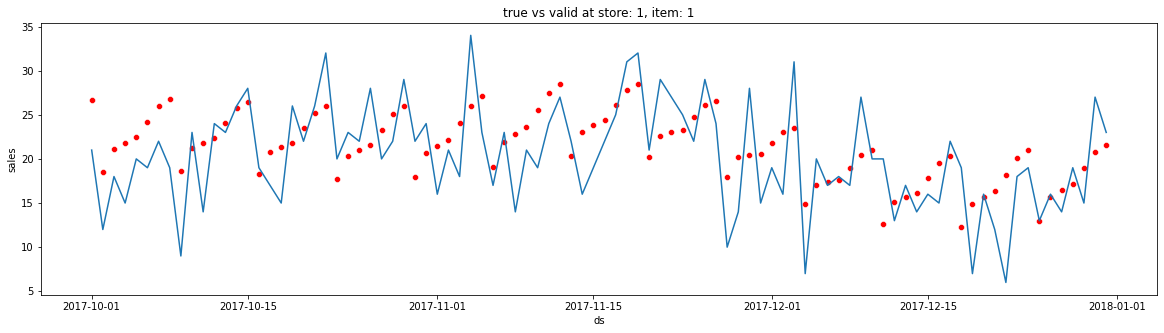

In [48]:
# 可視化
plt.figure(figsize=(20, 5))
sns.scatterplot(data=data_11, x="ds", y="pred_valid", color="red")
sns.lineplot(data=data_11, x="ds", y="y")
plt.title("true vs valid at store: 1, item: 1")
plt.ylabel("sales")
# plt.show()
plt.savefig("./figure/pred_store1_item1.jpg")

In [49]:
# 試しにstore=10, item=50を可視化
data_1050 = final_valid_df[(final_valid_df["store"] == 10) & (final_valid_df["item"] == 50)]
data_1050

,ds,store,item,y,year,month,pred_valid
45908,2017-10-01,10,50,99,2017,10,98.529905
45909,2017-10-02,10,50,71,2017,10,69.289963
45910,2017-10-03,10,50,77,2017,10,78.338997
45911,2017-10-04,10,50,87,2017,10,79.095822
45912,2017-10-05,10,50,78,2017,10,83.753265
...,...,...,...,...,...,...,...
45995,2017-12-27,10,50,63,2017,12,59.669808
45996,2017-12-28,10,50,59,2017,12,64.438430
45997,2017-12-29,10,50,74,2017,12,69.167275
45998,2017-12-30,10,50,62,2017,12,73.617903


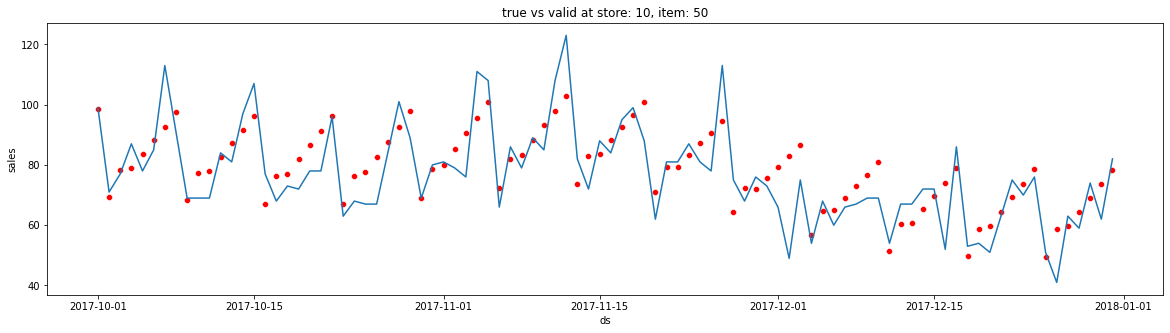

In [50]:
# 可視化
plt.figure(figsize=(20, 5))
sns.scatterplot(data=data_1050, x="ds", y="pred_valid", color="red")
sns.lineplot(data=data_1050, x="ds", y="y")
plt.title("true vs valid at store: 10, item: 50")
plt.ylabel("sales")
# plt.show()
plt.savefig("./figure/pred_store10_item50.jpg")

## 精度は悪いが、期間全体のトレンドや月ごとの季節性はつかめていると思う


In [51]:
# test_dataの期間を予測する関数
def prediction_test(item, store):
    model = Prophet(yearly_seasonality=True, weekly_seasonality=True)
    # データの準備
    data = train_df[train_df.store==store]
    data = data[data.item==item]
    # 学習
    model.fit(data)
    # 2018-01-01～2018-03-31までのデータフレームを作成
    future = model.make_future_dataframe(periods=90)
    # 予測
    forecast = model.predict(future)
    # 期間を2018年に絞る
    forecast_2018 = forecast[forecast["ds"].dt.year==2018]
    return forecast_2018[["ds", "yhat"]]

In [52]:
results_test = []
for store_id in range(1, 11):
    for item_id in range(1, 51):
        result_test = prediction_test(item_id, store_id)
        print(result_test)
        results_test.append(result_test["yhat"].values)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  12.982938
1827 2018-01-02  15.638185
1828 2018-01-03  16.281347
1829 2018-01-04  16.942351
1830 2018-01-05  18.491599
...         ...        ...
1911 2018-03-27  20.582544
1912 2018-03-28  21.259475
1913 2018-03-29  21.970626
1914 2018-03-30  23.586581
1915 2018-03-31  25.598929

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  36.696206
1827 2018-01-02  43.566252
1828 2018-01-03  44.414657
1829 2018-01-04  47.212823
1830 2018-01-05  50.560607
...         ...        ...
1911 2018-03-27  56.707005
1912 2018-03-28  57.872421
1913 2018-03-29  61.016642
1914 2018-03-30  64.735249
1915 2018-03-31  68.899448

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  22.228465
1827 2018-01-02  25.772753
1828 2018-01-03  26.366784
1829 2018-01-04  28.246180
1830 2018-01-05  30.958156
...         ...        ...
1911 2018-03-27  35.219180
1912 2018-03-28  35.899492
1913 2018-03-29  37.862810
1914 2018-03-30  40.657829
1915 2018-03-31  42.634287

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  13.120732
1827 2018-01-02  16.103722
1828 2018-01-03  16.118054
1829 2018-01-04  18.017502
1830 2018-01-05  18.369674
...         ...        ...
1911 2018-03-27  20.979362
1912 2018-03-28  21.109997
1913 2018-03-29  23.144699
1914 2018-03-30  23.650897
1915 2018-03-31  25.682447

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  10.829619
1827 2018-01-02  13.093865
1828 2018-01-03  13.435385
1829 2018-01-04  14.985306
1830 2018-01-05  15.328824
...         ...        ...
1911 2018-03-27  18.083949
1912 2018-03-28  18.460062
1913 2018-03-29  20.044273
1914 2018-03-30  20.422617
1915 2018-03-31  21.755865

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  35.704728
1827 2018-01-02  43.083068
1828 2018-01-03  43.459182
1829 2018-01-04  45.453668
1830 2018-01-05  49.773138
...         ...        ...
1911 2018-03-27  56.857787
1912 2018-03-28  57.465940
1913 2018-03-29  59.719938
1914 2018-03-30  64.324386
1915 2018-03-31  68.305268

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  33.434837
1827 2018-01-02  40.457702
1828 2018-01-03  40.574059
1829 2018-01-04  44.696134
1830 2018-01-05  47.285956
...         ...        ...
1911 2018-03-27  55.674937
1912 2018-03-28  56.142713
1913 2018-03-29  60.627379
1914 2018-03-30  63.586481
1915 2018-03-31  69.002061

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  47.520254
1827 2018-01-02  57.711163
1828 2018-01-03  57.445567
1829 2018-01-04  61.478813
1830 2018-01-05  66.666117
...         ...        ...
1911 2018-03-27  76.627155
1912 2018-03-28  76.705270
1913 2018-03-29  81.100976
1914 2018-03-30  86.667712
1915 2018-03-31  91.465762

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  28.727696
1827 2018-01-02  34.451024
1828 2018-01-03  34.914415
1829 2018-01-04  38.181096
1830 2018-01-05  40.497070
...         ...        ...
1911 2018-03-27  47.795025
1912 2018-03-28  48.412773
1913 2018-03-29  51.849641
1914 2018-03-30  54.351048
1915 2018-03-31  58.426219

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  46.221077
1827 2018-01-02  54.978006
1828 2018-01-03  55.556807
1829 2018-01-04  60.184951
1830 2018-01-05  64.776660
...         ...        ...
1911 2018-03-27  71.245645
1912 2018-03-28  71.938118
1913 2018-03-29  76.729835
1914 2018-03-30  81.536544
1915 2018-03-31  85.430852

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  43.624739
1827 2018-01-02  51.344257
1828 2018-01-03  52.136484
1829 2018-01-04  55.284283
1830 2018-01-05  59.550918
...         ...        ...
1911 2018-03-27  67.098638
1912 2018-03-28  68.273873
1913 2018-03-29  71.854341
1914 2018-03-30  76.597986
1915 2018-03-31  81.974504

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  42.348509
1827 2018-01-02  50.348209
1828 2018-01-03  51.063346
1829 2018-01-04  54.665851
1830 2018-01-05  59.135693
...         ...        ...
1911 2018-03-27  68.317369
1912 2018-03-28  69.375100
1913 2018-03-29  73.332250
1914 2018-03-30  78.165854
1915 2018-03-31  81.814373

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  50.791298
1827 2018-01-02  60.819030
1828 2018-01-03  60.743240
1829 2018-01-04  63.954121
1830 2018-01-05  70.087999
...         ...        ...
1911 2018-03-27  80.967396
1912 2018-03-28  81.210370
1913 2018-03-29  84.758997
1914 2018-03-30  91.246671
1915 2018-03-31  96.210801

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  36.706705
1827 2018-01-02  42.888234
1828 2018-01-03  43.193970
1829 2018-01-04  45.818660
1830 2018-01-05  48.512652
...         ...        ...
1911 2018-03-27  57.438101
1912 2018-03-28  58.066828
1913 2018-03-29  61.035695
1914 2018-03-30  64.093964
1915 2018-03-31  69.048158

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1826 2018-01-01   55.236651
1827 2018-01-02   65.711239
1828 2018-01-03   65.940501
1829 2018-01-04   71.118168
1830 2018-01-05   76.845578
...         ...         ...
1911 2018-03-27   85.135044
1912 2018-03-28   85.909640
1913 2018-03-29   91.691419
1914 2018-03-30   98.075223
1915 2018-03-31  102.862228

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  14.942166
1827 2018-01-02  18.188928
1828 2018-01-03  18.255919
1829 2018-01-04  19.817313
1830 2018-01-05  21.021039
...         ...        ...
1911 2018-03-27  25.200616
1912 2018-03-28  25.545000
1913 2018-03-29  27.386053
1914 2018-03-30  28.867923
1915 2018-03-31  31.556276

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  19.899823
1827 2018-01-02  23.070904
1828 2018-01-03  24.177004
1829 2018-01-04  25.176362
1830 2018-01-05  27.783535
...         ...        ...
1911 2018-03-27  30.285572
1912 2018-03-28  31.655706
1913 2018-03-29  32.939959
1914 2018-03-30  35.849431
1915 2018-03-31  37.765260

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  51.618031
1827 2018-01-02  62.392908
1828 2018-01-03  61.582790
1829 2018-01-04  66.693768
1830 2018-01-05  72.892762
...         ...        ...
1911 2018-03-27  80.787276
1912 2018-03-28  80.397125
1913 2018-03-29  85.970343
1914 2018-03-30  92.670768
1915 2018-03-31  98.148585

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  25.256568
1827 2018-01-02  29.942933
1828 2018-01-03  30.662994
1829 2018-01-04  31.897639
1830 2018-01-05  34.219138
...         ...        ...
1911 2018-03-27  39.423424
1912 2018-03-28  40.422466
1913 2018-03-29  41.943103
1914 2018-03-30  44.554220
1915 2018-03-31  48.127324

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  29.247173
1827 2018-01-02  34.729585
1828 2018-01-03  34.967010
1829 2018-01-04  37.281175
1830 2018-01-05  39.367158
...         ...        ...
1911 2018-03-27  47.431736
1912 2018-03-28  48.037884
1913 2018-03-29  50.717359
1914 2018-03-30  53.160873
1915 2018-03-31  57.139742

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  24.092709
1827 2018-01-02  29.401264
1828 2018-01-03  28.790151
1829 2018-01-04  32.374770
1830 2018-01-05  33.921597
...         ...        ...
1911 2018-03-27  39.493513
1912 2018-03-28  39.107766
1913 2018-03-29  42.927674
1914 2018-03-30  44.718800
1915 2018-03-31  47.373134

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  49.487915
1827 2018-01-02  59.001103
1828 2018-01-03  60.139950
1829 2018-01-04  64.011398
1830 2018-01-05  68.124833
...         ...        ...
1911 2018-03-27  76.371632
1912 2018-03-28  77.882324
1913 2018-03-29  82.186692
1914 2018-03-30  86.790930
1915 2018-03-31  92.970615

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  18.285872
1827 2018-01-02  22.029592
1828 2018-01-03  22.526794
1829 2018-01-04  23.715580
1830 2018-01-05  25.848303
...         ...        ...
1911 2018-03-27  28.969051
1912 2018-03-28  29.370553
1913 2018-03-29  30.483992
1914 2018-03-30  32.564718
1915 2018-03-31  34.910088

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  37.441842
1827 2018-01-02  45.729592
1828 2018-01-03  45.781524
1829 2018-01-04  49.465203
1830 2018-01-05  53.971162
...         ...        ...
1911 2018-03-27  63.096141
1912 2018-03-28  63.431276
1913 2018-03-29  67.391904
1914 2018-03-30  72.166856
1915 2018-03-31  76.052101

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  48.354491
1827 2018-01-02  58.707513
1828 2018-01-03  57.842733
1829 2018-01-04  62.428200
1830 2018-01-05  66.881152
...         ...        ...
1911 2018-03-27  76.729093
1912 2018-03-28  76.234638
1913 2018-03-29  81.232256
1914 2018-03-30  86.135575
1915 2018-03-31  91.399720

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  28.138827
1827 2018-01-02  34.671649
1828 2018-01-03  34.325562
1829 2018-01-04  37.424379
1830 2018-01-05  39.365524
...         ...        ...
1911 2018-03-27  47.462090
1912 2018-03-28  47.352186
1913 2018-03-29  50.705548
1914 2018-03-30  52.916457
1915 2018-03-31  57.279328

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  13.231742
1827 2018-01-02  16.413039
1828 2018-01-03  16.232494
1829 2018-01-04  17.586664
1830 2018-01-05  19.554137
...         ...        ...
1911 2018-03-27  21.016920
1912 2018-03-28  20.921902
1913 2018-03-29  22.391281
1914 2018-03-30  24.502236
1915 2018-03-31  24.748975

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1826 2018-01-01   54.535437
1827 2018-01-02   65.003239
1828 2018-01-03   64.882403
1829 2018-01-04   70.146812
1830 2018-01-05   74.901027
...         ...         ...
1911 2018-03-27   85.541313
1912 2018-03-28   85.940512
1913 2018-03-29   91.748670
1914 2018-03-30   97.065050
1915 2018-03-31  103.628598

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  43.558048
1827 2018-01-02  51.069827
1828 2018-01-03  51.876857
1829 2018-01-04  56.009745
1830 2018-01-05  59.271529
...         ...        ...
1911 2018-03-27  65.290628
1912 2018-03-28  66.376159
1913 2018-03-29  70.837945
1914 2018-03-30  74.475989
1915 2018-03-31  80.047844

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  24.922184
1827 2018-01-02  29.814566
1828 2018-01-03  29.792284
1829 2018-01-04  32.321722
1830 2018-01-05  34.640659
...         ...        ...
1911 2018-03-27  40.215292
1912 2018-03-28  40.170240
1913 2018-03-29  42.701445
1914 2018-03-30  45.048933
1915 2018-03-31  48.122697

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  34.591259
1827 2018-01-02  41.933301
1828 2018-01-03  42.196065
1829 2018-01-04  45.066691
1830 2018-01-05  48.617111
...         ...        ...
1911 2018-03-27  56.742202
1912 2018-03-28  57.329527
1913 2018-03-29  60.536367
1914 2018-03-30  64.431189
1915 2018-03-31  67.806065

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  27.357016
1827 2018-01-02  31.825526
1828 2018-01-03  31.975681
1829 2018-01-04  33.951940
1830 2018-01-05  37.100383
...         ...        ...
1911 2018-03-27  43.216584
1912 2018-03-28  43.627945
1913 2018-03-29  45.879522
1914 2018-03-30  49.316279
1915 2018-03-31  52.121947

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  44.301750
1827 2018-01-02  52.540737
1828 2018-01-03  52.437543
1829 2018-01-04  56.123982
1830 2018-01-05  60.771724
...         ...        ...
1911 2018-03-27  67.664505
1912 2018-03-28  67.878441
1913 2018-03-29  71.930476
1914 2018-03-30  76.988705
1915 2018-03-31  81.676673

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  15.924371
1827 2018-01-02  18.992755
1828 2018-01-03  19.050251
1829 2018-01-04  20.898756
1830 2018-01-05  22.170139
...         ...        ...
1911 2018-03-27  24.787696
1912 2018-03-28  24.902273
1913 2018-03-29  26.807857
1914 2018-03-30  28.137659
1915 2018-03-31  29.889136

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  39.934107
1827 2018-01-02  47.618368
1828 2018-01-03  47.769616
1829 2018-01-04  51.513144
1830 2018-01-05  55.527871
...         ...        ...
1911 2018-03-27  62.918679
1912 2018-03-28  63.404432
1913 2018-03-29  67.490368
1914 2018-03-30  71.853261
1915 2018-03-31  76.338479

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  46.814519
1827 2018-01-02  55.545206
1828 2018-01-03  55.672837
1829 2018-01-04  60.095843
1830 2018-01-05  65.389295
...         ...        ...
1911 2018-03-27  72.685968
1912 2018-03-28  73.139686
1913 2018-03-29  77.951143
1914 2018-03-30  83.691373
1915 2018-03-31  88.394127

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  16.993774
1827 2018-01-02  20.718542
1828 2018-01-03  20.638917
1829 2018-01-04  22.610487
1830 2018-01-05  24.109243
...         ...        ...
1911 2018-03-27  27.743963
1912 2018-03-28  27.873578
1913 2018-03-29  30.055699
1914 2018-03-30  31.763254
1915 2018-03-31  33.526621

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  49.824654
1827 2018-01-02  58.379270
1828 2018-01-03  59.620793
1829 2018-01-04  64.141854
1830 2018-01-05  69.347233
...         ...        ...
1911 2018-03-27  79.051782
1912 2018-03-28  80.760301
1913 2018-03-29  85.745027
1914 2018-03-30  91.405305
1915 2018-03-31  95.753469

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  26.254523
1827 2018-01-02  31.646910
1828 2018-01-03  32.245441
1829 2018-01-04  33.962836
1830 2018-01-05  36.523774
...         ...        ...
1911 2018-03-27  41.985476
1912 2018-03-28  42.964085
1913 2018-03-29  45.086184
1914 2018-03-30  48.070344
1915 2018-03-31  51.316548

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  18.164628
1827 2018-01-02  21.343780
1828 2018-01-03  21.943814
1829 2018-01-04  23.889843
1830 2018-01-05  24.688180
...         ...        ...
1911 2018-03-27  28.033351
1912 2018-03-28  28.835553
1913 2018-03-29  30.987971
1914 2018-03-30  31.994535
1915 2018-03-31  34.830441

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  14.137796
1827 2018-01-02  16.716581
1828 2018-01-03  16.762423
1829 2018-01-04  17.621402
1830 2018-01-05  19.247664
...         ...        ...
1911 2018-03-27  21.241142
1912 2018-03-28  21.498142
1913 2018-03-29  22.591721
1914 2018-03-30  24.472966
1915 2018-03-31  26.276779

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  21.053245
1827 2018-01-02  24.890648
1828 2018-01-03  25.642848
1829 2018-01-04  27.347455
1830 2018-01-05  29.387076
...         ...        ...
1911 2018-03-27  35.533028
1912 2018-03-28  36.484893
1913 2018-03-29  38.373345
1914 2018-03-30  40.579285
1915 2018-03-31  42.824774

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  32.404479
1827 2018-01-02  37.241916
1828 2018-01-03  38.224006
1829 2018-01-04  40.633628
1830 2018-01-05  43.534765
...         ...        ...
1911 2018-03-27  47.599616
1912 2018-03-28  48.923626
1913 2018-03-29  51.726603
1914 2018-03-30  55.069629
1915 2018-03-31  58.484317

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  18.863362
1827 2018-01-02  22.473948
1828 2018-01-03  22.251128
1829 2018-01-04  24.511041
1830 2018-01-05  25.765111
...         ...        ...
1911 2018-03-27  29.825254
1912 2018-03-28  29.791830
1913 2018-03-29  32.248783
1914 2018-03-30  33.703978
1915 2018-03-31  35.783915

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  48.376347
1827 2018-01-02  57.899265
1828 2018-01-03  58.128009
1829 2018-01-04  61.910469
1830 2018-01-05  67.432466
...         ...        ...
1911 2018-03-27  76.637774
1912 2018-03-28  77.123141
1913 2018-03-29  81.179437
1914 2018-03-30  86.991199
1915 2018-03-31  91.348386

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  35.962605
1827 2018-01-02  42.612342
1828 2018-01-03  43.214631
1829 2018-01-04  47.001509
1830 2018-01-05  50.545017
...         ...        ...
1911 2018-03-27  55.977319
1912 2018-03-28  56.900466
1913 2018-03-29  61.025750
1914 2018-03-30  64.921176
1915 2018-03-31  68.043533

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  13.661195
1827 2018-01-02  16.240171
1828 2018-01-03  16.478409
1829 2018-01-04  17.709784
1830 2018-01-05  18.644675
...         ...        ...
1911 2018-03-27  21.498178
1912 2018-03-28  21.800034
1913 2018-03-29  23.103777
1914 2018-03-30  24.118823
1915 2018-03-31  25.393507

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  31.275440
1827 2018-01-02  37.844088
1828 2018-01-03  37.232794
1829 2018-01-04  40.530611
1830 2018-01-05  44.003784
...         ...        ...
1911 2018-03-27  51.110126
1912 2018-03-28  50.616683
1913 2018-03-29  54.045296
1914 2018-03-30  57.661400
1915 2018-03-31  60.197673

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  18.441829
1827 2018-01-02  21.502767
1828 2018-01-03  21.171326
1829 2018-01-04  23.978543
1830 2018-01-05  24.635326
...         ...        ...
1911 2018-03-27  28.234925
1912 2018-03-28  28.156161
1913 2018-03-29  31.228700
1914 2018-03-30  32.159706
1915 2018-03-31  34.292099

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  39.437175
1827 2018-01-02  47.254415
1828 2018-01-03  48.130712
1829 2018-01-04  51.233841
1830 2018-01-05  54.757488
...         ...        ...
1911 2018-03-27  62.872224
1912 2018-03-28  64.043897
1913 2018-03-29  67.461098
1914 2018-03-30  71.316041
1915 2018-03-31  76.501849

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  19.931494
1827 2018-01-02  23.017190
1828 2018-01-03  22.612814
1829 2018-01-04  25.157950
1830 2018-01-05  27.607691
...         ...        ...
1911 2018-03-27  29.773692
1912 2018-03-28  29.510260
1913 2018-03-29  32.215657
1914 2018-03-30  34.843426
1915 2018-03-31  36.442825

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  48.157111
1827 2018-01-02  58.586178
1828 2018-01-03  58.721786
1829 2018-01-04  63.432750
1830 2018-01-05  68.550511
...         ...        ...
1911 2018-03-27  78.418707
1912 2018-03-28  79.046339
1913 2018-03-29  84.282332
1914 2018-03-30  89.953112
1915 2018-03-31  93.972520

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  32.254468
1827 2018-01-02  37.966104
1828 2018-01-03  38.752514
1829 2018-01-04  41.420182
1830 2018-01-05  45.339313
...         ...        ...
1911 2018-03-27  49.318031
1912 2018-03-28  50.260822
1913 2018-03-29  53.124769
1914 2018-03-30  57.278991
1915 2018-03-31  60.685692

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  19.201060
1827 2018-01-02  22.564805
1828 2018-01-03  22.408236
1829 2018-01-04  23.619448
1830 2018-01-05  26.008464
...         ...        ...
1911 2018-03-27  30.542685
1912 2018-03-28  30.573368
1913 2018-03-29  31.977965
1914 2018-03-30  34.564505
1915 2018-03-31  35.991444

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  14.683180
1827 2018-01-02  18.521686
1828 2018-01-03  18.725515
1829 2018-01-04  20.352882
1830 2018-01-05  22.207958
...         ...        ...
1911 2018-03-27  25.403961
1912 2018-03-28  25.642745
1913 2018-03-29  27.298791
1914 2018-03-30  29.177213
1915 2018-03-31  30.661638

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  48.528658
1827 2018-01-02  58.342481
1828 2018-01-03  58.287743
1829 2018-01-04  62.934505
1830 2018-01-05  67.804931
...         ...        ...
1911 2018-03-27  77.480583
1912 2018-03-28  77.842628
1913 2018-03-29  82.949725
1914 2018-03-30  88.319588
1915 2018-03-31  93.905758

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  50.801331
1827 2018-01-02  60.880974
1828 2018-01-03  61.637901
1829 2018-01-04  65.172439
1830 2018-01-05  69.965983
...         ...        ...
1911 2018-03-27  82.032953
1912 2018-03-28  83.297876
1913 2018-03-29  87.366066
1914 2018-03-30  92.710976
1915 2018-03-31  99.794371

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1826 2018-01-01   66.418290
1827 2018-01-02   79.441882
1828 2018-01-03   79.070680
1829 2018-01-04   85.814404
1830 2018-01-05   92.969929
...         ...         ...
1911 2018-03-27  105.731100
1912 2018-03-28  105.821682
1913 2018-03-29  113.044307
1914 2018-03-30  120.694199
1915 2018-03-31  126.951485

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  41.737637
1827 2018-01-02  50.490011
1828 2018-01-03  50.023877
1829 2018-01-04  54.701394
1830 2018-01-05  59.157440
...         ...        ...
1911 2018-03-27  70.473036
1912 2018-03-28  70.376460
1913 2018-03-29  75.437706
1914 2018-03-30  80.288654
1915 2018-03-31  84.323554

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1826 2018-01-01   63.600373
1827 2018-01-02   76.027919
1828 2018-01-03   78.251530
1829 2018-01-04   83.486356
1830 2018-01-05   89.816654
...         ...         ...
1911 2018-03-27   99.452449
1912 2018-03-28  101.968278
1913 2018-03-29  107.552345
1914 2018-03-30  114.288102
1915 2018-03-31  120.810162

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1826 2018-01-01   60.273838
1827 2018-01-02   71.763897
1828 2018-01-03   71.448448
1829 2018-01-04   77.296105
1830 2018-01-05   83.618367
...         ...         ...
1911 2018-03-27   95.756363
1912 2018-03-28   95.980351
1913 2018-03-29  102.413644
1914 2018-03-30  109.361382
1915 2018-03-31  114.453736

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1826 2018-01-01   60.380227
1827 2018-01-02   70.659196
1828 2018-01-03   71.339309
1829 2018-01-04   77.731138
1830 2018-01-05   81.666877
...         ...         ...
1911 2018-03-27   94.358615
1912 2018-03-28   95.887876
1913 2018-03-29  103.166844
1914 2018-03-30  108.015554
1915 2018-03-31  115.318526

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1826 2018-01-01   69.574838
1827 2018-01-02   84.022468
1828 2018-01-03   85.388930
1829 2018-01-04   91.967247
1830 2018-01-05   98.728257
...         ...         ...
1911 2018-03-27  113.637667
1912 2018-03-28  115.255453
1913 2018-03-29  122.133043
1914 2018-03-30  129.243037
1915 2018-03-31  137.051463

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  51.445803
1827 2018-01-02  60.862742
1828 2018-01-03  60.376518
1829 2018-01-04  65.505785
1830 2018-01-05  69.753687
...         ...        ...
1911 2018-03-27  80.525737
1912 2018-03-28  80.683020
1913 2018-03-29  86.480986
1914 2018-03-30  91.413991
1915 2018-03-31  97.293917

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1826 2018-01-01   75.282502
1827 2018-01-02   90.212841
1828 2018-01-03   90.277808
1829 2018-01-04   98.703879
1830 2018-01-05  104.749072
...         ...         ...
1911 2018-03-27  118.782775
1912 2018-03-28  119.362566
1913 2018-03-29  128.377262
1914 2018-03-30  135.079212
1915 2018-03-31  144.091547

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  21.748648
1827 2018-01-02  26.886973
1828 2018-01-03  26.357098
1829 2018-01-04  28.121417
1830 2018-01-05  30.605620
...         ...        ...
1911 2018-03-27  34.954961
1912 2018-03-28  34.506157
1913 2018-03-29  36.377497
1914 2018-03-30  38.994025
1915 2018-03-31  41.408642

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  27.930886
1827 2018-01-02  33.320018
1828 2018-01-03  33.347232
1829 2018-01-04  36.463785
1830 2018-01-05  39.063556
...         ...        ...
1911 2018-03-27  44.391999
1912 2018-03-28  44.760102
1913 2018-03-29  48.232088
1914 2018-03-30  51.197030
1915 2018-03-31  54.576291

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1826 2018-01-01   72.075626
1827 2018-01-02   86.175427
1828 2018-01-03   86.857763
1829 2018-01-04   94.061351
1830 2018-01-05  100.412926
...         ...         ...
1911 2018-03-27  118.025995
1912 2018-03-28  119.263429
1913 2018-03-29  127.026617
1914 2018-03-30  133.936926
1915 2018-03-31  141.259234

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  35.181025
1827 2018-01-02  41.983420
1828 2018-01-03  42.046018
1829 2018-01-04  46.567256
1830 2018-01-05  49.005678
...         ...        ...
1911 2018-03-27  55.770574
1912 2018-03-28  56.069983
1913 2018-03-29  60.864799
1914 2018-03-30  63.610485
1915 2018-03-31  67.053267

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  40.910527
1827 2018-01-02  48.077258
1828 2018-01-03  48.298641
1829 2018-01-04  52.681675
1830 2018-01-05  56.822745
...         ...        ...
1911 2018-03-27  64.545879
1912 2018-03-28  65.068114
1913 2018-03-29  69.796685
1914 2018-03-30  74.325276
1915 2018-03-31  78.760415

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  34.190217
1827 2018-01-02  40.829810
1828 2018-01-03  41.270750
1829 2018-01-04  44.281669
1830 2018-01-05  47.168683
...         ...        ...
1911 2018-03-27  55.423688
1912 2018-03-28  56.097562
1913 2018-03-29  59.362236
1914 2018-03-30  62.523373
1915 2018-03-31  67.530150

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1826 2018-01-01   67.711939
1827 2018-01-02   81.279435
1828 2018-01-03   80.326912
1829 2018-01-04   87.911570
1830 2018-01-05   94.245908
...         ...         ...
1911 2018-03-27  110.379124
1912 2018-03-28  109.920348
1913 2018-03-29  118.003366
1914 2018-03-30  124.837541
1915 2018-03-31  132.161158

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  24.821832
1827 2018-01-02  30.324818
1828 2018-01-03  31.404762
1829 2018-01-04  33.297875
1830 2018-01-05  35.544339
...         ...        ...
1911 2018-03-27  40.930335
1912 2018-03-28  42.109340
1913 2018-03-29  44.101481
1914 2018-03-30  46.447484
1915 2018-03-31  48.661332

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1826 2018-01-01   56.442860
1827 2018-01-02   67.460922
1828 2018-01-03   67.846924
1829 2018-01-04   73.265017
1830 2018-01-05   78.839503
...         ...         ...
1911 2018-03-27   92.148952
1912 2018-03-28   92.949236
1913 2018-03-29   98.794803
1914 2018-03-30  104.806951
1915 2018-03-31  110.228942

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1826 2018-01-01   67.003138
1827 2018-01-02   81.946872
1828 2018-01-03   82.476425
1829 2018-01-04   89.764818
1830 2018-01-05   96.293154
...         ...         ...
1911 2018-03-27  109.043252
1912 2018-03-28  110.182863
1913 2018-03-29  118.133399
1914 2018-03-30  125.371149
1915 2018-03-31  132.326028

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  41.400279
1827 2018-01-02  50.064188
1828 2018-01-03  49.757731
1829 2018-01-04  53.934945
1830 2018-01-05  57.810549
...         ...        ...
1911 2018-03-27  64.593734
1912 2018-03-28  64.490395
1913 2018-03-29  68.927681
1914 2018-03-30  73.117945
1915 2018-03-31  78.598138

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  19.599383
1827 2018-01-02  23.606352
1828 2018-01-03  23.114598
1829 2018-01-04  25.291835
1830 2018-01-05  26.791665
...         ...        ...
1911 2018-03-27  30.559558
1912 2018-03-28  30.159518
1913 2018-03-29  32.445439
1914 2018-03-30  34.070569
1915 2018-03-31  36.365071

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1826 2018-01-01   75.133445
1827 2018-01-02   89.557375
1828 2018-01-03   90.265931
1829 2018-01-04   97.769559
1830 2018-01-05  105.358704
...         ...         ...
1911 2018-03-27  120.895232
1912 2018-03-28  122.051728
1913 2018-03-29  130.043126
1914 2018-03-30  138.158458
1915 2018-03-31  145.625465

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1826 2018-01-01   60.875678
1827 2018-01-02   71.414921
1828 2018-01-03   72.128664
1829 2018-01-04   77.391295
1830 2018-01-05   82.765182
...         ...         ...
1911 2018-03-27   95.195818
1912 2018-03-28   96.537774
1913 2018-03-29  102.468053
1914 2018-03-30  108.540966
1915 2018-03-31  114.784931

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  35.667529
1827 2018-01-02  41.884063
1828 2018-01-03  42.121890
1829 2018-01-04  45.743878
1830 2018-01-05  49.770387
...         ...        ...
1911 2018-03-27  54.703746
1912 2018-03-28  55.345422
1913 2018-03-29  59.411893
1914 2018-03-30  63.917839
1915 2018-03-31  66.582564

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  50.642276
1827 2018-01-02  60.029146
1828 2018-01-03  59.803990
1829 2018-01-04  64.250927
1830 2018-01-05  68.708276
...         ...        ...
1911 2018-03-27  79.557620
1912 2018-03-28  79.898616
1913 2018-03-29  84.951218
1914 2018-03-30  90.047269
1915 2018-03-31  95.966124

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  38.652441
1827 2018-01-02  46.067736
1828 2018-01-03  47.019210
1829 2018-01-04  49.927380
1830 2018-01-05  53.492383
...         ...        ...
1911 2018-03-27  61.816682
1912 2018-03-28  63.138395
1913 2018-03-29  66.414465
1914 2018-03-30  70.343242
1915 2018-03-31  74.148095

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1826 2018-01-01   56.903423
1827 2018-01-02   68.933070
1828 2018-01-03   68.164758
1829 2018-01-04   73.807167
1830 2018-01-05   80.418089
...         ...         ...
1911 2018-03-27   92.724924
1912 2018-03-28   92.470505
1913 2018-03-29   98.644426
1914 2018-03-30  105.800387
1915 2018-03-31  111.993691

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  22.857102
1827 2018-01-02  27.909571
1828 2018-01-03  27.928119
1829 2018-01-04  29.757041
1830 2018-01-05  31.670211
...         ...        ...
1911 2018-03-27  35.623774
1912 2018-03-28  35.793203
1913 2018-03-29  37.793763
1914 2018-03-30  39.898665
1915 2018-03-31  42.093561

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1826 2018-01-01   56.751439
1827 2018-01-02   68.652170
1828 2018-01-03   69.150768
1829 2018-01-04   73.468455
1830 2018-01-05   79.460054
...         ...         ...
1911 2018-03-27   89.641881
1912 2018-03-28   90.615657
1913 2018-03-29   95.484694
1914 2018-03-30  102.097397
1915 2018-03-31  109.672876

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1826 2018-01-01   65.952047
1827 2018-01-02   79.780223
1828 2018-01-03   78.928312
1829 2018-01-04   85.623144
1830 2018-01-05   91.478819
...         ...         ...
1911 2018-03-27  105.927122
1912 2018-03-28  105.663043
1913 2018-03-29  112.997059
1914 2018-03-30  119.538467
1915 2018-03-31  126.696721

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  27.323132
1827 2018-01-02  31.333143
1828 2018-01-03  31.043737
1829 2018-01-04  33.679455
1830 2018-01-05  34.798259
...         ...        ...
1911 2018-03-27  39.914981
1912 2018-03-28  39.717734
1913 2018-03-29  42.483319
1914 2018-03-30  43.770035
1915 2018-03-31  47.250588

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1826 2018-01-01   69.528319
1827 2018-01-02   83.828243
1828 2018-01-03   83.652536
1829 2018-01-04   90.870199
1830 2018-01-05   97.468125
...         ...         ...
1911 2018-03-27  111.019309
1912 2018-03-28  111.137359
1913 2018-03-29  118.693244
1914 2018-03-30  125.673511
1915 2018-03-31  132.934123

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  35.827399
1827 2018-01-02  44.100725
1828 2018-01-03  43.624371
1829 2018-01-04  46.905860
1830 2018-01-05  51.065477
...         ...        ...
1911 2018-03-27  59.015471
1912 2018-03-28  58.757411
1913 2018-03-29  62.278606
1914 2018-03-30  66.699264
1915 2018-03-31  71.403740

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  26.739591
1827 2018-01-02  30.646035
1828 2018-01-03  31.685881
1829 2018-01-04  33.305239
1830 2018-01-05  36.777601
...         ...        ...
1911 2018-03-27  39.963514
1912 2018-03-28  41.106648
1913 2018-03-29  42.854816
1914 2018-03-30  46.482421
1915 2018-03-31  47.781289

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  19.337171
1827 2018-01-02  23.198572
1828 2018-01-03  23.301884
1829 2018-01-04  25.246746
1830 2018-01-05  26.941246
...         ...        ...
1911 2018-03-27  30.329989
1912 2018-03-28  30.518303
1913 2018-03-29  32.563338
1914 2018-03-30  34.372887
1915 2018-03-31  35.689792

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  31.850358
1827 2018-01-02  37.773265
1828 2018-01-03  37.496492
1829 2018-01-04  40.966173
1830 2018-01-05  44.005963
...         ...        ...
1911 2018-03-27  50.558226
1912 2018-03-28  50.566035
1913 2018-03-29  54.346668
1914 2018-03-30  57.720756
1915 2018-03-31  61.133062

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  45.498107
1827 2018-01-02  52.889046
1828 2018-01-03  53.797830
1829 2018-01-04  58.232838
1830 2018-01-05  62.558002
...         ...        ...
1911 2018-03-27  69.537511
1912 2018-03-28  70.735656
1913 2018-03-29  75.487168
1914 2018-03-30  80.154902
1915 2018-03-31  84.201042

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  25.200918
1827 2018-01-02  30.091267
1828 2018-01-03  30.368449
1829 2018-01-04  32.144429
1830 2018-01-05  34.165212
...         ...        ...
1911 2018-03-27  39.862663
1912 2018-03-28  40.310306
1913 2018-03-29  42.273705
1914 2018-03-30  44.497891
1915 2018-03-31  48.256233

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1826 2018-01-01   68.729865
1827 2018-01-02   83.455084
1828 2018-01-03   83.767507
1829 2018-01-04   89.469329
1830 2018-01-05   97.010475
...         ...         ...
1911 2018-03-27  110.159345
1912 2018-03-28  110.994486
1913 2018-03-29  117.262778
1914 2018-03-30  125.408489
1915 2018-03-31  133.097198

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  50.889926
1827 2018-01-02  60.775399
1828 2018-01-03  59.877775
1829 2018-01-04  64.749751
1830 2018-01-05  70.823429
...         ...        ...
1911 2018-03-27  78.835143
1912 2018-03-28  78.413658
1913 2018-03-29  83.806983
1914 2018-03-30  90.440648
1915 2018-03-31  94.754780

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  19.130034
1827 2018-01-02  22.679942
1828 2018-01-03  22.783578
1829 2018-01-04  24.007125
1830 2018-01-05  26.157759
...         ...        ...
1911 2018-03-27  29.391137
1912 2018-03-28  29.701058
1913 2018-03-29  31.150296
1914 2018-03-30  33.543131
1915 2018-03-31  35.963205

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  44.172027
1827 2018-01-02  52.138406
1828 2018-01-03  52.927485
1829 2018-01-04  57.180969
1830 2018-01-05  62.265500
...         ...        ...
1911 2018-03-27  69.689698
1912 2018-03-28  70.942489
1913 2018-03-29  75.710630
1914 2018-03-30  81.356053
1915 2018-03-31  84.906431

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  25.404635
1827 2018-01-02  29.821569
1828 2018-01-03  30.040558
1829 2018-01-04  32.402360
1830 2018-01-05  35.253508
...         ...        ...
1911 2018-03-27  39.043529
1912 2018-03-28  39.491531
1913 2018-03-29  42.099644
1914 2018-03-30  45.211788
1915 2018-03-31  48.394000

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1826 2018-01-01   57.382118
1827 2018-01-02   68.269053
1828 2018-01-03   68.113466
1829 2018-01-04   74.498416
1830 2018-01-05   78.676190
...         ...         ...
1911 2018-03-27   89.069154
1912 2018-03-28   89.428975
1913 2018-03-29   96.387898
1914 2018-03-30  101.192410
1915 2018-03-31  107.161016

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  16.773382
1827 2018-01-02  20.247490
1828 2018-01-03  20.135002
1829 2018-01-04  21.562772
1830 2018-01-05  22.987967
...         ...        ...
1911 2018-03-27  27.726045
1912 2018-03-28  27.828027
1913 2018-03-29  29.464781
1914 2018-03-30  31.091239
1915 2018-03-31  33.863346

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  44.629189
1827 2018-01-02  54.888662
1828 2018-01-03  53.420317
1829 2018-01-04  58.505326
1830 2018-01-05  62.479150
...         ...        ...
1911 2018-03-27  71.819946
1912 2018-03-28  70.688786
1913 2018-03-29  76.163006
1914 2018-03-30  80.575954
1915 2018-03-31  85.030468

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  28.379746
1827 2018-01-02  34.367403
1828 2018-01-03  34.003659
1829 2018-01-04  35.648531
1830 2018-01-05  38.946849
...         ...        ...
1911 2018-03-27  45.837643
1912 2018-03-28  45.799271
1913 2018-03-29  47.767805
1914 2018-03-30  51.385006
1915 2018-03-31  54.580011

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  16.666329
1827 2018-01-02  19.551976
1828 2018-01-03  19.957205
1829 2018-01-04  21.339667
1830 2018-01-05  23.807593
...         ...        ...
1911 2018-03-27  26.518118
1912 2018-03-28  26.959729
1913 2018-03-29  28.396006
1914 2018-03-30  30.935634
1915 2018-03-31  32.066300

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  14.208182
1827 2018-01-02  17.101307
1828 2018-01-03  17.338790
1829 2018-01-04  18.508214
1830 2018-01-05  19.705214
...         ...        ...
1911 2018-03-27  22.681972
1912 2018-03-28  23.025787
1913 2018-03-29  24.310327
1914 2018-03-30  25.630231
1915 2018-03-31  27.590083

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  42.186500
1827 2018-01-02  51.266345
1828 2018-01-03  51.778741
1829 2018-01-04  55.417350
1830 2018-01-05  59.802186
...         ...        ...
1911 2018-03-27  70.207874
1912 2018-03-28  71.127243
1913 2018-03-29  75.184723
1914 2018-03-30  79.996862
1915 2018-03-31  85.620437

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  43.852627
1827 2018-01-02  53.291927
1828 2018-01-03  52.575898
1829 2018-01-04  58.108710
1830 2018-01-05  62.899813
...         ...        ...
1911 2018-03-27  70.894065
1912 2018-03-28  70.476637
1913 2018-03-29  76.343401
1914 2018-03-30  81.501487
1915 2018-03-31  85.160353

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1826 2018-01-01   58.215826
1827 2018-01-02   69.629534
1828 2018-01-03   69.259842
1829 2018-01-04   75.089021
1830 2018-01-05   80.329671
...         ...         ...
1911 2018-03-27   90.931703
1912 2018-03-28   91.240256
1913 2018-03-29   97.804749
1914 2018-03-30  103.830146
1915 2018-03-31  112.191012

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  39.554555
1827 2018-01-02  46.004694
1828 2018-01-03  46.115879
1829 2018-01-04  49.261682
1830 2018-01-05  53.391143
...         ...        ...
1911 2018-03-27  61.497989
1912 2018-03-28  61.930168
1913 2018-03-29  65.439174
1914 2018-03-30  69.970161
1915 2018-03-31  73.812060

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1826 2018-01-01   54.441101
1827 2018-01-02   64.879036
1828 2018-01-03   65.318821
1829 2018-01-04   70.046230
1830 2018-01-05   76.505280
...         ...         ...
1911 2018-03-27   89.419543
1912 2018-03-28   90.213175
1913 2018-03-29   95.319100
1914 2018-03-30  102.177494
1915 2018-03-31  107.775635

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1826 2018-01-01   54.761234
1827 2018-01-02   65.448051
1828 2018-01-03   66.270709
1829 2018-01-04   70.678273
1830 2018-01-05   75.033817
...         ...         ...
1911 2018-03-27   84.992565
1912 2018-03-28   86.265572
1913 2018-03-29   91.180173
1914 2018-03-30   96.095499
1915 2018-03-31  102.584886

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1826 2018-01-01   51.976253
1827 2018-01-02   61.648386
1828 2018-01-03   61.859509
1829 2018-01-04   66.777784
1830 2018-01-05   71.332059
...         ...         ...
1911 2018-03-27   83.028591
1912 2018-03-28   83.839562
1913 2018-03-29   89.378881
1914 2018-03-30   94.568202
1915 2018-03-31  102.041177

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1826 2018-01-01   65.705323
1827 2018-01-02   79.104533
1828 2018-01-03   78.833398
1829 2018-01-04   84.209238
1830 2018-01-05   91.368069
...         ...         ...
1911 2018-03-27  103.515700
1912 2018-03-28  103.767369
1913 2018-03-29  109.713316
1914 2018-03-30  117.484064
1915 2018-03-31  123.328271

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  45.873219
1827 2018-01-02  54.435973
1828 2018-01-03  55.230208
1829 2018-01-04  60.311928
1830 2018-01-05  63.624475
...         ...        ...
1911 2018-03-27  71.177130
1912 2018-03-28  72.094156
1913 2018-03-29  77.338594
1914 2018-03-30  80.856505
1915 2018-03-31  86.283436

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1826 2018-01-01   66.932525
1827 2018-01-02   78.907934
1828 2018-01-03   80.456577
1829 2018-01-04   85.318869
1830 2018-01-05   92.552802
...         ...         ...
1911 2018-03-27  106.150464
1912 2018-03-28  107.990002
1913 2018-03-29  113.200265
1914 2018-03-30  120.837826
1915 2018-03-31  127.778576

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  20.083824
1827 2018-01-02  23.590754
1828 2018-01-03  24.284023
1829 2018-01-04  26.207739
1830 2018-01-05  27.798843
...         ...        ...
1911 2018-03-27  30.912512
1912 2018-03-28  31.718596
1913 2018-03-29  33.758848
1914 2018-03-30  35.470459
1915 2018-03-31  37.754448

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  25.371149
1827 2018-01-02  30.417398
1828 2018-01-03  30.627499
1829 2018-01-04  33.027043
1830 2018-01-05  34.721701
...         ...        ...
1911 2018-03-27  40.651688
1912 2018-03-28  41.196221
1913 2018-03-29  43.944636
1914 2018-03-30  45.998646
1915 2018-03-31  48.375431

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1826 2018-01-01   62.780984
1827 2018-01-02   75.143410
1828 2018-01-03   75.888531
1829 2018-01-04   81.379315
1830 2018-01-05   87.560444
...         ...         ...
1911 2018-03-27  100.598492
1912 2018-03-28  102.001887
1913 2018-03-29  108.214403
1914 2018-03-30  115.172354
1915 2018-03-31  121.125268

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  30.610770
1827 2018-01-02  36.157269
1828 2018-01-03  36.633097
1829 2018-01-04  39.400629
1830 2018-01-05  42.300358
...         ...        ...
1911 2018-03-27  48.758325
1912 2018-03-28  49.420700
1913 2018-03-29  52.394759
1914 2018-03-30  55.519902
1915 2018-03-31  59.405652

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  38.611661
1827 2018-01-02  45.787745
1828 2018-01-03  45.521564
1829 2018-01-04  49.944044
1830 2018-01-05  52.899550
...         ...        ...
1911 2018-03-27  58.672697
1912 2018-03-28  58.726282
1913 2018-03-29  63.497956
1914 2018-03-30  66.826672
1915 2018-03-31  70.343742

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  31.838592
1827 2018-01-02  38.348402
1828 2018-01-03  37.866352
1829 2018-01-04  41.348174
1830 2018-01-05  43.645628
...         ...        ...
1911 2018-03-27  51.038350
1912 2018-03-28  50.793676
1913 2018-03-29  54.514126
1914 2018-03-30  57.050246
1915 2018-03-31  61.191358

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1826 2018-01-01   59.973576
1827 2018-01-02   72.229899
1828 2018-01-03   72.471399
1829 2018-01-04   76.701054
1830 2018-01-05   84.904615
...         ...         ...
1911 2018-03-27   95.010044
1912 2018-03-28   95.626644
1913 2018-03-29  100.292819
1914 2018-03-30  108.993230
1915 2018-03-31  114.757797

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  22.032641
1827 2018-01-02  26.633227
1828 2018-01-03  27.085691
1829 2018-01-04  28.733919
1830 2018-01-05  31.216668
...         ...        ...
1911 2018-03-27  36.698033
1912 2018-03-28  37.287958
1913 2018-03-29  39.070902
1914 2018-03-30  41.685334
1915 2018-03-31  44.091778

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  50.299020
1827 2018-01-02  61.152312
1828 2018-01-03  60.466149
1829 2018-01-04  66.002186
1830 2018-01-05  71.041871
...         ...        ...
1911 2018-03-27  80.957063
1912 2018-03-28  80.536672
1913 2018-03-29  86.357215
1914 2018-03-30  91.698205
1915 2018-03-31  97.448009

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1826 2018-01-01   62.956144
1827 2018-01-02   74.530890
1828 2018-01-03   76.154326
1829 2018-01-04   81.915278
1830 2018-01-05   87.020885
...         ...         ...
1911 2018-03-27   96.611033
1912 2018-03-28   98.588059
1913 2018-03-29  104.759084
1914 2018-03-30  110.329930
1915 2018-03-31  117.762450

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  34.795504
1827 2018-01-02  41.512401
1828 2018-01-03  41.963521
1829 2018-01-04  45.930893
1830 2018-01-05  48.943854
...         ...        ...
1911 2018-03-27  57.748647
1912 2018-03-28  58.379644
1913 2018-03-29  62.508361
1914 2018-03-30  65.664013
1915 2018-03-31  69.689658

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  16.279758
1827 2018-01-02  19.544895
1828 2018-01-03  19.507927
1829 2018-01-04  21.167506
1830 2018-01-05  22.737188
...         ...        ...
1911 2018-03-27  25.821613
1912 2018-03-28  26.023101
1913 2018-03-29  27.940838
1914 2018-03-30  29.783986
1915 2018-03-31  31.634594

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1826 2018-01-01   66.663028
1827 2018-01-02   80.343068
1828 2018-01-03   80.777911
1829 2018-01-04   87.602894
1830 2018-01-05   93.187218
...         ...         ...
1911 2018-03-27  107.799185
1912 2018-03-28  108.830119
1913 2018-03-29  116.284054
1914 2018-03-30  122.523631
1915 2018-03-31  130.585471

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1826 2018-01-01   53.314876
1827 2018-01-02   64.878316
1828 2018-01-03   64.670753
1829 2018-01-04   69.085338
1830 2018-01-05   74.223635
...         ...         ...
1911 2018-03-27   86.059087
1912 2018-03-28   86.466217
1913 2018-03-29   91.541577
1914 2018-03-30   97.378140
1915 2018-03-31  102.393840

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  32.215570
1827 2018-01-02  38.072307
1828 2018-01-03  38.435569
1829 2018-01-04  40.185887
1830 2018-01-05  43.079998
...         ...        ...
1911 2018-03-27  49.949558
1912 2018-03-28  50.613144
1913 2018-03-29  52.680302
1914 2018-03-30  55.903403
1915 2018-03-31  59.406204

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  44.048359
1827 2018-01-02  53.758480
1828 2018-01-03  54.324472
1829 2018-01-04  58.418386
1830 2018-01-05  62.178834
...         ...        ...
1911 2018-03-27  72.479153
1912 2018-03-28  73.424406
1913 2018-03-29  77.930507
1914 2018-03-30  82.131405
1915 2018-03-31  86.267508

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  34.080583
1827 2018-01-02  40.663910
1828 2018-01-03  41.011064
1829 2018-01-04  44.304498
1830 2018-01-05  47.271571
...         ...        ...
1911 2018-03-27  52.976540
1912 2018-03-28  53.665834
1913 2018-03-29  57.334242
1914 2018-03-30  60.703233
1915 2018-03-31  64.715879

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1826 2018-01-01   53.163053
1827 2018-01-02   62.978416
1828 2018-01-03   62.649430
1829 2018-01-04   67.905448
1830 2018-01-05   73.055056
...         ...         ...
1911 2018-03-27   84.922709
1912 2018-03-28   85.109593
1913 2018-03-29   90.890881
1914 2018-03-30   96.568939
1915 2018-03-31  102.350398

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  20.911836
1827 2018-01-02  24.362308
1828 2018-01-03  24.813439
1829 2018-01-04  26.251410
1830 2018-01-05  28.356654
...         ...        ...
1911 2018-03-27  31.418042
1912 2018-03-28  32.020043
1913 2018-03-29  33.628508
1914 2018-03-30  35.921928
1915 2018-03-31  38.233749

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  49.725881
1827 2018-01-02  59.912756
1828 2018-01-03  59.864887
1829 2018-01-04  64.870069
1830 2018-01-05  69.944574
...         ...        ...
1911 2018-03-27  80.402238
1912 2018-03-28  80.592725
1913 2018-03-29  85.849982
1914 2018-03-30  91.191194
1915 2018-03-31  96.997805

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1826 2018-01-01   60.978206
1827 2018-01-02   71.809739
1828 2018-01-03   71.680099
1829 2018-01-04   77.267920
1830 2018-01-05   83.052250
...         ...         ...
1911 2018-03-27   93.316057
1912 2018-03-28   93.635725
1913 2018-03-29   99.729837
1914 2018-03-30  106.073280
1915 2018-03-31  113.669265

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  22.497377
1827 2018-01-02  27.066358
1828 2018-01-03  26.903365
1829 2018-01-04  29.123127
1830 2018-01-05  31.136759
...         ...        ...
1911 2018-03-27  34.589915
1912 2018-03-28  34.478894
1913 2018-03-29  36.785018
1914 2018-03-30  38.919125
1915 2018-03-31  41.697597

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1826 2018-01-01   61.452712
1827 2018-01-02   72.979199
1828 2018-01-03   74.141694
1829 2018-01-04   80.621590
1830 2018-01-05   86.492493
...         ...         ...
1911 2018-03-27   96.445264
1912 2018-03-28   98.181108
1913 2018-03-29  105.287826
1914 2018-03-30  111.832641
1915 2018-03-31  117.299599

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  34.008019
1827 2018-01-02  40.790682
1828 2018-01-03  42.226198
1829 2018-01-04  44.562414
1830 2018-01-05  47.867098
...         ...        ...
1911 2018-03-27  54.388315
1912 2018-03-28  55.960966
1913 2018-03-29  58.458070
1914 2018-03-30  61.948301
1915 2018-03-31  64.810455

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  24.065951
1827 2018-01-02  27.868466
1828 2018-01-03  28.070500
1829 2018-01-04  30.248115
1830 2018-01-05  31.905610
...         ...        ...
1911 2018-03-27  35.468850
1912 2018-03-28  35.970164
1913 2018-03-29  38.471710
1914 2018-03-30  40.473319
1915 2018-03-31  43.650867

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  17.026271
1827 2018-01-02  20.406184
1828 2018-01-03  20.399466
1829 2018-01-04  22.076873
1830 2018-01-05  23.586046
...         ...        ...
1911 2018-03-27  26.927874
1912 2018-03-28  27.154883
1913 2018-03-29  29.078533
1914 2018-03-30  30.842978
1915 2018-03-31  32.565274

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  27.512949
1827 2018-01-02  32.775150
1828 2018-01-03  32.791819
1829 2018-01-04  35.641647
1830 2018-01-05  38.628400
...         ...        ...
1911 2018-03-27  44.424526
1912 2018-03-28  44.561565
1913 2018-03-29  47.551163
1914 2018-03-30  50.697110
1915 2018-03-31  53.701186

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  38.480777
1827 2018-01-02  45.239642
1828 2018-01-03  45.591720
1829 2018-01-04  49.121412
1830 2018-01-05  53.210769
...         ...        ...
1911 2018-03-27  61.826188
1912 2018-03-28  62.547371
1913 2018-03-29  66.474321
1914 2018-03-30  70.984285
1915 2018-03-31  74.174048

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  21.207231
1827 2018-01-02  27.108970
1828 2018-01-03  26.265981
1829 2018-01-04  28.814316
1830 2018-01-05  31.791746
...         ...        ...
1911 2018-03-27  36.074155
1912 2018-03-28  35.416592
1913 2018-03-29  38.155467
1914 2018-03-30  41.326961
1915 2018-03-31  43.181833

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1826 2018-01-01   63.071344
1827 2018-01-02   75.404063
1828 2018-01-03   75.371481
1829 2018-01-04   81.446509
1830 2018-01-05   85.816611
...         ...         ...
1911 2018-03-27   98.637886
1912 2018-03-28   99.111758
1913 2018-03-29  105.774171
1914 2018-03-30  110.806081
1915 2018-03-31  118.467715

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  47.099324
1827 2018-01-02  56.218916
1828 2018-01-03  55.839031
1829 2018-01-04  59.624786
1830 2018-01-05  64.163574
...         ...        ...
1911 2018-03-27  73.047347
1912 2018-03-28  72.913384
1913 2018-03-29  77.009636
1914 2018-03-30  81.920867
1915 2018-03-31  87.016541

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  16.571926
1827 2018-01-02  19.730759
1828 2018-01-03  20.159656
1829 2018-01-04  21.112358
1830 2018-01-05  22.148412
...         ...        ...
1911 2018-03-27  27.183417
1912 2018-03-28  27.816343
1913 2018-03-29  28.966897
1914 2018-03-30  30.192540
1915 2018-03-31  33.583048

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  39.099487
1827 2018-01-02  46.672797
1828 2018-01-03  47.075644
1829 2018-01-04  50.052100
1830 2018-01-05  55.012634
...         ...        ...
1911 2018-03-27  61.356907
1912 2018-03-28  62.346083
1913 2018-03-29  65.941051
1914 2018-03-30  71.544195
1915 2018-03-31  75.170442

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  23.289720
1827 2018-01-02  27.394759
1828 2018-01-03  28.020797
1829 2018-01-04  30.179912
1830 2018-01-05  32.450857
...         ...        ...
1911 2018-03-27  34.683828
1912 2018-03-28  35.391960
1913 2018-03-29  37.667172
1914 2018-03-30  40.088559
1915 2018-03-31  42.158276

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  53.173354
1827 2018-01-02  62.552609
1828 2018-01-03  62.312478
1829 2018-01-04  67.723021
1830 2018-01-05  70.869319
...         ...        ...
1911 2018-03-27  78.864723
1912 2018-03-28  78.802008
1913 2018-03-29  84.470021
1914 2018-03-30  87.953832
1915 2018-03-31  93.506267

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  15.960298
1827 2018-01-02  18.692715
1828 2018-01-03  19.145673
1829 2018-01-04  20.552932
1830 2018-01-05  22.021167
...         ...        ...
1911 2018-03-27  23.189316
1912 2018-03-28  23.770585
1913 2018-03-29  25.340185
1914 2018-03-30  27.002430
1915 2018-03-31  27.738421

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  40.001715
1827 2018-01-02  48.193278
1828 2018-01-03  48.041428
1829 2018-01-04  52.971896
1830 2018-01-05  56.368519
...         ...        ...
1911 2018-03-27  64.854898
1912 2018-03-28  64.848963
1913 2018-03-29  69.940792
1914 2018-03-30  73.516646
1915 2018-03-31  78.495094

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  26.382564
1827 2018-01-02  31.680428
1828 2018-01-03  32.324268
1829 2018-01-04  33.908148
1830 2018-01-05  36.938941
...         ...        ...
1911 2018-03-27  41.042794
1912 2018-03-28  41.854021
1913 2018-03-29  43.623703
1914 2018-03-30  46.857644
1915 2018-03-31  49.417909

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  15.734835
1827 2018-01-02  18.997527
1828 2018-01-03  19.252128
1829 2018-01-04  20.506319
1830 2018-01-05  22.011808
...         ...        ...
1911 2018-03-27  23.827420
1912 2018-03-28  24.294197
1913 2018-03-29  25.782817
1914 2018-03-30  27.542018
1915 2018-03-31  29.230109

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  12.374001
1827 2018-01-02  15.137563
1828 2018-01-03  14.966746
1829 2018-01-04  16.839597
1830 2018-01-05  18.306944
...         ...        ...
1911 2018-03-27  19.529152
1912 2018-03-28  19.398458
1913 2018-03-29  21.321425
1914 2018-03-30  22.849930
1915 2018-03-31  23.911173

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  39.920688
1827 2018-01-02  47.916056
1828 2018-01-03  47.857324
1829 2018-01-04  51.616240
1830 2018-01-05  55.429245
...         ...        ...
1911 2018-03-27  63.415392
1912 2018-03-28  63.735448
1913 2018-03-29  67.907527
1914 2018-03-30  72.163331
1915 2018-03-31  77.266490

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  41.451740
1827 2018-01-02  50.201805
1828 2018-01-03  49.336654
1829 2018-01-04  53.871341
1830 2018-01-05  58.052737
...         ...        ...
1911 2018-03-27  65.010770
1912 2018-03-28  64.258077
1913 2018-03-29  68.945583
1914 2018-03-30  73.320051
1915 2018-03-31  77.543248

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1826 2018-01-01   55.507496
1827 2018-01-02   64.921660
1828 2018-01-03   65.999358
1829 2018-01-04   70.813852
1830 2018-01-05   76.132193
...         ...         ...
1911 2018-03-27   85.654034
1912 2018-03-28   87.270064
1913 2018-03-29   92.664142
1914 2018-03-30   98.594517
1915 2018-03-31  104.370422

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  36.524227
1827 2018-01-02  43.354227
1828 2018-01-03  42.833984
1829 2018-01-04  45.438027
1830 2018-01-05  48.953930
...         ...        ...
1911 2018-03-27  57.523391
1912 2018-03-28  57.335211
1913 2018-03-29  60.295106
1914 2018-03-30  64.186804
1915 2018-03-31  68.950789

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  51.364359
1827 2018-01-02  60.740879
1828 2018-01-03  61.699367
1829 2018-01-04  66.122846
1830 2018-01-05  70.697842
...         ...        ...
1911 2018-03-27  81.095486
1912 2018-03-28  82.533659
1913 2018-03-29  87.467826
1914 2018-03-30  92.579226
1915 2018-03-31  98.993057

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  49.163709
1827 2018-01-02  59.208980
1828 2018-01-03  60.030909
1829 2018-01-04  64.064720
1830 2018-01-05  69.366752
...         ...        ...
1911 2018-03-27  76.297657
1912 2018-03-28  77.508478
1913 2018-03-29  81.973212
1914 2018-03-30  87.743226
1915 2018-03-31  92.961153

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  49.185360
1827 2018-01-02  58.450111
1828 2018-01-03  58.894910
1829 2018-01-04  63.637608
1830 2018-01-05  67.889943
...         ...        ...
1911 2018-03-27  77.568141
1912 2018-03-28  78.356650
1913 2018-03-29  83.475418
1914 2018-03-30  88.133694
1915 2018-03-31  94.253293

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1826 2018-01-01   58.418274
1827 2018-01-02   69.825811
1828 2018-01-03   69.996536
1829 2018-01-04   75.623809
1830 2018-01-05   80.473276
...         ...         ...
1911 2018-03-27   91.103301
1912 2018-03-28   91.866144
1913 2018-03-29   98.166295
1914 2018-03-30  103.762653
1915 2018-03-31  110.481861

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  42.073034
1827 2018-01-02  50.607324
1828 2018-01-03  50.552201
1829 2018-01-04  54.358364
1830 2018-01-05  58.001421
...         ...        ...
1911 2018-03-27  66.570560
1912 2018-03-28  66.744501
1913 2018-03-29  70.811214
1914 2018-03-30  74.745317
1915 2018-03-31  79.697443

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1826 2018-01-01   62.762050
1827 2018-01-02   75.095630
1828 2018-01-03   75.212746
1829 2018-01-04   81.766154
1830 2018-01-05   86.845778
...         ...         ...
1911 2018-03-27  100.145961
1912 2018-03-28  100.894177
1913 2018-03-29  108.123296
1914 2018-03-30  113.915079
1915 2018-03-31  119.925196

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  17.639031
1827 2018-01-02  20.952402
1828 2018-01-03  21.220621
1829 2018-01-04  22.543497
1830 2018-01-05  24.138364
...         ...        ...
1911 2018-03-27  29.018711
1912 2018-03-28  29.476929
1913 2018-03-29  31.000345
1914 2018-03-30  32.803644
1915 2018-03-31  34.944009

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  22.551798
1827 2018-01-02  27.258677
1828 2018-01-03  26.981949
1829 2018-01-04  29.564264
1830 2018-01-05  32.175748
...         ...        ...
1911 2018-03-27  35.944372
1912 2018-03-28  35.784464
1913 2018-03-29  38.503645
1914 2018-03-30  41.270890
1915 2018-03-31  42.856407

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1826 2018-01-01   60.913198
1827 2018-01-02   73.063198
1828 2018-01-03   72.587383
1829 2018-01-04   78.589315
1830 2018-01-05   84.428760
...         ...         ...
1911 2018-03-27   94.530011
1912 2018-03-28   94.480229
1913 2018-03-29  100.958776
1914 2018-03-30  107.323513
1915 2018-03-31  113.449074

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  28.805865
1827 2018-01-02  34.732175
1828 2018-01-03  35.677081
1829 2018-01-04  38.283800
1830 2018-01-05  40.478803
...         ...        ...
1911 2018-03-27  46.499701
1912 2018-03-28  47.614825
1913 2018-03-29  50.403175
1914 2018-03-30  52.792332
1915 2018-03-31  56.212008

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  34.469543
1827 2018-01-02  40.872557
1828 2018-01-03  40.914489
1829 2018-01-04  43.604010
1830 2018-01-05  46.748008
...         ...        ...
1911 2018-03-27  52.416281
1912 2018-03-28  52.610660
1913 2018-03-29  55.501701
1914 2018-03-30  58.897310
1915 2018-03-31  63.386496

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  29.020885
1827 2018-01-02  33.703346
1828 2018-01-03  34.721177
1829 2018-01-04  37.726127
1830 2018-01-05  40.544279
...         ...        ...
1911 2018-03-27  42.520753
1912 2018-03-28  43.708263
1913 2018-03-29  46.924584
1914 2018-03-30  49.993637
1915 2018-03-31  52.014594

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1826 2018-01-01   56.798215
1827 2018-01-02   68.443096
1828 2018-01-03   68.656623
1829 2018-01-04   73.353297
1830 2018-01-05   78.981730
...         ...         ...
1911 2018-03-27   89.889626
1912 2018-03-28   90.539973
1913 2018-03-29   95.718148
1914 2018-03-30  101.869269
1915 2018-03-31  109.392018

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  20.551146
1827 2018-01-02  24.577210
1828 2018-01-03  24.531135
1829 2018-01-04  26.239707
1830 2018-01-05  28.563355
...         ...        ...
1911 2018-03-27  33.072678
1912 2018-03-28  33.251500
1913 2018-03-29  35.196581
1914 2018-03-30  37.766225
1915 2018-03-31  39.757107

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  47.535044
1827 2018-01-02  56.382733
1828 2018-01-03  56.965063
1829 2018-01-04  61.098542
1830 2018-01-05  64.837122
...         ...        ...
1911 2018-03-27  74.630558
1912 2018-03-28  75.482728
1913 2018-03-29  79.921897
1914 2018-03-30  84.001453
1915 2018-03-31  89.885743

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1826 2018-01-01   57.503592
1827 2018-01-02   68.093897
1828 2018-01-03   67.961176
1829 2018-01-04   72.822270
1830 2018-01-05   79.929639
...         ...         ...
1911 2018-03-27   90.139544
1912 2018-03-28   90.562484
1913 2018-03-29   96.048686
1914 2018-03-30  103.844021
1915 2018-03-31  108.679900

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  33.638525
1827 2018-01-02  40.145257
1828 2018-01-03  40.879162
1829 2018-01-04  43.286351
1830 2018-01-05  47.569964
...         ...        ...
1911 2018-03-27  53.661662
1912 2018-03-28  54.686874
1913 2018-03-29  57.402340
1914 2018-03-30  62.007978
1915 2018-03-31  64.082659

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  16.091016
1827 2018-01-02  18.827764
1828 2018-01-03  18.604509
1829 2018-01-04  20.104130
1830 2018-01-05  21.668046
...         ...        ...
1911 2018-03-27  23.399763
1912 2018-03-28  23.290709
1913 2018-03-29  24.926304
1914 2018-03-30  26.646673
1915 2018-03-31  28.408541

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1826 2018-01-01   61.362548
1827 2018-01-02   73.527258
1828 2018-01-03   73.608156
1829 2018-01-04   79.959237
1830 2018-01-05   85.586825
...         ...         ...
1911 2018-03-27   96.589344
1912 2018-03-28   97.266918
1913 2018-03-29  104.261965
1914 2018-03-30  110.577432
1915 2018-03-31  117.518398

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  50.033428
1827 2018-01-02  59.493009
1828 2018-01-03  58.726573
1829 2018-01-04  64.186389
1830 2018-01-05  69.169995
...         ...        ...
1911 2018-03-27  80.435132
1912 2018-03-28  80.158671
1913 2018-03-29  86.120115
1914 2018-03-30  91.613618
1915 2018-03-31  95.703533

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  28.796713
1827 2018-01-02  35.153810
1828 2018-01-03  34.425735
1829 2018-01-04  37.559615
1830 2018-01-05  39.590123
...         ...        ...
1911 2018-03-27  44.884328
1912 2018-03-28  44.234717
1913 2018-03-29  47.465977
1914 2018-03-30  49.613283
1915 2018-03-31  53.581458

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  41.889565
1827 2018-01-02  50.480740
1828 2018-01-03  49.921433
1829 2018-01-04  53.243958
1830 2018-01-05  58.039552
...         ...        ...
1911 2018-03-27  65.164741
1912 2018-03-28  65.026934
1913 2018-03-29  68.811891
1914 2018-03-30  74.105305
1915 2018-03-31  78.606972

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  30.602144
1827 2018-01-02  36.020921
1828 2018-01-03  37.127605
1829 2018-01-04  39.619635
1830 2018-01-05  42.316119
...         ...        ...
1911 2018-03-27  48.386680
1912 2018-03-28  49.658359
1913 2018-03-29  52.335354
1914 2018-03-30  55.235114
1915 2018-03-31  58.795254

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  48.930584
1827 2018-01-02  58.871725
1828 2018-01-03  58.948388
1829 2018-01-04  62.748312
1830 2018-01-05  67.287770
...         ...        ...
1911 2018-03-27  78.538365
1912 2018-03-28  78.947912
1913 2018-03-29  83.111571
1914 2018-03-30  88.042396
1915 2018-03-31  93.987335

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  17.939839
1827 2018-01-02  21.874216
1828 2018-01-03  21.166222
1829 2018-01-04  23.451771
1830 2018-01-05  25.470506
...         ...        ...
1911 2018-03-27  29.666884
1912 2018-03-28  29.074779
1913 2018-03-29  31.493309
1914 2018-03-30  33.661240
1915 2018-03-31  36.837454

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  45.471012
1827 2018-01-02  53.867382
1828 2018-01-03  54.207365
1829 2018-01-04  59.101572
1830 2018-01-05  62.899781
...         ...        ...
1911 2018-03-27  72.973023
1912 2018-03-28  73.646400
1913 2018-03-29  78.907648
1914 2018-03-30  83.100274
1915 2018-03-31  88.697231

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1826 2018-01-01   55.742725
1827 2018-01-02   65.824769
1828 2018-01-03   65.752878
1829 2018-01-04   72.232167
1830 2018-01-05   77.490664
...         ...         ...
1911 2018-03-27   84.602454
1912 2018-03-28   84.719387
1913 2018-03-29   91.438780
1914 2018-03-30   96.988573
1915 2018-03-31  103.094323

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  20.763563
1827 2018-01-02  24.281980
1828 2018-01-03  24.347352
1829 2018-01-04  25.917151
1830 2018-01-05  28.369927
...         ...        ...
1911 2018-03-27  32.175327
1912 2018-03-28  32.447817
1913 2018-03-29  34.244441
1914 2018-03-30  36.941435
1915 2018-03-31  38.883782

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1826 2018-01-01   57.346786
1827 2018-01-02   67.794968
1828 2018-01-03   68.101562
1829 2018-01-04   74.059374
1830 2018-01-05   80.048023
...         ...         ...
1911 2018-03-27   89.843417
1912 2018-03-28   90.614610
1913 2018-03-29   97.081507
1914 2018-03-30  103.617471
1915 2018-03-31  108.759752

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  30.745751
1827 2018-01-02  37.485963
1828 2018-01-03  37.467907
1829 2018-01-04  40.623999
1830 2018-01-05  43.375847
...         ...        ...
1911 2018-03-27  49.800263
1912 2018-03-28  50.049097
1913 2018-03-29  53.501065
1914 2018-03-30  56.573609
1915 2018-03-31  59.066697

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  20.624373
1827 2018-01-02  24.581131
1828 2018-01-03  24.249775
1829 2018-01-04  27.006042
1830 2018-01-05  28.268761
...         ...        ...
1911 2018-03-27  33.863973
1912 2018-03-28  33.673718
1913 2018-03-29  36.567166
1914 2018-03-30  37.961091
1915 2018-03-31  40.460024

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  15.897727
1827 2018-01-02  18.917201
1828 2018-01-03  18.987442
1829 2018-01-04  20.363438
1830 2018-01-05  22.830295
...         ...        ...
1911 2018-03-27  25.735777
1912 2018-03-28  25.865759
1913 2018-03-29  27.311789
1914 2018-03-30  29.860640
1915 2018-03-31  30.640020

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  26.135176
1827 2018-01-02  31.804717
1828 2018-01-03  30.661041
1829 2018-01-04  33.286451
1830 2018-01-05  35.351846
...         ...        ...
1911 2018-03-27  42.436824
1912 2018-03-28  41.643501
1913 2018-03-29  44.616594
1914 2018-03-30  47.021758
1915 2018-03-31  50.079453

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  38.048322
1827 2018-01-02  44.784760
1828 2018-01-03  44.560763
1829 2018-01-04  48.443828
1830 2018-01-05  52.081393
...         ...        ...
1911 2018-03-27  58.163082
1912 2018-03-28  58.297759
1913 2018-03-29  62.580780
1914 2018-03-30  66.654105
1915 2018-03-31  70.117028

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  20.483682
1827 2018-01-02  25.313624
1828 2018-01-03  24.600482
1829 2018-01-04  27.187463
1830 2018-01-05  29.065698
...         ...        ...
1911 2018-03-27  32.874240
1912 2018-03-28  32.379317
1913 2018-03-29  35.203841
1914 2018-03-30  37.335326
1915 2018-03-31  39.632807

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1826 2018-01-01   57.065936
1827 2018-01-02   67.936598
1828 2018-01-03   67.358767
1829 2018-01-04   73.395724
1830 2018-01-05   78.936098
...         ...         ...
1911 2018-03-27   92.688216
1912 2018-03-28   92.557564
1913 2018-03-29   99.076378
1914 2018-03-30  105.129676
1915 2018-03-31  110.207010

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  41.416368
1827 2018-01-02  49.675252
1828 2018-01-03  50.051990
1829 2018-01-04  54.542537
1830 2018-01-05  58.922103
...         ...        ...
1911 2018-03-27  65.402312
1912 2018-03-28  66.176788
1913 2018-03-29  71.083805
1914 2018-03-30  75.894686
1915 2018-03-31  79.740690

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  15.551318
1827 2018-01-02  19.093506
1828 2018-01-03  19.121473
1829 2018-01-04  19.544519
1830 2018-01-05  21.869538
...         ...        ...
1911 2018-03-27  24.941148
1912 2018-03-28  25.120336
1913 2018-03-29  25.702394
1914 2018-03-30  28.191899
1915 2018-03-31  29.852122

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  35.925870
1827 2018-01-02  43.506009
1828 2018-01-03  44.450262
1829 2018-01-04  47.116020
1830 2018-01-05  51.188793
...         ...        ...
1911 2018-03-27  56.418862
1912 2018-03-28  57.809630
1913 2018-03-29  60.946972
1914 2018-03-30  65.509815
1915 2018-03-31  69.042940

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  20.569156
1827 2018-01-02  25.124544
1828 2018-01-03  25.155519
1829 2018-01-04  27.068751
1830 2018-01-05  28.841007
...         ...        ...
1911 2018-03-27  34.009058
1912 2018-03-28  34.195450
1913 2018-03-29  36.262162
1914 2018-03-30  38.185010
1915 2018-03-31  40.277285

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  46.517600
1827 2018-01-02  55.617773
1828 2018-01-03  56.406439
1829 2018-01-04  60.693179
1830 2018-01-05  64.396729
...         ...        ...
1911 2018-03-27  73.480170
1912 2018-03-28  74.618476
1913 2018-03-29  79.306257
1914 2018-03-30  83.458341
1915 2018-03-31  88.847262

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  11.748926
1827 2018-01-02  13.857798
1828 2018-01-03  13.837385
1829 2018-01-04  14.717829
1830 2018-01-05  15.680586
...         ...        ...
1911 2018-03-27  16.837719
1912 2018-03-28  16.992380
1913 2018-03-29  18.068106
1914 2018-03-30  19.242883
1915 2018-03-31  20.590846

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  30.007432
1827 2018-01-02  36.332927
1828 2018-01-03  35.938098
1829 2018-01-04  38.769238
1830 2018-01-05  41.503216
...         ...        ...
1911 2018-03-27  48.944676
1912 2018-03-28  48.803873
1913 2018-03-29  51.894596
1914 2018-03-30  54.889780
1915 2018-03-31  58.366215

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  19.111721
1827 2018-01-02  22.574138
1828 2018-01-03  22.710975
1829 2018-01-04  24.393987
1830 2018-01-05  26.377993
...         ...        ...
1911 2018-03-27  30.326094
1912 2018-03-28  30.582258
1913 2018-03-29  32.390412
1914 2018-03-30  34.505191
1915 2018-03-31  36.436011

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  10.539205
1827 2018-01-02  12.650168
1828 2018-01-03  12.921882
1829 2018-01-04  14.021487
1830 2018-01-05  14.119131
...         ...        ...
1911 2018-03-27  17.684255
1912 2018-03-28  18.143325
1913 2018-03-29  19.425356
1914 2018-03-30  19.698571
1915 2018-03-31  20.955556

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01   9.065695
1827 2018-01-02  10.787762
1828 2018-01-03  10.698066
1829 2018-01-04  11.609533
1830 2018-01-05  12.703069
...         ...        ...
1911 2018-03-27  14.764600
1912 2018-03-28  14.767549
1913 2018-03-29  15.773867
1914 2018-03-30  16.963756
1915 2018-03-31  17.931074

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  29.078782
1827 2018-01-02  35.418445
1828 2018-01-03  34.980580
1829 2018-01-04  38.286567
1830 2018-01-05  40.577999
...         ...        ...
1911 2018-03-27  48.490278
1912 2018-03-28  48.203918
1913 2018-03-29  51.685666
1914 2018-03-30  54.176684
1915 2018-03-31  58.362336

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  30.136419
1827 2018-01-02  35.591722
1828 2018-01-03  36.561668
1829 2018-01-04  39.618827
1830 2018-01-05  42.353460
...         ...        ...
1911 2018-03-27  47.092381
1912 2018-03-28  48.296604
1913 2018-03-29  51.608774
1914 2018-03-30  54.617433
1915 2018-03-31  57.516430

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  38.406024
1827 2018-01-02  46.814367
1828 2018-01-03  47.005767
1829 2018-01-04  50.291690
1830 2018-01-05  54.880523
...         ...        ...
1911 2018-03-27  64.285251
1912 2018-03-28  64.905494
1913 2018-03-29  68.632382
1914 2018-03-30  73.669030
1915 2018-03-31  77.815796

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  25.187022
1827 2018-01-02  30.931503
1828 2018-01-03  30.528554
1829 2018-01-04  33.420768
1830 2018-01-05  35.620941
...         ...        ...
1911 2018-03-27  41.723571
1912 2018-03-28  41.419881
1913 2018-03-29  44.409047
1914 2018-03-30  46.704698
1915 2018-03-31  49.474084

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  37.688000
1827 2018-01-02  45.272565
1828 2018-01-03  45.904922
1829 2018-01-04  49.691762
1830 2018-01-05  53.766868
...         ...        ...
1911 2018-03-27  58.740351
1912 2018-03-28  59.629037
1913 2018-03-29  63.701163
1914 2018-03-30  68.088480
1915 2018-03-31  71.577658

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  36.289428
1827 2018-01-02  43.220095
1828 2018-01-03  43.570066
1829 2018-01-04  46.224701
1830 2018-01-05  50.693144
...         ...        ...
1911 2018-03-27  55.913129
1912 2018-03-28  56.555600
1913 2018-03-29  59.553728
1914 2018-03-30  64.413344
1915 2018-03-31  68.218105

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  34.244627
1827 2018-01-02  41.529877
1828 2018-01-03  41.897321
1829 2018-01-04  44.480913
1830 2018-01-05  48.401737
...         ...        ...
1911 2018-03-27  55.858198
1912 2018-03-28  56.412005
1913 2018-03-29  59.224284
1914 2018-03-30  63.415568
1915 2018-03-31  67.159240

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  42.686722
1827 2018-01-02  51.158803
1828 2018-01-03  51.488263
1829 2018-01-04  56.605777
1830 2018-01-05  59.516618
...         ...        ...
1911 2018-03-27  67.144760
1912 2018-03-28  67.640520
1913 2018-03-29  72.962123
1914 2018-03-30  76.113453
1915 2018-03-31  80.971479

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  29.871322
1827 2018-01-02  36.225193
1828 2018-01-03  36.192382
1829 2018-01-04  38.970405
1830 2018-01-05  42.430132
...         ...        ...
1911 2018-03-27  46.005896
1912 2018-03-28  46.159276
1913 2018-03-29  49.186424
1914 2018-03-30  52.956191
1915 2018-03-31  56.351978

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  46.264163
1827 2018-01-02  54.735408
1828 2018-01-03  54.423850
1829 2018-01-04  59.250351
1830 2018-01-05  63.061057
...         ...        ...
1911 2018-03-27  71.786907
1912 2018-03-28  72.001194
1913 2018-03-29  77.386773
1914 2018-03-30  81.782824
1915 2018-03-31  86.878627

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  13.768203
1827 2018-01-02  16.027699
1828 2018-01-03  16.395607
1829 2018-01-04  17.491262
1830 2018-01-05  18.290163
...         ...        ...
1911 2018-03-27  20.633346
1912 2018-03-28  21.088644
1913 2018-03-29  22.291736
1914 2018-03-30  23.216517
1915 2018-03-31  24.361552

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  17.264097
1827 2018-01-02  20.008319
1828 2018-01-03  20.275153
1829 2018-01-04  22.312586
1830 2018-01-05  23.107035
...         ...        ...
1911 2018-03-27  27.130781
1912 2018-03-28  27.548929
1913 2018-03-29  29.746066
1914 2018-03-30  30.706144
1915 2018-03-31  33.041264

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  43.836099
1827 2018-01-02  51.894418
1828 2018-01-03  51.913329
1829 2018-01-04  56.690540
1830 2018-01-05  59.355128
...         ...        ...
1911 2018-03-27  69.668365
1912 2018-03-28  69.976713
1913 2018-03-29  75.053887
1914 2018-03-30  78.027253
1915 2018-03-31  83.843827

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  20.905516
1827 2018-01-02  24.822766
1828 2018-01-03  24.545347
1829 2018-01-04  26.817783
1830 2018-01-05  28.441407
...         ...        ...
1911 2018-03-27  33.432601
1912 2018-03-28  33.235298
1913 2018-03-29  35.588847
1914 2018-03-30  37.294920
1915 2018-03-31  39.496309

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  23.794464
1827 2018-01-02  28.486290
1828 2018-01-03  27.917166
1829 2018-01-04  30.383460
1830 2018-01-05  32.460505
...         ...        ...
1911 2018-03-27  36.854538
1912 2018-03-28  36.604992
1913 2018-03-29  39.417685
1914 2018-03-30  41.864475
1915 2018-03-31  44.804106

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  18.402601
1827 2018-01-02  22.570061
1828 2018-01-03  22.710602
1829 2018-01-04  25.205375
1830 2018-01-05  26.691350
...         ...        ...
1911 2018-03-27  31.613168
1912 2018-03-28  32.013579
1913 2018-03-29  34.754387
1914 2018-03-30  36.469905
1915 2018-03-31  38.361294

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  41.059527
1827 2018-01-02  48.952117
1828 2018-01-03  48.519941
1829 2018-01-04  53.682546
1830 2018-01-05  56.815902
...         ...        ...
1911 2018-03-27  65.160024
1912 2018-03-28  64.848702
1913 2018-03-29  70.147587
1914 2018-03-30  73.434243
1915 2018-03-31  77.733844

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  15.403660
1827 2018-01-02  17.936359
1828 2018-01-03  18.076910
1829 2018-01-04  19.044423
1830 2018-01-05  20.551697
...         ...        ...
1911 2018-03-27  24.187432
1912 2018-03-28  24.346483
1913 2018-03-29  25.335264
1914 2018-03-30  26.867534
1915 2018-03-31  28.469250

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  33.634819
1827 2018-01-02  40.014876
1828 2018-01-03  39.866042
1829 2018-01-04  43.948053
1830 2018-01-05  45.750688
...         ...        ...
1911 2018-03-27  53.788023
1912 2018-03-28  54.032312
1913 2018-03-29  58.527346
1914 2018-03-30  60.758553
1915 2018-03-31  64.161986

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  42.696868
1827 2018-01-02  51.282499
1828 2018-01-03  50.159650
1829 2018-01-04  54.443063
1830 2018-01-05  58.658296
...         ...        ...
1911 2018-03-27  66.886090
1912 2018-03-28  66.144918
1913 2018-03-29  70.853368
1914 2018-03-30  75.531008
1915 2018-03-31  80.379019

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  24.577586
1827 2018-01-02  28.844949
1828 2018-01-03  29.109761
1829 2018-01-04  31.654644
1830 2018-01-05  34.331663
...         ...        ...
1911 2018-03-27  38.015120
1912 2018-03-28  38.508773
1913 2018-03-29  41.306186
1914 2018-03-30  44.256883
1915 2018-03-31  46.803896

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  11.310318
1827 2018-01-02  13.810618
1828 2018-01-03  13.635969
1829 2018-01-04  14.112103
1830 2018-01-05  15.443872
...         ...        ...
1911 2018-03-27  18.257952
1912 2018-03-28  18.217291
1913 2018-03-29  18.843134
1914 2018-03-30  20.338929
1915 2018-03-31  21.291027

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  45.298866
1827 2018-01-02  54.877913
1828 2018-01-03  54.878056
1829 2018-01-04  59.272546
1830 2018-01-05  62.938199
...         ...        ...
1911 2018-03-27  71.147763
1912 2018-03-28  71.436505
1913 2018-03-29  76.164572
1914 2018-03-30  80.205852
1915 2018-03-31  85.755433

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  35.708609
1827 2018-01-02  41.459487
1828 2018-01-03  42.059873
1829 2018-01-04  45.574396
1830 2018-01-05  49.254233
...         ...        ...
1911 2018-03-27  56.222050
1912 2018-03-28  57.095599
1913 2018-03-29  60.903532
1914 2018-03-30  64.892936
1915 2018-03-31  68.525184

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  22.024404
1827 2018-01-02  25.916159
1828 2018-01-03  25.144275
1829 2018-01-04  27.557861
1830 2018-01-05  29.941927
...         ...        ...
1911 2018-03-27  32.819920
1912 2018-03-28  32.298491
1913 2018-03-29  34.983385
1914 2018-03-30  37.656705
1915 2018-03-31  38.751675

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  29.880231
1827 2018-01-02  35.955590
1828 2018-01-03  36.117143
1829 2018-01-04  38.395244
1830 2018-01-05  41.584022
...         ...        ...
1911 2018-03-27  48.777341
1912 2018-03-28  49.220701
1913 2018-03-29  51.775140
1914 2018-03-30  55.231977
1915 2018-03-31  58.723721

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  23.371187
1827 2018-01-02  27.202481
1828 2018-01-03  27.453494
1829 2018-01-04  29.264028
1830 2018-01-05  30.935993
...         ...        ...
1911 2018-03-27  35.040213
1912 2018-03-28  35.591177
1913 2018-03-29  37.733415
1914 2018-03-30  39.764138
1915 2018-03-31  43.443744

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  35.654161
1827 2018-01-02  42.406773
1828 2018-01-03  43.028356
1829 2018-01-04  45.526829
1830 2018-01-05  49.665577
...         ...        ...
1911 2018-03-27  56.604564
1912 2018-03-28  57.349666
1913 2018-03-29  59.996535
1914 2018-03-30  64.308806
1915 2018-03-31  67.341436

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  11.852951
1827 2018-01-02  14.771011
1828 2018-01-03  15.239847
1829 2018-01-04  16.413094
1830 2018-01-05  17.282951
...         ...        ...
1911 2018-03-27  21.219928
1912 2018-03-28  21.717957
1913 2018-03-29  22.921880
1914 2018-03-30  23.824356
1915 2018-03-31  25.686107

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  33.792506
1827 2018-01-02  40.901643
1828 2018-01-03  40.595199
1829 2018-01-04  43.881747
1830 2018-01-05  46.922352
...         ...        ...
1911 2018-03-27  53.216976
1912 2018-03-28  53.218646
1913 2018-03-29  56.855677
1914 2018-03-30  60.284300
1915 2018-03-31  64.430306

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  37.988300
1827 2018-01-02  45.585554
1828 2018-01-03  45.476797
1829 2018-01-04  49.654874
1830 2018-01-05  54.333043
...         ...        ...
1911 2018-03-27  62.407776
1912 2018-03-28  62.743894
1913 2018-03-29  67.384010
1914 2018-03-30  72.535252
1915 2018-03-31  75.975039

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  15.302189
1827 2018-01-02  18.299111
1828 2018-01-03  17.922737
1829 2018-01-04  19.633801
1830 2018-01-05  21.102932
...         ...        ...
1911 2018-03-27  24.104928
1912 2018-03-28  23.714050
1913 2018-03-29  25.419195
1914 2018-03-30  26.892894
1915 2018-03-31  28.432060

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  42.896296
1827 2018-01-02  49.772029
1828 2018-01-03  50.180921
1829 2018-01-04  54.765153
1830 2018-01-05  56.960941
...         ...        ...
1911 2018-03-27  66.492038
1912 2018-03-28  67.005848
1913 2018-03-29  71.706624
1914 2018-03-30  74.032921
1915 2018-03-31  79.676564

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  23.174500
1827 2018-01-02  26.617776
1828 2018-01-03  27.031390
1829 2018-01-04  28.318492
1830 2018-01-05  30.773684
...         ...        ...
1911 2018-03-27  35.777731
1912 2018-03-28  36.395244
1913 2018-03-29  37.907736
1914 2018-03-30  40.606791
1915 2018-03-31  43.220440

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  13.968501
1827 2018-01-02  17.125309
1828 2018-01-03  16.858555
1829 2018-01-04  18.066933
1830 2018-01-05  19.820748
...         ...        ...
1911 2018-03-27  23.922536
1912 2018-03-28  23.749994
1913 2018-03-29  25.048876
1914 2018-03-30  26.888486
1915 2018-03-31  28.414580

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  11.199929
1827 2018-01-02  13.745836
1828 2018-01-03  13.456631
1829 2018-01-04  14.239491
1830 2018-01-05  15.905997
...         ...        ...
1911 2018-03-27  18.249918
1912 2018-03-28  18.178454
1913 2018-03-29  19.172796
1914 2018-03-30  21.042572
1915 2018-03-31  22.030450

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  19.239359
1827 2018-01-02  23.076694
1828 2018-01-03  22.960307
1829 2018-01-04  24.689504
1830 2018-01-05  26.188483
...         ...        ...
1911 2018-03-27  29.683110
1912 2018-03-28  29.698311
1913 2018-03-29  31.571739
1914 2018-03-30  33.227034
1915 2018-03-31  35.376891

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  25.930326
1827 2018-01-02  30.300167
1828 2018-01-03  30.756673
1829 2018-01-04  32.957410
1830 2018-01-05  35.702257
...         ...        ...
1911 2018-03-27  41.165690
1912 2018-03-28  41.825119
1913 2018-03-29  44.249691
1914 2018-03-30  47.237082
1915 2018-03-31  49.661036

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  14.328401
1827 2018-01-02  16.921693
1828 2018-01-03  17.243293
1829 2018-01-04  18.205098
1830 2018-01-05  20.558477
...         ...        ...
1911 2018-03-27  22.860363
1912 2018-03-28  23.322276
1913 2018-03-29  24.428051
1914 2018-03-30  26.928190
1915 2018-03-31  28.868268

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  40.954108
1827 2018-01-02  48.846905
1828 2018-01-03  48.758297
1829 2018-01-04  54.049410
1830 2018-01-05  57.343723
...         ...        ...
1911 2018-03-27  65.524458
1912 2018-03-28  65.655817
1913 2018-03-29  71.196634
1914 2018-03-30  74.768181
1915 2018-03-31  79.002885

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  30.162403
1827 2018-01-02  35.501278
1828 2018-01-03  35.720758
1829 2018-01-04  38.679377
1830 2018-01-05  41.297588
...         ...        ...
1911 2018-03-27  48.060898
1912 2018-03-28  48.606574
1913 2018-03-29  51.892473
1914 2018-03-30  54.834430
1915 2018-03-31  57.930861

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  11.678427
1827 2018-01-02  13.996762
1828 2018-01-03  14.238901
1829 2018-01-04  15.388070
1830 2018-01-05  16.134733
...         ...        ...
1911 2018-03-27  17.455278
1912 2018-03-28  17.780363
1913 2018-03-29  19.030355
1914 2018-03-30  19.894705
1915 2018-03-31  21.020694

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  28.063412
1827 2018-01-02  32.461748
1828 2018-01-03  32.911411
1829 2018-01-04  34.577538
1830 2018-01-05  37.520447
...         ...        ...
1911 2018-03-27  42.319226
1912 2018-03-28  42.841673
1913 2018-03-29  44.623509
1914 2018-03-30  47.725028
1915 2018-03-31  51.121687

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  14.586524
1827 2018-01-02  17.614068
1828 2018-01-03  18.192089
1829 2018-01-04  19.470916
1830 2018-01-05  20.888856
...         ...        ...
1911 2018-03-27  24.472338
1912 2018-03-28  25.174255
1913 2018-03-29  26.582352
1914 2018-03-30  28.133414
1915 2018-03-31  29.566729

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  32.434837
1827 2018-01-02  39.879129
1828 2018-01-03  40.692613
1829 2018-01-04  43.062514
1830 2018-01-05  46.015309
...         ...        ...
1911 2018-03-27  55.045825
1912 2018-03-28  56.174659
1913 2018-03-29  58.840845
1914 2018-03-30  62.066875
1915 2018-03-31  65.925244

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  11.244747
1827 2018-01-02  12.867342
1828 2018-01-03  13.367279
1829 2018-01-04  14.519339
1830 2018-01-05  15.165865
...         ...        ...
1911 2018-03-27  18.071506
1912 2018-03-28  18.646687
1913 2018-03-29  19.868926
1914 2018-03-30  20.581487
1915 2018-03-31  21.857819

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  31.367027
1827 2018-01-02  38.074384
1828 2018-01-03  37.811495
1829 2018-01-04  40.415917
1830 2018-01-05  43.964786
...         ...        ...
1911 2018-03-27  49.806241
1912 2018-03-28  49.712254
1913 2018-03-29  52.507863
1914 2018-03-30  56.270222
1915 2018-03-31  58.252660

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  19.620538
1827 2018-01-02  23.807938
1828 2018-01-03  23.281705
1829 2018-01-04  25.296915
1830 2018-01-05  26.372911
...         ...        ...
1911 2018-03-27  30.416170
1912 2018-03-28  30.018693
1913 2018-03-29  32.178934
1914 2018-03-30  33.415535
1915 2018-03-31  35.683692

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  10.439583
1827 2018-01-02  12.796756
1828 2018-01-03  12.708736
1829 2018-01-04  13.700899
1830 2018-01-05  14.961687
...         ...        ...
1911 2018-03-27  17.487945
1912 2018-03-28  17.544570
1913 2018-03-29  18.686432
1914 2018-03-30  20.099745
1915 2018-03-31  21.713788

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01   8.562132
1827 2018-01-02  10.145758
1828 2018-01-03  10.670823
1829 2018-01-04  11.634904
1830 2018-01-05  12.015521
...         ...        ...
1911 2018-03-27  14.063956
1912 2018-03-28  14.685913
1913 2018-03-29  15.758089
1914 2018-03-30  16.256012
1915 2018-03-31  17.767909

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  30.425068
1827 2018-01-02  36.549696
1828 2018-01-03  35.813168
1829 2018-01-04  38.733384
1830 2018-01-05  41.848768
...         ...        ...
1911 2018-03-27  48.004189
1912 2018-03-28  47.428702
1913 2018-03-29  50.544995
1914 2018-03-30  53.890091
1915 2018-03-31  57.483180

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  28.612139
1827 2018-01-02  34.987676
1828 2018-01-03  34.454013
1829 2018-01-04  38.628046
1830 2018-01-05  40.140879
...         ...        ...
1911 2018-03-27  47.941186
1912 2018-03-28  47.690454
1913 2018-03-29  52.163588
1914 2018-03-30  53.988628
1915 2018-03-31  57.383127

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  38.035645
1827 2018-01-02  45.474336
1828 2018-01-03  46.129384
1829 2018-01-04  50.464515
1830 2018-01-05  53.327012
...         ...        ...
1911 2018-03-27  62.121170
1912 2018-03-28  63.063431
1913 2018-03-29  67.695647
1914 2018-03-30  70.860962
1915 2018-03-31  75.406002

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  27.703106
1827 2018-01-02  32.198596
1828 2018-01-03  32.733580
1829 2018-01-04  34.529927
1830 2018-01-05  37.386358
...         ...        ...
1911 2018-03-27  41.655235
1912 2018-03-28  42.280825
1913 2018-03-29  44.196379
1914 2018-03-30  47.201246
1915 2018-03-31  50.236153

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  36.096716
1827 2018-01-02  43.295706
1828 2018-01-03  43.715633
1829 2018-01-04  47.897951
1830 2018-01-05  51.135184
...         ...        ...
1911 2018-03-27  59.132929
1912 2018-03-28  59.946610
1913 2018-03-29  64.521706
1914 2018-03-30  68.146117
1915 2018-03-31  72.605642

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  33.931587
1827 2018-01-02  41.501887
1828 2018-01-03  42.314922
1829 2018-01-04  45.231514
1830 2018-01-05  49.237435
...         ...        ...
1911 2018-03-27  56.199598
1912 2018-03-28  57.212782
1913 2018-03-29  60.345043
1914 2018-03-30  64.580713
1915 2018-03-31  68.011091

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  35.044868
1827 2018-01-02  41.895819
1828 2018-01-03  41.581578
1829 2018-01-04  45.506357
1830 2018-01-05  49.153934
...         ...        ...
1911 2018-03-27  56.701748
1912 2018-03-28  56.666774
1913 2018-03-29  60.885020
1914 2018-03-30  64.837990
1915 2018-03-31  68.056802

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  44.294041
1827 2018-01-02  52.619950
1828 2018-01-03  53.559275
1829 2018-01-04  58.638602
1830 2018-01-05  61.919148
...         ...        ...
1911 2018-03-27  69.969117
1912 2018-03-28  71.102550
1913 2018-03-29  76.405192
1914 2018-03-30  79.938549
1915 2018-03-31  84.687488

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  31.378467
1827 2018-01-02  37.038927
1828 2018-01-03  37.325080
1829 2018-01-04  40.355997
1830 2018-01-05  43.547852
...         ...        ...
1911 2018-03-27  48.624621
1912 2018-03-28  49.127147
1913 2018-03-29  52.401206
1914 2018-03-30  55.860892
1915 2018-03-31  58.134594

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  45.482262
1827 2018-01-02  54.234031
1828 2018-01-03  53.863718
1829 2018-01-04  58.151208
1830 2018-01-05  62.502763
...         ...        ...
1911 2018-03-27  70.289727
1912 2018-03-28  70.154006
1913 2018-03-29  74.730306
1914 2018-03-30  79.424223
1915 2018-03-31  85.372362

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  13.357723
1827 2018-01-02  15.820893
1828 2018-01-03  15.805933
1829 2018-01-04  17.172643
1830 2018-01-05  18.427450
...         ...        ...
1911 2018-03-27  20.794107
1912 2018-03-28  20.839257
1913 2018-03-29  22.276032
1914 2018-03-30  23.610883
1915 2018-03-31  24.721445

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  17.248334
1827 2018-01-02  21.188322
1828 2018-01-03  20.680104
1829 2018-01-04  22.137110
1830 2018-01-05  23.139631
...         ...        ...
1911 2018-03-27  27.484498
1912 2018-03-28  27.102569
1913 2018-03-29  28.700554
1914 2018-03-30  29.857018
1915 2018-03-31  31.989361

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  43.137833
1827 2018-01-02  50.656597
1828 2018-01-03  51.395491
1829 2018-01-04  54.899853
1830 2018-01-05  59.762380
...         ...        ...
1911 2018-03-27  67.833008
1912 2018-03-28  69.018938
1913 2018-03-29  72.978095
1914 2018-03-30  78.297684
1915 2018-03-31  84.311887

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  20.665637
1827 2018-01-02  24.262595
1828 2018-01-03  24.813543
1829 2018-01-04  26.839305
1830 2018-01-05  28.326373
...         ...        ...
1911 2018-03-27  32.916060
1912 2018-03-28  33.568767
1913 2018-03-29  35.700862
1914 2018-03-30  37.298549
1915 2018-03-31  39.194401

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  25.137877
1827 2018-01-02  29.674353
1828 2018-01-03  28.774195
1829 2018-01-04  31.470863
1830 2018-01-05  33.746934
...         ...        ...
1911 2018-03-27  38.624601
1912 2018-03-28  37.987932
1913 2018-03-29  40.968109
1914 2018-03-30  43.544985
1915 2018-03-31  46.610025

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  20.861989
1827 2018-01-02  24.648444
1828 2018-01-03  24.992366
1829 2018-01-04  26.668752
1830 2018-01-05  28.999875
...         ...        ...
1911 2018-03-27  32.487767
1912 2018-03-28  32.928408
1913 2018-03-29  34.726758
1914 2018-03-30  37.205312
1915 2018-03-31  39.092443

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  39.966784
1827 2018-01-02  48.462710
1828 2018-01-03  48.446904
1829 2018-01-04  51.972575
1830 2018-01-05  55.816643
...         ...        ...
1911 2018-03-27  65.252731
1912 2018-03-28  65.567468
1913 2018-03-29  69.448595
1914 2018-03-30  73.669737
1915 2018-03-31  78.414136

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  14.813099
1827 2018-01-02  18.266173
1828 2018-01-03  17.612545
1829 2018-01-04  19.384448
1830 2018-01-05  20.066162
...         ...        ...
1911 2018-03-27  24.566559
1912 2018-03-28  23.974150
1913 2018-03-29  25.815694
1914 2018-03-30  26.575531
1915 2018-03-31  29.059770

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  33.332676
1827 2018-01-02  39.631501
1828 2018-01-03  39.577291
1829 2018-01-04  42.205667
1830 2018-01-05  46.512774
...         ...        ...
1911 2018-03-27  53.444301
1912 2018-03-28  53.704904
1913 2018-03-29  56.667766
1914 2018-03-30  61.324038
1915 2018-03-31  64.434490

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  40.330455
1827 2018-01-02  48.855447
1828 2018-01-03  50.083345
1829 2018-01-04  52.762549
1830 2018-01-05  56.961053
...         ...        ...
1911 2018-03-27  65.171386
1912 2018-03-28  66.860148
1913 2018-03-29  70.037674
1914 2018-03-30  74.767358
1915 2018-03-31  79.004687

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  24.659129
1827 2018-01-02  30.139950
1828 2018-01-03  29.597729
1829 2018-01-04  30.410015
1830 2018-01-05  34.126431
...         ...        ...
1911 2018-03-27  40.143940
1912 2018-03-28  39.755916
1913 2018-03-29  40.726805
1914 2018-03-30  44.604664
1915 2018-03-31  46.546570

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  11.311069
1827 2018-01-02  13.591042
1828 2018-01-03  13.980659
1829 2018-01-04  14.332328
1830 2018-01-05  15.754786
...         ...        ...
1911 2018-03-27  18.147649
1912 2018-03-28  18.654016
1913 2018-03-29  19.127543
1914 2018-03-30  20.674834
1915 2018-03-31  22.134287

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  45.385789
1827 2018-01-02  54.027346
1828 2018-01-03  55.273900
1829 2018-01-04  59.816583
1830 2018-01-05  62.728655
...         ...        ...
1911 2018-03-27  69.530244
1912 2018-03-28  71.052913
1913 2018-03-29  75.934685
1914 2018-03-30  79.245639
1915 2018-03-31  85.327149

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  34.518746
1827 2018-01-02  40.757835
1828 2018-01-03  41.427258
1829 2018-01-04  44.159178
1830 2018-01-05  48.154781
...         ...        ...
1911 2018-03-27  55.102202
1912 2018-03-28  56.032471
1913 2018-03-29  59.043288
1914 2018-03-30  63.334441
1915 2018-03-31  67.250837

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  21.026901
1827 2018-01-02  24.488004
1828 2018-01-03  24.485999
1829 2018-01-04  26.130085
1830 2018-01-05  28.534577
...         ...        ...
1911 2018-03-27  31.575744
1912 2018-03-28  31.844981
1913 2018-03-29  33.777582
1914 2018-03-30  36.483760
1915 2018-03-31  38.153819

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  29.119051
1827 2018-01-02  34.165072
1828 2018-01-03  35.304691
1829 2018-01-04  37.661007
1830 2018-01-05  40.835796
...         ...        ...
1911 2018-03-27  48.416852
1912 2018-03-28  49.671301
1913 2018-03-29  52.133618
1914 2018-03-30  55.404777
1915 2018-03-31  58.380660

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  22.453344
1827 2018-01-02  27.876078
1828 2018-01-03  27.249699
1829 2018-01-04  28.998906
1830 2018-01-05  31.194923
...         ...        ...
1911 2018-03-27  36.538759
1912 2018-03-28  36.031097
1913 2018-03-29  37.909052
1914 2018-03-30  40.242693
1915 2018-03-31  42.557990

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  36.656393
1827 2018-01-02  43.678614
1828 2018-01-03  43.195429
1829 2018-01-04  46.496893
1830 2018-01-05  49.631157
...         ...        ...
1911 2018-03-27  57.028979
1912 2018-03-28  56.750495
1913 2018-03-29  60.277978
1914 2018-03-30  63.659909
1915 2018-03-31  68.124714

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  13.076805
1827 2018-01-02  14.943160
1828 2018-01-03  14.981729
1829 2018-01-04  16.304747
1830 2018-01-05  17.510658
...         ...        ...
1911 2018-03-27  20.869061
1912 2018-03-28  21.001840
1913 2018-03-29  22.414146
1914 2018-03-30  23.703951
1915 2018-03-31  25.132171

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  33.687916
1827 2018-01-02  40.720439
1828 2018-01-03  40.756246
1829 2018-01-04  43.501748
1830 2018-01-05  47.431274
...         ...        ...
1911 2018-03-27  52.103339
1912 2018-03-28  52.347110
1913 2018-03-29  55.336399
1914 2018-03-30  59.544307
1915 2018-03-31  62.769079

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  37.745841
1827 2018-01-02  46.048595
1828 2018-01-03  47.348471
1829 2018-01-04  49.626522
1830 2018-01-05  54.170381
...         ...        ...
1911 2018-03-27  63.930634
1912 2018-03-28  65.417902
1913 2018-03-29  67.897442
1914 2018-03-30  72.656365
1915 2018-03-31  76.774324

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  14.470322
1827 2018-01-02  17.576556
1828 2018-01-03  16.812342
1829 2018-01-04  18.543748
1830 2018-01-05  20.052099
...         ...        ...
1911 2018-03-27  24.033011
1912 2018-03-28  23.466495
1913 2018-03-29  25.392547
1914 2018-03-30  27.089326
1915 2018-03-31  29.225733

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  41.839068
1827 2018-01-02  50.937528
1828 2018-01-03  50.205399
1829 2018-01-04  54.012365
1830 2018-01-05  57.354525
...         ...        ...
1911 2018-03-27  65.154816
1912 2018-03-28  64.660144
1913 2018-03-29  68.766449
1914 2018-03-30  72.467236
1915 2018-03-31  77.938894

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  21.299961
1827 2018-01-02  26.481242
1828 2018-01-03  26.469182
1829 2018-01-04  28.595885
1830 2018-01-05  30.054088
...         ...        ...
1911 2018-03-27  34.732492
1912 2018-03-28  34.894167
1913 2018-03-29  37.216538
1914 2018-03-30  38.890929
1915 2018-03-31  41.346119

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  15.415527
1827 2018-01-02  18.400761
1828 2018-01-03  18.708829
1829 2018-01-04  20.317725
1830 2018-01-05  21.319583
...         ...        ...
1911 2018-03-27  24.358415
1912 2018-03-28  24.812474
1913 2018-03-29  26.579081
1914 2018-03-30  27.748545
1915 2018-03-31  29.494942

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  10.979337
1827 2018-01-02  13.645908
1828 2018-01-03  13.293159
1829 2018-01-04  14.168605
1830 2018-01-05  15.313302
...         ...        ...
1911 2018-03-27  17.877418
1912 2018-03-28  17.688382
1913 2018-03-29  18.738731
1914 2018-03-30  20.067125
1915 2018-03-31  21.110581

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  18.005180
1827 2018-01-02  21.907425
1828 2018-01-03  21.950646
1829 2018-01-04  23.715069
1830 2018-01-05  25.874175
...         ...        ...
1911 2018-03-27  29.486120
1912 2018-03-28  29.663695
1913 2018-03-29  31.579475
1914 2018-03-30  33.906436
1915 2018-03-31  36.152706

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  26.284372
1827 2018-01-02  31.018915
1828 2018-01-03  31.657851
1829 2018-01-04  33.976283
1830 2018-01-05  36.430457
...         ...        ...
1911 2018-03-27  41.954237
1912 2018-03-28  42.759646
1913 2018-03-29  45.242474
1914 2018-03-30  47.858050
1915 2018-03-31  50.877882

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  14.764261
1827 2018-01-02  18.291118
1828 2018-01-03  18.067713
1829 2018-01-04  19.197369
1830 2018-01-05  20.830067
...         ...        ...
1911 2018-03-27  23.480365
1912 2018-03-28  23.421687
1913 2018-03-29  24.725036
1914 2018-03-30  26.538802
1915 2018-03-31  28.486315

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  40.552608
1827 2018-01-02  47.934074
1828 2018-01-03  48.249500
1829 2018-01-04  51.256555
1830 2018-01-05  55.795511
...         ...        ...
1911 2018-03-27  66.026640
1912 2018-03-28  66.659495
1913 2018-03-29  69.994122
1914 2018-03-30  74.867596
1915 2018-03-31  79.614712

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  29.749239
1827 2018-01-02  35.687608
1828 2018-01-03  35.632859
1829 2018-01-04  38.140159
1830 2018-01-05  42.422484
...         ...        ...
1911 2018-03-27  45.165656
1912 2018-03-28  45.330033
1913 2018-03-29  48.097194
1914 2018-03-30  52.678002
1915 2018-03-31  54.248139

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  11.279712
1827 2018-01-02  13.746110
1828 2018-01-03  13.351531
1829 2018-01-04  13.946374
1830 2018-01-05  15.269091
...         ...        ...
1911 2018-03-27  17.442626
1912 2018-03-28  17.165358
1913 2018-03-29  17.892749
1914 2018-03-30  19.361415
1915 2018-03-31  20.866899

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  27.642422
1827 2018-01-02  32.035019
1828 2018-01-03  32.671249
1829 2018-01-04  34.894829
1830 2018-01-05  37.982481
...         ...        ...
1911 2018-03-27  42.547853
1912 2018-03-28  43.410891
1913 2018-03-29  45.882338
1914 2018-03-30  49.239313
1915 2018-03-31  51.529204

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  14.682222
1827 2018-01-02  17.872865
1828 2018-01-03  17.698783
1829 2018-01-04  18.944354
1830 2018-01-05  20.747823
...         ...        ...
1911 2018-03-27  25.048930
1912 2018-03-28  24.929049
1913 2018-03-29  26.230805
1914 2018-03-30  28.092137
1915 2018-03-31  29.252634

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  33.553923
1827 2018-01-02  39.405359
1828 2018-01-03  40.664285
1829 2018-01-04  43.065233
1830 2018-01-05  46.675511
...         ...        ...
1911 2018-03-27  52.428098
1912 2018-03-28  54.126647
1913 2018-03-29  56.988812
1914 2018-03-30  61.077743
1915 2018-03-31  64.130641

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01   9.908495
1827 2018-01-02  11.701212
1828 2018-01-03  12.448050
1829 2018-01-04  12.952627
1830 2018-01-05  13.515228
...         ...        ...
1911 2018-03-27  15.865725
1912 2018-03-28  16.776185
1913 2018-03-29  17.458066
1914 2018-03-30  18.209387
1915 2018-03-31  19.461909

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  27.646368
1827 2018-01-02  33.249522
1828 2018-01-03  33.396899
1829 2018-01-04  36.017367
1830 2018-01-05  38.284976
...         ...        ...
1911 2018-03-27  42.781961
1912 2018-03-28  43.079564
1913 2018-03-29  45.880504
1914 2018-03-30  48.357401
1915 2018-03-31  51.594268

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  16.969343
1827 2018-01-02  19.920111
1828 2018-01-03  20.173121
1829 2018-01-04  22.097120
1830 2018-01-05  23.413270
...         ...        ...
1911 2018-03-27  27.167448
1912 2018-03-28  27.665776
1913 2018-03-29  29.831306
1914 2018-03-30  31.382957
1915 2018-03-31  33.177570

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  10.193845
1827 2018-01-02  12.169350
1828 2018-01-03  12.159985
1829 2018-01-04  13.127814
1830 2018-01-05  13.934960
...         ...        ...
1911 2018-03-27  16.184228
1912 2018-03-28  16.182316
1913 2018-03-29  17.166762
1914 2018-03-30  17.999944
1915 2018-03-31  19.517597

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01   9.403114
1827 2018-01-02  10.755975
1828 2018-01-03  11.309296
1829 2018-01-04  12.313088
1830 2018-01-05  12.896996
...         ...        ...
1911 2018-03-27  13.078082
1912 2018-03-28  13.558409
1913 2018-03-29  14.507993
1914 2018-03-30  15.058340
1915 2018-03-31  15.911612

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  26.612111
1827 2018-01-02  31.235379
1828 2018-01-03  32.309332
1829 2018-01-04  34.532999
1830 2018-01-05  37.012088
...         ...        ...
1911 2018-03-27  43.341544
1912 2018-03-28  44.670777
1913 2018-03-29  47.154960
1914 2018-03-30  49.897468
1915 2018-03-31  52.909502

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  29.076684
1827 2018-01-02  33.837247
1828 2018-01-03  33.998230
1829 2018-01-04  36.537825
1830 2018-01-05  38.357161
...         ...        ...
1911 2018-03-27  42.839610
1912 2018-03-28  43.347891
1913 2018-03-29  46.270725
1914 2018-03-30  48.502887
1915 2018-03-31  51.754636

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  35.942961
1827 2018-01-02  43.512275
1828 2018-01-03  43.320430
1829 2018-01-04  46.419265
1830 2018-01-05  50.032398
...         ...        ...
1911 2018-03-27  58.540660
1912 2018-03-28  58.436204
1913 2018-03-29  61.648815
1914 2018-03-30  65.402595
1915 2018-03-31  69.362038

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  24.839974
1827 2018-01-02  30.070925
1828 2018-01-03  30.421742
1829 2018-01-04  31.466166
1830 2018-01-05  33.844497
...         ...        ...
1911 2018-03-27  38.759181
1912 2018-03-28  39.254716
1913 2018-03-29  40.478982
1914 2018-03-30  43.071914
1915 2018-03-31  46.788206

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  34.886544
1827 2018-01-02  42.709124
1828 2018-01-03  42.536351
1829 2018-01-04  46.075288
1830 2018-01-05  49.144316
...         ...        ...
1911 2018-03-27  56.611800
1912 2018-03-28  56.329986
1913 2018-03-29  59.797242
1914 2018-03-30  62.835945
1915 2018-03-31  66.180085

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  32.626636
1827 2018-01-02  38.564002
1828 2018-01-03  39.177461
1829 2018-01-04  41.176574
1830 2018-01-05  44.579416
...         ...        ...
1911 2018-03-27  52.647117
1912 2018-03-28  53.637712
1913 2018-03-29  56.014678
1914 2018-03-30  59.792010
1915 2018-03-31  63.194428

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  32.543266
1827 2018-01-02  39.206856
1828 2018-01-03  39.733096
1829 2018-01-04  41.972240
1830 2018-01-05  45.259195
...         ...        ...
1911 2018-03-27  51.399166
1912 2018-03-28  52.298048
1913 2018-03-29  54.952506
1914 2018-03-30  58.690396
1915 2018-03-31  62.451712

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  40.290102
1827 2018-01-02  48.525308
1828 2018-01-03  47.993581
1829 2018-01-04  52.016672
1830 2018-01-05  55.684658
...         ...        ...
1911 2018-03-27  63.203016
1912 2018-03-28  62.933308
1913 2018-03-29  67.258812
1914 2018-03-30  71.266824
1915 2018-03-31  74.358829

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  27.839889
1827 2018-01-02  33.191615
1828 2018-01-03  33.160348
1829 2018-01-04  35.293644
1830 2018-01-05  38.193429
...         ...        ...
1911 2018-03-27  44.342862
1912 2018-03-28  44.577972
1913 2018-03-29  46.972524
1914 2018-03-30  50.125600
1915 2018-03-31  53.249495

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  39.918584
1827 2018-01-02  48.390711
1828 2018-01-03  48.595464
1829 2018-01-04  52.160215
1830 2018-01-05  55.622676
...         ...        ...
1911 2018-03-27  65.606471
1912 2018-03-28  66.126120
1913 2018-03-29  70.023382
1914 2018-03-30  73.833285
1915 2018-03-31  79.263039

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  11.388686
1827 2018-01-02  14.044930
1828 2018-01-03  13.286295
1829 2018-01-04  14.594296
1830 2018-01-05  15.292634
...         ...        ...
1911 2018-03-27  18.866155
1912 2018-03-28  18.231327
1913 2018-03-29  19.681145
1914 2018-03-30  20.536606
1915 2018-03-31  22.536959

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  15.898560
1827 2018-01-02  19.002541
1828 2018-01-03  18.684237
1829 2018-01-04  20.178321
1830 2018-01-05  21.241432
...         ...        ...
1911 2018-03-27  24.669135
1912 2018-03-28  24.388511
1913 2018-03-29  25.927850
1914 2018-03-30  27.043542
1915 2018-03-31  29.028330

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  39.608744
1827 2018-01-02  45.844573
1828 2018-01-03  46.994608
1829 2018-01-04  50.780084
1830 2018-01-05  54.777251
...         ...        ...
1911 2018-03-27  60.332137
1912 2018-03-28  61.723444
1913 2018-03-29  65.776526
1914 2018-03-30  70.066619
1915 2018-03-31  73.275862

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  18.590571
1827 2018-01-02  22.531675
1828 2018-01-03  22.444938
1829 2018-01-04  24.082062
1830 2018-01-05  25.751985
...         ...        ...
1911 2018-03-27  30.574434
1912 2018-03-28  30.743224
1913 2018-03-29  32.651418
1914 2018-03-30  34.603509
1915 2018-03-31  36.926522

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  20.822782
1827 2018-01-02  25.529253
1828 2018-01-03  25.772850
1829 2018-01-04  27.347272
1830 2018-01-05  29.172040
...         ...        ...
1911 2018-03-27  35.012396
1912 2018-03-28  35.520971
1913 2018-03-29  37.360174
1914 2018-03-30  39.446097
1915 2018-03-31  41.890038

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  19.548697
1827 2018-01-02  22.939848
1828 2018-01-03  23.569278
1829 2018-01-04  24.705300
1830 2018-01-05  26.644181
...         ...        ...
1911 2018-03-27  30.192673
1912 2018-03-28  30.850907
1913 2018-03-29  32.033150
1914 2018-03-30  34.036306
1915 2018-03-31  35.597830

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  39.027367
1827 2018-01-02  46.501067
1828 2018-01-03  46.188739
1829 2018-01-04  48.785157
1830 2018-01-05  52.508718
...         ...        ...
1911 2018-03-27  59.065686
1912 2018-03-28  59.227533
1913 2018-03-29  62.350873
1914 2018-03-30  66.648676
1915 2018-03-31  72.022875

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  13.083543
1827 2018-01-02  16.222942
1828 2018-01-03  15.818124
1829 2018-01-04  18.041480
1830 2018-01-05  18.793469
...         ...        ...
1911 2018-03-27  23.040060
1912 2018-03-28  22.716903
1913 2018-03-29  25.024954
1914 2018-03-30  25.863578
1915 2018-03-31  27.179239

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  32.209232
1827 2018-01-02  37.980386
1828 2018-01-03  37.790574
1829 2018-01-04  41.195790
1830 2018-01-05  43.636767
...         ...        ...
1911 2018-03-27  49.605716
1912 2018-03-28  49.658764
1913 2018-03-29  53.329878
1914 2018-03-30  56.056297
1915 2018-03-31  58.995601

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  38.590729
1827 2018-01-02  45.739713
1828 2018-01-03  45.974822
1829 2018-01-04  49.815250
1830 2018-01-05  52.669242
...         ...        ...
1911 2018-03-27  60.510561
1912 2018-03-28  61.228455
1913 2018-03-29  65.571286
1914 2018-03-30  68.941939
1915 2018-03-31  74.229834

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  22.741387
1827 2018-01-02  26.956060
1828 2018-01-03  26.354126
1829 2018-01-04  28.463955
1830 2018-01-05  30.444828
...         ...        ...
1911 2018-03-27  36.095394
1912 2018-03-28  35.680905
1913 2018-03-29  37.982053
1914 2018-03-30  40.157291
1915 2018-03-31  43.582419

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  10.002870
1827 2018-01-02  12.130318
1828 2018-01-03  12.494451
1829 2018-01-04  13.232651
1830 2018-01-05  14.204335
...         ...        ...
1911 2018-03-27  15.992180
1912 2018-03-28  16.509646
1913 2018-03-29  17.409332
1914 2018-03-30  18.548386
1915 2018-03-31  19.415994

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  40.197314
1827 2018-01-02  49.210774
1828 2018-01-03  48.697215
1829 2018-01-04  53.030553
1830 2018-01-05  56.210028
...         ...        ...
1911 2018-03-27  65.879609
1912 2018-03-28  65.547149
1913 2018-03-29  70.075825
1914 2018-03-30  73.464974
1915 2018-03-31  78.864306

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  33.785974
1827 2018-01-02  40.174035
1828 2018-01-03  40.482328
1829 2018-01-04  43.546765
1830 2018-01-05  47.422483
...         ...        ...
1911 2018-03-27  51.593149
1912 2018-03-28  52.069806
1913 2018-03-29  55.329603
1914 2018-03-30  59.427619
1915 2018-03-31  62.702472

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  17.522489
1827 2018-01-02  21.686980
1828 2018-01-03  21.617224
1829 2018-01-04  23.202260
1830 2018-01-05  25.822044
...         ...        ...
1911 2018-03-27  29.691085
1912 2018-03-28  29.737506
1913 2018-03-29  31.450347
1914 2018-03-30  34.208256
1915 2018-03-31  35.864686

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  28.361617
1827 2018-01-02  33.393037
1828 2018-01-03  33.700904
1829 2018-01-04  35.580062
1830 2018-01-05  38.823086
...         ...        ...
1911 2018-03-27  43.611009
1912 2018-03-28  44.363187
1913 2018-03-29  46.705701
1914 2018-03-30  50.425183
1915 2018-03-31  53.599323

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  19.977024
1827 2018-01-02  24.044336
1828 2018-01-03  24.120869
1829 2018-01-04  26.691063
1830 2018-01-05  27.872914
...         ...        ...
1911 2018-03-27  31.830922
1912 2018-03-28  32.029878
1913 2018-03-29  34.746406
1914 2018-03-30  36.096272
1915 2018-03-31  38.953270

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  33.261905
1827 2018-01-02  39.073132
1828 2018-01-03  38.761528
1829 2018-01-04  42.343111
1830 2018-01-05  45.658088
...         ...        ...
1911 2018-03-27  52.234098
1912 2018-03-28  51.916149
1913 2018-03-29  55.514370
1914 2018-03-30  58.873679
1915 2018-03-31  62.283201

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  12.463606
1827 2018-01-02  14.688146
1828 2018-01-03  15.079485
1829 2018-01-04  16.126166
1830 2018-01-05  17.583654
...         ...        ...
1911 2018-03-27  19.003814
1912 2018-03-28  19.413596
1913 2018-03-29  20.501459
1914 2018-03-30  22.022838
1915 2018-03-31  23.269281

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  31.255337
1827 2018-01-02  36.800865
1828 2018-01-03  37.130072
1829 2018-01-04  40.374530
1830 2018-01-05  42.715369
...         ...        ...
1911 2018-03-27  48.536242
1912 2018-03-28  48.999566
1913 2018-03-29  52.407117
1914 2018-03-30  54.938087
1915 2018-03-31  58.494593

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  34.844308
1827 2018-01-02  42.213589
1828 2018-01-03  42.313578
1829 2018-01-04  45.964766
1830 2018-01-05  48.469231
...         ...        ...
1911 2018-03-27  56.273145
1912 2018-03-28  56.583780
1913 2018-03-29  60.471596
1914 2018-03-30  63.237913
1915 2018-03-31  68.716907

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  13.542333
1827 2018-01-02  16.066176
1828 2018-01-03  16.129987
1829 2018-01-04  17.781812
1830 2018-01-05  18.830457
...         ...        ...
1911 2018-03-27  21.280907
1912 2018-03-28  21.360799
1913 2018-03-29  23.043509
1914 2018-03-30  24.138380
1915 2018-03-31  25.849114

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  38.538246
1827 2018-01-02  45.124817
1828 2018-01-03  45.133094
1829 2018-01-04  48.494644
1830 2018-01-05  52.595602
...         ...        ...
1911 2018-03-27  58.524366
1912 2018-03-28  58.797837
1913 2018-03-29  62.465500
1914 2018-03-30  66.911218
1915 2018-03-31  69.698370

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  20.428603
1827 2018-01-02  24.812755
1828 2018-01-03  25.027249
1829 2018-01-04  26.444813
1830 2018-01-05  29.035324
...         ...        ...
1911 2018-03-27  33.614163
1912 2018-03-28  33.851096
1913 2018-03-29  35.297994
1914 2018-03-30  37.925338
1915 2018-03-31  39.462150

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  13.440554
1827 2018-01-02  16.253005
1828 2018-01-03  16.130015
1829 2018-01-04  17.697460
1830 2018-01-05  19.293504
...         ...        ...
1911 2018-03-27  22.096203
1912 2018-03-28  22.069129
1913 2018-03-29  23.738423
1914 2018-03-30  25.440836
1915 2018-03-31  26.237096

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01   9.427437
1827 2018-01-02  11.623003
1828 2018-01-03  12.041423
1829 2018-01-04  12.616574
1830 2018-01-05  13.429092
...         ...        ...
1911 2018-03-27  16.456674
1912 2018-03-28  16.877800
1913 2018-03-29  17.449200
1914 2018-03-30  18.251675
1915 2018-03-31  19.385221

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  17.219371
1827 2018-01-02  20.603899
1828 2018-01-03  21.121443
1829 2018-01-04  22.026594
1830 2018-01-05  23.623147
...         ...        ...
1911 2018-03-27  26.669678
1912 2018-03-28  27.332239
1913 2018-03-29  28.399696
1914 2018-03-30  30.174281
1915 2018-03-31  32.241405

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  24.499282
1827 2018-01-02  29.423470
1828 2018-01-03  29.401645
1829 2018-01-04  32.688810
1830 2018-01-05  34.513627
...         ...        ...
1911 2018-03-27  39.992684
1912 2018-03-28  40.037718
1913 2018-03-29  43.399429
1914 2018-03-30  45.307417
1915 2018-03-31  47.401336

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  13.013338
1827 2018-01-02  16.063330
1828 2018-01-03  15.969117
1829 2018-01-04  17.890192
1830 2018-01-05  18.523356
...         ...        ...
1911 2018-03-27  22.345138
1912 2018-03-28  22.369628
1913 2018-03-29  24.402428
1914 2018-03-30  25.139038
1915 2018-03-31  27.435962

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  36.766349
1827 2018-01-02  44.775121
1828 2018-01-03  45.982031
1829 2018-01-04  48.570425
1830 2018-01-05  52.927851
...         ...        ...
1911 2018-03-27  60.411622
1912 2018-03-28  61.928287
1913 2018-03-29  64.818152
1914 2018-03-30  69.466626
1915 2018-03-31  73.247927

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  26.961920
1827 2018-01-02  32.447221
1828 2018-01-03  32.501014
1829 2018-01-04  35.402721
1830 2018-01-05  37.929312
...         ...        ...
1911 2018-03-27  43.682698
1912 2018-03-28  44.022691
1913 2018-03-29  47.217683
1914 2018-03-30  50.040800
1915 2018-03-31  52.835770

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  11.002138
1827 2018-01-02  12.465331
1828 2018-01-03  12.704890
1829 2018-01-04  14.217943
1830 2018-01-05  14.770269
...         ...        ...
1911 2018-03-27  17.142508
1912 2018-03-28  17.386725
1913 2018-03-29  18.901872
1914 2018-03-30  19.454266
1915 2018-03-31  20.614987

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  25.119194
1827 2018-01-02  29.651973
1828 2018-01-03  28.988102
1829 2018-01-04  32.042264
1830 2018-01-05  34.696132
...         ...        ...
1911 2018-03-27  38.223826
1912 2018-03-28  37.619108
1913 2018-03-29  40.777273
1914 2018-03-30  43.581782
1915 2018-03-31  45.735570

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  13.034869
1827 2018-01-02  15.784211
1828 2018-01-03  15.572131
1829 2018-01-04  17.305679
1830 2018-01-05  18.345366
...         ...        ...
1911 2018-03-27  21.659523
1912 2018-03-28  21.420911
1913 2018-03-29  23.129780
1914 2018-03-30  24.147954
1915 2018-03-31  25.339095

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  28.944335
1827 2018-01-02  35.046152
1828 2018-01-03  35.148219
1829 2018-01-04  38.167480
1830 2018-01-05  40.902839
...         ...        ...
1911 2018-03-27  49.024065
1912 2018-03-28  49.424486
1913 2018-03-29  52.744937
1914 2018-03-30  55.782444
1915 2018-03-31  59.498547

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  18.024908
1827 2018-01-02  21.558456
1828 2018-01-03  21.377732
1829 2018-01-04  22.444257
1830 2018-01-05  25.136185
...         ...        ...
1911 2018-03-27  28.874125
1912 2018-03-28  28.891232
1913 2018-03-29  30.171529
1914 2018-03-30  33.090765
1915 2018-03-31  34.407596

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  49.075715
1827 2018-01-02  58.440804
1828 2018-01-03  58.445732
1829 2018-01-04  62.285046
1830 2018-01-05  67.683301
...         ...        ...
1911 2018-03-27  76.366120
1912 2018-03-28  76.792659
1913 2018-03-29  81.072264
1914 2018-03-30  86.924078
1915 2018-03-31  91.864041

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  30.760247
1827 2018-01-02  35.584920
1828 2018-01-03  36.389698
1829 2018-01-04  39.117692
1830 2018-01-05  42.053813
...         ...        ...
1911 2018-03-27  47.291916
1912 2018-03-28  48.358541
1913 2018-03-29  51.361500
1914 2018-03-30  54.583018
1915 2018-03-31  57.324355

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  16.878062
1827 2018-01-02  20.813347
1828 2018-01-03  20.159873
1829 2018-01-04  22.414910
1830 2018-01-05  23.935377
...         ...        ...
1911 2018-03-27  28.263452
1912 2018-03-28  27.822725
1913 2018-03-29  30.287267
1914 2018-03-30  32.011355
1915 2018-03-31  34.399376

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  16.036278
1827 2018-01-02  19.357649
1828 2018-01-03  19.199580
1829 2018-01-04  20.305191
1830 2018-01-05  22.502469
...         ...        ...
1911 2018-03-27  24.692090
1912 2018-03-28  24.657259
1913 2018-03-29  25.911718
1914 2018-03-30  28.282779
1915 2018-03-31  29.436432

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  49.534047
1827 2018-01-02  57.908226
1828 2018-01-03  57.867958
1829 2018-01-04  63.457867
1830 2018-01-05  67.052344
...         ...        ...
1911 2018-03-27  76.649544
1912 2018-03-28  77.035781
1913 2018-03-29  83.090454
1914 2018-03-30  87.182259
1915 2018-03-31  92.675528

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  47.381433
1827 2018-01-02  57.496159
1828 2018-01-03  56.860583
1829 2018-01-04  60.901577
1830 2018-01-05  65.506943
...         ...        ...
1911 2018-03-27  78.682553
1912 2018-03-28  78.436258
1913 2018-03-29  82.880503
1914 2018-03-30  87.899747
1915 2018-03-31  92.952716

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1826 2018-01-01   63.293604
1827 2018-01-02   76.912647
1828 2018-01-03   76.831284
1829 2018-01-04   82.888668
1830 2018-01-05   89.057450
...         ...         ...
1911 2018-03-27  102.759436
1912 2018-03-28  103.059769
1913 2018-03-29  109.550151
1914 2018-03-30  116.202333
1915 2018-03-31  123.202010

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  43.970385
1827 2018-01-02  52.325172
1828 2018-01-03  51.910009
1829 2018-01-04  56.128267
1830 2018-01-05  60.933084
...         ...        ...
1911 2018-03-27  68.828129
1912 2018-03-28  68.667064
1913 2018-03-29  73.165952
1914 2018-03-30  78.275343
1915 2018-03-31  81.508622

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1826 2018-01-01   60.974836
1827 2018-01-02   71.610809
1828 2018-01-03   72.129147
1829 2018-01-04   77.302625
1830 2018-01-05   83.111633
...         ...         ...
1911 2018-03-27   95.203852
1912 2018-03-28   96.244637
1913 2018-03-29  101.973548
1914 2018-03-30  108.365880
1915 2018-03-31  114.833369

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1826 2018-01-01   56.231518
1827 2018-01-02   67.434101
1828 2018-01-03   66.392113
1829 2018-01-04   72.511792
1830 2018-01-05   77.646061
...         ...         ...
1911 2018-03-27   89.747553
1912 2018-03-28   89.381843
1913 2018-03-29   96.230136
1914 2018-03-30  102.136835
1915 2018-03-31  108.401136

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1826 2018-01-01   56.560337
1827 2018-01-02   67.471442
1828 2018-01-03   66.153845
1829 2018-01-04   71.975752
1830 2018-01-05   78.894578
...         ...         ...
1911 2018-03-27   90.031125
1912 2018-03-28   89.356003
1913 2018-03-29   95.842574
1914 2018-03-30  103.439490
1915 2018-03-31  108.198692

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1826 2018-01-01   69.474361
1827 2018-01-02   83.832676
1828 2018-01-03   82.536895
1829 2018-01-04   88.049995
1830 2018-01-05   95.523861
...         ...         ...
1911 2018-03-27  111.352644
1912 2018-03-28  110.954910
1913 2018-03-29  117.410635
1914 2018-03-30  125.861485
1915 2018-03-31  133.931341

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  46.846274
1827 2018-01-02  57.069197
1828 2018-01-03  57.413581
1829 2018-01-04  63.298405
1830 2018-01-05  66.186350
...         ...        ...
1911 2018-03-27  75.479711
1912 2018-03-28  76.237797
1913 2018-03-29  82.575386
1914 2018-03-30  85.950193
1915 2018-03-31  91.704255

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1826 2018-01-01   72.537377
1827 2018-01-02   87.359592
1828 2018-01-03   87.628317
1829 2018-01-04   94.682759
1830 2018-01-05  101.314947
...         ...         ...
1911 2018-03-27  115.798765
1912 2018-03-28  116.439393
1913 2018-03-29  123.910500
1914 2018-03-30  131.003500
1915 2018-03-31  138.248893

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  21.442306
1827 2018-01-02  25.617765
1828 2018-01-03  25.692421
1829 2018-01-04  27.698888
1830 2018-01-05  29.226547
...         ...        ...
1911 2018-03-27  33.827012
1912 2018-03-28  34.136018
1913 2018-03-29  36.391664
1914 2018-03-30  38.180370
1915 2018-03-31  40.697623

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  26.227908
1827 2018-01-02  31.734790
1828 2018-01-03  31.754729
1829 2018-01-04  33.937376
1830 2018-01-05  36.947473
...         ...        ...
1911 2018-03-27  42.790270
1912 2018-03-28  42.999623
1913 2018-03-29  45.390473
1914 2018-03-30  48.626604
1915 2018-03-31  51.459515

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1826 2018-01-01   68.109556
1827 2018-01-02   81.845652
1828 2018-01-03   81.668566
1829 2018-01-04   88.808922
1830 2018-01-05   96.706260
...         ...         ...
1911 2018-03-27  108.937086
1912 2018-03-28  109.171482
1913 2018-03-29  116.765438
1914 2018-03-30  125.155674
1915 2018-03-31  132.111945

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  34.042301
1827 2018-01-02  41.335816
1828 2018-01-03  40.991456
1829 2018-01-04  45.577881
1830 2018-01-05  47.731595
...         ...        ...
1911 2018-03-27  53.983874
1912 2018-03-28  53.945433
1913 2018-03-29  58.862220
1914 2018-03-30  61.367662
1915 2018-03-31  65.669825

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  40.112949
1827 2018-01-02  48.406700
1828 2018-01-03  48.141446
1829 2018-01-04  51.335354
1830 2018-01-05  55.080239
...         ...        ...
1911 2018-03-27  62.136973
1912 2018-03-28  62.090843
1913 2018-03-29  65.539478
1914 2018-03-30  69.573005
1915 2018-03-31  73.786933

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  33.166125
1827 2018-01-02  39.496023
1828 2018-01-03  39.904671
1829 2018-01-04  43.366242
1830 2018-01-05  46.221345
...         ...        ...
1911 2018-03-27  52.756889
1912 2018-03-28  53.224334
1913 2018-03-29  56.781045
1914 2018-03-30  59.769407
1915 2018-03-31  62.983479

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1826 2018-01-01   66.620837
1827 2018-01-02   80.725073
1828 2018-01-03   79.541992
1829 2018-01-04   85.512317
1830 2018-01-05   91.955485
...         ...         ...
1911 2018-03-27  105.128127
1912 2018-03-28  104.349135
1913 2018-03-29  110.785226
1914 2018-03-30  117.752097
1915 2018-03-31  126.120223

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  24.644489
1827 2018-01-02  28.854357
1828 2018-01-03  28.811555
1829 2018-01-04  31.317100
1830 2018-01-05  34.176112
...         ...        ...
1911 2018-03-27  39.575525
1912 2018-03-28  39.587631
1913 2018-03-29  42.149793
1914 2018-03-30  45.067041
1915 2018-03-31  46.883846

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1826 2018-01-01   54.768747
1827 2018-01-02   65.932636
1828 2018-01-03   65.920487
1829 2018-01-04   69.611648
1830 2018-01-05   77.094624
...         ...         ...
1911 2018-03-27   87.085844
1912 2018-03-28   87.454618
1913 2018-03-29   91.571490
1914 2018-03-30   99.522824
1915 2018-03-31  105.892471

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1826 2018-01-01   66.928116
1827 2018-01-02   78.744899
1828 2018-01-03   80.034976
1829 2018-01-04   86.512298
1830 2018-01-05   92.715699
...         ...         ...
1911 2018-03-27  103.828345
1912 2018-03-28  105.398150
1913 2018-03-29  112.212352
1914 2018-03-30  118.809364
1915 2018-03-31  125.305738

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  39.361329
1827 2018-01-02  46.718239
1828 2018-01-03  46.330095
1829 2018-01-04  50.302489
1830 2018-01-05  53.524486
...         ...        ...
1911 2018-03-27  62.377605
1912 2018-03-28  62.210350
1913 2018-03-29  66.439569
1914 2018-03-30  69.953145
1915 2018-03-31  74.094275

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  18.629641
1827 2018-01-02  21.610629
1828 2018-01-03  22.528645
1829 2018-01-04  23.672082
1830 2018-01-05  25.042976
...         ...        ...
1911 2018-03-27  27.800587
1912 2018-03-28  28.915428
1913 2018-03-29  30.263668
1914 2018-03-30  31.844947
1915 2018-03-31  34.011231

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1826 2018-01-01   71.445971
1827 2018-01-02   86.048508
1828 2018-01-03   86.697671
1829 2018-01-04   94.189673
1830 2018-01-05  100.998631
...         ...         ...
1911 2018-03-27  115.015834
1912 2018-03-28  115.933475
1913 2018-03-29  123.730440
1914 2018-03-30  130.880398
1915 2018-03-31  138.469005

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1826 2018-01-01   56.949138
1827 2018-01-02   67.479360
1828 2018-01-03   67.623859
1829 2018-01-04   72.754285
1830 2018-01-05   78.727340
...         ...         ...
1911 2018-03-27   91.529787
1912 2018-03-28   92.338629
1913 2018-03-29   98.146258
1914 2018-03-30  104.804079
1915 2018-03-31  110.792106

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  32.169265
1827 2018-01-02  39.416295
1828 2018-01-03  39.289133
1829 2018-01-04  42.401409
1830 2018-01-05  45.267480
...         ...        ...
1911 2018-03-27  51.850150
1912 2018-03-28  51.882630
1913 2018-03-29  55.181087
1914 2018-03-30  58.259966
1915 2018-03-31  62.322822

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  47.815057
1827 2018-01-02  57.394940
1828 2018-01-03  57.841426
1829 2018-01-04  62.361787
1830 2018-01-05  66.279699
...         ...        ...
1911 2018-03-27  76.407841
1912 2018-03-28  77.437999
1913 2018-03-29  82.574051
1914 2018-03-30  87.131997
1915 2018-03-31  92.365815

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  34.901014
1827 2018-01-02  42.857276
1828 2018-01-03  43.631192
1829 2018-01-04  47.942743
1830 2018-01-05  50.053167
...         ...        ...
1911 2018-03-27  55.599713
1912 2018-03-28  56.731553
1913 2018-03-29  61.461004
1914 2018-03-30  64.043077
1915 2018-03-31  68.202765

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1826 2018-01-01   57.032139
1827 2018-01-02   68.737523
1828 2018-01-03   68.254778
1829 2018-01-04   74.227854
1830 2018-01-05   80.791375
...         ...         ...
1911 2018-03-27   91.985781
1912 2018-03-28   91.909415
1913 2018-03-29   98.319952
1914 2018-03-30  105.346151
1915 2018-03-31  112.388187

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  21.498244
1827 2018-01-02  25.722705
1828 2018-01-03  24.896538
1829 2018-01-04  27.169326
1830 2018-01-05  29.354243
...         ...        ...
1911 2018-03-27  34.335455
1912 2018-03-28  33.760252
1913 2018-03-29  36.286846
1914 2018-03-30  38.726901
1915 2018-03-31  41.589392

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1826 2018-01-01   53.127841
1827 2018-01-02   64.349333
1828 2018-01-03   65.279414
1829 2018-01-04   69.419702
1830 2018-01-05   75.822864
...         ...         ...
1911 2018-03-27   85.197325
1912 2018-03-28   86.637473
1913 2018-03-29   91.320048
1914 2018-03-30   98.291357
1915 2018-03-31  103.102996

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1826 2018-01-01   66.499112
1827 2018-01-02   77.917394
1828 2018-01-03   78.699336
1829 2018-01-04   85.036779
1830 2018-01-05   89.918704
...         ...         ...
1911 2018-03-27  100.106451
1912 2018-03-28  101.332506
1913 2018-03-29  108.187449
1914 2018-03-30  113.655586
1915 2018-03-31  121.666720

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  23.283277
1827 2018-01-02  28.241182
1828 2018-01-03  28.546317
1829 2018-01-04  30.696976
1830 2018-01-05  33.456033
...         ...        ...
1911 2018-03-27  38.552544
1912 2018-03-28  39.099797
1913 2018-03-29  41.490694
1914 2018-03-30  44.486153
1915 2018-03-31  47.027184

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1826 2018-01-01   64.524106
1827 2018-01-02   77.769124
1828 2018-01-03   79.214872
1829 2018-01-04   85.082493
1830 2018-01-05   90.280431
...         ...         ...
1911 2018-03-27  104.247895
1912 2018-03-28  106.487100
1913 2018-03-29  113.172156
1914 2018-03-30  119.201167
1915 2018-03-31  125.862619

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  36.400449
1827 2018-01-02  43.572605
1828 2018-01-03  44.179797
1829 2018-01-04  46.660476
1830 2018-01-05  50.829340
...         ...        ...
1911 2018-03-27  57.554544
1912 2018-03-28  58.232957
1913 2018-03-29  60.809297
1914 2018-03-30  65.100841
1915 2018-03-31  68.970344

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  24.022720
1827 2018-01-02  29.091753
1828 2018-01-03  28.769280
1829 2018-01-04  31.229496
1830 2018-01-05  33.232594
...         ...        ...
1911 2018-03-27  38.641281
1912 2018-03-28  38.507635
1913 2018-03-29  41.164334
1914 2018-03-30  43.368907
1915 2018-03-31  45.633473

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  18.764125
1827 2018-01-02  22.568042
1828 2018-01-03  22.241230
1829 2018-01-04  24.399254
1830 2018-01-05  26.161328
...         ...        ...
1911 2018-03-27  30.083066
1912 2018-03-28  29.800946
1913 2018-03-29  32.014543
1914 2018-03-30  33.843262
1915 2018-03-31  35.379457

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  28.547937
1827 2018-01-02  35.081013
1828 2018-01-03  35.720417
1829 2018-01-04  38.784733
1830 2018-01-05  40.685882
...         ...        ...
1911 2018-03-27  47.402901
1912 2018-03-28  48.241900
1913 2018-03-29  51.522461
1914 2018-03-30  53.654345
1915 2018-03-31  56.659888

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  41.922139
1827 2018-01-02  50.110249
1828 2018-01-03  50.463242
1829 2018-01-04  54.494449
1830 2018-01-05  58.631633
...         ...        ...
1911 2018-03-27  68.392394
1912 2018-03-28  68.982891
1913 2018-03-29  73.241800
1914 2018-03-30  77.596313
1915 2018-03-31  82.359052

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  24.805406
1827 2018-01-02  29.662336
1828 2018-01-03  29.023717
1829 2018-01-04  30.974158
1830 2018-01-05  33.772147
...         ...        ...
1911 2018-03-27  37.930877
1912 2018-03-28  37.419025
1913 2018-03-29  39.538262
1914 2018-03-30  42.546674
1915 2018-03-31  45.050528

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1826 2018-01-01   66.228595
1827 2018-01-02   78.883975
1828 2018-01-03   78.541273
1829 2018-01-04   85.406455
1830 2018-01-05   92.703386
...         ...         ...
1911 2018-03-27  103.177399
1912 2018-03-28  103.308906
1913 2018-03-29  110.727195
1914 2018-03-30  118.650666
1915 2018-03-31  125.587984

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  49.447685
1827 2018-01-02  58.499168
1828 2018-01-03  58.483493
1829 2018-01-04  63.000398
1830 2018-01-05  68.516156
...         ...        ...
1911 2018-03-27  76.357414
1912 2018-03-28  76.637751
1913 2018-03-29  81.492701
1914 2018-03-30  87.386158
1915 2018-03-31  92.647680

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  18.878732
1827 2018-01-02  21.847733
1828 2018-01-03  21.806355
1829 2018-01-04  24.167250
1830 2018-01-05  25.655260
...         ...        ...
1911 2018-03-27  29.236173
1912 2018-03-28  29.351231
1913 2018-03-29  31.871080
1914 2018-03-30  33.518909
1915 2018-03-31  35.512164

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  43.119624
1827 2018-01-02  51.741626
1828 2018-01-03  52.053208
1829 2018-01-04  55.673490
1830 2018-01-05  60.463770
...         ...        ...
1911 2018-03-27  68.956740
1912 2018-03-28  69.757871
1913 2018-03-29  73.882630
1914 2018-03-30  79.187281
1915 2018-03-31  82.811627

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  24.518833
1827 2018-01-02  28.812823
1828 2018-01-03  29.181370
1829 2018-01-04  31.490013
1830 2018-01-05  33.258272
...         ...        ...
1911 2018-03-27  38.184356
1912 2018-03-28  38.699579
1913 2018-03-29  41.175113
1914 2018-03-30  43.128861
1915 2018-03-31  45.702593

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1826 2018-01-01   53.209889
1827 2018-01-02   63.303273
1828 2018-01-03   63.797860
1829 2018-01-04   70.371856
1830 2018-01-05   74.353687
...         ...         ...
1911 2018-03-27   86.501404
1912 2018-03-28   87.593036
1913 2018-03-29   94.775212
1914 2018-03-30   99.369258
1915 2018-03-31  106.025693

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  15.972223
1827 2018-01-02  19.657203
1828 2018-01-03  19.178292
1829 2018-01-04  20.622986
1830 2018-01-05  22.436132
...         ...        ...
1911 2018-03-27  25.683601
1912 2018-03-28  25.351666
1913 2018-03-29  26.965844
1914 2018-03-30  28.969988
1915 2018-03-31  30.796317

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  42.590531
1827 2018-01-02  52.021228
1828 2018-01-03  51.388562
1829 2018-01-04  55.794178
1830 2018-01-05  59.094429
...         ...        ...
1911 2018-03-27  66.268948
1912 2018-03-28  65.681829
1913 2018-03-29  70.173495
1914 2018-03-30  73.602720
1915 2018-03-31  79.084721

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  24.975032
1827 2018-01-02  30.121305
1828 2018-01-03  29.504562
1829 2018-01-04  32.653398
1830 2018-01-05  35.396353
...         ...        ...
1911 2018-03-27  39.624377
1912 2018-03-28  39.240646
1913 2018-03-29  42.640186
1914 2018-03-30  45.649519
1915 2018-03-31  48.918850

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  15.180816
1827 2018-01-02  18.296811
1828 2018-01-03  18.192404
1829 2018-01-04  19.665491
1830 2018-01-05  21.169257
...         ...        ...
1911 2018-03-27  24.960509
1912 2018-03-28  24.984453
1913 2018-03-29  26.600186
1914 2018-03-30  28.259737
1915 2018-03-31  29.805703

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  12.827071
1827 2018-01-02  15.082321
1828 2018-01-03  15.705693
1829 2018-01-04  16.385770
1830 2018-01-05  18.251184
...         ...        ...
1911 2018-03-27  19.901153
1912 2018-03-28  20.627607
1913 2018-03-29  21.430834
1914 2018-03-30  23.437090
1915 2018-03-31  24.032784

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  41.054801
1827 2018-01-02  48.533031
1828 2018-01-03  49.102739
1829 2018-01-04  53.018316
1830 2018-01-05  58.017962
...         ...        ...
1911 2018-03-27  62.570592
1912 2018-03-28  63.525874
1913 2018-03-29  67.875291
1914 2018-03-30  73.352592
1915 2018-03-31  77.928178

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  41.864286
1827 2018-01-02  49.438526
1828 2018-01-03  49.862597
1829 2018-01-04  54.192267
1830 2018-01-05  56.632221
...         ...        ...
1911 2018-03-27  65.831220
1912 2018-03-28  66.803678
1913 2018-03-29  71.713797
1914 2018-03-30  74.757996
1915 2018-03-31  79.825548

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1826 2018-01-01   53.698989
1827 2018-01-02   64.315694
1828 2018-01-03   63.513391
1829 2018-01-04   68.732515
1830 2018-01-05   74.180966
...         ...         ...
1911 2018-03-27   85.937028
1912 2018-03-28   85.705176
1913 2018-03-29   91.536966
1914 2018-03-30   97.633880
1915 2018-03-31  105.081808

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  35.664531
1827 2018-01-02  43.348695
1828 2018-01-03  43.331092
1829 2018-01-04  46.704693
1830 2018-01-05  51.211295
...         ...        ...
1911 2018-03-27  56.973813
1912 2018-03-28  57.257403
1913 2018-03-29  60.951367
1914 2018-03-30  65.793501
1915 2018-03-31  68.165107

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1826 2018-01-01   52.443066
1827 2018-01-02   62.559861
1828 2018-01-03   62.589875
1829 2018-01-04   67.101897
1830 2018-01-05   72.145942
...         ...         ...
1911 2018-03-27   83.857411
1912 2018-03-28   84.338166
1913 2018-03-29   89.326964
1914 2018-03-30   94.869041
1915 2018-03-31  101.610553

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  49.740253
1827 2018-01-02  60.019941
1828 2018-01-03  59.143035
1829 2018-01-04  64.208339
1830 2018-01-05  70.205657
...         ...        ...
1911 2018-03-27  78.333092
1912 2018-03-28  77.875976
1913 2018-03-29  83.407631
1914 2018-03-30  89.912930
1915 2018-03-31  93.379662

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  49.180672
1827 2018-01-02  59.253377
1828 2018-01-03  59.386327
1829 2018-01-04  63.901273
1830 2018-01-05  69.352804
...         ...        ...
1911 2018-03-27  78.660131
1912 2018-03-28  79.349687
1913 2018-03-29  84.435956
1914 2018-03-30  90.466058
1915 2018-03-31  95.404452

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1826 2018-01-01   59.364867
1827 2018-01-02   71.845285
1828 2018-01-03   72.192275
1829 2018-01-04   76.916596
1830 2018-01-05   83.472426
...         ...         ...
1911 2018-03-27   95.012771
1912 2018-03-28   95.920203
1913 2018-03-29  101.248463
1914 2018-03-30  108.444641
1915 2018-03-31  113.460994

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  40.973551
1827 2018-01-02  49.499168
1828 2018-01-03  49.798472
1829 2018-01-04  53.207152
1830 2018-01-05  57.336902
...         ...        ...
1911 2018-03-27  66.585830
1912 2018-03-28  67.204687
1913 2018-03-29  70.944725
1914 2018-03-30  75.414970
1915 2018-03-31  79.734004

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1826 2018-01-01   64.292691
1827 2018-01-02   76.500853
1828 2018-01-03   75.950903
1829 2018-01-04   82.296353
1830 2018-01-05   86.970849
...         ...         ...
1911 2018-03-27   99.115421
1912 2018-03-28   99.096678
1913 2018-03-29  106.030334
1914 2018-03-30  111.343344
1915 2018-03-31  119.747711

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  17.271691
1827 2018-01-02  20.686535
1828 2018-01-03  20.314062
1829 2018-01-04  22.803304
1830 2018-01-05  24.178256
...         ...        ...
1911 2018-03-27  29.363748
1912 2018-03-28  29.172125
1913 2018-03-29  31.824282
1914 2018-03-30  33.342138
1915 2018-03-31  36.276172

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  23.544993
1827 2018-01-02  27.845712
1828 2018-01-03  27.836815
1829 2018-01-04  30.678792
1830 2018-01-05  32.565316
...         ...        ...
1911 2018-03-27  36.079760
1912 2018-03-28  36.289033
1913 2018-03-29  39.380304
1914 2018-03-30  41.544923
1915 2018-03-31  43.586881

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1826 2018-01-01   57.759933
1827 2018-01-02   69.075108
1828 2018-01-03   69.614154
1829 2018-01-04   76.172602
1830 2018-01-05   81.431008
...         ...         ...
1911 2018-03-27   95.730730
1912 2018-03-28   96.754522
1913 2018-03-29  103.780826
1914 2018-03-30  109.485566
1915 2018-03-31  115.456428

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  29.831038
1827 2018-01-02  35.032551
1828 2018-01-03  35.540161
1829 2018-01-04  38.635245
1830 2018-01-05  40.117355
...         ...        ...
1911 2018-03-27  45.751884
1912 2018-03-28  46.491719
1913 2018-03-29  49.840430
1914 2018-03-30  51.595756
1915 2018-03-31  54.371371

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  33.221571
1827 2018-01-02  40.356402
1828 2018-01-03  40.959754
1829 2018-01-04  43.746172
1830 2018-01-05  46.658045
...         ...        ...
1911 2018-03-27  53.429824
1912 2018-03-28  54.336585
1913 2018-03-29  57.456893
1914 2018-03-30  60.728664
1915 2018-03-31  64.009089

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  27.405978
1827 2018-01-02  33.624317
1828 2018-01-03  33.369695
1829 2018-01-04  36.722215
1830 2018-01-05  39.342541
...         ...        ...
1911 2018-03-27  44.902833
1912 2018-03-28  44.889236
1913 2018-03-29  48.499619
1914 2018-03-30  51.391371
1915 2018-03-31  54.727203

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1826 2018-01-01   56.909616
1827 2018-01-02   66.942506
1828 2018-01-03   68.211359
1829 2018-01-04   72.688616
1830 2018-01-05   78.938992
...         ...         ...
1911 2018-03-27   89.169360
1912 2018-03-28   90.956888
1913 2018-03-29   96.015440
1914 2018-03-30  102.902206
1915 2018-03-31  108.495164

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  20.643353
1827 2018-01-02  24.962034
1828 2018-01-03  25.137319
1829 2018-01-04  27.161575
1830 2018-01-05  28.357475
...         ...        ...
1911 2018-03-27  32.267932
1912 2018-03-28  32.446542
1913 2018-03-29  34.492427
1914 2018-03-30  35.730107
1915 2018-03-31  38.859678

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  45.994993
1827 2018-01-02  55.263855
1828 2018-01-03  54.037882
1829 2018-01-04  59.191420
1830 2018-01-05  64.057466
...         ...        ...
1911 2018-03-27  73.990089
1912 2018-03-28  73.078761
1913 2018-03-29  78.560471
1914 2018-03-30  83.765512
1915 2018-03-31  88.843590

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1826 2018-01-01   58.197358
1827 2018-01-02   69.805934
1828 2018-01-03   69.883349
1829 2018-01-04   74.344138
1830 2018-01-05   81.116540
...         ...         ...
1911 2018-03-27   90.450775
1912 2018-03-28   90.932918
1913 2018-03-29   95.865252
1914 2018-03-30  103.172858
1915 2018-03-31  108.274154

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  32.113534
1827 2018-01-02  38.569106
1828 2018-01-03  38.331475
1829 2018-01-04  41.106581
1830 2018-01-05  44.436541
...         ...        ...
1911 2018-03-27  52.074259
1912 2018-03-28  52.218755
1913 2018-03-29  55.405276
1914 2018-03-30  59.171152
1915 2018-03-31  62.348183

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  15.403660
1827 2018-01-02  18.820098
1828 2018-01-03  19.013322
1829 2018-01-04  20.102773
1830 2018-01-05  21.256468
...         ...        ...
1911 2018-03-27  24.614775
1912 2018-03-28  24.983054
1913 2018-03-29  26.263746
1914 2018-03-30  27.621532
1915 2018-03-31  28.477484

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1826 2018-01-01   59.423895
1827 2018-01-02   72.796747
1828 2018-01-03   72.689534
1829 2018-01-04   78.773760
1830 2018-01-05   84.835568
...         ...         ...
1911 2018-03-27   98.850881
1912 2018-03-28   99.459799
1913 2018-03-29  106.275832
1914 2018-03-30  113.076144
1915 2018-03-31  119.752410

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  50.750686
1827 2018-01-02  60.211731
1828 2018-01-03  60.416336
1829 2018-01-04  64.471727
1830 2018-01-05  69.197468
...         ...        ...
1911 2018-03-27  81.515222
1912 2018-03-28  82.254754
1913 2018-03-29  86.852442
1914 2018-03-30  92.122626
1915 2018-03-31  98.347122

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  28.166059
1827 2018-01-02  33.592665
1828 2018-01-03  33.742639
1829 2018-01-04  36.901915
1830 2018-01-05  40.461205
...         ...        ...
1911 2018-03-27  45.135380
1912 2018-03-28  45.451944
1913 2018-03-29  48.798307
1914 2018-03-30  52.563576
1915 2018-03-31  54.845310

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  40.368345
1827 2018-01-02  48.505158
1828 2018-01-03  49.215347
1829 2018-01-04  52.029546
1830 2018-01-05  57.066872
...         ...        ...
1911 2018-03-27  64.847793
1912 2018-03-28  65.967860
1913 2018-03-29  69.218661
1914 2018-03-30  74.715167
1915 2018-03-31  79.004963

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  31.001742
1827 2018-01-02  37.667292
1828 2018-01-03  37.584165
1829 2018-01-04  41.131267
1830 2018-01-05  43.819599
...         ...        ...
1911 2018-03-27  49.216098
1912 2018-03-28  49.413638
1913 2018-03-29  53.277556
1914 2018-03-30  56.316339
1915 2018-03-31  59.543712

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  47.437608
1827 2018-01-02  57.426231
1828 2018-01-03  56.833515
1829 2018-01-04  63.090089
1830 2018-01-05  67.370341
...         ...        ...
1911 2018-03-27  78.243020
1912 2018-03-28  78.040880
1913 2018-03-29  84.703308
1914 2018-03-30  89.400529
1915 2018-03-31  94.498281

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  17.443602
1827 2018-01-02  21.444755
1828 2018-01-03  20.873563
1829 2018-01-04  23.157623
1830 2018-01-05  24.800764
...         ...        ...
1911 2018-03-27  29.371227
1912 2018-03-28  28.771439
1913 2018-03-29  31.034378
1914 2018-03-30  32.665931
1915 2018-03-31  35.244738

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  47.239239
1827 2018-01-02  56.703918
1828 2018-01-03  56.993319
1829 2018-01-04  61.045795
1830 2018-01-05  65.924238
...         ...        ...
1911 2018-03-27  75.375504
1912 2018-03-28  75.819256
1913 2018-03-29  80.062171
1914 2018-03-30  85.167891
1915 2018-03-31  90.375785

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1826 2018-01-01   53.845319
1827 2018-01-02   65.298515
1828 2018-01-03   64.507034
1829 2018-01-04   69.932993
1830 2018-01-05   75.917115
...         ...         ...
1911 2018-03-27   85.246613
1912 2018-03-28   84.794556
1913 2018-03-29   90.618640
1914 2018-03-30   97.055733
1915 2018-03-31  103.284825

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  20.398372
1827 2018-01-02  25.319404
1828 2018-01-03  24.770292
1829 2018-01-04  26.680282
1830 2018-01-05  28.508357
...         ...        ...
1911 2018-03-27  35.190127
1912 2018-03-28  34.704620
1913 2018-03-29  36.677705
1914 2018-03-30  38.569163
1915 2018-03-31  41.256410

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1826 2018-01-01   56.675462
1827 2018-01-02   68.035839
1828 2018-01-03   68.159527
1829 2018-01-04   73.504569
1830 2018-01-05   79.761890
...         ...         ...
1911 2018-03-27   92.210171
1912 2018-03-28   92.557964
1913 2018-03-29   98.159457
1914 2018-03-30  104.708362
1915 2018-03-31  110.691365

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  32.141346
1827 2018-01-02  37.495494
1828 2018-01-03  37.662913
1829 2018-01-04  40.708835
1830 2018-01-05  43.782195
...         ...        ...
1911 2018-03-27  49.091509
1912 2018-03-28  49.496043
1913 2018-03-29  52.805580
1914 2018-03-30  56.165843
1915 2018-03-31  60.028687

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  20.677857
1827 2018-01-02  24.196004
1828 2018-01-03  24.480879
1829 2018-01-04  27.070639
1830 2018-01-05  28.018426
...         ...        ...
1911 2018-03-27  33.020603
1912 2018-03-28  33.400861
1913 2018-03-29  36.080279
1914 2018-03-30  37.114247
1915 2018-03-31  39.658027

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  16.505488
1827 2018-01-02  19.331240
1828 2018-01-03  19.252285
1829 2018-01-04  20.723829
1830 2018-01-05  22.678198
...         ...        ...
1911 2018-03-27  25.040584
1912 2018-03-28  24.979725
1913 2018-03-29  26.495143
1914 2018-03-30  28.517926
1915 2018-03-31  30.063131

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  24.518548
1827 2018-01-02  30.443440
1828 2018-01-03  30.803302
1829 2018-01-04  32.883499
1830 2018-01-05  34.782363
...         ...        ...
1911 2018-03-27  40.133809
1912 2018-03-28  40.701802
1913 2018-03-29  43.016353
1914 2018-03-30  45.174278
1915 2018-03-31  48.325740

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  36.144908
1827 2018-01-02  43.268884
1828 2018-01-03  43.989000
1829 2018-01-04  47.189549
1830 2018-01-05  50.298678
...         ...        ...
1911 2018-03-27  56.007325
1912 2018-03-28  57.022513
1913 2018-03-29  60.558968
1914 2018-03-30  64.041778
1915 2018-03-31  67.382006

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  20.310835
1827 2018-01-02  24.672030
1828 2018-01-03  24.459871
1829 2018-01-04  27.178001
1830 2018-01-05  28.898307
...         ...        ...
1911 2018-03-27  32.057651
1912 2018-03-28  31.978771
1913 2018-03-29  34.845947
1914 2018-03-30  36.730075
1915 2018-03-31  38.935597

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1826 2018-01-01   57.766134
1827 2018-01-02   68.102225
1828 2018-01-03   69.093494
1829 2018-01-04   74.933146
1830 2018-01-05   81.703701
...         ...         ...
1911 2018-03-27   91.599876
1912 2018-03-28   93.129004
1913 2018-03-29   99.513623
1914 2018-03-30  106.830854
1915 2018-03-31  112.548635

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  41.124290
1827 2018-01-02  49.831615
1828 2018-01-03  48.399669
1829 2018-01-04  53.197205
1830 2018-01-05  57.048297
...         ...        ...
1911 2018-03-27  65.262498
1912 2018-03-28  64.170410
1913 2018-03-29  69.337760
1914 2018-03-30  73.584576
1915 2018-03-31  78.243804

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  15.202924
1827 2018-01-02  18.002325
1828 2018-01-03  18.883215
1829 2018-01-04  20.139275
1830 2018-01-05  21.457129
...         ...        ...
1911 2018-03-27  24.852226
1912 2018-03-28  25.835216
1913 2018-03-29  27.194789
1914 2018-03-30  28.616325
1915 2018-03-31  30.122395

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  35.013354
1827 2018-01-02  41.836146
1828 2018-01-03  42.074353
1829 2018-01-04  45.812800
1830 2018-01-05  49.808845
...         ...        ...
1911 2018-03-27  55.944646
1912 2018-03-28  56.411384
1913 2018-03-29  60.398676
1914 2018-03-30  64.661883
1915 2018-03-31  68.246902

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  21.232925
1827 2018-01-02  25.554684
1828 2018-01-03  25.425107
1829 2018-01-04  27.463810
1830 2018-01-05  29.657537
...         ...        ...
1911 2018-03-27  34.071692
1912 2018-03-28  34.115788
1913 2018-03-29  36.341401
1914 2018-03-30  38.733881
1915 2018-03-31  40.420312

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  44.975633
1827 2018-01-02  52.741311
1828 2018-01-03  52.964971
1829 2018-01-04  57.785598
1830 2018-01-05  62.855938
...         ...        ...
1911 2018-03-27  69.687057
1912 2018-03-28  70.347703
1913 2018-03-29  75.662980
1914 2018-03-30  81.278270
1915 2018-03-31  85.967960

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  16.571599
1827 2018-01-02  20.363217
1828 2018-01-03  20.376837
1829 2018-01-04  21.754609
1830 2018-01-05  23.435255
...         ...        ...
1911 2018-03-27  25.860095
1912 2018-03-28  26.030583
1913 2018-03-29  27.582670
1914 2018-03-30  29.452793
1915 2018-03-31  31.600415

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  45.237959
1827 2018-01-02  52.827670
1828 2018-01-03  53.511537
1829 2018-01-04  58.264414
1830 2018-01-05  62.632404
...         ...        ...
1911 2018-03-27  69.277504
1912 2018-03-28  70.342249
1913 2018-03-29  75.499788
1914 2018-03-30  80.290852
1915 2018-03-31  84.156345

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  26.881454
1827 2018-01-02  32.801367
1828 2018-01-03  33.388827
1829 2018-01-04  35.590451
1830 2018-01-05  38.873993
...         ...        ...
1911 2018-03-27  43.106324
1912 2018-03-28  43.785071
1913 2018-03-29  46.111147
1914 2018-03-30  49.552419
1915 2018-03-31  52.537979

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  16.378360
1827 2018-01-02  19.545348
1828 2018-01-03  19.765020
1829 2018-01-04  21.125092
1830 2018-01-05  23.032588
...         ...        ...
1911 2018-03-27  26.407505
1912 2018-03-28  26.793702
1913 2018-03-29  28.331766
1914 2018-03-30  30.426866
1915 2018-03-31  32.093216

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  13.967867
1827 2018-01-02  16.473491
1828 2018-01-03  16.755943
1829 2018-01-04  17.646379
1830 2018-01-05  19.134118
...         ...        ...
1911 2018-03-27  23.480740
1912 2018-03-28  23.943564
1913 2018-03-29  25.012672
1914 2018-03-30  26.676549
1915 2018-03-31  27.751372

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  44.109218
1827 2018-01-02  52.610607
1828 2018-01-03  52.528123
1829 2018-01-04  57.042373
1830 2018-01-05  61.779576
...         ...        ...
1911 2018-03-27  70.495604
1912 2018-03-28  70.790668
1913 2018-03-29  75.705257
1914 2018-03-30  80.862100
1915 2018-03-31  85.527064

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  42.401189
1827 2018-01-02  50.939894
1828 2018-01-03  52.327346
1829 2018-01-04  55.340365
1830 2018-01-05  59.308104
...         ...        ...
1911 2018-03-27  67.447681
1912 2018-03-28  69.299063
1913 2018-03-29  72.815114
1914 2018-03-30  77.318064
1915 2018-03-31  82.010408

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1826 2018-01-01   56.095285
1827 2018-01-02   69.030421
1828 2018-01-03   67.597565
1829 2018-01-04   73.210334
1830 2018-01-05   79.298017
...         ...         ...
1911 2018-03-27   94.142581
1912 2018-03-28   93.319168
1913 2018-03-29   99.546802
1914 2018-03-30  106.246312
1915 2018-03-31  112.884060

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  39.208740
1827 2018-01-02  46.299790
1828 2018-01-03  45.552745
1829 2018-01-04  49.700640
1830 2018-01-05  54.049054
...         ...        ...
1911 2018-03-27  60.749855
1912 2018-03-28  60.206073
1913 2018-03-29  64.602084
1914 2018-03-30  69.241441
1915 2018-03-31  73.779946

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1826 2018-01-01   55.295995
1827 2018-01-02   66.085461
1828 2018-01-03   66.228491
1829 2018-01-04   71.010877
1830 2018-01-05   77.546370
...         ...         ...
1911 2018-03-27   87.136531
1912 2018-03-28   87.725367
1913 2018-03-29   93.006401
1914 2018-03-30  100.088296
1915 2018-03-31  105.546296

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1826 2018-01-01   53.649905
1827 2018-01-02   62.837633
1828 2018-01-03   63.220881
1829 2018-01-04   68.600227
1830 2018-01-05   75.067293
...         ...         ...
1911 2018-03-27   83.781734
1912 2018-03-28   84.864553
1913 2018-03-29   90.969282
1914 2018-03-30   98.177174
1915 2018-03-31  102.419677

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1826 2018-01-01   51.475108
1827 2018-01-02   62.421981
1828 2018-01-03   61.785003
1829 2018-01-04   67.768029
1830 2018-01-05   72.069136
...         ...         ...
1911 2018-03-27   83.445223
1912 2018-03-28   83.332459
1913 2018-03-29   89.897802
1914 2018-03-30   94.832040
1915 2018-03-31  100.854776

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1826 2018-01-01   64.195545
1827 2018-01-02   76.697953
1828 2018-01-03   75.348748
1829 2018-01-04   81.613531
1830 2018-01-05   86.729854
...         ...         ...
1911 2018-03-27  102.712727
1912 2018-03-28  101.821492
1913 2018-03-29  108.554565
1914 2018-03-30  114.145285
1915 2018-03-31  121.137206

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  43.219433
1827 2018-01-02  52.831354
1828 2018-01-03  52.262298
1829 2018-01-04  56.517479
1830 2018-01-05  60.928925
...         ...        ...
1911 2018-03-27  71.283221
1912 2018-03-28  71.116186
1913 2018-03-29  75.776038
1914 2018-03-30  80.592273
1915 2018-03-31  85.522457

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1826 2018-01-01   65.751770
1827 2018-01-02   79.002058
1828 2018-01-03   78.766980
1829 2018-01-04   84.814652
1830 2018-01-05   91.187879
...         ...         ...
1911 2018-03-27  105.677343
1912 2018-03-28  105.658484
1913 2018-03-29  111.965130
1914 2018-03-30  118.642230
1915 2018-03-31  126.220623

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  19.305612
1827 2018-01-02  22.949042
1828 2018-01-03  22.561310
1829 2018-01-04  24.264628
1830 2018-01-05  26.760629
...         ...        ...
1911 2018-03-27  31.645227
1912 2018-03-28  31.443792
1913 2018-03-29  33.336260
1914 2018-03-30  36.022017
1915 2018-03-31  38.127547

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  24.915358
1827 2018-01-02  30.071589
1828 2018-01-03  29.779925
1829 2018-01-04  32.591233
1830 2018-01-05  34.556605
...         ...        ...
1911 2018-03-27  40.258454
1912 2018-03-28  40.130290
1913 2018-03-29  43.114536
1914 2018-03-30  45.261472
1915 2018-03-31  47.958234

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1826 2018-01-01   61.750938
1827 2018-01-02   73.664792
1828 2018-01-03   74.725855
1829 2018-01-04   81.646514
1830 2018-01-05   86.484088
...         ...         ...
1911 2018-03-27   98.698985
1912 2018-03-28  100.280365
1913 2018-03-29  107.761935
1914 2018-03-30  113.196851
1915 2018-03-31  119.396078

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  30.404068
1827 2018-01-02  36.663790
1828 2018-01-03  37.464092
1829 2018-01-04  39.985380
1830 2018-01-05  42.559493
...         ...        ...
1911 2018-03-27  48.660871
1912 2018-03-28  49.702550
1913 2018-03-29  52.483174
1914 2018-03-30  55.333031
1915 2018-03-31  58.563138

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  36.874334
1827 2018-01-02  43.698392
1828 2018-01-03  43.643573
1829 2018-01-04  46.963520
1830 2018-01-05  50.515576
...         ...        ...
1911 2018-03-27  57.625347
1912 2018-03-28  57.917084
1913 2018-03-29  61.618063
1914 2018-03-30  65.580851
1915 2018-03-31  68.561629

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  31.144355
1827 2018-01-02  37.881598
1828 2018-01-03  37.163715
1829 2018-01-04  39.919631
1830 2018-01-05  43.978484
...         ...        ...
1911 2018-03-27  50.377455
1912 2018-03-28  49.824690
1913 2018-03-29  52.764601
1914 2018-03-30  57.027128
1915 2018-03-31  59.599468

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1826 2018-01-01   60.427458
1827 2018-01-02   71.136012
1828 2018-01-03   72.462075
1829 2018-01-04   77.784674
1830 2018-01-05   84.458490
...         ...         ...
1911 2018-03-27   94.599474
1912 2018-03-28   96.403111
1913 2018-03-29  102.231541
1914 2018-03-30  109.435328
1915 2018-03-31  114.724566

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  22.664099
1827 2018-01-02  26.756015
1828 2018-01-03  27.000396
1829 2018-01-04  29.887031
1830 2018-01-05  31.923486
...         ...        ...
1911 2018-03-27  35.375153
1912 2018-03-28  35.763456
1913 2018-03-29  38.811098
1914 2018-03-30  41.024065
1915 2018-03-31  41.812124

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  48.826779
1827 2018-01-02  59.605616
1828 2018-01-03  60.414333
1829 2018-01-04  64.255989
1830 2018-01-05  68.357819
...         ...        ...
1911 2018-03-27  78.808535
1912 2018-03-28  79.991246
1913 2018-03-29  84.242667
1914 2018-03-30  88.788692
1915 2018-03-31  94.567437

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1826 2018-01-01   59.300763
1827 2018-01-02   71.925496
1828 2018-01-03   72.060755
1829 2018-01-04   77.100015
1830 2018-01-05   83.959834
...         ...         ...
1911 2018-03-27   96.548616
1912 2018-03-28   97.191770
1913 2018-03-29  102.769090
1914 2018-03-30  110.192036
1915 2018-03-31  115.865905

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  35.906409
1827 2018-01-02  43.477080
1828 2018-01-03  42.963318
1829 2018-01-04  46.679751
1830 2018-01-05  50.233872
...         ...        ...
1911 2018-03-27  59.086602
1912 2018-03-28  58.888474
1913 2018-03-29  62.930435
1914 2018-03-30  66.815521
1915 2018-03-31  70.058437

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  16.421147
1827 2018-01-02  20.009945
1828 2018-01-03  19.813192
1829 2018-01-04  21.645510
1830 2018-01-05  22.612128
...         ...        ...
1911 2018-03-27  26.196311
1912 2018-03-28  26.179225
1913 2018-03-29  28.208415
1914 2018-03-30  29.386661
1915 2018-03-31  31.674626

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1826 2018-01-01   65.731655
1827 2018-01-02   78.322620
1828 2018-01-03   78.671230
1829 2018-01-04   84.473865
1830 2018-01-05   90.737551
...         ...         ...
1911 2018-03-27  102.536267
1912 2018-03-28  103.351089
1913 2018-03-29  109.683277
1914 2018-03-30  116.534149
1915 2018-03-31  123.895957

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1826 2018-01-01   52.903239
1827 2018-01-02   63.752952
1828 2018-01-03   63.555080
1829 2018-01-04   67.312891
1830 2018-01-05   73.027929
...         ...         ...
1911 2018-03-27   83.112379
1912 2018-03-28   83.493349
1913 2018-03-29   87.877596
1914 2018-03-30   94.257953
1915 2018-03-31  100.040367

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  30.603376
1827 2018-01-02  36.971679
1828 2018-01-03  36.438318
1829 2018-01-04  38.979314
1830 2018-01-05  42.529585
...         ...        ...
1911 2018-03-27  47.533017
1912 2018-03-28  47.296547
1913 2018-03-29  50.171889
1914 2018-03-30  54.090658
1915 2018-03-31  57.631816

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  43.749896
1827 2018-01-02  51.139474
1828 2018-01-03  51.214529
1829 2018-01-04  55.783603
1830 2018-01-05  59.625619
...         ...        ...
1911 2018-03-27  67.692105
1912 2018-03-28  68.254488
1913 2018-03-29  73.346298
1914 2018-03-30  77.740423
1915 2018-03-31  82.032661

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  32.865276
1827 2018-01-02  40.835488
1828 2018-01-03  40.219819
1829 2018-01-04  43.685585
1830 2018-01-05  46.188453
...         ...        ...
1911 2018-03-27  53.577327
1912 2018-03-28  53.189928
1913 2018-03-29  56.909355
1914 2018-03-30  59.690430
1915 2018-03-31  63.453375

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1826 2018-01-01   52.831183
1827 2018-01-02   63.458998
1828 2018-01-03   62.591416
1829 2018-01-04   68.483020
1830 2018-01-05   73.210013
...         ...         ...
1911 2018-03-27   84.884179
1912 2018-03-28   84.302518
1913 2018-03-29   90.508306
1914 2018-03-30   95.576554
1915 2018-03-31  101.271831

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  19.177265
1827 2018-01-02  22.964717
1828 2018-01-03  22.093738
1829 2018-01-04  24.991106
1830 2018-01-05  26.717103
...         ...        ...
1911 2018-03-27  31.431476
1912 2018-03-28  30.736593
1913 2018-03-29  33.812177
1914 2018-03-30  35.717396
1915 2018-03-31  37.691603

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  47.596821
1827 2018-01-02  57.986962
1828 2018-01-03  57.368081
1829 2018-01-04  63.339621
1830 2018-01-05  67.074560
...         ...        ...
1911 2018-03-27  77.500565
1912 2018-03-28  77.286069
1913 2018-03-29  83.686239
1914 2018-03-30  87.870621
1915 2018-03-31  93.743891

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1826 2018-01-01   57.001734
1827 2018-01-02   68.226607
1828 2018-01-03   68.565986
1829 2018-01-04   74.145059
1830 2018-01-05   80.408324
...         ...         ...
1911 2018-03-27   89.872997
1912 2018-03-28   90.613811
1913 2018-03-29   96.653223
1914 2018-03-30  103.431771
1915 2018-03-31  109.787842

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  22.674345
1827 2018-01-02  27.058967
1828 2018-01-03  26.375586
1829 2018-01-04  28.926015
1830 2018-01-05  30.602052
...         ...        ...
1911 2018-03-27  35.315756
1912 2018-03-28  34.710281
1913 2018-03-29  37.350042
1914 2018-03-30  39.126066
1915 2018-03-31  41.818291

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1826 2018-01-01   60.396752
1827 2018-01-02   70.068724
1828 2018-01-03   71.672612
1829 2018-01-04   77.184725
1830 2018-01-05   84.122514
...         ...         ...
1911 2018-03-27   94.892883
1912 2018-03-28   96.950083
1913 2018-03-29  102.925262
1914 2018-03-30  110.333070
1915 2018-03-31  115.592275

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  32.172983
1827 2018-01-02  38.431418
1828 2018-01-03  39.391883
1829 2018-01-04  41.984103
1830 2018-01-05  45.557463
...         ...        ...
1911 2018-03-27  52.572741
1912 2018-03-28  53.733383
1913 2018-03-29  56.539656
1914 2018-03-30  60.337967
1915 2018-03-31  63.796163

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  22.307808
1827 2018-01-02  26.543519
1828 2018-01-03  26.106309
1829 2018-01-04  28.666505
1830 2018-01-05  30.335284
...         ...        ...
1911 2018-03-27  34.619362
1912 2018-03-28  34.624739
1913 2018-03-29  37.644292
1914 2018-03-30  39.781723
1915 2018-03-31  42.090758

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  16.666675
1827 2018-01-02  18.976556
1828 2018-01-03  19.767699
1829 2018-01-04  20.722697
1830 2018-01-05  22.444485
...         ...        ...
1911 2018-03-27  26.786856
1912 2018-03-28  27.799961
1913 2018-03-29  28.971784
1914 2018-03-30  30.902764
1915 2018-03-31  32.840893

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  27.139548
1827 2018-01-02  32.944241
1828 2018-01-03  32.868548
1829 2018-01-04  35.845377
1830 2018-01-05  39.524583
...         ...        ...
1911 2018-03-27  43.197355
1912 2018-03-28  43.280319
1913 2018-03-29  46.435699
1914 2018-03-30  50.311644
1915 2018-03-31  52.851082

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  39.422584
1827 2018-01-02  46.810698
1828 2018-01-03  46.788232
1829 2018-01-04  50.745669
1830 2018-01-05  54.465984
...         ...        ...
1911 2018-03-27  62.421698
1912 2018-03-28  62.605908
1913 2018-03-29  66.792617
1914 2018-03-30  70.762843
1915 2018-03-31  74.734122

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  22.124736
1827 2018-01-02  26.316646
1828 2018-01-03  26.336143
1829 2018-01-04  28.238098
1830 2018-01-05  30.447246
...         ...        ...
1911 2018-03-27  35.732863
1912 2018-03-28  35.859300
1913 2018-03-29  37.871688
1914 2018-03-30  40.195558
1915 2018-03-31  42.356132

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        yhat
1826 2018-01-01   61.459939
1827 2018-01-02   73.642197
1828 2018-01-03   74.570065
1829 2018-01-04   80.238591
1830 2018-01-05   86.769702
...         ...         ...
1911 2018-03-27   98.280737
1912 2018-03-28   99.579509
1913 2018-03-29  105.652464
1914 2018-03-30  112.619350
1915 2018-03-31  118.461621

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  45.020831
1827 2018-01-02  52.807023
1828 2018-01-03  52.977076
1829 2018-01-04  56.791147
1830 2018-01-05  62.280399
...         ...        ...
1911 2018-03-27  68.999607
1912 2018-03-28  69.590358
1913 2018-03-29  73.868380
1914 2018-03-30  79.859574
1915 2018-03-31  83.662125

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  16.970815
1827 2018-01-02  20.263697
1828 2018-01-03  20.256598
1829 2018-01-04  22.343873
1830 2018-01-05  23.028415
...         ...        ...
1911 2018-03-27  26.745497
1912 2018-03-28  26.916092
1913 2018-03-29  29.195667
1914 2018-03-30  30.084835
1915 2018-03-31  32.582147

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  37.473533
1827 2018-01-02  44.047618
1828 2018-01-03  44.754119
1829 2018-01-04  48.530080
1830 2018-01-05  52.043317
...         ...        ...
1911 2018-03-27  61.036850
1912 2018-03-28  61.945024
1913 2018-03-29  65.919544
1914 2018-03-30  69.628933
1915 2018-03-31  73.438379

[90 rows x 2 columns]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds       yhat
1826 2018-01-01  21.640745
1827 2018-01-02  25.637398
1828 2018-01-03  26.055053
1829 2018-01-04  28.141933
1830 2018-01-05  30.022913
...         ...        ...
1911 2018-03-27  33.274914
1912 2018-03-28  33.886943
1913 2018-03-29  36.208073
1914 2018-03-30  38.361614
1915 2018-03-31  41.137083

[90 rows x 2 columns]
             ds       yhat
1826 2018-01-01  48.267491
1827 2018-01-02  57.077973
1828 2018-01-03  57.964770
1829 2018-01-04  62.508551
1830 2018-01-05  67.085224
...         ...        ...
1911 2018-03-27  75.396584
1912 2018-03-28  76.732009
1913 2018-03-29  81.774870
1914 2018-03-30  86.896699
1915 2018-03-31  91.897288

[90 rows x 2 columns]


In [53]:
results_test_ts = []
for arr in results_test:
    for element in arr:
        results_test_ts.append(element)

len(results_test_ts)

# arrをデータフレームに
results_test_df = pd.DataFrame(results_test_ts, columns=["sales"])

In [54]:
# 結果をint型にする
results_test_df["sales"] = results_test_df["sales"].apply(lambda x: int(x))
results_test_df

,sales
0,12
1,15
2,16
3,16
4,18
...,...
44995,75
44996,76
44997,81
44998,86


In [55]:
# 提出用データフレームを作成
submission = pd.concat([submission_df["id"], results_test_df.reset_index(drop=True)], axis=1)
submission

,id,sales
0,0,12
1,1,15
2,2,16
3,3,16
4,4,18
...,...,...
44995,44995,75
44996,44996,76
44997,44997,81
44998,44998,86


In [56]:
# 提出用fileを格納するfolder
import os
os.makedirs("./submission", exist_ok=True)

In [57]:
# 提出用のデータをmodelの名称やtimestampをつけて保存する
name = "prophet_ts"

# タイムスタンプ用のmoduleをimport
import pytz
import datetime

# タイムスタンプを作成
now = datetime.datetime.now(pytz.timezone("Asia/Tokyo")).strftime("%Y-%m-%d-%H-%M-%S")

submission.to_csv(f"./submission/submission_{name}_{now}.csv", index=False)